In [ ]:
while(True):
    
    try:
        del range
    except:
        pass

    import requests
    from bs4 import BeautifulSoup
    from datetime import datetime,timedelta
    import pandas as pd
    import numpy as np
    saat=datetime.now().hour
    import cloudscraper
    from datetime import datetime
    from concurrent.futures import ThreadPoolExecutor,as_completed
    simdi = datetime.now()
    saat1 = simdi.hour
    dakika = simdi.minute


    saatimm=datetime.now().hour
   
    if saatimm<25:
        import time
        tarih=pd.read_csv("tarih.csv")
        tarih=pd.to_datetime(tarih.iloc[0,0])


        # Döngü çalışabilir durumda
        print("Döngü başladı, saat:", simdi.strftime("%H:%M:%S"))

                    

        bugün=datetime.now().strftime("%Y-%m-%d")



        dün=(datetime.now()-timedelta(days=1)).strftime("%Y-%m-%d")


        data=pd.read_csv("sepet.csv",index_col=0)

        data=data.rename(columns={"Ürün Adı":"Ürün"})

        data.index.name=""



        try:
            data=data.drop(f"{bugün}",axis=1)
        except:
            pass







        def veriekle(ürün, data, urunler_df):
            if urunler_df is None or urunler_df.empty:
                return data
            
            else:
                urunler_df=urunler_df.drop_duplicates()

                if isinstance(data.loc[ürün], pd.Series):
                        urun_data=pd.DataFrame(data.loc[ürün]).T
                        urun_data = pd.merge(
                            urun_data, 
                            urunler_df, 
                            on='Ürün', 
                            how='outer'
                        )

                        
                    
                    # Çakışan sütunları birleştir
                        if f'{bugün}_x' in urun_data.columns and f'{bugün}_x' in urun_data.columns:
                            urun_data[f'{bugün}'] = urun_data[f'{bugün}_x'].combine_first(urun_data[f'{bugün}_y'])
                            urun_data.drop([f'{bugün}_x', f'{bugün}_y'], axis=1, inplace=True)
                        
                        # İndeksi düzenle
                            urun_data = urun_data.set_index([[ürün] * len(urun_data)])
                            
                            # Mevcut ürünü veri setinden kaldır
                            data = data.drop(ürün, axis=0)
                            
                            # Yeni veriyi ekle
                            data = pd.concat([data, urun_data], axis=0)
                    
                    
                else:
                    
                    urun_data = data.loc[ürün]
                    
                    # Merge işlemi sırasında sütun çakışması yaşanırsa, önekler oluşur
                    urun_data = pd.merge(
                        urun_data, 
                        urunler_df, 
                        on='Ürün', 
                        how='outer'
                    )
                    
                    # Çakışan sütunları birleştir
                    if f'{bugün}_x' in urun_data.columns and f'{bugün}_x' in urun_data.columns:
                        urun_data[f'{bugün}'] = urun_data[f'{bugün}_x'].combine_first(urun_data[f'{bugün}_y'])
                        urun_data.drop([f'{bugün}_x', f'{bugün}_y'], axis=1, inplace=True)
                    
                    # İndeksi düzenle
                    urun_data = urun_data.set_index([[ürün] * len(urun_data)])
                    
                    # Mevcut ürünü veri setinden kaldır
                    data = data.drop(ürün, axis=0)
                    
                    # Yeni veriyi ekle
                    data = pd.concat([data, urun_data], axis=0)

                return data
                    
                    







        import re
        import requests
        from bs4 import BeautifulSoup
        from selenium import webdriver
        from selenium.webdriver.common.by import By
        from selenium.webdriver.chrome.service import Service
        from selenium.webdriver.chrome.options import Options
        from selenium.webdriver.support.ui import WebDriverWait
        from selenium.webdriver.support import expected_conditions as EC
        from time import sleep
        import pandas as pd
        from webdriver_manager.chrome import ChromeDriverManager






        import re
        import requests
        from bs4 import BeautifulSoup
        from selenium import webdriver
        from selenium.webdriver.common.by import By
        from selenium.webdriver.chrome.service import Service
        from selenium.webdriver.chrome.options import Options
        from selenium.webdriver.support.ui import WebDriverWait
        from selenium.webdriver.support import expected_conditions as EC
        from time import sleep
        import pandas as pd
        from webdriver_manager.chrome import ChromeDriverManager

        from selenium import webdriver
        from selenium.webdriver.chrome.options import Options
        from bs4 import BeautifulSoup
        import pandas as pd
        import time

        def scrape_sok(urls):
            options = Options()
            options.add_argument('--headless')
            options.add_argument('--disable-gpu')
            driver = webdriver.Chrome(options=options)

            data = []
            for url in urls:
                driver.get(url)
                time.sleep(2)  # JavaScript'in yüklenmesi için bekle

                soup = BeautifulSoup(driver.page_source, 'html.parser')
                products = soup.find_all('div', class_='CProductCard-module_productCardWrapper__okAmT')

                for product in products:
                    name_tag = product.find('h2', class_='CProductCard-module_title__u8bMW')
                    name = name_tag.text.strip() if name_tag else None

                    price_tag = product.find('span', class_='CPriceBox-module_price__bYk-c')
                    discounted_tag = product.find('span', class_='CPriceBox-module_discountedPrice__15Ffw')

                    price_text = price_tag.text.strip() if price_tag else None
                    discounted_text = discounted_tag.text.strip() if discounted_tag else None

                    def parse_price(text):
                        return float(text.replace("₺", "").replace(".", "").replace(",", ".")) if text else None

                    price_val = parse_price(price_text)
                    discounted_val = parse_price(discounted_text)

                    if discounted_val is not None and price_val is not None and discounted_val < price_val:
                        final_price = discounted_val
                    elif discounted_val is not None:
                        final_price = discounted_val
                    else:
                        final_price = price_val

                    print(f"Ürün: {name}")
                    print(f"Normal fiyat: {price_val} İndirimli fiyat: {discounted_val} Seçilen fiyat: {final_price}")
                    print("-" * 40)

                    data.append({"Product Name": name, "Price (TRY)": final_price,"Market":"Şok"})

            driver.quit()
            return pd.DataFrame(data)






        def clean_price(price_text):
            price_text = price_text.replace("TL", "").strip()  # "TL" ibaresini kaldır
            price_text = price_text.replace(",", ".")  # Türkçe ondalık formatı düzelt
            try:
                return float(price_text)
            except ValueError:
                return None
        def scrape_migros_products(pages):
            urunad = []
            urunfiyat = []

            headers = {
                "User-Agent": "Mozilla/5.0",
                "Accept": "application/json, text/plain, */*"
            }

            scraper = cloudscraper.CloudScraper()

            def sayfa_sayisi(url):
                return scraper.get(url, headers=headers).json()["data"]["searchInfo"]["pageCount"]

            def sayfa_verisini_cek(url, sayfa):
                response = scraper.get(f"{url}?page={sayfa}", headers=headers).json()
                return response["data"]["searchInfo"]["storeProductInfos"]

            with ThreadPoolExecutor(max_workers=5) as executor:
                futures = []
                for i in pages:
                    try:
                        sayfa_sayisi_val = sayfa_sayisi(i)
                        for j in range(1, sayfa_sayisi_val + 1):
                            futures.append(executor.submit(sayfa_verisini_cek, i, j))
                    except Exception as e:
                        print(f"⚠️ Sayfa sayısı belirlenirken hata oluştu: {e}")

                for future in as_completed(futures):
                    try:
                        info = future.result()
                        for urun in info:
                            urunad.append(urun.get("name"))
                            urunfiyat.append(int(urun.get("salePrice")) / 100)
                    except Exception as e:
                        print(f"⚠️ Sayfa verisi çekerken hata oluştu: {e}")

            veri = pd.DataFrame({"Product Name": urunad, "Price (TRY)": urunfiyat,"Market":"Migros"})
            print("✅ Migros verisi çekildi!")
            return veri

        """def scrape_carrefour_products(pages):
            print("🔍 Carrefour verisi çekiliyor...")

            options = Options()
            options.add_argument("--headless")  
            options.add_argument("--no-sandbox")
            options.add_argument("--disable-dev-shm-usage")
            options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")  # User-Agent
            service = Service(ChromeDriverManager().install())
            driver = webdriver.Chrome(service=service, options=options)

            carrefour_data = []

            for url in pages:
                print(f"📌 Scraping URL: {url}")
                driver.get(url)

                try:
                    WebDriverWait(driver, 2).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "li.product-listing-item"))
                    )

                    last_height = driver.execute_script("return document.body.scrollHeight")
                    while True:
                        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                        time.sleep(1)  
                        new_height = driver.execute_script("return document.body.scrollHeight")
                        if new_height == last_height:  
                            break
                        last_height = new_height

                   
                    products = driver.find_elements(By.CSS_SELECTOR, "li.product-listing-item")
                    print(f"✅ Toplam Ürün Sayısı: {len(products)}")

                    for product in products:
                        try:
                      
                            try:
                                name_element = product.find_element(By.CSS_SELECTOR, "h3.item-name")
                                product_name = name_element.text.strip()
                            except:
                                pass
                            try:
                                price_element = product.find_element(By.CSS_SELECTOR, "span.priceLineThrough.js-variant-price")
                                product_price_text = price_element.text.strip()
                            except:
                                try:
                                    price_element = product.find_element(By.CSS_SELECTOR, "span.item-price.js-variant-discounted-price")
                                    product_price_text = price_element.text.strip()
                                except:
                                    pass

                            product_price = clean_price(product_price_text)

                            if product_name and product_price is not None:
                                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                                print(f"✅ Collected - Product: {product_name}, Price: {product_price} TRY")

                        except Exception as e:
                            print(f"⚠️ Hata oluştu: {e}")

                except Exception as e:
                    print(f"❌ Timeout veya başka hata oluştu: {e}")

                

            driver.quit()
            return carrefour_data"""
        
        import requests
        from bs4 import BeautifulSoup

        def clean_price(price_str):
            try:
                return float(price_str.replace(".", "").replace(",", ".").replace("TL", "").strip())
            except:
                return None

        def scrape_carrefour_products(pages):
            time.sleep(1)
            print("🔍 Carrefour verisi çekiliyor...")

            headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
            }

            carrefour_data = []

            for url in pages:
                print(f"📌 Scraping URL: {url}")
                try:
                    response = requests.get(url, headers=headers)
                    response.raise_for_status()
                    soup = BeautifulSoup(response.content, "html.parser")

                    products = soup.select("li.product-listing-item")
                    print(f"✅ Toplam Ürün Sayısı: {len(products)}")

                    for product in products:
                        try:
                            name_element = product.select_one("h3.item-name")
                            price_element = product.select_one("span.priceLineThrough.js-variant-price")  # İndirimsiz fiyat
                            if not price_element:
                                price_element= product.select_one("span.item-price.js-variant-discounted-price")

                            product_name = name_element.text.strip() if name_element else None
                            product_price_text = price_element.text.strip() if price_element else None
                            product_price = clean_price(product_price_text)
                            market="Carrefour"
                            if product_name and product_price is not None:
                                carrefour_data.append({
                                    "Product Name": product_name,
                                    "Price (TRY)": product_price,
                                    "Market":market
                                })
                                print(f"✅ Collected - Product: {product_name}, Price: {product_price} TRY")

                        except Exception as e:
                            print(f"⚠️ Hata oluştu (ürün bazında): {e}")

                except Exception as e:
                    print(f"❌ Sayfa çekilemedi: {e}")

            return carrefour_data


        # 📌 Ana Fonksiyon
        import time
        import pandas as pd
        import numpy as np

        def vericek(carrefour, migros, sok, name, retry_count=3):
            bugün = time.strftime("%Y-%m-%d")  # Bugünün tarihini al

            for attempt in range(retry_count):
                try:
                    print(f"{name} verisi çekiliyor... (deneme {attempt+1}/{retry_count})")

                    migros_data = scrape_migros_products(migros)
                    sok_data = scrape_sok(sok)

                    carrefour_data = None
                    if carrefour:
                        carrefour_data = scrape_carrefour_products(carrefour)
                        carrefour_data = pd.DataFrame(carrefour_data)

                    if carrefour_data is not None:
                        all_data = pd.concat([migros_data, carrefour_data, sok_data], axis=0)
                    else:
                        all_data = pd.concat([migros_data, sok_data], axis=0)

                    if all_data.empty:
                        return pd.DataFrame()

                    product_df = all_data.copy()
                    product_df['Product Group'] = product_df['Product Name'].str.lower()

                    # Geometrik ortalama hesaplama fonksiyonu
                    def geometric_mean(prices):
                        return np.exp(np.mean(np.log(prices)))

                    geo_mean_df = (
                        product_df.groupby(['Product Group'])
                        .agg(
                            Geometric_Mean=('Price (TRY)', geometric_mean),
                            Product_Names=('Product Name', lambda x: ', '.join(x)),
                            Last_Market=('Market', lambda x: x.iloc[-1])
                        )
                        .reset_index()
                    )


                    geo_mean_df = geo_mean_df.drop("Product Group", axis=1)
                    geo_mean_df.columns = ["Price (TRY)", "Product Name","Market"]

                    urunler_df = geo_mean_df.copy()
                    if not urunler_df.empty:
                        urunler_df.columns = [str(bugün), "Ürün","Market"]
                        urunler_df.index = len(urunler_df) * [name]
                        urunler_df = urunler_df.drop_duplicates().dropna()
                        return urunler_df

                    try:
                        all_data.columns = ["Ürün", str(bugün),"Market"]
                        return all_data
                    except:
                        return pd.DataFrame()

                except Exception as e:
                    print(f"❌ Hata oluştu (deneme {attempt+1}/{retry_count}): {e}")
                    time.sleep(2)

            print(f"❗ {name} verisi {retry_count} kez denenmesine rağmen alınamadı.")
            return pd.DataFrame()
        


        import requests
        import pandas as pd
        from IPython.display import display
        import json

        import requests
        import pandas as pd
        from IPython.display import display
        import json

        def market_fiyat_api(arama_terimi, lat=41.0579, lng=28.9147, distance=10):
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36',
                'Content-Type': 'application/json',
                'Accept': 'application/json',
                'Accept-Encoding': 'gzip, deflate',
                'Origin': 'https://marketfiyati.org.tr',
                'Referer': 'https://marketfiyati.org.tr/',
                'Cache-Control': 'no-cache',
                'Pragma': 'no-cache',
                'Connection': 'keep-alive'
            }

            try:
                # Nearest API isteği
                nearest_url = 'https://api.marketfiyati.org.tr/api/v2/nearest'
                nearest_data = {
                    'latitude': str(lat),
                    'longitude': str(lng),
                    'distance': distance
                }

                requests.packages.urllib3.disable_warnings()

                nearest_response = requests.post(
                    nearest_url,
                    json=nearest_data,
                    headers=headers,
                    verify=False
                )

                nearest_markets = nearest_response.json()
                depots = [market['id'] for market in nearest_markets]

                # Search API isteği
                search_url = 'https://api.marketfiyati.org.tr/api/v2/search'
                search_data = {
                    'keywords': arama_terimi,
                    'pages': 0,
                    'size': 100,
                    'depots': depots,
                    'latitude': str(lat),
                    'longitude': str(lng),
                    'distance': distance
                }

                search_response = requests.post(
                    search_url,
                    json=search_data,
                    headers=headers,
                    verify=False
                )

                results = search_response.json()

                # Verileri düzenle
                rows = []
                for item in results['content']:
                    categories = ", ".join(item.get('categories', []))  # kategorileri virgülle birleştir
                    for depot_info in item['productDepotInfoList']:
                        row = {
                            'name': item['title'],
                            'brand': item.get('brand', ''),
                            'categories': categories,
                            'marketName': depot_info['marketAdi'],
                            'depotName': depot_info['depotName'],
                            'price': depot_info['price'],
                            'updateDate': depot_info['indexTime'],
                            'marketDistance': depot_info.get('distance', 0)
                        }
                        rows.append(row)

                df = pd.DataFrame(rows)

                if not df.empty:
                    # Tarihi düzenle
                    df['updateDate'] = pd.to_datetime(df['updateDate'], format='%d.%m.%Y %H:%M')
                    df['updateDate'] = df['updateDate'].dt.strftime('%Y-%m-%d %H:%M')

                    # Fiyatları düzenle
                    df['price'] = pd.to_numeric(df['price'], errors='coerce')

                    # Mesafeyi düzenle
                    if 'marketDistance' in df.columns:
                        df['marketDistance'] = df['marketDistance'].round(2)
                        df = df.rename(columns={'marketDistance': 'mesafe_km'})

                    # Sıralama
                    df = df.sort_values('price')

                    return df

                return pd.DataFrame()

            except Exception as e:
                print(f"Hata oluştu: {str(e)}")
                return pd.DataFrame()



        carrefour = ["https://www.carrefoursa.com/pirinc/c/1134?q=&show=All#"]
        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pirinc-c-427"
        ]
        sok=["https://www.sokmarket.com.tr/pirinc-ve-bulgur-c-1810"]



        urunler_df=vericek(carrefour,migros_pages,sok,"Pirinç")
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Pirinç",case=False)]

        data=veriekle("Pirinç",data,urunler_df)
            






        pages1 = ["https://www.carrefoursa.com/bugday-unu/c/1277?q=&show=All#"]

            



        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sade-un-c-289b"]

        sok=["https://www.sokmarket.com.tr/un-c-1782"]
        urunler_df=vericek(pages1,migros_pages,sok,"Buğday Unu")






        data=veriekle("Buğday Unu",data,urunler_df)









        pages1=["https://www.carrefoursa.com/bebek-mamasi/c/1848?q=&show=All#"]
            




        migros_pages =["https://www.migros.com.tr/rest/search/screens/devam-sutu-c-1136b"]
        sok=["https://www.sokmarket.com.tr/bebek-mama-c-20638"]

        urunler_df=vericek(pages1,migros_pages,sok,"Bebek Sütü (Toz Karışım)")



        data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)








        pages1 = ["https://www.carrefoursa.com/bulgur/c/1142?q=&show=All#"]
            




        # Define base URL and total pages to scrape for Migros
        migros_pages1= ["https://www.migros.com.tr/rest/search/screens/pilavlik-bulgur-c-2785"]
        sok=["https://www.sokmarket.com.tr/pirinc-ve-bulgur-c-1810"]


        urunler_df=vericek(pages1,migros_pages1,sok,"Bulgur")
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Bulgur",case=False)]

        data=veriekle("Bulgur",data,urunler_df)





        pages1 = ["https://www.migros.com.tr/rest/search/screens/ekmek-c-455"]
        carrefour=["https://www.carrefoursa.com/ekmek/c/2378?q=&show=All"]
        sok=["https://www.sokmarket.com.tr/ekmek-c-1240"]    




        urunler_df=vericek(carrefour,pages1,sok,"Ekmek")

        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ekmek",case=False)]

        data=veriekle("Ekmek",data,urunler_df)






        pages1 = ["https://www.carrefoursa.com/biskuvi/c/1529?q=&show=All&%3AbestSeller%3Acategory%3A1534%3Acategory%3A1533%3Acategory%3A1537%3Acategory%3A1530%3Acategory%3A1531%3Acategory%3A1536%3AinStockFlag%3Atrue"]

            
        migros=["https://www.migros.com.tr/rest/search/screens/biskuvi-c-43c"]
        sok=["https://www.sokmarket.com.tr/biskuvi-c-20378?page=1","https://www.sokmarket.com.tr/biskuvi-c-20378?page=2","https://www.sokmarket.com.tr/biskuvi-c-20378?page=3",
                "https://www.sokmarket.com.tr/biskuvi-c-20378?page=4","https://www.sokmarket.com.tr/biskuvi-c-20378?page=5"]
        urunler_df=vericek(pages1,migros,sok,"Bisküvi")




        data=veriekle("Bisküvi",data,urunler_df)





        pages1= ["https://www.carrefoursa.com/kraker/c/1538?q=&show=All"]









        # Define the list of pages to scrape from Migros
        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/kraker-c-27ea"]

        sok=["https://www.sokmarket.com.tr/kraker-ve-tuzlu-biskuvi-c-20380"]

        urunler_df=vericek(pages1,migros_pages,sok,"Kraker")
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kraker", case=False)]






        data=veriekle("Kraker",data,urunler_df)





        pages1= ["https://www.carrefoursa.com/bar-ve-gofret/c/1505?q=&show=All"]

        migros=["https://www.migros.com.tr/rest/search/screens/gofret-c-43a"]
        sok=["https://www.sokmarket.com.tr/gofret-c-20379?page=3","https://www.sokmarket.com.tr/gofret-c-20379?page=2","https://www.sokmarket.com.tr/gofret-c-20379?page=1"]
        urunler_df=vericek(pages1,migros,sok,"Gofret")
        if urunler_df is not None and not urunler_df.empty:
            urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Gofret|gofret", regex=True)]


        data=veriekle("Gofret",data,urunler_df)









        pages1= ["https://www.carrefoursa.com/pastalar/c/1289?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




        # Define the list of pages to scrape from Migros
        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pasta-c-459"]
        sok=["https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-54427"]
        urunler_df=vericek(pages1,migros_pages,sok,"Pasta")
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("pasta", case=False)]

        data=veriekle("Pasta",data,urunler_df)








        pages1= ["https://www.carrefoursa.com/mini-kek/c/1547?q=&show=All"]



        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/kek-c-43d"]
        sok=["https://www.sokmarket.com.tr/kek-c-20381?page=3","https://www.sokmarket.com.tr/kek-c-20381?page=2","https://www.sokmarket.com.tr/kek-c-20381?page=1"]
        urunler_df=vericek(pages1,migros_pages,sok,"Kek")


        data=veriekle("Kek",data,urunler_df)









        pages1= ["https://www.carrefoursa.com/serbetli-tatli/c/1294?q=&show=All"]




        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pastane-tatlilar-c-287b"
        ]
        sok=["https://www.sokmarket.com.tr/sekerleme-c-20388?page=2","https://www.sokmarket.com.tr/sekerleme-c-20388?page=1"]
        urunler_df=vericek(pages1,migros_pages,sok,"Baklava")
        if urunler_df is not None and not urunler_df.empty:
            urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Baklava|baklava|Baklavası|baklavası", regex=True)]

            data=veriekle("Baklava",data,urunler_df)




        # Define the list of pages to scrape from Migros
        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/yufka-c-2872"]
        sok=["https://www.sokmarket.com.tr/unlu-mamuller-c-29110"]
        urunler_df=vericek("",migros_pages,sok,"Ekmek Hamuru (Yufka)")
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Yufka", case=False)]


        data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)








        pages1= ["https://www.carrefoursa.com/makarna/c/1122?q=&show=All#"]



        # Define the list of pages to scrape from Migros
        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/normal-makarna-c-2780"]
        sok=["https://www.sokmarket.com.tr/makarna-ve-manti-c-1800?page=2","https://www.sokmarket.com.tr/makarna-ve-manti-c-1800?page=1"]
        urunler_df=vericek(pages1,migros_pages,sok,"Makarna")
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Makarna", case=False)]

        data=veriekle("Makarna",data,urunler_df)





        pages1= ["https://www.carrefoursa.com/makarna/c/1123?q=&show=All"]



        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/normal-makarna-c-2780"]
        sok=["https://www.sokmarket.com.tr/makarna-ve-manti-c-1800?page=2","https://www.sokmarket.com.tr/makarna-ve-manti-c-1800?page=1"]
        urunler_df=vericek(pages1,migros_pages,sok,"Şehriye")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Şehriye|şehriye")]

                data=veriekle("Şehriye",data,urunler_df)







        pages1= ["https://www.carrefoursa.com/kahvaltilik-gevrek/c/1378?q=&show=All"]



            
            


        # Define the list of pages to scrape from Migros
        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/misir-gevregi-c-2773"]
        sok=["https://www.sokmarket.com.tr/kahvaltilik-gevrek-c-950"]
        urunler_df=vericek(pages1,migros_pages,sok,"Müsli ve Hububat Ürünleri")


        data=veriekle("Tahıl Gevreği",data,urunler_df)








        pages1= ["https://www.carrefoursa.com/dana/c/1046?q=&show=All"]




        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/dana-eti-c-3fa"

        ]
        sok=["https://www.sokmarket.com.tr/kirmizi-et-c-170"]
        urunler_df=vericek(pages1,migros_pages,sok,"Dana Eti")

        data=veriekle("Dana Eti",data,urunler_df)








        pages1= ["https://www.carrefoursa.com/kuzu/c/1054?q=&show=All"]



        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/kuzu-eti-c-3fb"]


        urunler_df=vericek(pages1,migros_pages,"","Kuzu Eti")

        data=veriekle("Kuzu Eti",data,urunler_df)









        pages1= ["https://www.carrefoursa.com/pilic/c/1061?q=&show=All"]




        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/pilic-c-3fe"]
        sok=["https://www.sokmarket.com.tr/beyaz-et-c-180"]
        urunler_df=vericek(pages1,migros_pages,sok,"Tavuk Eti")




        data=veriekle("Tavuk Eti",data,urunler_df)


        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/sakatat-c-3fd"]
        sok=["https://www.sokmarket.com.tr/arama?q=kokore%C3%A7"]
        urunler_df=vericek("",migros_pages,sok,"Sakatat")


        data=veriekle("Sakatat",data,urunler_df)








        pages1= ["https://www.carrefoursa.com/sucuk/c/1077?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sucuk-c-404"]

        sok=["https://www.sokmarket.com.tr/sucuk-c-200"]

        urunler_df=vericek(pages1,migros_pages,sok,"Sucuk")

        data=veriekle("Sucuk",data,urunler_df)





            
        pages1= ["https://www.carrefoursa.com/sosis/c/1084?q=&show=All"]


        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sosis-c-405"]


        sok=["https://www.sokmarket.com.tr/sosis-c-31228"]
        urunler_df=vericek(pages1,migros_pages,sok,"Sosis")




        data=veriekle("Sosis",data,urunler_df)








            
        pages1= ["https://www.carrefoursa.com/salam-jambon-ve-fume/c/1092?q=&show=All"]



        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/salam-c-112d6"]
        sok=["https://www.sokmarket.com.tr/salam-c-31229"]
        urunler_df=vericek(pages1,migros_pages,sok,"Salam")



        data=veriekle("Salam",data,urunler_df)



        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pratik-yemek-c-44f?sayfa=1&90=503"]



        urunler_df=vericek("",migros_pages,"","Hazır Et Yemekleri")


        data=veriekle("Hazır Et Yemekleri",data,urunler_df)







            
        pages1= ["https://www.carrefoursa.com/baliklar/c/1099?q=&show=All"]



        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/mevsim-baliklari-c-402"]

        urunler_df=vericek(pages1,migros_pages,"","Balık")

        data=veriekle("Balık",data,urunler_df)


            
        pages1= ["https://www.carrefoursa.com/paketli-urunler/c/1068?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/konserve-deniz-urunleri-c-285a"]

        sok=["https://www.sokmarket.com.tr/balik-konservesi-c-22773"]


        urunler_df=vericek(pages1,migros_pages,sok,"Deniz Ürünleri")


        data=veriekle("Konserve Balık",data,urunler_df)







            
        pages1= ["https://www.carrefoursa.com/sut/c/1311?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sut-c-6c"]
        sok=["https://www.sokmarket.com.tr/sut-c-470?page=2","https://www.sokmarket.com.tr/sut-c-470?page=1"]


        urunler_df=vericek(pages1,migros_pages,sok,"Süt")


        data=veriekle("Süt",data,urunler_df)







            
        pages1= ["https://www.carrefoursa.com/yogurt/c/1389?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/yogurt-c-6e"]

        sok=["https://www.sokmarket.com.tr/yogurt-c-480?page=2","https://www.sokmarket.com.tr/yogurt-c-480?page=1"]

        urunler_df=vericek(pages1,migros_pages,sok,"Yoğurt")



        data=veriekle("Yoğurt",data,urunler_df)








            
        pages1= ["https://www.carrefoursa.com/sutlu-tatli-puding/c/1962?q=&show=All"]




        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/sutlu-tatlilar-c-41c"]
        sok=["https://www.sokmarket.com.tr/tatli-ve-puding-c-580"]

        urunler_df=vericek(pages1,migros_pages,sok,"Hazır Sütlü Tatlılar")





        data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)







            
        pages1= ["https://www.carrefoursa.com/beyaz-peynir/c/1319?q=%3AbestSeller&show=All"]



            

        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/beyaz-peynir-c-40b"]


        sok=["https://www.sokmarket.com.tr/beyaz-peynir-c-500?page=2","https://www.sokmarket.com.tr/beyaz-peynir-c-500?page=1"]
        urunler_df=vericek(pages1,migros_pages,sok,"Beyaz Peynir")





        data=veriekle("Beyaz Peynir",data,urunler_df)








            
        pages1= ["https://www.carrefoursa.com/kasar-/c/1324?q=&show=All"]



        # Define the list of pages to scrape from Migros
        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/kasar-peyniri-c-40d"]
        sok=["https://www.sokmarket.com.tr/kasar-peynir-c-520"]
        urunler_df=vericek(pages1,migros_pages,sok,"Kaşar Peyniri")



        data=veriekle("Kaşar Peyniri",data,urunler_df)



        pages1= ["https://www.carrefoursa.com/krem-peynir/c/1336?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/krem-peynir-c-2737"]


        sok=["https://www.sokmarket.com.tr/krem-peynir-c-510"]

        urunler_df=vericek(pages1,migros_pages,sok,"Krem Peynir")



        data=veriekle("Krem Peynir",data,urunler_df)








        pages1= ["https://www.carrefoursa.com/yumurta/c/1349?q=&show=All"]



        migros_pages  =   ["https://www.migros.com.tr/rest/search/screens/yumurta-c-70"]

        sok=["https://www.sokmarket.com.tr/yumurta-c-190"]

        urunler_df=vericek(pages1,migros_pages,sok,"Yumurta")




        data=veriekle("Yumurta",data,urunler_df)







        pages1= ["https://www.carrefoursa.com/tereyag/c/1350?q=&show=All"]



        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/tereyagi-c-413"]

        sok=["https://www.sokmarket.com.tr/tereyag-c-31602"]

        urunler_df=vericek(pages1,migros_pages,sok,"Tereyağı (Kahvaltılık)")


        data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)






            
        pages1= ["https://www.carrefoursa.com/margarin/c/1351?q=&show=All"]




        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/paket-margarin-c-274e"]

        sok=["https://www.sokmarket.com.tr/margarin-c-31727"]


        urunler_df=vericek(pages1,migros_pages,sok,"Margarin")


        data=veriekle("Margarin",data,urunler_df)







            
        pages1= ["https://www.carrefoursa.com/zeytinyagi/c/1114?q=&show=All"]




        migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/zeytinyagi-c-433"]
        sok=["https://www.sokmarket.com.tr/sivi-yaglar-c-1780"]
        urunler_df=vericek(pages1,migros_pages,sok,"Zeytinyağı")
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Zeytinyağı",case=False)]

        data=veriekle("Zeytinyağı",data,urunler_df)







        pages1= ["https://www.carrefoursa.com/aycicek/c/1112?q=&show=All"]



        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/aycicek-yagi-c-42d"]

        sok=["https://www.sokmarket.com.tr/sivi-yaglar-c-1780"]


        urunler_df=vericek(pages1,migros_pages,sok,"Ayçiçek Yağı")
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Zeytinyağı",case=False)]


        data=veriekle("Ayçiçek Yağı",data,urunler_df)








            
        pages1= ["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]



        migros_pages  = ["https://www.migros.com.tr/rest/search/screens/narenciye-c-3ec?sayfa=1&93=652"]

        sok=["https://www.sokmarket.com.tr/meyve-ve-sebze-c-20?page=2","https://www.sokmarket.com.tr/meyve-ve-sebze-c-20?page=1"]


        urunler_df=vericek(pages1,migros_pages,sok,"Portakal")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Portakal|portakal")]



        data=veriekle("Portakal",data,urunler_df)




        def vericek1(carrefour="",migros="",name=""):
            
            try:

        # Function to clean and convert price text to float
                def clean_price(price_text):
                    # Remove any non-numeric characters except for commas and dots
                    price_text = re.sub(r'[^\d,.]', '', price_text)
                    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
                    price_text = price_text.replace(',', '.')
                    try:
                        return float(price_text)
                    except ValueError:
                        return None



                # Function to scrape product names and prices from Carrefour for multiple URLs
                def scrape_carrefour_products(pages):
                    carrefour_data = []
                    
                    for url in pages:
                        print(f"Scraping URL: {url}")
                        driver.get(url)

                        try:
                            # Find all product links
                            product_elements = driver.find_elements(By.CSS_SELECTOR, 'a.product-return')

                            for index, product_element in enumerate(product_elements):
                                try:
                                    # Extract product name
                                    product_name_element = product_element.find_element(By.CSS_SELECTOR, 'h3.item-name')
                                    product_name = product_name_element.text.strip()

                                    # Extract product price
                                    # First, try to find the "priceLineThrough" element for non-discounted price
                                    try:
                                        price_line_through_element = product_element.find_element(By.CSS_SELECTOR, 'span.priceLineThrough.js-variant-price')
                                        price_line_through_text = price_line_through_element.text.strip()
                                        product_price = clean_price(price_line_through_text)
                                    except:
                                        # If no "priceLineThrough", fall back to the current price
                                        price_element = product_element.find_element(By.CSS_SELECTOR, 'span.item-price.js-variant-discounted-price')
                                        product_price_text = price_element.text.strip()
                                        product_price = clean_price(product_price_text)

                                    if product_name and product_price is not None:
                                        carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                                        print(f"Collected - Product: {product_name}, Price: {product_price} TRY")
                                    else:
                                        print(f"Skipping product with incomplete data on {url}")

                                except Exception as e:
                                    print(f"Error extracting data from product {index + 1} on {url}: {e}")
                            
                            sleep(2)  # Sleep to mimic human interaction and avoid detection
                        
                        except Exception as e:
                            print(f"Error while scraping {url}: {e}")

                    return carrefour_data


                # Define the list of pages to scrape from Migros
                migros_pages  = migros







                if migros:
                    
                    
                    migros_data = scrape_migros_products(migros)

                    
                if carrefour:
                    carrefour_data = scrape_carrefour_products(carrefour)

                if migros_data and carrefour:

                    all_data = migros_data + carrefour_data
                elif migros_data and not carrefour:
                    all_data=migros_data
                else:
                    all_data=carrefour_data
                product_df = pd.DataFrame(all_data)

                





                urunler_df = product_df.copy()
                if urunler_df is not None and not urunler_df.empty:
                    urunler_df.columns=["Ürün",str(bugün)]
                    urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

                    urunler_df.index=len(urunler_df)*[name]
                    urunler_df=urunler_df.drop_duplicates()
                    urunler_df=urunler_df.dropna()

                    return urunler_df
            except:
                    pass





                

            





        carrefour=["https://www.carrefoursa.com/yumusak-meyveler/c/1017?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/yumusak-meyveler-c-3ee"]
        sok=["https://www.sokmarket.com.tr/meyve-c-50"]

        urunler_df=vericek(carrefour,migros,sok,"Üzüm")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Üzüm|üzüm", regex=True)]
                data=veriekle("Üzüm",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?"]
        sok=["https://www.sokmarket.com.tr/kabuklu-sert-meyveler-c-110"]

        urunler_df=vericek(carrefour,migros,sok,"Armut")
        if urunler_df is not None : 
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Armut|armut")]
                data=veriekle("Armut",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?"]
        sok=["https://www.sokmarket.com.tr/kabuklu-sert-meyveler-c-110"]

        urunler_df=vericek(carrefour,migros,sok,"Ayva")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ayva|ayva")]

                data=veriekle("Ayva",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/yumusak-meyveler-c-3ee?"]
        sok=["https://www.sokmarket.com.tr/meyve-c-50"]
        urunler_df=vericek(carrefour,migros,sok,name="Çilek")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çilek|çilek")]


        data=veriekle("Çilek",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?"]
        sok=["https://www.sokmarket.com.tr/kabuklu-sert-meyveler-c-110"]

        urunler_df=vericek(carrefour,migros,sok,"Elma")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Elma|elma")]


                data=veriekle("Elma",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/kavun-ve-karpuz-c-3eb"]

        urunler_df=vericek(carrefour,migros,"",name="Karpuz")

        if urunler_df is not None: 
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Karpuz|karpuz")]


                data=veriekle("Karpuz",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/kavun-ve-karpuz-c-3eb"]
        sok=["https://www.sokmarket.com.tr/meyve-c-50"]

        urunler_df=vericek(carrefour,migros,sok,"Kavun")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kavun|kavun", regex=True)]


                data=veriekle("Kavun",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/egzotik-meyveler-c-3ea"]
        sok=["https://www.sokmarket.com.tr/meyve-c-50"]

        urunler_df=vericek(carrefour,migros,sok,"Kivi")
        if urunler_df is not None :
            if not urunler_df.empty:
                    try:
                        urunler_df1=urunler_df[urunler_df["Ürün"].str.contains("Kivisi Kg|Kivisi kg|Kivi Kg|Kivi kg|İBB Hal Kivi|Gold")]

                        if urunler_df1 is not None :
                            if not urunler_df1.empty:
                                data=veriekle("Kivi",data,urunler_df1)
                    except:
                        urunler_df=pd.DataFrame(urunler_df).T
                        if urunler_df is not None :
                            if not urunler_df.empty:
                                data=veriekle("Kivi",data,urunler_df)
                        


        carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/narenciye-c-3ec?"]
        sok=["https://www.sokmarket.com.tr/narenciye-c-60"]


        urunler_df=vericek(carrefour,migros,sok,"Limon")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Limon|limon", regex=True)]

                data=veriekle("Limon",data,urunler_df)





        carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/narenciye-c-3ec?"]
        sok=["https://www.sokmarket.com.tr/narenciye-c-60"]


        urunler_df=vericek(carrefour,migros,sok,"Mandalina")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Mandalina Kg|Mandalina KG|Mandalina kg|mandalina kg|mandalina Kg|mandalina KG")]



                data=veriekle("Mandalina",data,urunler_df)




        carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/egzotik-meyveler-c-3ea?"]
        sok=["https://www.sokmarket.com.tr/meyve-c-50"]

        urunler_df=vericek(carrefour,migros,sok,"Muz")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Muz|muz", regex=True)]
                data=veriekle("Muz",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/yumusak-meyveler-c-3ee"]
        sok=["https://www.sokmarket.com.tr/meyve-c-50"]
        urunler_df=vericek(carrefour,migros,sok,"Şeftali")



        data=veriekle("Şeftali",data,urunler_df)
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Şeftali|şeftali")]


                data=veriekle("Şeftali",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?"]
        sok=["https://www.sokmarket.com.tr/kabuklu-sert-meyveler-c-110"]


        urunler_df=vericek(carrefour,migros,sok,"Nar")
        if urunler_df is not None:
            if not urunler_df.empty:

                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Nar Kg|Nar kg|nar kg|nar Kg|Nar|nar", regex=True)]


                data=veriekle("Nar",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/badem/c/1523?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/badem-c-280f?sayfa=1&markalar=6570,425,4373,7923,652"]
        sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]


        urunler_df=vericek(carrefour,migros,sok,"Badem İçi")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Badem", case=False)]
                
                data=veriekle("Badem İçi",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/ceviz/c/1524?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/ceviz-ici-c-2805"]
        sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]


        urunler_df=vericek(carrefour,migros,sok,"Ceviz İçi")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ceviz", case=False)]

                data=veriekle("Ceviz İçi",data,urunler_df)




        carrefour=["https://www.carrefoursa.com/findik/c/1521?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/findik-c-280e"]

        sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]

        urunler_df=vericek(carrefour,migros,sok,"Fındık İçi")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fındık", case=False)]

                data=veriekle("Fındık İçi",data,urunler_df)




        migros=["https://www.migros.com.tr/rest/search/screens/antep-fistigi-c-280d"]
        sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]

        urunler_df=vericek("",migros,sok,name="Antep Fıstığı")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Antep|antep")]
                data=veriekle("Antep Fıstığı",data,urunler_df)




        migros=["https://www.migros.com.tr/rest/search/screens/fistik-c-280c"]
        sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]

        urunler_df=vericek("",migros,sok,name="Yer Fıstığı")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Yer Fıstığı",case=False)]

                data=veriekle("Yer Fıstığı",data,urunler_df)













        carrefour=["https://www.carrefoursa.com/leblebi/c/1522?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/leblebi-c-2811"]
        sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]


        urunler_df=vericek(carrefour,migros,sok,"Leblebi")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Leblebi",case=False)]
                data=veriekle("Leblebi",data,urunler_df)






        carrefour=["https://www.carrefoursa.com/cekirdek/c/1525?q=&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/aycekirdegi-c-280b"]
        sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]


        urunler_df=vericek(carrefour,migros,sok,"Ay Çekirdeği")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Çekirdek|Çekirdeği",case=False)]
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Kabak|kabak")]



                data=veriekle("Ay Çekirdeği",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/cekirdek/c/1525?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/kabak-cekirdegi-c-280a"]
        sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]

        urunler_df=vericek(carrefour,migros,sok,"Kabak Çekirdeği")

        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kabak|kabak")]


                data=veriekle("Kabak Çekirdeği",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/kuru-uzum/c/2495?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/kuru-uzum-c-27fd"]
        sok=["https://www.sokmarket.com.tr/kurutulmus-meyve-ve-sebze-c-90"]


        urunler_df=vericek("",migros,sok,"Kuru Üzüm")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Üzüm|üzüm")]


                data=veriekle("Kuru Üzüm",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/kayisi/c/2492?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/kuru-kayisi-c-2800"]


        urunler_df=vericek(carrefour,migros,sok,"Kuru Kayısı")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kayısı|Kayısı")]



                data=veriekle("Kuru Kayısı",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=686"]
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]

        urunler_df=vericek(carrefour,migros,sok,"Çarliston Biber")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çarliston|çarliston")]

                data=veriekle("Çarliston Biber",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=686"]
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]


        urunler_df=vericek(carrefour,migros,sok,"Dolmalık Biber")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Dolma|Dolmalık")]


                data=veriekle("Dolmalık Biber",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=686"]
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]

        urunler_df=vericek(carrefour,migros,sok,"Sivri Biber")

        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("sivri|Sivri")]

                data=veriekle("Sivri Biber",data,urunler_df)




        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5"]
        sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]
        urunler_df=vericek(carrefour,migros,sok,"Dereotu")
        if urunler_df is not None :
            if  not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Dereotu", regex=True)]


                data=veriekle("Dereotu",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=700"]
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]


        urunler_df=vericek(carrefour,migros,sok,"Domates")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Salçası", regex=True)]
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Domates|domates", regex=True)]
            

                data=veriekle("Domates",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4"]
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]


        urunler_df=vericek(carrefour,migros,sok,"Taze Fasulye")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fasulye|fasulye")]

                data=veriekle("Taze Fasulye",data,urunler_df)






        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=684"]
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]

        urunler_df=vericek(carrefour,migros,sok,"Havuç")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Havuç|havuç")]

                data=veriekle("Havuç",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=712"]    
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]   


        urunler_df=vericek(carrefour,migros,sok,"Ispanak")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ispanak|ıspanak")]

                data=veriekle("Ispanak",data,urunler_df)







        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=713"]    
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]


        urunler_df=vericek(carrefour,migros,sok,"Kabak")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Çekirdeği|Çekirdek|Tatlı")]

                data=veriekle("Kabak",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All##"]
        migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=668"] 
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]

        urunler_df=vericek(carrefour,migros,sok,"Karnabahar")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Karnabahar")]


                data=veriekle("Karnabahar",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All##"]
        migros=["https://www.migros.com.tr/rest/search/screens/patates-sogan-sarimsak-c-3f6?sayfa=1&94=674"] 
        sok=["https://www.sokmarket.com.tr/patates-sogan-sarimsak-c-30"]

        urunler_df=vericek(carrefour,migros,sok,"Kuru Soğan")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("soğan|Soğan")]

                data=veriekle("Kuru Soğan",data,urunler_df)



        migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=694"] 
        carrefour=["https://www.carrefoursa.com/salata-malzemeleri-/c/1027?q=&show=All#"]
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]


        urunler_df=vericek(carrefour,migros,sok,name="Beyaz Lahana")
        if urunler_df is not None:
            if not urunler_df.empty:

                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Beyaz Lahana|beyaz lahana|beyaz lahana|Lahana beyaz|Lahana Beyaz")]
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Hazır|hazır")]


                data=veriekle("Beyaz Lahana",data,urunler_df)



        migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=723"] 
        carrefour=["https://www.carrefoursa.com/salata-malzemeleri-/c/1027?q=&show=All#"]


        urunler_df=vericek(carrefour,migros,sok,name="Kırmızı Lahana")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kırmızı Lahana|kırmızı lahana|Kırmızı lahana|Lahana Kırmızı|Lahana kırmızı")]
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Hazır|hazır")]

                data=veriekle("Kırmızı Lahana",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/egzotik-sebzeler-c-3f2"] 


        urunler_df=vericek(carrefour,migros,sok,"Mantar")


        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Mantar|mantar|mantarı|Mantarı")]
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Çorba|Pano|İstiridye|Salatası")]

                data=veriekle("Mantar",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=724"] 
        sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]


        urunler_df=vericek(carrefour,migros,sok,"Kıvırcık")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kıvırcık|Kıvırcık")]
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Adet|adet", regex=True)]
                data=veriekle("Kıvırcık",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=733"] 
        sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]


        urunler_df=vericek(carrefour,migros,sok,"Maydanoz")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("maydanoz|Maydanoz|maydonoz|Maydonoz")]

                data=veriekle("Maydanoz",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=736"] 
        sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]


        urunler_df=vericek(carrefour,migros,sok,"Nane")

        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Nane|nane")]

                data=veriekle("Nane",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=727"] 
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]

        urunler_df=vericek(carrefour,migros,sok,"Patlıcan")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Minyatür")]
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Patlıcan|patlıcan")]
                data=veriekle("Patlıcan",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=667"] 
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]


        urunler_df=vericek(carrefour,migros,sok,"Pırasa")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("pırasa|Pırasa")]

                data=veriekle("Pırasa",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=745"] 
        sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]


        urunler_df=vericek(carrefour,migros,sok,"Roka")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("roka|Roka")]
                data=veriekle("Roka",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=708"] 
        sok=["https://www.sokmarket.com.tr/sebze-c-40"]

        urunler_df=vericek(carrefour,migros,sok,"Salatalık")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Salatalık|salatalık|hıyar|Hıyar")]

                data=veriekle("Salatalık",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/patates-sogan-ve-sarimsak/c/1033?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/patates-sogan-sarimsak-c-3f6?sayfa=1&94=671"] 

        sok=["https://www.sokmarket.com.tr/patates-sogan-sarimsak-c-30"]
        urunler_df=vericek(carrefour,migros,sok,"Sarımsak")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Sarımsak", regex=True)]

                data=veriekle("Sarımsak",data,urunler_df)






        migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=740"] 
        sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]

        urunler_df=vericek("",migros,sok,name="Kırmızı Turp")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Turp Kırmızı|Turp kırmızı|Kırmızı Turp|Kırmızı turp|kırmızı turp|turp kırmızı")]
                data=veriekle("Kırmızı Turp",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/patates-sogan-sarimsak-c-3f6?sayfa=1&94=678"] 
        sok=["https://www.sokmarket.com.tr/patates-sogan-sarimsak-c-30"]


        urunler_df=vericek(carrefour,migros,sok,"Patates")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Sarımsak|Soğan", regex=True)]
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("patates|Patates", regex=True)]
                data=veriekle("Patates",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/kuru-fasulye/c/1155?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/fasulye-c-2794"] 
        sok=["https://www.sokmarket.com.tr/bakliyat-c-1820"]


        urunler_df=vericek(carrefour,migros,sok,"Kuru Fasulye")
        if urunler_df is not None : 
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("fasulye|Fasulye")]

                data=veriekle("Kuru Fasulye",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/nohut/c/1154?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/nohut-c-2798"]
        sok=["https://www.sokmarket.com.tr/bakliyat-c-1820"]

        urunler_df=vericek(carrefour,migros,sok,"Nohut")
        data=veriekle("Nohut",data,urunler_df)
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Nohut",case=False)]

                data=veriekle("Nohut",data,urunler_df)



        migros=["https://www.migros.com.tr/rest/search/screens/mercimek-c-113c9"]



        urunler_df=vericek("",migros,sok,"Mercimek")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Mercimek",case=False)]
                data=veriekle("Mercimek",data,urunler_df)





        carrefour=["https://www.carrefoursa.com/diger-sebze/c/1193?q=%3AbestSeller&show=All","https://www.carrefoursa.com/yesil-sebze/c/1187?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/konserve-sebze-c-2852"]
        sok=["https://www.sokmarket.com.tr/konserve-c-1850"]

        urunler_df=vericek(carrefour,migros,sok,"Konserveler")
        if urunler_df is not None:

            if not urunler_df.empty:
                
                data=veriekle("Konserveler",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/tursu/c/1234?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/tursu-c-454"]
        sok=["https://www.sokmarket.com.tr/tursu-c-1860"]
        try:
            urunler_df=vericek(carrefour,migros,sok,"Turşu")
        except:
            
            urunler_df=vericek(carrefour,migros,sok,"Turşu")
        if urunler_df is not None:
            if not urunler_df.empty:
                data=veriekle("Turşu",data,urunler_df)




        carrefour=["https://www.carrefoursa.com/salca/c/1180?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/salca-c-453"]
        sok=["https://www.sokmarket.com.tr/salca-c-1830"]


        urunler_df=vericek(carrefour,migros,sok,"Salça")
        if urunler_df is not None:
            if not urunler_df.empty:
                data=veriekle("Salça",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/zeytin/c/1356?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/zeytin-c-71"]
        sok=["https://www.sokmarket.com.tr/zeytin-c-900"]


        urunler_df=vericek(carrefour,migros,sok,"Zeytin")
        if urunler_df is not None:
            if not urunler_df.empty:
                data=veriekle("Zeytin",data,urunler_df)





        carrefour=["https://www.carrefoursa.com/cipsler/c/1552?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/patates-cipsi-c-27f9"]
        sok=["https://www.sokmarket.com.tr/cips-c-20383?page=2","https://www.sokmarket.com.tr/cips-c-20383?page=1"]

        urunler_df=vericek(carrefour,migros,sok,"Cipsler")
        if urunler_df is not None:
            if not urunler_df.empty:
                data=veriekle("Cipsler",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/toz-seker/c/1162?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/toz-seker-c-544"
        ]
        sok=["https://www.sokmarket.com.tr/mutfak-seker-c-1790"]


        urunler_df=vericek(carrefour,migros,sok,"Toz Şeker")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Toz", regex=True)]
                data=veriekle("Toz Şeker",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/kup-seker/c/1161?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/kup-seker-c-543"
        ]


        urunler_df=vericek(carrefour,migros,sok,"Kesme Şeker")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Küp|kesme|Kesme", regex=True,case=False)]
                data=veriekle("Kesme Şeker",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/recel/c/1367?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/recel-c-277b"
        ]

        sok=["https://www.sokmarket.com.tr/recel-c-910"]
        urunler_df=vericek(carrefour,migros,sok,"Reçel")
        if urunler_df is not None:
            if not urunler_df.empty:
                data=veriekle("Reçel",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/ballar/c/1362?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/cam-bali-c-2768"
        ]
        sok=["https://www.sokmarket.com.tr/bal-c-920"]

        urunler_df=vericek(carrefour,migros,sok,"Bal")
        if urunler_df is not None:
            if not urunler_df.empty:
                data=veriekle("Bal",data,urunler_df)




        carrefour=["https://www.carrefoursa.com/pekmez/c/1376?q=&show=All##"]
        migros=["https://www.migros.com.tr/rest/search/screens/pekmez-c-2770"
        ]
        sok=["https://www.sokmarket.com.tr/tahin-pekmez-ve-helva-c-940"]

        urunler_df=vericek(carrefour,migros,sok,"Pekmez")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Pekmez|Pekmezi", regex=True)]
                data=veriekle("Pekmez",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/helva/c/1374?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/helva-c-2771?sayfa=1&markalar=425"
        ]


        urunler_df=vericek(carrefour,migros,sok,"Tahin Helvası")

        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tahin|tahin", regex=True)]
                data=veriekle("Tahin Helvası",data,urunler_df)




        carrefour=["https://www.carrefoursa.com/ezmeler/c/1383?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/findik-ezmesi-c-2778"
        ]
        sok=["https://www.sokmarket.com.tr/krem-cikolata-ve-ezme-c-930"]

        urunler_df=vericek(carrefour,migros,sok,"Fındık Ezmesi")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fındık Ezmesi", regex=True)]
                data=veriekle("Fındık Ezmesi",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/cikolata/c/1507?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/cikolata-c-439"
        ]

        sok=["https://www.sokmarket.com.tr/cikolata-c-20377?page=4","https://www.sokmarket.com.tr/cikolata-c-20377?page=3","https://www.sokmarket.com.tr/cikolata-c-20377?page=2","https://www.sokmarket.com.tr/cikolata-c-20377?page=1"]
        urunler_df=vericek(carrefour,migros,sok,"Çikolata Tablet")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tablet|Kare", regex=True)]
                data=veriekle("Çikolata Tablet",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/search?q=krem+%C3%A7ikolata%3AbestSeller%3AproductPrimaryCategoryCode%3A1381%3AinStockFlag%3Atrue&text=krem+%C3%A7ikolata#?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/kakao-findik-kremalari-c-2779"
        ]


        urunler_df=vericek("",migros,sok,"Çikolata Krem")

        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Ezmesi", regex=True)]
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Krem|krem", regex=True,case=False)]
                data=veriekle("Çikolata Krem",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/lokum/c/2397?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/lokum-c-281c"
        ]
        sok=["https://www.sokmarket.com.tr/arama?q=lokum&kategori=20376"]

        urunler_df=vericek(carrefour,migros,sok,"Lokum")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Lokum|lokum", regex=True)]
                data=veriekle("Lokum",data,urunler_df)






        carrefour=["https://www.carrefoursa.com/sakizlar/c/1501?q=&show=All##"]
        migros=["https://www.migros.com.tr/rest/search/screens/sakiz-c-443"
        ]
        sok=["https://www.sokmarket.com.tr/sakiz-c-20387?page=2","https://www.sokmarket.com.tr/sakiz-c-20387?page=1"]

        urunler_df=vericek(carrefour,migros,sok,"Sakız")
        if urunler_df is not None :
            if not urunler_df.empty:
                data=veriekle("Sakız",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sekerleme/c/1494?q=%3AbestSeller%3Acategory%3ABRN-1949%3Acategory%3ABRN-2504%3Acategory%3ABRN-3185%3Acategory%3ABRN-2125%3Acategory%3ABRN-3091%3Acategory%3ABRN-2999%3AinStockFlag%3Atrue&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/ikramlik-sekerleme-c-2822"
        ]
        sok=["https://www.sokmarket.com.tr/sekerleme-c-20388?page=1","https://www.sokmarket.com.tr/sekerleme-c-20388?page=2"]


        urunler_df=vericek(carrefour,migros,sok,"Kağıtlı Şeker")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Baklava|Pişmaniye|Lokum", case=False)]
                data=veriekle("Kağıtlı Şeker",data,urunler_df)




        carrefour=["https://www.carrefoursa.com/kap-dondurma/c/1261?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All",
                "https://www.carrefoursa.com/tek-dondurma/c/1266?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/dondurma-c-41b"
        ]
        sok=["https://www.sokmarket.com.tr/dondurma-c-31102?page=3","https://www.sokmarket.com.tr/dondurma-c-31102?page=2","https://www.sokmarket.com.tr/dondurma-c-31102?page=1"]

        urunler_df=vericek(carrefour,migros,sok,"Dondurma")

        data=veriekle("Dondurma",data,urunler_df)




        carrefour=["https://www.carrefoursa.com/baharat/c/1167?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/baharat-c-435"
        ]
        sok=["https://www.sokmarket.com.tr/tuz-baharat-c-1890","https://www.sokmarket.com.tr/tuz-baharat-c-1890?page=2"]



        urunler_df=vericek(carrefour,migros,sok,"Baharat")
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Tuz", case=False)]
        data=veriekle("Baharat",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/tuz/c/1166?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/tuz-c-436"
        ]


        urunler_df=vericek(carrefour,migros,sok,"Tuz")
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tuz", case=False)]
        data=veriekle("Tuz",data,urunler_df)





        carrefour=["https://www.carrefoursa.com/kabartma-tozu/c/1302?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/kabartma-tozu-sekerli-vanilin-c-2893"
        ]
        sok=["https://www.sokmarket.com.tr/arama?q=kabartma"]



        urunler_df=vericek(carrefour,migros,sok,"Kabartma Maddeleri")
        data=veriekle("Kabartma Maddeleri",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sirke/c/1217?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/sirke-c-284f"
        ]
        sok=["https://www.sokmarket.com.tr/salata-sosu-c-1900"]


        urunler_df=vericek(carrefour,migros,sok,"Sirke")
        data=veriekle("Sirke",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/ketcap/c/1211?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/ketcap-c-2847"
        ]
        sok=["https://www.sokmarket.com.tr/ketcap-c-31355"]


        urunler_df=vericek(carrefour,migros,sok,"Ketçap")
        if urunler_df is not None and not urunler_df.empty:
            urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Mayonez", regex=True)]
            urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ketçap")]

            data=veriekle("Ketçap",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/mayonez/c/1212?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/mayonez-c-2848"
        ]
        sok=["https://www.sokmarket.com.tr/mayonez-c-31356"]


        urunler_df=vericek(carrefour,migros,sok,"Mayonez")
        data=veriekle("Mayonez",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/tahin/c/1375?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/tahin-c-276f"
        ]
        sok=["https://www.sokmarket.com.tr/tahin-pekmez-ve-helva-c-940"]



        urunler_df=vericek(carrefour,migros,sok,"Tahin")
        if urunler_df is not None and not urunler_df.empty:
            urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tahin", regex=True)]
            urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Pekmezi|Helva", regex=True)]
            data=veriekle("Tahin",data,urunler_df)




        carrefour=["https://www.carrefoursa.com/hazir-corbalar/c/1224?q=%3AbestSeller&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/pratik-yemek-c-44f?sayfa=1&markalar=424,483"
        ]
        sok=["https://www.sokmarket.com.tr/corba-c-28478"]

        urunler_df=vericek(carrefour,migros,sok,"Hazır Çorbalar")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çorba|çorba|çorbası|Çorbası", regex=True)]
                data=veriekle("Hazır Çorbalar",data,urunler_df)





        carrefour=["https://www.carrefoursa.com/hazirlanacak-tatlilar/c/1300?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
        migros=["https://www.migros.com.tr/rest/search/screens/puding-c-41d"
        ]
        sok=["https://www.sokmarket.com.tr/tatli-ve-puding-c-580"]

        urunler_df=vericek(carrefour,migros,sok,"Hazır Pakette Toz Tatlılar (Puding)")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("puding|Puding|pudingi|Pudingi", regex=True)]
                data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)





        carrefour=["https://www.carrefoursa.com/turk-kahvesi/c/1468?q=&show=All##","https://www.carrefoursa.com/filtre-kahve/c/1469?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/filtre-kahve-c-11223","https://www.migros.com.tr/rest/search/screens/turk-kahvesi-c-28c4","https://www.migros.com.tr/rest/search/screens/kapsul-kahve-c-11224","https://www.migros.com.tr/rest/search/screens/cekirdek-kahve-c-11225"
        ]
        sok=["https://www.sokmarket.com.tr/kahve-c-43178?page=2","https://www.sokmarket.com.tr/kahve-c-43178?page=2"]

        urunler_df=vericek(carrefour,migros,sok,"Kahve")
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Arada|arada", regex=True)]
        data=veriekle("Kahve",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/granul-kahve/c/1472?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/hazir-kahve-c-11222"
        ]



        urunler_df=vericek(carrefour,migros,sok,"Hazır Kahve")
        if urunler_df is not None :
            if not urunler_df.empty:
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Türk", regex=True)]
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Arada|arada|Starbucks", regex=True)]
                data=veriekle("Hazır Kahve",data,urunler_df)






        migros=["https://www.migros.com.tr/rest/search/screens/dokme-cay-c-28c1"
        ]
        sok=["https://www.sokmarket.com.tr/cay-c-960?page=2","https://www.sokmarket.com.tr/cay-c-960?page=1"]

        urunler_df=vericek("",migros,sok,name="Çay")
        data=veriekle("Çay",data,urunler_df)



        migros=["https://www.migros.com.tr/rest/search/screens/bitki-cayi-c-28c0"
        ]


        urunler_df=vericek("",migros,sok,name="Bitki ve Meyve Çayı (Poşet)")
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Bitki", regex=True)]
        data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)





        migros=["https://www.migros.com.tr/rest/search/screens/uzun-omurlu-sut-c-40a?sayfa=1&109=1005"
        ]


        urunler_df=vericek("",migros,"",name="Kakaolu Toz İçecekler")
        data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)



        carrefour=["https://www.carrefoursa.com/sular/c/1411?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]

        migros=["https://www.migros.com.tr/rest/search/screens/su-c-84"
        ]
        sok=["https://www.sokmarket.com.tr/su-c-20506"]
        urunler_df=vericek(carrefour,migros,sok,"Su")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Su|su")]
                data=veriekle("Su",data,urunler_df)





        carrefour=["https://www.carrefoursa.com/maden-sulari/c/1412?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/maden-suyu-c-85"
        ]
        sok=["https://www.sokmarket.com.tr/maden-suyu-c-20507"]

        urunler_df=vericek(carrefour,migros,sok,"Maden Suyu ve Sodası")
        data=veriekle("Maden Suyu ve Sodası",data,urunler_df)








        carrefour=["https://www.carrefoursa.com/gazoz/c/1423?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/gazoz-c-467"
        ]
        sok=["https://www.sokmarket.com.tr/gazoz-c-20509?page=2","https://www.sokmarket.com.tr/gazoz-c-20509?page=1"]


        urunler_df=vericek(carrefour,migros,sok,"Gazoz Meyveli")
        data=veriekle("Gazoz Meyveli",data,urunler_df)










        carrefour=["https://www.carrefoursa.com/kola/c/1419?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/kola-c-465"
        ]
        sok=["https://www.sokmarket.com.tr/kola-c-20508"]


        urunler_df=vericek(carrefour,migros,sok,"Kola")
        data=veriekle("Kola",data,urunler_df)





        carrefour=["https://www.carrefoursa.com/soguk-cay/c/1450?q=&show=All##"]
        migros=["https://www.migros.com.tr/rest/search/screens/soguk-cay-c-28be"]
        sok=["https://www.sokmarket.com.tr/soguk-cay-c-31729"]


        urunler_df=vericek(carrefour,migros,sok,"Soğuk Çay")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Poşet|Dökme|Çaycı|Yeşil|Gr|gr|Çaykur")]

        data=veriekle("Soğuk Çay",data,urunler_df)








        carrefour=["https://www.carrefoursa.com/ayran/c/1485?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/ayran-c-47a"
                
        ]

        sok=["https://www.sokmarket.com.tr/ayran-c-31109"]
        urunler_df=vericek(carrefour,migros,sok,"Ayran")
        if urunler_df is not None:
            if not urunler_df.empty:
                urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ayran|ayran", regex=True)]

                data=veriekle("Ayran",data,urunler_df)




        carrefour=["https://www.carrefoursa.com/meyve-suyu/c/1430?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/meyve-suyu-c-46c"
                
        ]
        sok=["https://www.sokmarket.com.tr/meyve-suyu-c-20510?page=2","https://www.sokmarket.com.tr/meyve-suyu-c-20510?page=1"]


        urunler_df=vericek(carrefour,migros,sok,"Meyve Suyu")
        data=veriekle("Meyve Suyu",data,urunler_df)








        migros=["https://www.migros.com.tr/rest/search/screens/tulum-peyniri-c-2734"
                
        ]
        sok=["https://www.sokmarket.com.tr/yoresel-peynir-c-530"]


        urunler_df=vericek("",migros,sok,name="Tulum Peyniri")
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tulum|tulum", regex=True)]
        data=veriekle("Tulum Peyniri",data,urunler_df)


        carrefour=["https://www.carrefoursa.com/kakao/c/1304?q=&show=All#"]
        migros=["https://www.migros.com.tr/rest/search/screens/kakao-c-2894"
                
        ]
        sok=["https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-20375?page=2","https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-20375?page=1"]

        urunler_df=vericek(carrefour,migros,sok,name="Kakao")
        runler_df=urunler_df[urunler_df["Ürün"].str.contains("Kakao|kakao", regex=True)]
        data=veriekle("Kakao",data,urunler_df)

        from selenium import webdriver
        from selenium.webdriver.common.by import By
        from selenium.webdriver.support.ui import WebDriverWait, Select
        from selenium.webdriver.support import expected_conditions as EC
        import pandas as pd
        from datetime import datetime, timedelta
        import time







        from selenium import webdriver
        from selenium.webdriver.common.by import By
        from selenium.webdriver.support.ui import WebDriverWait, Select
        from selenium.webdriver.support import expected_conditions as EC
        import pandas as pd
        from datetime import datetime, timedelta
        import time

        from selenium import webdriver
        from selenium.webdriver.common.by import By
        from selenium.webdriver.chrome.options import Options
        import pandas as pd
        import time



       
        """chrome_options = Options()
        chrome_options.add_argument("--headless")  
        chrome_options.add_argument("--disable-gpu")  
        chrome_options.add_argument("--no-sandbox")  

        driver = webdriver.Chrome(options=chrome_options)

        driver.get("https://www.hal.gov.tr/Sayfalar/FiyatDetaylari.aspx")

        tarih=datetime.now().strftime("%d.%m.%Y")
        date_input = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_dateControl_dateControlDate")
        date_input.clear()
        date_input.send_keys(tarih)  

        price_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnGet")
        price_button.click()

        all_pages_radio = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_rblExcelOptions_1")
        all_pages_radio.click()

        excel_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnExcel")
        excel_button.click()

        time.sleep(2)

        print(f"{tarih} çekildi!")

        driver.quit()"""


        """import pandas as pd




        import os
        import glob

        dosya_yolu = 'C:/Users/Bora/Downloads'  # Burada kendi dosya yolunuzu belirtin
        datam=pd.DataFrame()
        xls_dosyalari = glob.glob(os.path.join(dosya_yolu, '*.xls'))
        for file in xls_dosyalari:
            df=pd.read_html(file)[0]
            df.index=[df.iloc[0,0][16:].split("(")[0][:-1]]*len(df)
            df.index=pd.to_datetime(df.index,dayfirst=True)
            df.columns=df.iloc[1].values
            df=df.iloc[2:]
            df["Ortalama Fiyat"]=df["Ortalama Fiyat"].astype(float)/100
            df["İşlem Hacmi"]=df["İşlem Hacmi"].astype(float)
            df["Hacimli"]=df["İşlem Hacmi"]*df["Ortalama Fiyat"]
            df["Tarih"]=df.index.strftime("%Y-%m-%d")
            df=df.set_index("Ürün Adı")
            df["Ağırlıklı Fiyat"]=df.groupby("Ürün Adı")["Hacimli"].sum()/df.groupby("Ürün Adı")["İşlem Hacmi"].sum()
            df["Ürün Adı"]=df.index
            df=df.set_index("Tarih")
            datam=pd.concat([datam,df],axis=0)"""
        


        """w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
        w=w.fillna(method="ffill")
        sebzeler=pd.DataFrame()
        import numpy as np
        for sebze in w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values:
            if sebze=="Çarliston Biber":
                sebze="Biber Çarliston"
            elif sebze=="Dolmalık Biber":
                sebze="Biber Dolmalık"
            elif sebze=="Sivri Biber":
                sebze="Biber Sivri"   
            elif sebze=="Taze Fasulye":
                sebze="Fasulye Taze" 
            elif sebze=="Kuru Soğan":
                sebze="Soğan Kuru"
            elif sebze=="Kırmızı Turp":
                sebze="turp"
            
            hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(sebze,case=False)])
            hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

            hal=pd.DataFrame(hal).T
            hal.index=[sebze]*len(hal)


        
            print(f"{sebze} verisi bulundu")
            sebzeler=pd.concat([sebzeler,hal],axis=0)
        

        sebzeler.index=w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values
        sebzeler["Ürün"]=f"HKS" + sebzeler.index

        for sebze in sebzeler.index:
            urunler_df=pd.DataFrame(sebzeler.loc[sebze]).T
            data=veriekle(sebze,data,urunler_df)


        w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
        w=w.fillna(method="ffill")
        meyveler=pd.DataFrame()
        import numpy as np
        for meyve in w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values:

            hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(meyve,case=False)])
            hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

            hal=pd.DataFrame(hal).T
            hal.index=[meyve]*len(hal)


        
            print(f"{meyve} verisi bulundu")
            meyveler=pd.concat([meyveler,hal],axis=0)
        

        meyveler.index=w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values
        meyveler["Ürün"]=f"HKS" + meyveler.index



        for meyve in meyveler.index:
            urunler_df=pd.DataFrame(meyveler.loc[meyve]).T
            data=veriekle(meyve,data,urunler_df)
"""


        import requests
        from bs4 import BeautifulSoup
        import pandas as pd
        import time

        category_urls = {

            "https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5":"Antep Fıstığı","https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3":"Ay Çekirdeği","https://www.mopas.com.tr/ayran/c/5.3.2.1":"Ayran","https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1":"Ayçiçek Yağı","https://www.mopas.com.tr/badem/c/4.2.5.8":"Badem İçi","https://www.mopas.com.tr/baharat/c/4.11.1":"Baharat","https://www.mopas.com.tr/bal/c/3.9.1":"Bal","https://www.mopas.com.tr/bebek-cay-icecekleri/c/8.16.2":"Bebek Sütü (Toz Karışım)",
            "https://www.mopas.com.tr/sebze/c/1.2":"Sebze","https://www.mopas.com.tr/meyve/c/1.1":"Meyve","https://www.mopas.com.tr/beyaz-peynirler/c/3.2.1":"Beyaz Peynir","https://www.mopas.com.tr/biskuvi/c/4.2.1.4":"Bisküvi",
            "https://www.mopas.com.tr/bitkisel-caylar/c/5.2.1.4":"Bitki ve Meyve Çayı (Poşet)","https://www.mopas.com.tr/bulgur/c/4.1.2":"Bulgur","https://www.mopas.com.tr/diger-un-cesitleri/c/4.12.5.5":"Buğday Unu",
            "https://www.mopas.com.tr/ceviz/c/4.2.5.7":"Ceviz İçi","https://www.mopas.com.tr/cips/c/4.2.2":"Cipsler","https://www.mopas.com.tr/acik-dana-eti/c/2.1.1":"Dana Eti","https://www.mopas.com.tr/dondurmalar/c/3.7.4":"Dondurma",
            "https://www.mopas.com.tr/ekmek/c/4.12.6":"Ekmek","https://www.mopas.com.tr/yufka/c/3.8.2.1":"Ekmek Hamuru (Yufka)","https://www.mopas.com.tr/findik-ezmesi/c/3.9.4.1":"Fındık Ezmesi",
            "https://www.mopas.com.tr/findik/c/4.2.5.6":"Fındık İçi","https://www.mopas.com.tr/gazoz/c/5.1.2":"Gazoz Meyveli","https://www.mopas.com.tr/gofret/c/4.3.3":"Gofret","https://www.mopas.com.tr/hazir-kahveler/c/5.2.2.2":"Hazır Kahve",
            "https://www.mopas.com.tr/pudingler/c/4.12.4.2":"Hazır Pakette Toz Tatlılar (Puding)","https://www.mopas.com.tr/sutlu-tatlilar/c/3.7.2":"Hazır Sütlü Tatlılar","https://www.mopas.com.tr/hazir-corba/c/4.6.2.3":"Hazır Çorbalar",
            "https://www.mopas.com.tr/kabak-cekirdegi/c/4.2.5.2":"Kabak Çekirdeği","https://www.mopas.com.tr/kabartma-tozu-ve-vanili/c/4.12.3.8":"Kabartma Maddeleri","https://www.mopas.com.tr/filtre-kahveler/c/5.2.2.3":"Kahve",
            "https://www.mopas.com.tr/turk-kahvesi/c/5.2.2.1":"Kahve","https://www.mopas.com.tr/kakao/c/4.12.3.9":"Kakao","https://www.mopas.com.tr/kasar-peynirler/c/3.2.3":"Kaşar Peyniri","https://www.mopas.com.tr/kek/c/4.2.3":"Kek",
            "https://www.mopas.com.tr/kup-sekerler/c/5.2.4.1":"Kesme Şeker","https://www.mopas.com.tr/ketcaplar/c/4.8.3.3":"Ketçap","https://www.mopas.com.tr/cola/c/5.1.1":"Kola",
            "https://www.mopas.com.tr/ton-baligi/c/4.8.4.2":"Konserve Balık","https://www.mopas.com.tr/haslanmis-konserveler/c/4.8.4.7":"Konserveler","https://www.mopas.com.tr/bezelye-konserveleri/c/4.8.4.4":"Konserveler","https://www.mopas.com.tr/bamya-konserveleri/c/4.8.4.3":"Konserveler",
            "https://www.mopas.com.tr/kraker/c/4.2.1.1":"Kraker","https://www.mopas.com.tr/eritme-peynirler/c/3.2.2":"Krem Peynir","https://www.mopas.com.tr/fasulye/c/4.1.4.4":"Kuru Fasulye",
            "https://www.mopas.com.tr/kayisi/c/4.2.4.14":"Kuru Kayısı","https://www.mopas.com.tr/acik-kuzu-eti/c/2.1.2":"Kuzu Eti","https://www.mopas.com.tr/search?q=lokum%3Arelevance%3Acategory%3A3.9":"Lokum",
            "https://www.mopas.com.tr/sade-maden-suyu/c/5.5.3":"Maden Suyu ve Sodası","https://www.mopas.com.tr/sade-makarna/c/4.1.1.3":"Makarna","https://www.mopas.com.tr/paket-margarin/c/3.4.2.2":"Margarin",
            "https://www.mopas.com.tr/mayonezler/c/4.8.3.4":"Mayonez",  "https://www.mopas.com.tr/kirmizi-mercimek/c/4.1.4.5":"Mercimek","https://www.mopas.com.tr/meyve-suyu/c/5.4.1":"Meyve Suyu",
            "https://www.mopas.com.tr/nohut/c/4.1.4.7":"Nohut","https://www.mopas.com.tr/pekmez/c/3.9.2.3":"Pekmez","https://www.mopas.com.tr/pirinc/c/4.1.3":"Pirinç","https://www.mopas.com.tr/recel/c/3.9.5.1":"Reçel",
            "https://www.mopas.com.tr/sakiz/c/4.5.1":"Sakız","https://www.mopas.com.tr/salam/c/2.4.3":"Salam","https://www.mopas.com.tr/salca/c/4.8.6":"Salça","https://www.mopas.com.tr/sirke/c/4.8.5.4":"Sirke",
            "https://www.mopas.com.tr/sosis/c/2.4.2":"Sosis","https://www.mopas.com.tr/soguk-cay/c/5.4.2.1":"Soğuk Çay","https://www.mopas.com.tr/sade-sular/c/5.5.1":"Su","https://www.mopas.com.tr/sucuk/c/2.4.1":"Sucuk",
            "https://www.mopas.com.tr/sut/c/3.1":"Süt","https://www.mopas.com.tr/tahin/c/3.9.2.2":"Tahin","https://www.mopas.com.tr/pilic/c/2.2.1":"Tavuk Eti","https://www.mopas.com.tr/kase-margarin/c/3.4.2.1":"Tereyağı (Kahvaltılık)",
            "https://www.mopas.com.tr/toz-sekerler/c/5.2.4.3":"Toz Şeker","https://www.mopas.com.tr/tursu/c/4.8.7":"Turşu","https://www.mopas.com.tr/tuz/c/4.11.3.1":"Tuz","https://www.mopas.com.tr/fistik/c/4.2.5.4":"Yer Fıstığı",
            "https://www.mopas.com.tr/sade-yogurtlar/c/3.3.1":"Yoğurt","https://www.mopas.com.tr/yumurta/c/3.5":"Yumurta","https://www.mopas.com.tr/zeytin/c/3.6":"Zeytin","https://www.mopas.com.tr/sizma-zeytinyaglari/c/4.10.7.3":"Zeytinyağı",
            "https://www.mopas.com.tr/dokme-caylar/c/5.2.1.1":"Çay","https://www.mopas.com.tr/tablet-cikolata/c/4.3.2.3":"Çikolata Tablet"


        }
        search_urls = {"https://www.mopas.com.tr/search?q=kuru+%C3%BCz%C3%BCm%3Arelevance%3Acategory%3A4.2%3Acategory%3A4.2.4%3Acategory%3A4.2.4.17":"Kuru Üzüm",
                    "https://www.mopas.com.tr/search?q=tulum%3Arelevance%3Acategory%3A3.2":"Tulum Peyniri"

        }

        all_products = []

        # **Genel Veri Çekme Fonksiyonu**
        def scrape_products(url, source_type, index_name):
            page = 0
            while True:
                # Kategori için sayfalama URL'si
                if source_type == "Kategori":
                    full_url = f"{url}?q=%3Arelevance&page={page}"
                # Arama için doğru URL formatı
                elif source_type == "Arama":
                    full_url = f"{url}&page={page}"

                print(f"Veri çekiliyor: {full_url}")
                response = requests.get(full_url)
                if response.status_code != 200:
                    print(f"Hata ({source_type} - {index_name}): {response.status_code}")
                    break

                soup = BeautifulSoup(response.text, "html.parser")
                product_cards = soup.find_all("div", class_="card")

                if not product_cards:
                    break  # Ürün yoksa sonlandır

                for card in product_cards:
                    try:
                        name = card.find("a", class_="product-title").text.strip()
                    except:
                        name = "Bilinmiyor"

                    try:
                        quantity = card.find("p", class_="quantity").text.strip()
                    except:
                        quantity = "Bilinmiyor"

                    try:
                        image_url = card.find("img")["src"]
                    except:
                        image_url = "Yok"

                    try:
                        sale_price = card.find("span", class_="sale-price").text.strip()
                    except:
                        sale_price = "Bilinmiyor"

                    try:
                        old_price = card.find("span", class_="old-price").text.strip()
                    except:
                        old_price = sale_price  # İndirim yoksa normal fiyat

                    all_products.append({
                        "Index İsmi": index_name,  # Eklenen index bilgisi
                        "Kaynak": source_type,
                        "Bağlantı": full_url,
                        "Ürün Adı": name,
                        "Fiyat (İndirimsiz)": old_price,
                        "İndirimli Fiyat": sale_price if old_price != sale_price else None,
                        "Miktar": quantity,
                        "Resim": image_url
                    })

                print(f"{source_type} - {index_name} - Sayfa {page+1} tamamlandı.")
                page += 1  # Sonraki sayfaya geç

        # **Kategori Linklerinden Veri Çekme**
        for category_url, index_name in category_urls.items():
            scrape_products(category_url, "Kategori", index_name)

        # **Arama Linklerinden Veri Çekme**
        for search_url, index_name in search_urls.items():
            scrape_products(search_url, "Arama", index_name)

        # **Veriyi DataFrame'e dönüştür**
        df = pd.DataFrame(all_products)


        meyve=df[df["Index İsmi"]=="Meyve"]
        meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
        meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
        meyve.loc[meyve["Ürün Adı"].str.contains("portakal",case=False),"Index İsmi"]="Portakal"
        meyve.loc[meyve["Ürün Adı"].str.contains("nar",case=False),"Index İsmi"]="Nar"
        meyve.loc[meyve["Ürün Adı"].str.contains("çilek",case=False),"Index İsmi"]="Çilek"
        meyve.loc[meyve["Ürün Adı"].str.contains("mandalina",case=False),"Index İsmi"]="Mandalina"
        meyve.loc[meyve["Ürün Adı"].str.contains("elma",case=False),"Index İsmi"]= "Elma"
        meyve.loc[meyve["Ürün Adı"].str.contains("armut",case=False),"Index İsmi"]="Armut"
        meyve.loc[meyve["Ürün Adı"].str.contains("karpuz",case=False),"Index İsmi"]= "Karpuz"
        meyve.loc[meyve["Ürün Adı"].str.contains("kavun",case=False),"Index İsmi"]="Kavun"
        meyve.loc[meyve["Ürün Adı"].str.contains("muz",case=False),"Index İsmi"]= "Muz"
        meyve.loc[meyve["Ürün Adı"].str.contains("kivi",case=False),"Index İsmi"]= "Kivi"
        meyve.loc[meyve["Ürün Adı"].str.contains("üzüm",case=False),"Index İsmi"]= "Üzüm"
        meyve.loc[meyve["Ürün Adı"].str.contains("limon",case=False),"Index İsmi"]="Limon"
        meyve=meyve[meyve["Index İsmi"]!="Meyve"]


        sebze=df[df["Index İsmi"]=="Sebze"]
        sebze.loc[sebze["Ürün Adı"].str.contains("beyaz lahana",case=False),"Index İsmi"]="Beyaz Lahana"
        sebze.loc[sebze["Ürün Adı"].str.contains("mantar",case=False),"Index İsmi"]="Mantar"
        sebze.loc[sebze["Ürün Adı"].str.contains("karnabahar",case=False),"Index İsmi"] = "Karnabahar"
        sebze.loc[sebze["Ürün Adı"].str.contains("kabak",case=False),"Index İsmi"] = "Kabak"
        sebze.loc[sebze["Ürün Adı"].str.contains("kıvırcık",case=False),"Index İsmi"] = "Kıvırcık"
        sebze.loc[sebze["Ürün Adı"].str.contains("maydanoz",case=False),"Index İsmi"] = "Maydanoz"
        sebze.loc[sebze["Ürün Adı"].str.contains("lahana kırmızı",case=False),"Index İsmi"] = "Kırmızı Lahana"
        sebze.loc[sebze["Ürün Adı"].str.contains("soğan kuru",case=False),"Index İsmi"] = "Kuru Soğan"
        sebze.loc[sebze["Ürün Adı"].str.contains("pırasa",case=False),"Index İsmi"] = "Pırasa"
        sebze.loc[sebze["Ürün Adı"].str.contains("havuç",case=False),"Index İsmi"] = "Havuç"
        sebze.loc[sebze["Ürün Adı"].str.contains("fasulye",case=False),"Index İsmi"] = "Taze Fasulye"
        sebze.loc[sebze["Ürün Adı"].str.contains("domates",case=False),"Index İsmi"] = "Domates"
        sebze.loc[sebze["Ürün Adı"].str.contains("dereotu",case=False),"Index İsmi"] = "Dereotu"
        sebze.loc[sebze["Ürün Adı"].str.contains("sivri",case=False),"Index İsmi"] = "Sivri Biber"
        sebze.loc[sebze["Ürün Adı"].str.contains("roka",case=False),"Index İsmi"] = "Roka"
        sebze.loc[sebze["Ürün Adı"].str.contains("patlıcan",case=False),"Index İsmi"] = "Patlıcan"
        sebze.loc[sebze["Ürün Adı"].str.contains("turp kırmızı",case=False),"Index İsmi"] = "Kırmızı Turp"
        sebze.loc[sebze["Ürün Adı"].str.contains("sarımsak",case=False),"Index İsmi"] = "Sarımsak"
        sebze.loc[sebze["Ürün Adı"].str.contains("dolma",case=False),"Index İsmi"] = "Dolmalık Biber"
        sebze.loc[sebze["Ürün Adı"].str.contains("salata",case=False),"Index İsmi"] = "Salatalık"
        sebze.loc[sebze["Ürün Adı"].str.contains("ıspanak",case=False),"Index İsmi"] = "Ispanak"
        sebze.loc[sebze["Ürün Adı"].str.contains("çarli",case=False),"Index İsmi"] = "Çarliston Biber"
        sebze=sebze[sebze["Index İsmi"]!="Sebze"]


        df=df[(df["Index İsmi"]!="Meyve") & (df["Index İsmi"]!="Sebze")]
        df=pd.concat([df,meyve,sebze])


        df=df.set_index("Index İsmi")
        df=df[["Ürün Adı","Fiyat (İndirimsiz)"]].sort_index()
        df["Fiyat (İndirimsiz)"]=df["Fiyat (İndirimsiz)"].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
        df.index.name =""          
        df.columns=["Ürün",str(bugün)]
        df["Market"]="Mopaş"


        for madde in df.index.unique():
            dff=df.loc[madde]
            if isinstance(dff,pd.Series):
                dfff=pd.DataFrame(dff).T
                data=veriekle(madde,data,dfff)
            else:
                data=veriekle(madde,data,dff)



        import requests
        from bs4 import BeautifulSoup
        def onur(url,ürün):
            products=[]
            for link in url:
                
                headers = {
                    "User-Agent": "Mozilla/5.0"
                }

                response = requests.get(link, headers=headers)
                soup = BeautifulSoup(response.content, "html.parser")
                
                for product in soup.find_all("div", class_="productDetail videoAutoPlay"):
                    name = product.find("a").text
                    price = product.find("span", class_="discountPriceSpan").text
                    if name and price:
                        print(name, "-", price.strip())
                        products.append({"Ürün": name.strip(), str(bugün): price.strip()})

                urunler_df=pd.DataFrame(products)
                try:
                    urunler_df.index=[ürün]*len(urunler_df)
                    urunler_df[bugün]=urunler_df[bugün].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
                    urunler_df["Market"]="Onur Market"
                    return urunler_df
                except:
                    return pd.DataFrame()

        urunler_df=onur(["https://www.onurmarket.com/pirinc"],"Pirinç")
        data=veriekle("Pirinç",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bu%C4%9Fday%20unu"],"Buğday Unu")
        data=veriekle("Buğday Unu",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bebek%20s%C3%BCt%C3%BC"],"Bebek Sütü (Toz Karışım)")
        data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bulgur"],"Bulgur")
        data=veriekle("Bulgur",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=ekmek"],"Ekmek")
        data=veriekle("Ekmek",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/biskuvi"],"Bisküvi")
        data=veriekle("Bisküvi",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/kraker"],"Kraker")
        data=veriekle("Kraker",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/gofret"],"Gofret")
        data=veriekle("Gofret",data,urunler_df)


        urunler_df=onur(["https://www.onurmarket.com/kek"],"Kek")
        data=veriekle("Kek",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=59,1129&kelime=baklava&sayfa=1"],"Baklava")
        data=veriekle("Baklava",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=1131&kelime=yufka&sayfa=1"],"Ekmek Hamuru (Yufka)")
        data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/makarna"],"Makarna")
        data=veriekle("Makarna",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=%C5%9Fehriye"],"Şehriye")
        data=veriekle("Şehriye",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/kahvaltilik-gevrek"],"Tahıl Gevreği")
        data=veriekle("Tahıl Gevreği",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/dana-eti"],"Dana Eti")
        data=veriekle("Dana Eti",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/kuzu-eti"],"Kuzu Eti")
        data=veriekle("Kuzu Eti",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/pilic"],"Tavuk Eti")
        data=veriekle("Tavuk Eti",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/sakatat"],"Sakatat")
        data=veriekle("Sakatat",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/sucuk"],"Sucuk")
        data=veriekle("Sucuk",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/sosis"],"Sosis")
        data=veriekle("Sosis",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/salam"],"Salam")
        data=veriekle("Salam",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/dondurulmus-et-urunleri"],"Hazır Et Yemekleri")
        data=veriekle("Hazır Et Yemekleri",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/balik--deniz-urunleri"],"Konserve Balık")
        data=veriekle("Konserve Balık",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/s%C3%BCt"],"Süt")
        data=veriekle("Süt",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/sade-yogurt"],"Yoğurt")
        data=veriekle("Yoğurt",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/paketli-sutlu-tatlilar"],"Hazır Sütlü Tatlılar")
        data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/beyaz-peynir"],"Beyaz Peynir")
        data=veriekle("Beyaz Peynir",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/kasar-peyniri"],"Kaşar Peyniri")
        data=veriekle("Kaşar Peyniri",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/tulum-peyniri"],"Tulum Peyniri")
        data=veriekle("Tulum Peyniri",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/krem-peynir"],"Krem Peynir")
        data=veriekle("Krem Peynir",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/yumurta"],"Yumurta")
        data=veriekle("Yumurta",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=79&kelime=tereya%C4%9F%C4%B1&sayfa=1"],"Tereyağı (Kahvaltılık)")
        data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=76&kelime=margarin&sayfa=1"],"Margarin")
        data=veriekle("Margarin",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/zeytinyagi"],"Zeytinyağı")
        data=veriekle("Zeytinyağı",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/aycicek-yagi"],"Ayçiçek Yağı")
        data=veriekle("Ayçiçek Yağı",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=portakal&sayfa=1"],"Portakal")
        data=veriekle("Portakal",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=%C3%BCz%C3%BCm&sayfa=1"],"Üzüm")
        data=veriekle("Üzüm",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=armut&sayfa=1"],"Armut")
        data=veriekle("Armut",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=ayva&sayfa=1"],"Ayva")
        data=veriekle("Ayva",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=çilek&sayfa=1"],"Çilek")
        data=veriekle("Çilek",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=elma&sayfa=1"],"Elma")
        data=veriekle("Elma",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=karpuz&sayfa=1"],"Karpuz")
        data=veriekle("Karpuz",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=kavun&sayfa=1"],"Kavun")
        data=veriekle("Kavun",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=kivi&sayfa=1"],"Kivi")
        data=veriekle("Kivi",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=limon&sayfa=1"],"Limon")
        data=veriekle("Limon",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=mandalina&sayfa=1"],"Mandalina")
        data=veriekle("Mandalina",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=muz&sayfa=1"],"Muz")
        data=veriekle("Muz",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=nar&sayfa=1"],"Nar")
        data=veriekle("Nar",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=şeftali&sayfa=1"],"Şeftali")
        data=veriekle("Şeftali",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=badem&sayfa=1"],"Badem İçi")
        data=veriekle("Badem İçi",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=ceviz&sayfa=1"],"Ceviz İçi")
        data=veriekle("Ceviz İçi",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=fındık&sayfa=1"],"Fındık İçi")
        data=veriekle("Fındık İçi",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=leblebi&sayfa=1"],"Leblebi")
        data=veriekle("Leblebi",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,198&kelime=ay%20%C3%A7ekirde%C4%9Fi&sayfa=1"],"Ay Çekirdeği")
        data=veriekle("Ay Çekirdeği",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=198&kelime=kabak%20%C3%A7ekirde%C4%9Fi&sayfa=1"],"Kabak Çekirdeği")
        data=veriekle("Kabak Çekirdeği",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,213&kelime=kuru%20%C3%BCz%C3%BCm&sayfa=1"],"Kuru Üzüm")
        data=veriekle("Kuru Üzüm",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,213&kelime=kuru%20kay%C4%B1s%C4%B1&sayfa=1"],"Kuru Kayısı")
        data=veriekle("Kuru Kayısı",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=%C3%A7arliston&sayfa=1"],"Çarliston Biber")
        data=veriekle("Kuru Kayısı",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=biber%20dolmal%C4%B1k&sayfa=1"],"Dolmalık Biber")
        data=veriekle("Dolmalık Biber",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=sivri%20biber&sayfa=1"],"Sivri Biber")
        data=veriekle("Sivri Biber",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=dereotu&sayfa=1"],"Dereotu")
        data=veriekle("Dereotu",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=domates&sayfa=1"],"Domates")
        data=veriekle("Domates",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=fasulye&sayfa=1"],"Taze Fasulye")
        data=veriekle("Taze Fasulye",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=havu%C3%A7&sayfa=1"],"Havuç")
        data=veriekle("Havuç",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=ıspanak&sayfa=1"],"Ispanak")
        data=veriekle("Ispanak",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kabak&sayfa=1"],"Kabak")
        data=veriekle("Kabak",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=karnabahar&sayfa=1"],"Karnabahar")
        data=veriekle("Karnabahar",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=kuru%20so%C4%9Fan"],"Kuru Soğan")
        data=veriekle("Kuru Soğan",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=beyaz%20lahana&sayfa=1"],"Beyaz Lahana")
        data=veriekle("Beyaz Lahana",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kırmızı%20lahana&sayfa=1"],"Kırmızı Lahana")
        data=veriekle("Kırmızı Lahana",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=8&kelime=mantar&sayfa=1"],"Mantar")
        data=veriekle("Mantar",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1v%C4%B1rc%C4%B1k&sayfa=1"],"Kıvırcık")
        data=veriekle("Kıvırcık",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=maydanoz&sayfa=1"],"Maydanoz")
        data=veriekle("Maydanoz",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=nane&sayfa=1"],"Nane")
        data=veriekle("Nane",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=patl%C4%B1can&sayfa=1"],"Patlıcan")
        data=veriekle("Patlıcan",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=p%C4%B1rasa&sayfa=1"],"Pırasa")
        data=veriekle("Pırasa",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=roka&sayfa=1"],"Roka")
        data=veriekle("Roka",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=salatalık&sayfa=1"],"Salatalık")
        data=veriekle("Salatalık",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=sar%C4%B1msak%20kuru&sayfa=1"],"Sarımsak")
        data=veriekle("Sarımsak",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1rm%C4%B1z%C4%B1%20turp&sayfa=1"],"Kırmızı Turp")
        data=veriekle("Kırmızı Turp",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=patates%20kg&sayfa=1"],"Patates")
        data=veriekle("Patates",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=kuru%20fasulye&sayfa=1"],"Kuru Fasulye")
        data=veriekle("Kuru Fasulye",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=nohut&sayfa=1"],"Nohut")
        data=veriekle("Nohut",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=mercimek&sayfa=1"],"Mercimek")
        data=veriekle("Mercimek",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/konserve-sebze"],"Konserveler")
        data=veriekle("Konserveler",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/tursu"],"Turşu")
        data=veriekle("Turşu",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/salca"],"Salça")
        data=veriekle("Salça",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/zeytin"],"Zeytin")
        data=veriekle("Zeytin",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/cips"],"Cipsler")
        data=veriekle("Cipsler",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=115&kelime=toz%20%C5%9Feker&sayfa=1"],"Toz Şeker")
        data=veriekle("Konserveler",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=114&kelime=k%C3%BCp%20%C5%9Feker&sayfa=1"],"Kesme Şeker")
        data=veriekle("Kesme Şeker",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/recel-marmelat"],"Reçel")
        data=veriekle("Reçel",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=60&kelime=bal&sayfa=1"],"Bal")
        data=veriekle("Bal",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=61&kelime=pekmez&sayfa=1"],"Pekmez")
        data=veriekle("Pekmez",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=62&kelime=f%C4%B1nd%C4%B1k%20ezmesi&sayfa=1"],"Fındık Ezmesi")
        data=veriekle("Fındık Ezmesi",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/cikolata"],"Çikolata Tablet")
        data=veriekle("Çikolata Tablet",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=krem%20%C3%A7ikolata"],"Çikolata Krem")
        data=veriekle("Çikolata Krem",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=224&kelime=lokum&sayfa=1"],"Lokum")
        data=veriekle("Lokum",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=283&kelime=sak%C4%B1z&sayfa=1"],"Sakız")
        data=veriekle("Sakız",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/geleneksel-sekerleme","https://www.onurmarket.com/yumusak-seker","https://www.onurmarket.com/sekerleme","https://www.onurmarket.com/bayram-sekerleri"],"Kağıtlı Şeker")
        data=veriekle("Kağıtlı Şeker",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/dondurma"],"Dondurma")
        data=veriekle("Dondurma",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/baharat"],"Baharat")
        data=veriekle("Baharat",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/tuz"],"Tuz")
        data=veriekle("Tuz",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=179&kelime=kabartma&sayfa=1"],"Kabartma Maddeleri")
        data=veriekle("Kabartma Maddeleri",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=138&kelime=sirke&sayfa=1"],"Sirke")
        data=veriekle("Sirke",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=130&kelime=ket%C3%A7ap&sayfa=1"],"Ketçap")
        data=veriekle("Ketçap",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=131&kelime=mayonez&sayfa=1"],"Mayonez")
        data=veriekle("Mayonez",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=tahin"],"Tahin")
        data=veriekle("Tahin",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/corba"],"Hazır Çorbalar")
        data=veriekle("Hazır Çorbalar",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=782&kelime=puding&sayfa=1"],"Hazır Pakette Toz Tatlılar (Puding)")
        data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=304&kelime=t%C3%BCrk%20kahvesi&sayfa=1"],"Kahve")
        data=veriekle("Kahve",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/tek-icimlik-kahveler","https://www.onurmarket.com/soguk-kahve"],"Hazır Kahve")
        data=veriekle("Hazır Kahve",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/dokme-cay","https://www.onurmarket.com/demlik-poset-cay","https://www.onurmarket.com/sallama-cay"],"Çay")
        data=veriekle("Çay",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/meyve-bitki-form-cayi"],"Bitki ve Meyve Çayı (Poşet)")
        data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/kakao"],"Kakao")
        data=veriekle("Kakao",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/icilebilir-su"],"Su")
        data=veriekle("Su",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=712&kelime=maden%20suyu&sayfa=1"],"Maden Suyu ve Sodası")
        data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=349&kelime=gazoz&sayfa=1"],"Gazoz Meyveli")
        data=veriekle("Gazoz Meyveli",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=342&kelime=kola&sayfa=1"],"Kola")
        data=veriekle("Kola",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/soguk-cay"],"Soğuk Çay")
        data=veriekle("Soğuk Çay",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/ayran"],"Ayran")
        data=veriekle("Ayran",data,urunler_df)

        urunler_df=onur(["https://www.onurmarket.com/meyve-suyu"],"Meyve Suyu")
        data=veriekle("Meyve Suyu",data,urunler_df)

        df=market_fiyat_api("pirinç")
        df.index=["Pirinç"]*len(df)
        df.to_csv(f"{bugün}/pirinç.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        urunler_df.index=["Pirinç"]*len(urunler_df)
        data=veriekle("Pirinç",data,urunler_df)

        df=market_fiyat_api("un")
        df=df[df["categories"].str.contains("sade unlar",case=False)]
        df=pd.concat([df,market_fiyat_api("buğday unu")],axis=0)
        df.index=["Buğday Unu"]*len(df)
        df.to_csv(f"{bugün}/buğdayunu.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        urunler_df.index=["Buğday Unu"]*len(urunler_df)
        data=veriekle("Buğday Unu",data,urunler_df)

        df=market_fiyat_api("bebek sütü")
        df.index=["Bebek Sütü (Toz Karışım)"]*len(df)
        df.to_csv(f"{bugün}/bebeksütü.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        urunler_df.index=["Bebek Sütü (Toz Karışım)"]*len(urunler_df)
        data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

        df=market_fiyat_api("bulgur")
        df.index=["Bulgur"]*len(df)
        df.to_csv(f"{bugün}/bulgur.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Bulgur",data,urunler_df)

        df=market_fiyat_api("ekmek")
        df.index=["Ekmek"]*len(df)
        df.to_csv(f"{bugün}/ekmek.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Ekmek",data,urunler_df)

        df=market_fiyat_api("bisküvi")
        df.index=["Bisküvi"]*len(df)
        df.to_csv(f"{bugün}/bisküvi.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Bisküvi",data,urunler_df)
        def market(ürün,data,filter=""):
            df=market_fiyat_api(ürün)
            if filter!="":
                df=df[df["categories"].str.contains(filter,case=False)]
            df.index=[ürün]*len(df)
            df.to_csv(f"{bugün}/{ürün}.csv")
            df["name"]=df["name"]+" "+df["marketName"]
            urunler_df=df[["name","price"]]
            urunler_df.columns=["Ürün",str(bugün)]
            data=veriekle(f"{ürün}",data,urunler_df)
            return data
        data=market("Kraker",data)
        data=market("Gofret",data)
        data=market("Pasta",data,filter="pasta")
        data=market("Kek",data)
        data=market("Baklava",data,filter="fıstıklı")

        df=market_fiyat_api("Yufka")
        df.index=["Ekmek Hamuru (Yufka)"]*len(df)
        df.to_csv(f"{bugün}/Ekmek Hamuru (Yufka).csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

        data=market("Makarna",data)
        data=market("Şehriye",data)
        data=market("Tahıl Gevreği",data)

        df=market_fiyat_api("Dana Kıyma")
        df1=market_fiyat_api("Dana Kuşbaşı")
        df2=market_fiyat_api("Dana Köfte")
        df=pd.concat([df,df1,df2],axis=0)
        df.index=["Dana Eti"]*len(df)
        df.to_csv(f"{bugün}/Dana Eti.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Dana Eti",data,urunler_df)

        df=market_fiyat_api("Kuzu Kıyma")
        df1=market_fiyat_api("Kuzu Kuşbaşı")
        df2=market_fiyat_api("Kuzu Köfte")
        df=pd.concat([df,df1,df2],axis=0)
        df.index=["Kuzu Eti"]*len(df)
        df.to_csv(f"{bugün}/Kuzu Eti.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kuzu Eti",data,urunler_df)


        df=market_fiyat_api("Piliç")
        df=df[df["categories"].str.contains("Kümes Hayvanları|piliç",case=False)]
        df.index=["Tavuk Eti"]*len(df)
        df.to_csv(f"{bugün}/Tavuk Eti.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Tavuk Eti",data,urunler_df)

        df=market_fiyat_api("kokoreç")
        df.index=["Sakatat"]*len(df)
        df.to_csv(f"{bugün}/Sakatat.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Sakatat",data,urunler_df)

        data=market("Sucuk",data)
        data=market("Salam",data)

        df=market_fiyat_api("kavurma")
        df=df[df["categories"].str.contains("konserve|dondurulmuş",case=False)]
        df.index=["Hazır Et Yemekleri"]*len(df)
        df.to_csv(f"{bugün}/Hazır Et Yemekleri.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Hazır Et Yemekleri",data,urunler_df)

        df=market_fiyat_api("balık")
        df=df[df["categories"].str.contains("dondurulmuş",case=False)]
        df.index=["Balık"]*len(df)
        df.to_csv(f"{bugün}/Balık.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Balık",data,urunler_df)

        df=market_fiyat_api("balık")
        df=df[df["categories"].str.contains("konserve",case=False)]
        df.index=["Konserve Balık"]*len(df)
        df.to_csv(f"{bugün}/Konserve Balık.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Konserve Balık",data,urunler_df)


        data=market("Süt",data)
        data=market("Yoğurt",data)

        df=market_fiyat_api("sütlü tatlı")
        df.index=["Hazır Sütlü Tatlılar"]*len(df)
        df.to_csv(f"{bugün}/Hazır Sütlü Tatlılar.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

        data=market("Beyaz Peynir",data)
        data=market("Kaşar Peyniri",data)
        data=market("Tulum Peyniri",data)
        data=market("Krem Peynir",data)
        data=market("Yumurta",data)

        df=market_fiyat_api("Tereyağı")
        df.index=["Tereyağı (Kahvaltılık)"]*len(df)
        df.to_csv(f"{bugün}/Tereyağı (Kahvaltılık).csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

        data=market("Margarin",data)
        data=market("Zeytinyağı",data)
        data=market("Ayçiçek Yağı",data)

        df=market_fiyat_api("portakal")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler",case=False)]
        df.index=["Portakal"]*len(df)
        df.to_csv(f"{bugün}/Portakal.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Portakal",data,urunler_df)

        df=market_fiyat_api("Üzüm")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
        df.index=["Üzüm"]*len(df)
        df.to_csv(f"{bugün}/Üzüm.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Üzüm",data,urunler_df)

        df=market_fiyat_api("Armut")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
        df.index=["Armut"]*len(df)
        df.to_csv(f"{bugün}/Armut.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Armut",data,urunler_df)


        df=market_fiyat_api("Ayva")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
        df.index=["Ayva"]*len(df)
        df.to_csv(f"{bugün}/Ayva.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Ayva",data,urunler_df)

        df=market_fiyat_api("Çilek")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
        df.index=["Çilek"]*len(df)
        df.to_csv(f"{bugün}/Çilek.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Çilek",data,urunler_df)

        df=market_fiyat_api("Elma")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
        df.index=["Elma"]*len(df)
        df.to_csv(f"{bugün}/Elma.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Elma",data,urunler_df)

        df=market_fiyat_api("Karpuz")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
        df.index=["Karpuz"]*len(df)
        df.to_csv(f"{bugün}/Karpuz.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Karpuz",data,urunler_df)

        df=market_fiyat_api("Kavun")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
        df.index=["Kavun"]*len(df)
        df.to_csv(f"{bugün}/Kavun.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kavun",data,urunler_df)

        df=market_fiyat_api("Kivi")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
        df.index=["Kivi"]*len(df)
        df.to_csv(f"{bugün}/Kivi.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kivi",data,urunler_df)

        df=market_fiyat_api("Limon")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
        df.index=["Limon"]*len(df)
        df.to_csv(f"{bugün}/Limon.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Limon",data,urunler_df)

        df=market_fiyat_api("Mandalina")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
        df.index=["Mandalina"]*len(df)
        df.to_csv(f"{bugün}/Mandalina.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Mandalina",data,urunler_df)


        df=market_fiyat_api("Muz")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
        df.index=["Muz"]*len(df)
        df.to_csv(f"{bugün}/Muz.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Muz",data,urunler_df)

        df=market_fiyat_api("Nar")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
        df.index=["Nar"]*len(df)
        df.to_csv(f"{bugün}/Nar.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Nar",data,urunler_df)

        df=market_fiyat_api("Şeftali")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
        df.index=["Şeftali"]*len(df)
        df.to_csv(f"{bugün}/Şeftali.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Şeftali",data,urunler_df)

        data=market("Badem İçi",data)
        data=market("Ceviz İçi",data)
        data=market("Fındık İçi",data)
        data=market("Yer Fıstığı",data,filter="kuruyemiş")
        data=market("Antep Fıstığı",data,filter="kuruyemiş")
        data=market("Leblebi",data)
        data=market("Ay Çekirdeği",data)
        data=market("Kabak Çekirdeği",data)
        data=market("Kuru Üzüm",data)
        data=market("Kuru Kayısı",data)
        data=market("Çarliston Biber",data)
        data=market("Dolmalık Biber",data)

        df=market_fiyat_api("Sivri Biber")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Sivri Biber"]*len(df)
        df.to_csv(f"{bugün}/Sivri Biber.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Sivri Biber",data,urunler_df)

        df=market_fiyat_api("Dereotu")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Dereotu"]*len(df)
        df.to_csv(f"{bugün}/Dereotu.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Dereotu",data,urunler_df)

        df=market_fiyat_api("Domates")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Domates"]*len(df)
        df.to_csv(f"{bugün}/Domates.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Domates",data,urunler_df)

        df=market_fiyat_api("Fasulye")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Taze Fasulye"]*len(df)
        df.to_csv(f"{bugün}/Taze Fasulye.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Taze Fasulye",data,urunler_df)

        df=market_fiyat_api("Havuç")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Havuç"]*len(df)
        df.to_csv(f"{bugün}/Havuç.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Havuç",data,urunler_df)

        df=market_fiyat_api("Ispanak")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Ispanak"]*len(df)
        df.to_csv(f"{bugün}/Ispanak.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Ispanak",data,urunler_df)

        df=market_fiyat_api("Kabak")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Kabak"]*len(df)
        df.to_csv(f"{bugün}/Kabak.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kabak",data,urunler_df)

        df=market_fiyat_api("Karnabahar")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Karnabahar"]*len(df)
        df.to_csv(f"{bugün}/Karnabahar.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Karnabahar",data,urunler_df)

        df=market_fiyat_api("Soğan")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Kuru Soğan"]*len(df)
        df.to_csv(f"{bugün}/Kuru Soğan.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kuru Soğan",data,urunler_df)

        df=market_fiyat_api("Beyaz Lahana")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Beyaz Lahana"]*len(df)
        df.to_csv(f"{bugün}/Beyaz Lahana.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Beyaz Lahana",data,urunler_df)

        df=market_fiyat_api("Kırmızı Lahana")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Kırmızı Lahana"]*len(df)
        df.to_csv(f"{bugün}/Kırmızı Lahana.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kırmızı Lahana",data,urunler_df)

        df=market_fiyat_api("Mantar")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Mantar"]*len(df)
        df.to_csv(f"{bugün}/Mantar.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Mantar",data,urunler_df)

        df=market_fiyat_api("Kıvırcık")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Kıvırcık"]*len(df)
        df.to_csv(f"{bugün}/Kıvırcık.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kıvırcık",data,urunler_df)

        df=market_fiyat_api("Maydanoz")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Maydanoz"]*len(df)
        df.to_csv(f"{bugün}/Maydanoz.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Maydanoz",data,urunler_df)

        df=market_fiyat_api("Nane")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Nane"]*len(df)
        df.to_csv(f"{bugün}/Nane.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Nane",data,urunler_df)

        df=market_fiyat_api("Patlıcan")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Patlıcan"]*len(df)
        df.to_csv(f"{bugün}/Patlıcan.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Patlıcan",data,urunler_df)



        df=market_fiyat_api("Roka")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Roka"]*len(df)
        df.to_csv(f"{bugün}/Roka.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Roka",data,urunler_df)

        df=market_fiyat_api("Salatalık")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Salatalık"]*len(df)
        df.to_csv(f"{bugün}/Salatalık.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Salatalık",data,urunler_df)

        df=market_fiyat_api("Patates")
        df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
        df.index=["Patates"]*len(df)
        df.to_csv(f"{bugün}/Patates.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Patates",data,urunler_df)

        df=market_fiyat_api("Kuru Fasulye")
        df=df[df["categories"].str.contains("bakliyat",case=False)]
        df.index=["Kuru Fasulye"]*len(df)
        df.to_csv(f"{bugün}/Kuru Fasulye.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kuru Fasulye",data,urunler_df)

        df=market_fiyat_api("Nohut")
        df=df[df["categories"].str.contains("bakliyat",case=False)]
        df.index=["Nohut"]*len(df)
        df.to_csv(f"{bugün}/Nohut.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Nohut",data,urunler_df)

        df=market_fiyat_api("Mercimek")
        df=df[df["categories"].str.contains("bakliyat",case=False)]
        df.index=["Mercimek"]*len(df)
        df.to_csv(f"{bugün}/Mercimek.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Mercimek",data,urunler_df)

        df=market_fiyat_api("Konserve")
        df=df[~df["categories"].str.contains("balık",case=False)]
        df.index=["Konserveler"]*len(df)
        df.to_csv(f"{bugün}/Konserveler.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Konserveler",data,urunler_df)

        data=market("Turşu",data)
        data=market("Salça",data)
        data=market("Zeytin",data)
        df=market_fiyat_api("Cips")
        df.index=["Cipsler"]*len(df)
        df.to_csv(f"{bugün}/Cipsler.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Cipsler",data,urunler_df)

        data=market("Toz Şeker",data)

        df=market_fiyat_api("Küp Şeker")
        df.index=["Kesme Şeker"]*len(df)
        df.to_csv(f"{bugün}/Kesme Şeker.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kesme Şeker",data,urunler_df)

        data=market("Reçel",data)
        data=market("Bal",data)
        data=market("Pekmez",data)
        data=market("Tahin Helvası",data)
        data=market("Fındık Ezmesi",data)
        data=market("Çikolata Tablet",data)
        data=market("Lokum",data)
        data=market("Sakız",data)
        data=market("Dondurma",data)
        data=market("Baharat",data)
        data=market("Tuz",data)

        df=market_fiyat_api("Kabartma")
        df.index=["Kabartma Maddeleri"]*len(df)
        df.to_csv(f"{bugün}/Kabartma Maddeleri.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kabartma Maddeleri",data,urunler_df)

        data=market("Sirke",data)
        data=market("Ketçap",data)
        data=market("Mayonez",data)
        data=market("Tahin",data)

        df=market_fiyat_api("hazır çorba")
        df.index=["Hazır Çorbalar"]*len(df)
        df.to_csv(f"{bugün}/Hazır Çorbalar.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Hazır Çorbalar",data,urunler_df)

        df=market_fiyat_api("puding")
        df=df[df["categories"].str.contains("hazır",case=False)]
        df.index=["Hazır Pakette Toz Tatlılar (Puding)"]*len(df)
        df.to_csv(f"{bugün}/Hazır Pakette Toz Tatlılar (Puding).csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

        data=market("Kahve",data)

        df=market_fiyat_api("kahvesi")
        df.index=["Kahve"]*len(df)
        df.to_csv(f"{bugün}/Kahve.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kahve",data,urunler_df)

        df=market_fiyat_api("nescafe")
        df.index=["Hazır Kahve"]*len(df)
        df.to_csv(f"{bugün}/Hazır Kahve.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Hazır Kahve",data,urunler_df)

        data=market("Çay",data)

        df=market_fiyat_api("bitki çayı")
        df.index=["Bitki ve Meyve Çayı (Poşet)"]*len(df)
        df.to_csv(f"{bugün}/Bitki ve Meyve Çayı (Poşet).csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

        df=market_fiyat_api("toz kakao")
        df=df[df["categories"].str.contains("kakao",case=False)]
        df.index=["Kakao"]*len(df)
        df.to_csv(f"{bugün}/Kakao.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kakao",data,urunler_df)

        df=market_fiyat_api("kakaolu içecek")
        df=df[df["categories"].str.contains("kakao",case=False)]
        df.index=["Kakaolu Toz İçecekler"]*len(df)
        df.to_csv(f"{bugün}/Kakaolu Toz İçecekler.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)

        data=market("Su",data)

        df=market_fiyat_api("maden suyu")
        df.index=["Maden Suyu ve Sodası"]*len(df)
        df.to_csv(f"{bugün}/Maden Suyu ve Sodası.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

        df=market_fiyat_api("gazoz")
        df.index=["Gazoz Meyveli"]*len(df)
        df.to_csv(f"{bugün}/Gazoz Meyveli.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Gazoz Meyveli",data,urunler_df)

        data=market("Kola",data)

        df=market_fiyat_api("soğuk çay")
        df1=market_fiyat_api("icetea")
        df=pd.concat([df,df1],axis=0)
        df.index=["Soğuk Çay"]*len(df)
        df.to_csv(f"{bugün}/Soğuk Çay.csv")
        df["name"]=df["name"]+" "+df["marketName"]
        urunler_df=df[["name","price"]]
        urunler_df.columns=["Ürün",str(bugün)]
        data=veriekle("Soğuk Çay",data,urunler_df)

        data=market("Ayran",data)
        data=market("Meyve Suyu",data)

























































        f=data.loc["Fındık Ezmesi"]
        f=f.drop_duplicates(subset=["Ürün"])
        data=data.drop("Fındık Ezmesi",axis=0)
        data=pd.concat([data,f],axis=0)

        for col in data.columns[1:]:
            data[col]=data[col].astype(float)


                        

        data=data[~data["Ürün"].str.contains("HKS")]
        data=data.drop_duplicates()
        df_filled_corrected=data.copy()
                        

        df_filled_corrected=df_filled_corrected.drop_duplicates()


        df_filled_corrected.to_csv("sepet.csv")


        ağırlıklar=pd.read_csv("ağırlıklar.csv")
        ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
        ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
        ağırlıklar=ağırlıklar.sort_index()



        gfe=pd.read_csv("gfe.csv",index_col=0)
        gfe.index=pd.to_datetime(gfe.index)
        






        data1=pd.read_csv("sepet.csv",index_col=0)
        data1=data1.drop_duplicates() 
        data1.to_csv("sepet.csv")
        
        degisim=data1[data1.iloc[:,-15:].notna().sum(axis=1) >= 2].iloc[:,-15:].pct_change(axis=1)
        degisim=degisim.iloc[:,-1]
        from scipy.stats import gmean
        temp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))
        df=ağırlıklar.loc[temp1.index]
        df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
        temp1=(temp1-1)*100
        temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

        grup_degisim=((data1.iloc[:,-1]/data1.iloc[:,-2])).dropna()
        grup_degisim=((grup_degisim).groupby(level=0).apply(lambda x: np.prod(x)**(1/len(x))).sort_index()-1)*100


        degisim=(degisim)*100
        degisim=degisim.fillna(temp)
        degisim=(degisim).groupby(level=0).mean()




        ağırlıklar["Değişim"]=degisim



        ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))

        ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
        gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
        gfe.to_csv("gfe.csv",index=True)

        csv_file = "gfe_ohlc.csv"
        df = pd.read_csv(csv_file, index_col=0)

        df.index=pd.to_datetime(df.index)
        today_date = datetime.today().strftime("%Y-%m-%d %H:%M:00")



        try:
            df.loc[pd.to_datetime(today_date)] = ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
        except:
            pass

        df.to_csv(csv_file)

        df=df.resample('D').agg(
            high=("GFE", "max"),         
            low=("GFE", "min"),         
            open=("GFE", "first"),   
            close=("GFE", "last")  )
        ohlc=pd.read_csv("ohlc.csv").set_index("Unnamed: 0")
        ohlc.index=pd.to_datetime(ohlc.index)
        ohlc.columns=["high","low","open","close"]
        ohlc=pd.concat([ohlc,df],axis=0)
        ohlc = ohlc[~ohlc.index.duplicated(keep='last')]
        ohlc.to_csv("ohlc.csv")


        endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
        endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
        ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)


        ağırlıklar.to_csv("ağırlıklar.csv",index=True)




        tarih=datetime.now().strftime("%Y-%m-%d %H:%M")
        tarih=pd.DataFrame({"Current DateTime": [tarih]})
        tarih.to_csv("tarih.csv")







        endeksler=pd.read_csv("endeksler.csv")
        endeksler=endeksler.set_index(endeksler["Ürün"])
        endeksler=endeksler.drop("Ürün",axis=1)
        endeksler=endeksler.T
        endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))


        ürünler=pd.read_csv("harcamaürünleri1.csv")
        ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
        ürünler=ürünler.sort_values(by="Grup")
        ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
        weighted_indices=pd.DataFrame(index=endeksler.index)
        for grup in ürünler["Grup"].unique():
            df=ürünler[ürünler["Grup"]==grup]
            df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
            grupendeks=(endeksler[df["Ürün"].sort_index()]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
            weighted_indices[grup]=grupendeks


        weighted_indices=(weighted_indices.loc["2024-10-31":]/weighted_indices.loc["2024-10-31"])*100
        weighted_indices.to_csv("weighted_indices.csv")

        import os
        import subprocess
        from datetime import datetime
        import time
        import git
        from git import Repo
        import os
        repo_dir = ".git"  # Buraya Git deposunun yolunu girin

        def git_add_commit_push():
            try:
                # Repo nesnesini oluştur
                repo = Repo(repo_dir)
                assert not repo.bare

                # Git add: tüm değişiklikleri ekliyoruz
                repo.git.add(A=True)  # A=True ile tüm dosyalar eklenir

                # Commit işlemi
                commit_message = "update"
                repo.index.commit(commit_message)
                print(f"Commit işlemi başarılı: {commit_message}")

                # Push işlemi
                origin = repo.remote(name='origin')
                origin.push()
                print("Push işlemi başarılı.")

            except Exception as e:
                print(f"Git işlemi sırasında hata oluştu: {e}")

        data=pd.read_excel("harcama gruplarina gore endeks sonuclari.xlsx")
        data=data.iloc[1:,17:].drop([3],axis=0)
        data.columns=data.iloc[0,:]
        data=data.drop(1,axis=0)
        data=data.drop(2,axis=0)
        data=data.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(data)))
        ağırlık=pd.read_excel("tuketici fiyat endeksi ana grup ve temel baslik agirliklari.xls")
        weighted_indices=pd.read_csv("weighted_indices.csv",index_col=0)
        weighted_indices.index=pd.to_datetime(weighted_indices.index)

        ağırlık=ağırlık.iloc[:,[0,1,3]]
        ağırlık=ağırlık.dropna()
        ağırlık=ağırlık.iloc[1:]
        ağırlık.columns=["Kod","Madde","Ağırlık"]
        data=data[ağırlık["Kod"].values]
        data.columns=ağırlık["Madde"].values
        weighted_indices=weighted_indices.rename(columns={"Taze Meyveler":"Taze meyveler"})
        ağırlık=ağırlık[ağırlık["Madde"].isin(weighted_indices.columns)]
        ağırlık["Ağırlık"]=ağırlık["Ağırlık"]/ağırlık["Ağırlık"].sum()

        gfe_meyvesebze=weighted_indices[["Taze meyveler","Taze sebzeler (patates hariç)"]]
        ağırlık_meyvesebze=ağırlık[ağırlık["Madde"].isin(gfe_meyvesebze.columns)]
        ağırlık_meyvesebze["Ağırlık"]=ağırlık_meyvesebze["Ağırlık"]/ağırlık_meyvesebze["Ağırlık"].sum()
        tazemeyvesebzeendeks=((gfe_meyvesebze.iloc[:,0]*ağırlık_meyvesebze["Ağırlık"].iloc[0])+((gfe_meyvesebze.iloc[:,1]*ağırlık_meyvesebze["Ağırlık"].iloc[1])))
        import numpy as np
        w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
        w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
        meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
        sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
        meyvesebze=np.concatenate([meyveler,sebzeler])



        endekslerr=pd.read_csv("endeksler.csv",index_col=0)

        endeksler=endekslerr.T
        endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))
        endeksler=(endeksler.loc["2024-10-31":]/endeksler.loc["2024-10-31"])*100
        endeksler=endeksler.T
        endeksler.columns=endekslerr.columns



        endeksler["Değişim"]=0 

        endekslerr=endeksler.copy()

        ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
        ağırlıklar["Ürün"]=ağırlıklar.index
        ağırlıklar=ağırlıklar.sort_index()
        del ağırlıklar["Unnamed: 0"]
        ağırlıklar["Ürün"]=ağırlıklar.index
        meyvesebzeharic=ağırlıklar[~ağırlıklar["Ürün"].isin(meyvesebze)]["Ürün"].values

        ağırlık_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebzeharic)]
        ağırlık_meyvesebzeharic["Ağırlık"]=ağırlık_meyvesebzeharic["Ağırlık"]/ağırlık_meyvesebzeharic["Ağırlık"].sum()

        meyvesebze_haricendeks=[]
        for range in endekslerr.columns[:-1]:
            
            meyvesebze_haricendeks.append((endekslerr[range].loc[meyvesebzeharic].sort_index()*ağırlık_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
        meyvesebze_haricendeks=pd.DataFrame(meyvesebze_haricendeks,index=endekslerr.columns[:-1],columns=["Meyve Sebze Haric Endeks"])
        meyvesebze_haricendeks=meyvesebze_haricendeks.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(meyvesebze_haricendeks)))




        işlenmemiş_gıda=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta",'Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
        'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
        'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
        'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
        'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
        'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp']

        ağırlık_işlenmemişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda)]
        ağırlık_işlenmemişgıda["Ağırlık"]=ağırlık_işlenmemişgıda["Ağırlık"]/ağırlık_işlenmemişgıda["Ağırlık"].sum()

        işlenmemişgıda=[]
        for range in endekslerr.columns[:-1]:
            
            işlenmemişgıda.append((endekslerr[range].loc[işlenmemiş_gıda].sort_index()*ağırlık_işlenmemişgıda["Ağırlık"].sort_index().values).sum())
        işlenmemişgıda=pd.DataFrame(işlenmemişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
        işlenmemişgıda=işlenmemişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda)))


        işlenmemiş_gıda1=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

        ağırlık_işlenmemişgıda_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda1)]
        ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]=ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]/ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sum()

        işlenmemişgıda_msharic=[]
        for range in endekslerr.columns[:-1]:
            
            işlenmemişgıda_msharic.append((endekslerr[range].loc[işlenmemiş_gıda1].sort_index()*ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
        işlenmemişgıda_msharic=pd.DataFrame(işlenmemişgıda_msharic,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
        işlenmemişgıda_msharic=işlenmemişgıda_msharic.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda_msharic)))


        işlenmiş_gıda=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
        'Badem İçi', 'Baharat', 'Baklava', 'Bal',
        'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
        'Bitki ve Meyve Çayı (Poşet)', 'Bulgur', 'Buğday Unu', 'Ceviz İçi',
        'Cipsler', 'Dondurma', 'Ekmek', 'Ekmek Hamuru (Yufka)',
        'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
        'Hazır Et Yemekleri', 'Hazır Kahve',
        'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
        'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
        'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
        'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
        'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
        'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
        'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
        'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
        'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
        'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
        'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
        'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
        'Çikolata Tablet', 'Şehriye']


        ağırlık_işlenmişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmiş_gıda)]
        ağırlık_işlenmişgıda["Ağırlık"]=ağırlık_işlenmişgıda["Ağırlık"]/ağırlık_işlenmişgıda["Ağırlık"].sum()

        işlenmişgıda=[]
        for range in endekslerr.columns[:-1]:
            
            işlenmişgıda.append((endekslerr[range].loc[işlenmiş_gıda].sort_index()*ağırlık_işlenmişgıda["Ağırlık"].sort_index().values).sum())
        işlenmişgıda=pd.DataFrame(işlenmişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
        işlenmişgıda=işlenmişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmişgıda)))



        ekmek_tahıl=['Ekmek','Buğday Unu',"Bulgur"]


        ağırlık_ekmektahıl=ağırlıklar[ağırlıklar["Ürün"].isin(ekmek_tahıl)]
        ağırlık_ekmektahıl["Ağırlık"]=ağırlık_ekmektahıl["Ağırlık"]/ağırlık_ekmektahıl["Ağırlık"].sum()

        ekmektahıl=[]
        for range in endekslerr.columns[:-1]:
            
            ekmektahıl.append((endekslerr[range].loc[ekmek_tahıl].sort_index()*ağırlık_ekmektahıl["Ağırlık"].sort_index().values).sum())
        ekmektahıl=pd.DataFrame(ekmektahıl,index=endekslerr.columns[:-1],columns=["Ekmek ve diğer tahıllar"])
        ekmektahıl=ekmektahıl.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(ekmektahıl)))




        diğer_işlenmiş=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
        'Badem İçi', 'Baharat', 'Baklava', 'Bal',
        'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
        'Bitki ve Meyve Çayı (Poşet)', 'Ceviz İçi',
        'Cipsler', 'Dondurma', 'Ekmek Hamuru (Yufka)',
        'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
        'Hazır Et Yemekleri', 'Hazır Kahve',
        'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
        'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
        'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
        'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
        'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
        'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
        'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
        'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
        'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
        'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
        'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
        'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
        'Çikolata Tablet', 'Şehriye']


        ağırlık_diğerişlenmiş=ağırlıklar[ağırlıklar["Ürün"].isin(diğer_işlenmiş)]
        ağırlık_diğerişlenmiş["Ağırlık"]=ağırlık_diğerişlenmiş["Ağırlık"]/ağırlık_diğerişlenmiş["Ağırlık"].sum()

        diğerişlenmiş=[]
        for range in endekslerr.columns[:-1]:
            
            diğerişlenmiş.append((endekslerr[range].loc[diğer_işlenmiş].sort_index()*ağırlık_diğerişlenmiş["Ağırlık"].sort_index().values).sum())
        diğerişlenmiş=pd.DataFrame(diğerişlenmiş,index=endekslerr.columns[:-1],columns=["Diğer İşlenmiş Gıda"])
        diğerişlenmiş=diğerişlenmiş.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(diğerişlenmiş)))



        özelgöstergeler=pd.DataFrame()
        özelgöstergeler["Tarih"]=tazemeyvesebzeendeks.index.strftime("%Y-%m-%d")
        özelgöstergeler["İşlenmemiş Gıda"]=işlenmemişgıda.values
        özelgöstergeler["Meyve Sebze Hariç İşlenmemiş Gıda"]=işlenmemişgıda_msharic.values
        özelgöstergeler["Taze Meyve-Sebze"]=tazemeyvesebzeendeks.values
        özelgöstergeler["İşlenmiş Gıda"]=işlenmişgıda.values
        özelgöstergeler["Ekmek ve Diğer Tahıllar"]=ekmektahıl.values
        özelgöstergeler["Diğer İşlenmiş Gıda"]=diğerişlenmiş.values
        özelgöstergeler.index=pd.to_datetime(özelgöstergeler["Tarih"])
        özelgöstergeler.to_csv("özelgöstergeler.csv")


        def hareketli_aylik_ortalama(df):
            değer = df.name  # Kolon ismi
            df = pd.DataFrame(df)
            df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
            df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
            
            # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
            df["Aylık Ortalama"] = (
                df[df["Gün Sırası"] <= 24]
                .groupby(df["Tarih"].dt.to_period("M"))[değer]
                .expanding()
                .mean()
                .reset_index(level=0, drop=True)
            )
            
            # Orijinal indeksi geri yükle
            df.index = pd.to_datetime(df.index)
            return df

        özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
        del özelgöstergeler["Tarih.1"]
        özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
        özelgöstergeler.columns=["İşlenmemiş gıda","Diğer işlenmemiş gıda","Taze meyve ve sebze","İşlenmiş gıda","Ekmek ve diğer tahıllar","Diğer işlenmiş gıda"]

        
        import requests
        import json
        from urllib.parse import urlencode

        import numpy as np
        key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
        import requests
        import json
        from urllib.parse import urlencode
        from datetime import date
        def evds_vericek(series_code,freq):
            params = {
            'series': series_code,
            'startDate': "01-01-2010",
            'endDate': date.today().strftime("%d-%m-%Y"),
            'frequency': freq,
            'aggregationTypes': 'avg',
            'type': 'json'
            }

            url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

            response = requests.get(url=url, headers={'key': key})

            # print(response.request.headers)

            formatted_response = json.loads(response.content)

            seri = formatted_response['items']
            seri = pd.DataFrame(seri)


            seri = seri.drop(columns=['UNIXTIME'])


            return seri

        

        series_list=["TP.FE.OKTG10","TP.FE.OKTG11"]
        tüik=pd.DataFrame()
        for series in series_list:
            try:
                veri=evds_vericek(series,5)
            except:
                import time
                time.sleep(5)
                veri=evds_vericek(series,5)
            tüik=pd.concat([tüik,veri],axis=1)
        tüik=tüik.drop("Tarih",axis=1)
        tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
        tüik=tüik.loc["2016":]
        tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda']

        for col in tüik.columns:
            tüik[col]=tüik[col].astype(float)



        


        ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
        w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
        w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
        meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
        sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
        meyvesebze=np.concatenate([meyveler,sebzeler])
        digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

        islenmemis=digerislenmemis+list(meyvesebze)

        ağırlıklar=ağırlıklar.reset_index()
        meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
        meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
        digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
        digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
        islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
        islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()



        islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
        islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

        islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

        genel=pd.concat([islenmemisler,islenmisler],axis=0)

        
        
        

        import numpy as np
        key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
        import requests
        import json
        from urllib.parse import urlencode
        from datetime import date
        from datetime import date
        import requests
        import json
        from urllib.parse import urlencode
        def evds_vericek(series_code,freq):
            params = {
            'series': series_code,
            'startDate': "01-01-2010",
            'endDate': date.today().strftime("%d-%m-%Y"),
            'frequency': freq,
            'aggregationTypes': 'avg',
            'type': 'json'
            }

            url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

            response = requests.get(url=url, headers={'key': key})

            # print(response.request.headers)

            formatted_response = json.loads(response.content)

            seri = formatted_response['items']
            seri = pd.DataFrame(seri)


            seri = seri.drop(columns=['UNIXTIME'])


            return seri

        series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
        tüik=pd.DataFrame()
        for series in series_list:
            veri=evds_vericek(series,5)
            tüik=pd.concat([tüik,veri],axis=1)
        tüik=tüik.drop("Tarih",axis=1)
        tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
        tüik=tüik.loc["2016":]
        tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
        tüik.to_csv("tüikim.csv")


        git_add_commit_push()




    




In [ ]:
import requests
import pandas as pd
import time
import random

def market_fiyat_api(arama_terimi, konum_listesi, distance=10, max_retry=3):
    headers = {
        'User-Agent': 'Mozilla/5.0',
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Accept-Encoding': 'gzip, deflate',
        'Origin': 'https://marketfiyati.org.tr',
        'Referer': 'https://marketfiyati.org.tr/',
        'Cache-Control': 'no-cache',
        'Pragma': 'no-cache',
        'Connection': 'keep-alive'
    }

    all_rows = []

    for lat, lng in konum_listesi:
                # Nearest
                nearest_resp = requests.post(
                    'https://api.marketfiyati.org.tr/api/v2/nearest',
                    json={'latitude': str(lat), 'longitude': str(lng), 'distance': distance},
                    headers=headers,
                    verify=False,
                    timeout=15
                )
                depots = [m['id'] for m in nearest_resp.json()]

                # Search
                search_resp = requests.post(
                    'https://api.marketfiyati.org.tr/api/v2/search',
                    json={
                        'keywords': arama_terimi,
                        'pages': 0,
                        'size': 100,
                        'depots': depots,
                        'latitude': str(lat),
                        'longitude': str(lng),
                        'distance': distance
                    },
                    headers=headers,
                    verify=False,
                    timeout=15
                )
                results = search_resp.json()

                for item in results['content']:
                    categories = ", ".join(item.get('categories', []))
                    for depot_info in item['productDepotInfoList']:
                        all_rows.append({
                            'name': item['title'],
                            'brand': item.get('brand', ''),
                            'categories': categories,
                            'marketName': depot_info['marketAdi'],
                            'depotName': depot_info['depotName'],
                            'price': depot_info['price'],
                            'updateDate': depot_info['indexTime'],
                            'mesafe_km': round(depot_info.get('distance', 0), 2),
                            'sourceLat': lat,
                            'sourceLng': lng
                        })


    df = pd.DataFrame(all_rows)
    if not df.empty:
        df['updateDate'] = pd.to_datetime(df['updateDate'], format='%d.%m.%Y %H:%M', errors='coerce')
        df['updateDate'] = df['updateDate'].dt.strftime('%Y-%m-%d %H:%M')
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        df = df.sort_values('price')

    return df


In [ ]:
import requests
import pandas as pd
import time
import random

# SOCKS4/5 proxy listesi
proxies_list = [
    "socks4://36.255.104.1:13623",
    "socks5://104.22.14.48:80",
    "socks5://188.166.231.167:7497",
    "socks4://115.127.23.138:1088",
    "socks4://41.174.132.82:5678",
    "socks4://123.30.149.92:8444",
    "socks4://222.221.247.114:5678"
]

def market_fiyat_api(arama_terimi, konum_listesi, distance=10, max_retry=3):
    headers = {
        'User-Agent': 'Mozilla/5.0',
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Accept-Encoding': 'gzip, deflate',
        'Origin': 'https://marketfiyati.org.tr',
        'Referer': 'https://marketfiyati.org.tr/',
        'Cache-Control': 'no-cache',
        'Pragma': 'no-cache',
        'Connection': 'keep-alive'
    }

    all_rows = []

    for lat, lng in konum_listesi:
        proxy_url = random.choice(proxies_list)
        proxies = {
            "http": proxy_url,
            "https": proxy_url
        }

        try:
            # Nearest
            nearest_resp = requests.post(
                'https://api.marketfiyati.org.tr/api/v2/nearest',
                json={'latitude': str(lat), 'longitude': str(lng), 'distance': distance},
                headers=headers,
                proxies=proxies,
                verify=False,
                timeout=15
            )
            nearest_resp.raise_for_status()
            depots = [m['id'] for m in nearest_resp.json()]

            # Search
            search_resp = requests.post(
                'https://api.marketfiyati.org.tr/api/v2/search',
                json={
                    'keywords': arama_terimi,
                    'pages': 0,
                    'size': 100,
                    'depots': depots,
                    'latitude': str(lat),
                    'longitude': str(lng),
                    'distance': distance
                },
                headers=headers,
                proxies=proxies,
                verify=False,
                timeout=15
            )
            search_resp.raise_for_status()
            results = search_resp.json()

            for item in results['content']:
                categories = ", ".join(item.get('categories', []))
                for depot_info in item['productDepotInfoList']:
                    all_rows.append({
                        'name': item['title'],
                        'brand': item.get('brand', ''),
                        'categories': categories,
                        'marketName': depot_info['marketAdi'],
                        'depotName': depot_info['depotName'],
                        'price': depot_info['price'],
                        'updateDate': depot_info['indexTime'],
                        'mesafe_km': round(depot_info.get('distance', 0), 2),
                        'sourceLat': lat,
                        'sourceLng': lng
                    })

        except Exception as e:
            print(f"Hata ({proxy_url}) - Lat: {lat}, Lng: {lng} -> {e}")
            continue

        time.sleep(1)  # API'yi yormamak için bekle

    df = pd.DataFrame(all_rows)
    if not df.empty:
        df['updateDate'] = pd.to_datetime(df['updateDate'], format='%d.%m.%Y %H:%M', errors='coerce')
        df['updateDate'] = df['updateDate'].dt.strftime('%Y-%m-%d %H:%M')
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        df = df.sort_values('price')

    return df


In [ ]:
import pandas as pd
iller

In [ ]:


import requests
from bs4 import BeautifulSoup
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
saat=datetime.now().hour
import cloudscraper
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor,as_completed
simdi = datetime.now()
saat1 = simdi.hour
dakika = simdi.minute


saatimm=datetime.now().hour


import time
tarih=pd.read_csv("tarih.csv")
tarih=pd.to_datetime(tarih.iloc[0,0])


# Döngü çalışabilir durumda
print("Döngü başladı, saat:", simdi.strftime("%H:%M:%S"))

            

bugün=datetime.now().strftime("%Y-%m-%d")



dün=(datetime.now()-timedelta(days=1)).strftime("%Y-%m-%d")


data=pd.read_csv("marketli.csv",index_col=0)

data=data.rename(columns={"Ürün Adı":"Ürün"})

data.index.name=""



try:
    data=data.drop(f"{bugün}",axis=1)
except:
    pass







def veriekle(ürün, data, urunler_df):
    if urunler_df is None or urunler_df.empty:
        return data
    
    else:
        urunler_df=urunler_df.drop_duplicates()

        if isinstance(data.loc[ürün], pd.Series):
                urun_data=pd.DataFrame(data.loc[ürün]).T
                urun_data = pd.merge(
                    urun_data, 
                    urunler_df, 
                    on='Ürün', 
                    how='outer'
                )

                if f'Market_x' in urun_data.columns and f'Market_x' in urun_data.columns:
                    urun_data[f'Market'] = urun_data[f'Market_x'].combine_first(urun_data[f'Market_y'])
                    urun_data.drop([f'Market_x', f'Market_y'], axis=1, inplace=True)
            
            # Çakışan sütunları birleştir
                if f'{bugün}_x' in urun_data.columns and f'{bugün}_x' in urun_data.columns:
                    urun_data[f'{bugün}'] = urun_data[f'{bugün}_x'].combine_first(urun_data[f'{bugün}_y'])
                    urun_data.drop([f'{bugün}_x', f'{bugün}_y'], axis=1, inplace=True)
                
                # İndeksi düzenle
                    urun_data = urun_data.set_index([[ürün] * len(urun_data)])
                    
                    # Mevcut ürünü veri setinden kaldır
                    data = data.drop(ürün, axis=0)
                    
                    # Yeni veriyi ekle
                    data = pd.concat([data, urun_data], axis=0)
            
            
        else:
            
            urun_data = data.loc[ürün]
            
            # Merge işlemi sırasında sütun çakışması yaşanırsa, önekler oluşur
            urun_data = pd.merge(
                urun_data, 
                urunler_df, 
                on='Ürün', 
                how='outer'
            )

            if f'Market_x' in urun_data.columns and f'Market_x' in urun_data.columns:
                    urun_data[f'Market'] = urun_data[f'Market_x'].combine_first(urun_data[f'Market_y'])
                    urun_data.drop([f'Market_x', f'Market_y'], axis=1, inplace=True)
            
            # Çakışan sütunları birleştir
            if f'{bugün}_x' in urun_data.columns and f'{bugün}_x' in urun_data.columns:
                urun_data[f'{bugün}'] = urun_data[f'{bugün}_x'].combine_first(urun_data[f'{bugün}_y'])
                urun_data.drop([f'{bugün}_x', f'{bugün}_y'], axis=1, inplace=True)
            
            # İndeksi düzenle
            urun_data = urun_data.set_index([[ürün] * len(urun_data)])
            
            # Mevcut ürünü veri setinden kaldır
            data = data.drop(ürün, axis=0)
            
            # Yeni veriyi ekle
            data = pd.concat([data, urun_data], axis=0)

        return data
            
            







import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager






import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time

def scrape_sok(urls):
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    driver = webdriver.Chrome(options=options)

    data = []
    for url in urls:
        driver.get(url)
        time.sleep(2)  # JavaScript'in yüklenmesi için bekle

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        products = soup.find_all('div', class_='CProductCard-module_productCardWrapper__okAmT')

        for product in products:
            name_tag = product.find('h2', class_='CProductCard-module_title__u8bMW')
            name = name_tag.text.strip() if name_tag else None

            price_tag = product.find('span', class_='CPriceBox-module_price__bYk-c')
            discounted_tag = product.find('span', class_='CPriceBox-module_discountedPrice__15Ffw')

            price_text = price_tag.text.strip() if price_tag else None
            discounted_text = discounted_tag.text.strip() if discounted_tag else None

            def parse_price(text):
                return float(text.replace("₺", "").replace(".", "").replace(",", ".")) if text else None

            price_val = parse_price(price_text)
            discounted_val = parse_price(discounted_text)

            if discounted_val is not None and price_val is not None and discounted_val < price_val:
                final_price = discounted_val
            elif discounted_val is not None:
                final_price = discounted_val
            else:
                final_price = price_val

            print(f"Ürün: {name}")
            print(f"Normal fiyat: {price_val} İndirimli fiyat: {discounted_val} Seçilen fiyat: {final_price}")
            print("-" * 40)

            data.append({"Product Name": name, "Price (TRY)": final_price,"Market":"Şok"})

    driver.quit()
    return pd.DataFrame(data)






def clean_price(price_text):
    price_text = price_text.replace("TL", "").strip()  # "TL" ibaresini kaldır
    price_text = price_text.replace(",", ".")  # Türkçe ondalık formatı düzelt
    try:
        return float(price_text)
    except ValueError:
        return None
def scrape_migros_products(pages):
    urunad = []
    urunfiyat = []

    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "application/json, text/plain, */*"
    }

    scraper = cloudscraper.CloudScraper()

    def sayfa_sayisi(url):
        return scraper.get(url, headers=headers).json()["data"]["searchInfo"]["pageCount"]

    def sayfa_verisini_cek(url, sayfa):
        response = scraper.get(f"{url}?page={sayfa}", headers=headers).json()
        return response["data"]["searchInfo"]["storeProductInfos"]

    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for i in pages:
            try:
                sayfa_sayisi_val = sayfa_sayisi(i)
                for j in range(1, sayfa_sayisi_val + 1):
                    futures.append(executor.submit(sayfa_verisini_cek, i, j))
            except Exception as e:
                print(f"⚠️ Sayfa sayısı belirlenirken hata oluştu: {e}")

        for future in as_completed(futures):
            try:
                info = future.result()
                for urun in info:
                    urunad.append(urun.get("name"))
                    urunfiyat.append(int(urun.get("salePrice")) / 100)
            except Exception as e:
                print(f"⚠️ Sayfa verisi çekerken hata oluştu: {e}")

    veri = pd.DataFrame({"Product Name": urunad, "Price (TRY)": urunfiyat,"Market":"Migros"})
    print("✅ Migros verisi çekildi!")
    return veri

"""def scrape_carrefour_products(pages):
    print("🔍 Carrefour verisi çekiliyor...")

    options = Options()
    options.add_argument("--headless")  
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")  # User-Agent
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    carrefour_data = []

    for url in pages:
        print(f"📌 Scraping URL: {url}")
        driver.get(url)

        try:
            WebDriverWait(driver, 2).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "li.product-listing-item"))
            )

            last_height = driver.execute_script("return document.body.scrollHeight")
            while True:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(1)  
                new_height = driver.execute_script("return document.body.scrollHeight")
                if new_height == last_height:  
                    break
                last_height = new_height

            
            products = driver.find_elements(By.CSS_SELECTOR, "li.product-listing-item")
            print(f"✅ Toplam Ürün Sayısı: {len(products)}")

            for product in products:
                try:
                
                    try:
                        name_element = product.find_element(By.CSS_SELECTOR, "h3.item-name")
                        product_name = name_element.text.strip()
                    except:
                        pass
                    try:
                        price_element = product.find_element(By.CSS_SELECTOR, "span.priceLineThrough.js-variant-price")
                        product_price_text = price_element.text.strip()
                    except:
                        try:
                            price_element = product.find_element(By.CSS_SELECTOR, "span.item-price.js-variant-discounted-price")
                            product_price_text = price_element.text.strip()
                        except:
                            pass

                    product_price = clean_price(product_price_text)

                    if product_name and product_price is not None:
                        carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                        print(f"✅ Collected - Product: {product_name}, Price: {product_price} TRY")

                except Exception as e:
                    print(f"⚠️ Hata oluştu: {e}")

        except Exception as e:
            print(f"❌ Timeout veya başka hata oluştu: {e}")

        

    driver.quit()
    return carrefour_data"""

import requests
from bs4 import BeautifulSoup

def clean_price(price_str):
    try:
        return float(price_str.replace(".", "").replace(",", ".").replace("TL", "").strip())
    except:
        return None

def scrape_carrefour_products(pages):
    time.sleep(1)
    print("🔍 Carrefour verisi çekiliyor...")

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    carrefour_data = []

    for url in pages:
        print(f"📌 Scraping URL: {url}")
        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, "html.parser")

            products = soup.select("li.product-listing-item")
            print(f"✅ Toplam Ürün Sayısı: {len(products)}")

            for product in products:
                try:
                    name_element = product.select_one("h3.item-name")
                    price_element = product.select_one("span.priceLineThrough.js-variant-price")  # İndirimsiz fiyat
                    if not price_element:
                        price_element= product.select_one("span.item-price.js-variant-discounted-price")

                    product_name = name_element.text.strip() if name_element else None
                    product_price_text = price_element.text.strip() if price_element else None
                    product_price = clean_price(product_price_text)
                    market="Carrefour"
                    if product_name and product_price is not None:
                        carrefour_data.append({
                            "Product Name": product_name,
                            "Price (TRY)": product_price,
                            "Market":market
                        })
                        print(f"✅ Collected - Product: {product_name}, Price: {product_price} TRY")

                except Exception as e:
                    print(f"⚠️ Hata oluştu (ürün bazında): {e}")

        except Exception as e:
            print(f"❌ Sayfa çekilemedi: {e}")

    return carrefour_data


# 📌 Ana Fonksiyon
import time
import pandas as pd
import numpy as np

def vericek(carrefour, migros, sok, name, retry_count=3):
    bugün = time.strftime("%Y-%m-%d")  # Bugünün tarihini al

    for attempt in range(retry_count):
        try:
            print(f"{name} verisi çekiliyor... (deneme {attempt+1}/{retry_count})")

            migros_data = scrape_migros_products(migros)
            sok_data = scrape_sok(sok)

            carrefour_data = None
            if carrefour:
                carrefour_data = scrape_carrefour_products(carrefour)
                carrefour_data = pd.DataFrame(carrefour_data)

            if carrefour_data is not None:
                all_data = pd.concat([migros_data, carrefour_data, sok_data], axis=0)
            else:
                all_data = pd.concat([migros_data, sok_data], axis=0)

            if all_data.empty:
                return pd.DataFrame()

            product_df = all_data.copy()
            product_df['Product Group'] = product_df['Product Name'].str.lower()

            # Geometrik ortalama hesaplama fonksiyonu
            def geometric_mean(prices):
                return np.exp(np.mean(np.log(prices)))

            geo_mean_df = (
                product_df.groupby(['Product Group'])
                .agg(
                    Geometric_Mean=('Price (TRY)', geometric_mean),
                    Product_Names=('Product Name', lambda x: ', '.join(x)),
                    Last_Market=('Market', lambda x: x.iloc[-1])
                )
                .reset_index()
            )


            geo_mean_df = geo_mean_df.drop("Product Group", axis=1)
            geo_mean_df.columns = ["Price (TRY)", "Product Name","Market"]

            urunler_df = geo_mean_df.copy()
            if not urunler_df.empty:
                urunler_df.columns = [str(bugün), "Ürün","Market"]
                urunler_df.index = len(urunler_df) * [name]
                urunler_df = urunler_df.drop_duplicates().dropna()
                return urunler_df

            try:
                all_data.columns = ["Ürün", str(bugün),"Market"]
                return all_data
            except:
                return pd.DataFrame()

        except Exception as e:
            print(f"❌ Hata oluştu (deneme {attempt+1}/{retry_count}): {e}")
            time.sleep(2)

    print(f"❗ {name} verisi {retry_count} kez denenmesine rağmen alınamadı.")
    return pd.DataFrame()



import requests
import pandas as pd
from IPython.display import display
import json

import requests
import pandas as pd
from IPython.display import display
import json

def market_fiyat_api(arama_terimi, lat=41.0579, lng=28.9147, distance=10):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36',
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Accept-Encoding': 'gzip, deflate',
        'Origin': 'https://marketfiyati.org.tr',
        'Referer': 'https://marketfiyati.org.tr/',
        'Cache-Control': 'no-cache',
        'Pragma': 'no-cache',
        'Connection': 'keep-alive'
    }

    try:
        # Nearest API isteği
        nearest_url = 'https://api.marketfiyati.org.tr/api/v2/nearest'
        nearest_data = {
            'latitude': str(lat),
            'longitude': str(lng),
            'distance': distance
        }

        requests.packages.urllib3.disable_warnings()

        nearest_response = requests.post(
            nearest_url,
            json=nearest_data,
            headers=headers,
            verify=False
        )

        nearest_markets = nearest_response.json()
        depots = [market['id'] for market in nearest_markets]

        # Search API isteği
        search_url = 'https://api.marketfiyati.org.tr/api/v2/search'
        search_data = {
            'keywords': arama_terimi,
            'pages': 0,
            'size': 100,
            'depots': depots,
            'latitude': str(lat),
            'longitude': str(lng),
            'distance': distance
        }

        search_response = requests.post(
            search_url,
            json=search_data,
            headers=headers,
            verify=False
        )

        results = search_response.json()

        # Verileri düzenle
        rows = []
        for item in results['content']:
            categories = ", ".join(item.get('categories', []))  # kategorileri virgülle birleştir
            for depot_info in item['productDepotInfoList']:
                row = {
                    'name': item['title'],
                    'brand': item.get('brand', ''),
                    'categories': categories,
                    'marketName': depot_info['marketAdi'],
                    'depotName': depot_info['depotName'],
                    'price': depot_info['price'],
                    'updateDate': depot_info['indexTime'],
                    'marketDistance': depot_info.get('distance', 0)
                }
                rows.append(row)

        df = pd.DataFrame(rows)

        if not df.empty:
            # Tarihi düzenle
            df['updateDate'] = pd.to_datetime(df['updateDate'], format='%d.%m.%Y %H:%M')
            df['updateDate'] = df['updateDate'].dt.strftime('%Y-%m-%d %H:%M')

            # Fiyatları düzenle
            df['price'] = pd.to_numeric(df['price'], errors='coerce')

            # Mesafeyi düzenle
            if 'marketDistance' in df.columns:
                df['marketDistance'] = df['marketDistance'].round(2)
                df = df.rename(columns={'marketDistance': 'mesafe_km'})

            # Sıralama
            df = df.sort_values('price')

            return df

        return pd.DataFrame()

    except Exception as e:
        print(f"Hata oluştu: {str(e)}")
        return pd.DataFrame()



carrefour = ["https://www.carrefoursa.com/pirinc/c/1134?q=&show=All#"]
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pirinc-c-427"
]
sok=["https://www.sokmarket.com.tr/pirinc-ve-bulgur-c-1810"]



urunler_df=vericek(carrefour,migros_pages,sok,"Pirinç")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Pirinç",case=False)]

data=veriekle("Pirinç",data,urunler_df)
    






pages1 = ["https://www.carrefoursa.com/bugday-unu/c/1277?q=&show=All#"]

    



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sade-un-c-289b"]

sok=["https://www.sokmarket.com.tr/un-c-1782"]
urunler_df=vericek(pages1,migros_pages,sok,"Buğday Unu")






data=veriekle("Buğday Unu",data,urunler_df)









pages1=["https://www.carrefoursa.com/bebek-mamasi/c/1848?q=&show=All#"]
    




migros_pages =["https://www.migros.com.tr/rest/search/screens/devam-sutu-c-1136b"]
sok=["https://www.sokmarket.com.tr/bebek-mama-c-20638"]

urunler_df=vericek(pages1,migros_pages,sok,"Bebek Sütü (Toz Karışım)")



data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)








pages1 = ["https://www.carrefoursa.com/bulgur/c/1142?q=&show=All#"]
    




# Define base URL and total pages to scrape for Migros
migros_pages1= ["https://www.migros.com.tr/rest/search/screens/pilavlik-bulgur-c-2785"]
sok=["https://www.sokmarket.com.tr/pirinc-ve-bulgur-c-1810"]


urunler_df=vericek(pages1,migros_pages1,sok,"Bulgur")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Bulgur",case=False)]

data=veriekle("Bulgur",data,urunler_df)





pages1 = ["https://www.migros.com.tr/rest/search/screens/ekmek-c-455"]
carrefour=["https://www.carrefoursa.com/ekmek/c/2378?q=&show=All"]
sok=["https://www.sokmarket.com.tr/ekmek-c-1240"]    




urunler_df=vericek(carrefour,pages1,sok,"Ekmek")

urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ekmek",case=False)]

data=veriekle("Ekmek",data,urunler_df)






pages1 = ["https://www.carrefoursa.com/biskuvi/c/1529?q=&show=All&%3AbestSeller%3Acategory%3A1534%3Acategory%3A1533%3Acategory%3A1537%3Acategory%3A1530%3Acategory%3A1531%3Acategory%3A1536%3AinStockFlag%3Atrue"]

    
migros=["https://www.migros.com.tr/rest/search/screens/biskuvi-c-43c"]
sok=["https://www.sokmarket.com.tr/biskuvi-c-20378?page=1","https://www.sokmarket.com.tr/biskuvi-c-20378?page=2","https://www.sokmarket.com.tr/biskuvi-c-20378?page=3",
        "https://www.sokmarket.com.tr/biskuvi-c-20378?page=4","https://www.sokmarket.com.tr/biskuvi-c-20378?page=5"]
urunler_df=vericek(pages1,migros,sok,"Bisküvi")




data=veriekle("Bisküvi",data,urunler_df)





pages1= ["https://www.carrefoursa.com/kraker/c/1538?q=&show=All"]









# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/kraker-c-27ea"]

sok=["https://www.sokmarket.com.tr/kraker-ve-tuzlu-biskuvi-c-20380"]

urunler_df=vericek(pages1,migros_pages,sok,"Kraker")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kraker", case=False)]






data=veriekle("Kraker",data,urunler_df)





pages1= ["https://www.carrefoursa.com/bar-ve-gofret/c/1505?q=&show=All"]

migros=["https://www.migros.com.tr/rest/search/screens/gofret-c-43a"]
sok=["https://www.sokmarket.com.tr/gofret-c-20379?page=3","https://www.sokmarket.com.tr/gofret-c-20379?page=2","https://www.sokmarket.com.tr/gofret-c-20379?page=1"]
urunler_df=vericek(pages1,migros,sok,"Gofret")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Gofret|gofret", regex=True)]


data=veriekle("Gofret",data,urunler_df)









pages1= ["https://www.carrefoursa.com/pastalar/c/1289?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pasta-c-459"]
sok=["https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-54427"]
urunler_df=vericek(pages1,migros_pages,sok,"Pasta")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("pasta", case=False)]

data=veriekle("Pasta",data,urunler_df)








pages1= ["https://www.carrefoursa.com/mini-kek/c/1547?q=&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/kek-c-43d"]
sok=["https://www.sokmarket.com.tr/kek-c-20381?page=3","https://www.sokmarket.com.tr/kek-c-20381?page=2","https://www.sokmarket.com.tr/kek-c-20381?page=1"]
urunler_df=vericek(pages1,migros_pages,sok,"Kek")


data=veriekle("Kek",data,urunler_df)









pages1= ["https://www.carrefoursa.com/serbetli-tatli/c/1294?q=&show=All"]




migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pastane-tatlilar-c-287b"
]
sok=["https://www.sokmarket.com.tr/sekerleme-c-20388?page=2","https://www.sokmarket.com.tr/sekerleme-c-20388?page=1"]
urunler_df=vericek(pages1,migros_pages,sok,"Baklava")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Baklava|baklava|Baklavası|baklavası", regex=True)]

    data=veriekle("Baklava",data,urunler_df)




# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/yufka-c-2872"]
sok=["https://www.sokmarket.com.tr/unlu-mamuller-c-29110"]
urunler_df=vericek("",migros_pages,sok,"Ekmek Hamuru (Yufka)")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Yufka", case=False)]


data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)








pages1= ["https://www.carrefoursa.com/makarna/c/1122?q=&show=All#"]



# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/normal-makarna-c-2780"]
sok=["https://www.sokmarket.com.tr/makarna-ve-manti-c-1800?page=2","https://www.sokmarket.com.tr/makarna-ve-manti-c-1800?page=1"]
urunler_df=vericek(pages1,migros_pages,sok,"Makarna")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Makarna", case=False)]

data=veriekle("Makarna",data,urunler_df)





pages1= ["https://www.carrefoursa.com/makarna/c/1123?q=&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/normal-makarna-c-2780"]
sok=["https://www.sokmarket.com.tr/makarna-ve-manti-c-1800?page=2","https://www.sokmarket.com.tr/makarna-ve-manti-c-1800?page=1"]
urunler_df=vericek(pages1,migros_pages,sok,"Şehriye")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Şehriye|şehriye")]

        data=veriekle("Şehriye",data,urunler_df)







pages1= ["https://www.carrefoursa.com/kahvaltilik-gevrek/c/1378?q=&show=All"]



    
    


# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/misir-gevregi-c-2773"]
sok=["https://www.sokmarket.com.tr/kahvaltilik-gevrek-c-950"]
urunler_df=vericek(pages1,migros_pages,sok,"Müsli ve Hububat Ürünleri")


data=veriekle("Tahıl Gevreği",data,urunler_df)








pages1= ["https://www.carrefoursa.com/dana/c/1046?q=&show=All"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/dana-eti-c-3fa"

]
sok=["https://www.sokmarket.com.tr/kirmizi-et-c-170"]
urunler_df=vericek(pages1,migros_pages,sok,"Dana Eti")

data=veriekle("Dana Eti",data,urunler_df)








pages1= ["https://www.carrefoursa.com/kuzu/c/1054?q=&show=All"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/kuzu-eti-c-3fb"]


urunler_df=vericek(pages1,migros_pages,"","Kuzu Eti")

data=veriekle("Kuzu Eti",data,urunler_df)









pages1= ["https://www.carrefoursa.com/pilic/c/1061?q=&show=All"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/pilic-c-3fe"]
sok=["https://www.sokmarket.com.tr/beyaz-et-c-180"]
urunler_df=vericek(pages1,migros_pages,sok,"Tavuk Eti")




data=veriekle("Tavuk Eti",data,urunler_df)


migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/sakatat-c-3fd"]
sok=["https://www.sokmarket.com.tr/arama?q=kokore%C3%A7"]
urunler_df=vericek("",migros_pages,sok,"Sakatat")


data=veriekle("Sakatat",data,urunler_df)








pages1= ["https://www.carrefoursa.com/sucuk/c/1077?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sucuk-c-404"]

sok=["https://www.sokmarket.com.tr/sucuk-c-200"]

urunler_df=vericek(pages1,migros_pages,sok,"Sucuk")

data=veriekle("Sucuk",data,urunler_df)





    
pages1= ["https://www.carrefoursa.com/sosis/c/1084?q=&show=All"]


migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sosis-c-405"]


sok=["https://www.sokmarket.com.tr/sosis-c-31228"]
urunler_df=vericek(pages1,migros_pages,sok,"Sosis")




data=veriekle("Sosis",data,urunler_df)








    
pages1= ["https://www.carrefoursa.com/salam-jambon-ve-fume/c/1092?q=&show=All"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/salam-c-112d6"]
sok=["https://www.sokmarket.com.tr/salam-c-31229"]
urunler_df=vericek(pages1,migros_pages,sok,"Salam")



data=veriekle("Salam",data,urunler_df)



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pratik-yemek-c-44f?sayfa=1&90=503"]



urunler_df=vericek("",migros_pages,"","Hazır Et Yemekleri")


data=veriekle("Hazır Et Yemekleri",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/baliklar/c/1099?q=&show=All"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/mevsim-baliklari-c-402"]

urunler_df=vericek(pages1,migros_pages,"","Balık")

data=veriekle("Balık",data,urunler_df)


    
pages1= ["https://www.carrefoursa.com/paketli-urunler/c/1068?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/konserve-deniz-urunleri-c-285a"]

sok=["https://www.sokmarket.com.tr/balik-konservesi-c-22773"]


urunler_df=vericek(pages1,migros_pages,sok,"Deniz Ürünleri")


data=veriekle("Konserve Balık",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/sut/c/1311?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sut-c-6c"]
sok=["https://www.sokmarket.com.tr/sut-c-470?page=2","https://www.sokmarket.com.tr/sut-c-470?page=1"]


urunler_df=vericek(pages1,migros_pages,sok,"Süt")


data=veriekle("Süt",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/yogurt/c/1389?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/yogurt-c-6e"]

sok=["https://www.sokmarket.com.tr/yogurt-c-480?page=2","https://www.sokmarket.com.tr/yogurt-c-480?page=1"]

urunler_df=vericek(pages1,migros_pages,sok,"Yoğurt")



data=veriekle("Yoğurt",data,urunler_df)








    
pages1= ["https://www.carrefoursa.com/sutlu-tatli-puding/c/1962?q=&show=All"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/sutlu-tatlilar-c-41c"]
sok=["https://www.sokmarket.com.tr/tatli-ve-puding-c-580"]

urunler_df=vericek(pages1,migros_pages,sok,"Hazır Sütlü Tatlılar")





data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/beyaz-peynir/c/1319?q=%3AbestSeller&show=All"]



    

migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/beyaz-peynir-c-40b"]


sok=["https://www.sokmarket.com.tr/beyaz-peynir-c-500?page=2","https://www.sokmarket.com.tr/beyaz-peynir-c-500?page=1"]
urunler_df=vericek(pages1,migros_pages,sok,"Beyaz Peynir")





data=veriekle("Beyaz Peynir",data,urunler_df)








    
pages1= ["https://www.carrefoursa.com/kasar-/c/1324?q=&show=All"]



# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/kasar-peyniri-c-40d"]
sok=["https://www.sokmarket.com.tr/kasar-peynir-c-520"]
urunler_df=vericek(pages1,migros_pages,sok,"Kaşar Peyniri")



data=veriekle("Kaşar Peyniri",data,urunler_df)



pages1= ["https://www.carrefoursa.com/krem-peynir/c/1336?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/krem-peynir-c-2737"]


sok=["https://www.sokmarket.com.tr/krem-peynir-c-510"]

urunler_df=vericek(pages1,migros_pages,sok,"Krem Peynir")



data=veriekle("Krem Peynir",data,urunler_df)








pages1= ["https://www.carrefoursa.com/yumurta/c/1349?q=&show=All"]



migros_pages  =   ["https://www.migros.com.tr/rest/search/screens/yumurta-c-70"]

sok=["https://www.sokmarket.com.tr/yumurta-c-190"]

urunler_df=vericek(pages1,migros_pages,sok,"Yumurta")




data=veriekle("Yumurta",data,urunler_df)







pages1= ["https://www.carrefoursa.com/tereyag/c/1350?q=&show=All"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/tereyagi-c-413"]

sok=["https://www.sokmarket.com.tr/tereyag-c-31602"]

urunler_df=vericek(pages1,migros_pages,sok,"Tereyağı (Kahvaltılık)")


data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)






    
pages1= ["https://www.carrefoursa.com/margarin/c/1351?q=&show=All"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/paket-margarin-c-274e"]

sok=["https://www.sokmarket.com.tr/margarin-c-31727"]


urunler_df=vericek(pages1,migros_pages,sok,"Margarin")


data=veriekle("Margarin",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/zeytinyagi/c/1114?q=&show=All"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/zeytinyagi-c-433"]
sok=["https://www.sokmarket.com.tr/sivi-yaglar-c-1780"]
urunler_df=vericek(pages1,migros_pages,sok,"Zeytinyağı")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Zeytinyağı",case=False)]

data=veriekle("Zeytinyağı",data,urunler_df)







pages1= ["https://www.carrefoursa.com/aycicek/c/1112?q=&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/aycicek-yagi-c-42d"]

sok=["https://www.sokmarket.com.tr/sivi-yaglar-c-1780"]


urunler_df=vericek(pages1,migros_pages,sok,"Ayçiçek Yağı")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Zeytinyağı",case=False)]


data=veriekle("Ayçiçek Yağı",data,urunler_df)








    
pages1= ["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/narenciye-c-3ec?sayfa=1&93=652"]

sok=["https://www.sokmarket.com.tr/meyve-ve-sebze-c-20?page=2","https://www.sokmarket.com.tr/meyve-ve-sebze-c-20?page=1"]


urunler_df=vericek(pages1,migros_pages,sok,"Portakal")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Portakal|portakal")]



data=veriekle("Portakal",data,urunler_df)




def vericek1(carrefour="",migros="",name=""):
    
    try:

# Function to clean and convert price text to float
        def clean_price(price_text):
            # Remove any non-numeric characters except for commas and dots
            price_text = re.sub(r'[^\d,.]', '', price_text)
            # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
            price_text = price_text.replace(',', '.')
            try:
                return float(price_text)
            except ValueError:
                return None



        # Function to scrape product names and prices from Carrefour for multiple URLs
        def scrape_carrefour_products(pages):
            carrefour_data = []
            
            for url in pages:
                print(f"Scraping URL: {url}")
                driver.get(url)

                try:
                    # Find all product links
                    product_elements = driver.find_elements(By.CSS_SELECTOR, 'a.product-return')

                    for index, product_element in enumerate(product_elements):
                        try:
                            # Extract product name
                            product_name_element = product_element.find_element(By.CSS_SELECTOR, 'h3.item-name')
                            product_name = product_name_element.text.strip()

                            # Extract product price
                            # First, try to find the "priceLineThrough" element for non-discounted price
                            try:
                                price_line_through_element = product_element.find_element(By.CSS_SELECTOR, 'span.priceLineThrough.js-variant-price')
                                price_line_through_text = price_line_through_element.text.strip()
                                product_price = clean_price(price_line_through_text)
                            except:
                                # If no "priceLineThrough", fall back to the current price
                                price_element = product_element.find_element(By.CSS_SELECTOR, 'span.item-price.js-variant-discounted-price')
                                product_price_text = price_element.text.strip()
                                product_price = clean_price(product_price_text)

                            if product_name and product_price is not None:
                                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                                print(f"Collected - Product: {product_name}, Price: {product_price} TRY")
                            else:
                                print(f"Skipping product with incomplete data on {url}")

                        except Exception as e:
                            print(f"Error extracting data from product {index + 1} on {url}: {e}")
                    
                    sleep(2)  # Sleep to mimic human interaction and avoid detection
                
                except Exception as e:
                    print(f"Error while scraping {url}: {e}")

            return carrefour_data


        # Define the list of pages to scrape from Migros
        migros_pages  = migros







        if migros:
            
            
            migros_data = scrape_migros_products(migros)

            
        if carrefour:
            carrefour_data = scrape_carrefour_products(carrefour)

        if migros_data and carrefour:

            all_data = migros_data + carrefour_data
        elif migros_data and not carrefour:
            all_data=migros_data
        else:
            all_data=carrefour_data
        product_df = pd.DataFrame(all_data)

        





        urunler_df = product_df.copy()
        if urunler_df is not None and not urunler_df.empty:
            urunler_df.columns=["Ürün",str(bugün)]
            urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

            urunler_df.index=len(urunler_df)*[name]
            urunler_df=urunler_df.drop_duplicates()
            urunler_df=urunler_df.dropna()

            return urunler_df
    except:
            pass





        

    





carrefour=["https://www.carrefoursa.com/yumusak-meyveler/c/1017?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/yumusak-meyveler-c-3ee"]
sok=["https://www.sokmarket.com.tr/meyve-c-50"]

urunler_df=vericek(carrefour,migros,sok,"Üzüm")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Üzüm|üzüm", regex=True)]
        data=veriekle("Üzüm",data,urunler_df)



carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?"]
sok=["https://www.sokmarket.com.tr/kabuklu-sert-meyveler-c-110"]

urunler_df=vericek(carrefour,migros,sok,"Armut")
if urunler_df is not None : 
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Armut|armut")]
        data=veriekle("Armut",data,urunler_df)



carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?"]
sok=["https://www.sokmarket.com.tr/kabuklu-sert-meyveler-c-110"]

urunler_df=vericek(carrefour,migros,sok,"Ayva")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ayva|ayva")]

        data=veriekle("Ayva",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/yumusak-meyveler-c-3ee?"]
sok=["https://www.sokmarket.com.tr/meyve-c-50"]
urunler_df=vericek(carrefour,migros,sok,name="Çilek")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çilek|çilek")]


data=veriekle("Çilek",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?"]
sok=["https://www.sokmarket.com.tr/kabuklu-sert-meyveler-c-110"]

urunler_df=vericek(carrefour,migros,sok,"Elma")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Elma|elma")]


        data=veriekle("Elma",data,urunler_df)



carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/kavun-ve-karpuz-c-3eb"]

urunler_df=vericek(carrefour,migros,"",name="Karpuz")

if urunler_df is not None: 
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Karpuz|karpuz")]


        data=veriekle("Karpuz",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/kavun-ve-karpuz-c-3eb"]
sok=["https://www.sokmarket.com.tr/meyve-c-50"]

urunler_df=vericek(carrefour,migros,sok,"Kavun")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kavun|kavun", regex=True)]


        data=veriekle("Kavun",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/egzotik-meyveler-c-3ea"]
sok=["https://www.sokmarket.com.tr/meyve-c-50"]

urunler_df=vericek(carrefour,migros,sok,"Kivi")
if urunler_df is not None :
    if not urunler_df.empty:
            try:
                urunler_df1=urunler_df[urunler_df["Ürün"].str.contains("Kivisi Kg|Kivisi kg|Kivi Kg|Kivi kg|İBB Hal Kivi|Gold")]

                if urunler_df1 is not None :
                    if not urunler_df1.empty:
                        data=veriekle("Kivi",data,urunler_df1)
            except:
                urunler_df=pd.DataFrame(urunler_df).T
                if urunler_df is not None :
                    if not urunler_df.empty:
                        data=veriekle("Kivi",data,urunler_df)
                


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/narenciye-c-3ec?"]
sok=["https://www.sokmarket.com.tr/narenciye-c-60"]


urunler_df=vericek(carrefour,migros,sok,"Limon")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Limon|limon", regex=True)]

        data=veriekle("Limon",data,urunler_df)





carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/narenciye-c-3ec?"]
sok=["https://www.sokmarket.com.tr/narenciye-c-60"]


urunler_df=vericek(carrefour,migros,sok,"Mandalina")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Mandalina Kg|Mandalina KG|Mandalina kg|mandalina kg|mandalina Kg|mandalina KG")]



        data=veriekle("Mandalina",data,urunler_df)




carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/egzotik-meyveler-c-3ea?"]
sok=["https://www.sokmarket.com.tr/meyve-c-50"]

urunler_df=vericek(carrefour,migros,sok,"Muz")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Muz|muz", regex=True)]
        data=veriekle("Muz",data,urunler_df)



carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/yumusak-meyveler-c-3ee"]
sok=["https://www.sokmarket.com.tr/meyve-c-50"]
urunler_df=vericek(carrefour,migros,sok,"Şeftali")




if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Şeftali|şeftali")]


        data=veriekle("Şeftali",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?"]
sok=["https://www.sokmarket.com.tr/kabuklu-sert-meyveler-c-110"]


urunler_df=vericek(carrefour,migros,sok,"Nar")
if urunler_df is not None:
    if not urunler_df.empty:

        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Nar Kg|Nar kg|nar kg|nar Kg|Nar|nar", regex=True)]


        data=veriekle("Nar",data,urunler_df)


carrefour=["https://www.carrefoursa.com/badem/c/1523?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/badem-c-280f?sayfa=1&markalar=6570,425,4373,7923,652"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Badem İçi")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Badem", case=False)]
        
        data=veriekle("Badem İçi",data,urunler_df)


carrefour=["https://www.carrefoursa.com/ceviz/c/1524?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/ceviz-ici-c-2805"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Ceviz İçi")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ceviz", case=False)]

        data=veriekle("Ceviz İçi",data,urunler_df)




carrefour=["https://www.carrefoursa.com/findik/c/1521?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/findik-c-280e"]

sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Fındık İçi")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fındık", case=False)]

        data=veriekle("Fındık İçi",data,urunler_df)




migros=["https://www.migros.com.tr/rest/search/screens/antep-fistigi-c-280d"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]

urunler_df=vericek("",migros,sok,name="Antep Fıstığı")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Antep|antep")]
        data=veriekle("Antep Fıstığı",data,urunler_df)




migros=["https://www.migros.com.tr/rest/search/screens/fistik-c-280c"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]

urunler_df=vericek("",migros,sok,name="Yer Fıstığı")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Yer Fıstığı",case=False)]

        data=veriekle("Yer Fıstığı",data,urunler_df)













carrefour=["https://www.carrefoursa.com/leblebi/c/1522?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/leblebi-c-2811"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Leblebi")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Leblebi",case=False)]
        data=veriekle("Leblebi",data,urunler_df)






carrefour=["https://www.carrefoursa.com/cekirdek/c/1525?q=&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/aycekirdegi-c-280b"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Ay Çekirdeği")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Çekirdek|Çekirdeği",case=False)]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Kabak|kabak")]



        data=veriekle("Ay Çekirdeği",data,urunler_df)


carrefour=["https://www.carrefoursa.com/cekirdek/c/1525?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kabak-cekirdegi-c-280a"]
sok=["https://www.sokmarket.com.tr/kuruyemis-c-20382?page=2","https://www.sokmarket.com.tr/kuruyemis-c-20382?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Kabak Çekirdeği")

if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kabak|kabak")]


        data=veriekle("Kabak Çekirdeği",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kuru-uzum/c/2495?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kuru-uzum-c-27fd"]
sok=["https://www.sokmarket.com.tr/kurutulmus-meyve-ve-sebze-c-90"]


urunler_df=vericek("",migros,sok,"Kuru Üzüm")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Üzüm|üzüm")]


        data=veriekle("Kuru Üzüm",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kayisi/c/2492?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kuru-kayisi-c-2800"]


urunler_df=vericek(carrefour,migros,sok,"Kuru Kayısı")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kayısı|Kayısı")]



        data=veriekle("Kuru Kayısı",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=686"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]

urunler_df=vericek(carrefour,migros,sok,"Çarliston Biber")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çarliston|çarliston")]

        data=veriekle("Çarliston Biber",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=686"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]


urunler_df=vericek(carrefour,migros,sok,"Dolmalık Biber")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Dolma|Dolmalık")]


        data=veriekle("Dolmalık Biber",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=686"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]

urunler_df=vericek(carrefour,migros,sok,"Sivri Biber")

if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("sivri|Sivri")]

        data=veriekle("Sivri Biber",data,urunler_df)




carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5"]
sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]
urunler_df=vericek(carrefour,migros,sok,"Dereotu")
if urunler_df is not None :
    if  not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Dereotu", regex=True)]


        data=veriekle("Dereotu",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=700"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]


urunler_df=vericek(carrefour,migros,sok,"Domates")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Salçası", regex=True)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Domates|domates", regex=True)]
    

        data=veriekle("Domates",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]


urunler_df=vericek(carrefour,migros,sok,"Taze Fasulye")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fasulye|fasulye")]

        data=veriekle("Taze Fasulye",data,urunler_df)






carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=684"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]

urunler_df=vericek(carrefour,migros,sok,"Havuç")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Havuç|havuç")]

        data=veriekle("Havuç",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=712"]    
sok=["https://www.sokmarket.com.tr/sebze-c-40"]   


urunler_df=vericek(carrefour,migros,sok,"Ispanak")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ispanak|ıspanak")]

        data=veriekle("Ispanak",data,urunler_df)







carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=713"]    
sok=["https://www.sokmarket.com.tr/sebze-c-40"]


urunler_df=vericek(carrefour,migros,sok,"Kabak")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Çekirdeği|Çekirdek|Tatlı")]

        data=veriekle("Kabak",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All##"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=668"] 
sok=["https://www.sokmarket.com.tr/sebze-c-40"]

urunler_df=vericek(carrefour,migros,sok,"Karnabahar")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Karnabahar")]


        data=veriekle("Karnabahar",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All##"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-sogan-sarimsak-c-3f6?sayfa=1&94=674"] 
sok=["https://www.sokmarket.com.tr/patates-sogan-sarimsak-c-30"]

urunler_df=vericek(carrefour,migros,sok,"Kuru Soğan")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("soğan|Soğan")]

        data=veriekle("Kuru Soğan",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=694"] 
carrefour=["https://www.carrefoursa.com/salata-malzemeleri-/c/1027?q=&show=All#"]
sok=["https://www.sokmarket.com.tr/sebze-c-40"]


urunler_df=vericek(carrefour,migros,sok,name="Beyaz Lahana")
if urunler_df is not None:
    if not urunler_df.empty:

        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Beyaz Lahana|beyaz lahana|beyaz lahana|Lahana beyaz|Lahana Beyaz")]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Hazır|hazır")]


        data=veriekle("Beyaz Lahana",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=723"] 
carrefour=["https://www.carrefoursa.com/salata-malzemeleri-/c/1027?q=&show=All#"]


urunler_df=vericek(carrefour,migros,sok,name="Kırmızı Lahana")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kırmızı Lahana|kırmızı lahana|Kırmızı lahana|Lahana Kırmızı|Lahana kırmızı")]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Hazır|hazır")]

        data=veriekle("Kırmızı Lahana",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/egzotik-sebzeler-c-3f2"] 


urunler_df=vericek(carrefour,migros,sok,"Mantar")


if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Mantar|mantar|mantarı|Mantarı")]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Çorba|Pano|İstiridye|Salatası")]

        data=veriekle("Mantar",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=724"] 
sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]


urunler_df=vericek(carrefour,migros,sok,"Kıvırcık")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kıvırcık|Kıvırcık")]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Adet|adet", regex=True)]
        data=veriekle("Kıvırcık",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=733"] 
sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]


urunler_df=vericek(carrefour,migros,sok,"Maydanoz")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("maydanoz|Maydanoz|maydonoz|Maydonoz")]

        data=veriekle("Maydanoz",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=736"] 
sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]


urunler_df=vericek(carrefour,migros,sok,"Nane")

if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Nane|nane")]

        data=veriekle("Nane",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=727"] 
sok=["https://www.sokmarket.com.tr/sebze-c-40"]

urunler_df=vericek(carrefour,migros,sok,"Patlıcan")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Minyatür")]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Patlıcan|patlıcan")]
        data=veriekle("Patlıcan",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=667"] 
sok=["https://www.sokmarket.com.tr/sebze-c-40"]


urunler_df=vericek(carrefour,migros,sok,"Pırasa")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("pırasa|Pırasa")]

        data=veriekle("Pırasa",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=745"] 
sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]


urunler_df=vericek(carrefour,migros,sok,"Roka")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("roka|Roka")]
        data=veriekle("Roka",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=708"] 
sok=["https://www.sokmarket.com.tr/sebze-c-40"]

urunler_df=vericek(carrefour,migros,sok,"Salatalık")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Salatalık|salatalık|hıyar|Hıyar")]

        data=veriekle("Salatalık",data,urunler_df)



carrefour=["https://www.carrefoursa.com/patates-sogan-ve-sarimsak/c/1033?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-sogan-sarimsak-c-3f6?sayfa=1&94=671"] 

sok=["https://www.sokmarket.com.tr/patates-sogan-sarimsak-c-30"]
urunler_df=vericek(carrefour,migros,sok,"Sarımsak")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Sarımsak", regex=True)]

        data=veriekle("Sarımsak",data,urunler_df)






migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=740"] 
sok=["https://www.sokmarket.com.tr/yesillikler-ve-otlar-c-80"]

urunler_df=vericek("",migros,sok,name="Kırmızı Turp")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Turp Kırmızı|Turp kırmızı|Kırmızı Turp|Kırmızı turp|kırmızı turp|turp kırmızı")]
        data=veriekle("Kırmızı Turp",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-sogan-sarimsak-c-3f6?sayfa=1&94=678"] 
sok=["https://www.sokmarket.com.tr/patates-sogan-sarimsak-c-30"]


urunler_df=vericek(carrefour,migros,sok,"Patates")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Sarımsak|Soğan", regex=True)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("patates|Patates", regex=True)]
        data=veriekle("Patates",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kuru-fasulye/c/1155?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/fasulye-c-2794"] 
sok=["https://www.sokmarket.com.tr/bakliyat-c-1820"]


urunler_df=vericek(carrefour,migros,sok,"Kuru Fasulye")
if urunler_df is not None : 
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("fasulye|Fasulye")]

        data=veriekle("Kuru Fasulye",data,urunler_df)


carrefour=["https://www.carrefoursa.com/nohut/c/1154?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/nohut-c-2798"]
sok=["https://www.sokmarket.com.tr/bakliyat-c-1820"]

urunler_df=vericek(carrefour,migros,sok,"Nohut")
data=veriekle("Nohut",data,urunler_df)
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Nohut",case=False)]

        data=veriekle("Nohut",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/mercimek-c-113c9"]



urunler_df=vericek("",migros,sok,"Mercimek")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Mercimek",case=False)]
        data=veriekle("Mercimek",data,urunler_df)





carrefour=["https://www.carrefoursa.com/diger-sebze/c/1193?q=%3AbestSeller&show=All","https://www.carrefoursa.com/yesil-sebze/c/1187?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/konserve-sebze-c-2852"]
sok=["https://www.sokmarket.com.tr/konserve-c-1850"]

urunler_df=vericek(carrefour,migros,sok,"Konserveler")
if urunler_df is not None:

    if not urunler_df.empty:
        
        data=veriekle("Konserveler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tursu/c/1234?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/tursu-c-454"]
sok=["https://www.sokmarket.com.tr/tursu-c-1860"]
try:
    urunler_df=vericek(carrefour,migros,sok,"Turşu")
except:
    
    urunler_df=vericek(carrefour,migros,sok,"Turşu")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Turşu",data,urunler_df)




carrefour=["https://www.carrefoursa.com/salca/c/1180?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/salca-c-453"]
sok=["https://www.sokmarket.com.tr/salca-c-1830"]


urunler_df=vericek(carrefour,migros,sok,"Salça")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Salça",data,urunler_df)


carrefour=["https://www.carrefoursa.com/zeytin/c/1356?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/zeytin-c-71"]
sok=["https://www.sokmarket.com.tr/zeytin-c-900"]


urunler_df=vericek(carrefour,migros,sok,"Zeytin")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Zeytin",data,urunler_df)





carrefour=["https://www.carrefoursa.com/cipsler/c/1552?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-cipsi-c-27f9"]
sok=["https://www.sokmarket.com.tr/cips-c-20383?page=2","https://www.sokmarket.com.tr/cips-c-20383?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Cipsler")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Cipsler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/toz-seker/c/1162?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/toz-seker-c-544"
]
sok=["https://www.sokmarket.com.tr/mutfak-seker-c-1790"]


urunler_df=vericek(carrefour,migros,sok,"Toz Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Toz", regex=True)]
        data=veriekle("Toz Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/kup-seker/c/1161?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kup-seker-c-543"
]


urunler_df=vericek(carrefour,migros,sok,"Kesme Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Küp|kesme|Kesme", regex=True,case=False)]
        data=veriekle("Kesme Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/recel/c/1367?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/recel-c-277b"
]

sok=["https://www.sokmarket.com.tr/recel-c-910"]
urunler_df=vericek(carrefour,migros,sok,"Reçel")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Reçel",data,urunler_df)



carrefour=["https://www.carrefoursa.com/ballar/c/1362?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/cam-bali-c-2768"
]
sok=["https://www.sokmarket.com.tr/bal-c-920"]

urunler_df=vericek(carrefour,migros,sok,"Bal")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Bal",data,urunler_df)




carrefour=["https://www.carrefoursa.com/pekmez/c/1376?q=&show=All##"]
migros=["https://www.migros.com.tr/rest/search/screens/pekmez-c-2770"
]
sok=["https://www.sokmarket.com.tr/tahin-pekmez-ve-helva-c-940"]

urunler_df=vericek(carrefour,migros,sok,"Pekmez")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Pekmez|Pekmezi", regex=True)]
        data=veriekle("Pekmez",data,urunler_df)



carrefour=["https://www.carrefoursa.com/helva/c/1374?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/helva-c-2771?sayfa=1&markalar=425"
]


urunler_df=vericek(carrefour,migros,sok,"Tahin Helvası")

if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tahin|tahin", regex=True)]
        data=veriekle("Tahin Helvası",data,urunler_df)




carrefour=["https://www.carrefoursa.com/ezmeler/c/1383?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/findik-ezmesi-c-2778"
]
sok=["https://www.sokmarket.com.tr/krem-cikolata-ve-ezme-c-930"]

urunler_df=vericek(carrefour,migros,sok,"Fındık Ezmesi")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fındık Ezmesi", regex=True)]
        data=veriekle("Fındık Ezmesi",data,urunler_df)



carrefour=["https://www.carrefoursa.com/cikolata/c/1507?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/cikolata-c-439"
]

sok=["https://www.sokmarket.com.tr/cikolata-c-20377?page=4","https://www.sokmarket.com.tr/cikolata-c-20377?page=3","https://www.sokmarket.com.tr/cikolata-c-20377?page=2","https://www.sokmarket.com.tr/cikolata-c-20377?page=1"]
urunler_df=vericek(carrefour,migros,sok,"Çikolata Tablet")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tablet|Kare", regex=True)]
        data=veriekle("Çikolata Tablet",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=krem+%C3%A7ikolata%3AbestSeller%3AproductPrimaryCategoryCode%3A1381%3AinStockFlag%3Atrue&text=krem+%C3%A7ikolata#?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kakao-findik-kremalari-c-2779"
]


urunler_df=vericek("",migros,sok,"Çikolata Krem")

if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Ezmesi", regex=True)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Krem|krem", regex=True,case=False)]
        data=veriekle("Çikolata Krem",data,urunler_df)



carrefour=["https://www.carrefoursa.com/lokum/c/2397?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/lokum-c-281c"
]
sok=["https://www.sokmarket.com.tr/arama?q=lokum&kategori=20376"]

urunler_df=vericek(carrefour,migros,sok,"Lokum")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Lokum|lokum", regex=True)]
        data=veriekle("Lokum",data,urunler_df)






carrefour=["https://www.carrefoursa.com/sakizlar/c/1501?q=&show=All##"]
migros=["https://www.migros.com.tr/rest/search/screens/sakiz-c-443"
]
sok=["https://www.sokmarket.com.tr/sakiz-c-20387?page=2","https://www.sokmarket.com.tr/sakiz-c-20387?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Sakız")
if urunler_df is not None :
    if not urunler_df.empty:
        data=veriekle("Sakız",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sekerleme/c/1494?q=%3AbestSeller%3Acategory%3ABRN-1949%3Acategory%3ABRN-2504%3Acategory%3ABRN-3185%3Acategory%3ABRN-2125%3Acategory%3ABRN-3091%3Acategory%3ABRN-2999%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/ikramlik-sekerleme-c-2822"
]
sok=["https://www.sokmarket.com.tr/sekerleme-c-20388?page=1","https://www.sokmarket.com.tr/sekerleme-c-20388?page=2"]


urunler_df=vericek(carrefour,migros,sok,"Kağıtlı Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Baklava|Pişmaniye|Lokum", case=False)]
        data=veriekle("Kağıtlı Şeker",data,urunler_df)




carrefour=["https://www.carrefoursa.com/kap-dondurma/c/1261?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All",
        "https://www.carrefoursa.com/tek-dondurma/c/1266?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/dondurma-c-41b"
]
sok=["https://www.sokmarket.com.tr/dondurma-c-31102?page=3","https://www.sokmarket.com.tr/dondurma-c-31102?page=2","https://www.sokmarket.com.tr/dondurma-c-31102?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Dondurma")

data=veriekle("Dondurma",data,urunler_df)




carrefour=["https://www.carrefoursa.com/baharat/c/1167?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/baharat-c-435"
]
sok=["https://www.sokmarket.com.tr/tuz-baharat-c-1890","https://www.sokmarket.com.tr/tuz-baharat-c-1890?page=2"]



urunler_df=vericek(carrefour,migros,sok,"Baharat")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Tuz", case=False)]
data=veriekle("Baharat",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tuz/c/1166?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/tuz-c-436"
]


urunler_df=vericek(carrefour,migros,sok,"Tuz")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tuz", case=False)]
data=veriekle("Tuz",data,urunler_df)





carrefour=["https://www.carrefoursa.com/kabartma-tozu/c/1302?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kabartma-tozu-sekerli-vanilin-c-2893"
]
sok=["https://www.sokmarket.com.tr/arama?q=kabartma"]



urunler_df=vericek(carrefour,migros,sok,"Kabartma Maddeleri")
data=veriekle("Kabartma Maddeleri",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sirke/c/1217?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/sirke-c-284f"
]
sok=["https://www.sokmarket.com.tr/salata-sosu-c-1900"]


urunler_df=vericek(carrefour,migros,sok,"Sirke")
data=veriekle("Sirke",data,urunler_df)



carrefour=["https://www.carrefoursa.com/ketcap/c/1211?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/ketcap-c-2847"
]
sok=["https://www.sokmarket.com.tr/ketcap-c-31355"]


urunler_df=vericek(carrefour,migros,sok,"Ketçap")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Mayonez", regex=True)]
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ketçap")]

    data=veriekle("Ketçap",data,urunler_df)


carrefour=["https://www.carrefoursa.com/mayonez/c/1212?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/mayonez-c-2848"
]
sok=["https://www.sokmarket.com.tr/mayonez-c-31356"]


urunler_df=vericek(carrefour,migros,sok,"Mayonez")
data=veriekle("Mayonez",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tahin/c/1375?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/tahin-c-276f"
]
sok=["https://www.sokmarket.com.tr/tahin-pekmez-ve-helva-c-940"]



urunler_df=vericek(carrefour,migros,sok,"Tahin")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tahin", regex=True)]
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Pekmezi|Helva", regex=True)]
    data=veriekle("Tahin",data,urunler_df)




carrefour=["https://www.carrefoursa.com/hazir-corbalar/c/1224?q=%3AbestSeller&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/pratik-yemek-c-44f?sayfa=1&markalar=424,483"
]
sok=["https://www.sokmarket.com.tr/corba-c-28478"]

urunler_df=vericek(carrefour,migros,sok,"Hazır Çorbalar")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çorba|çorba|çorbası|Çorbası", regex=True)]
        data=veriekle("Hazır Çorbalar",data,urunler_df)





carrefour=["https://www.carrefoursa.com/hazirlanacak-tatlilar/c/1300?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/puding-c-41d"
]
sok=["https://www.sokmarket.com.tr/tatli-ve-puding-c-580"]

urunler_df=vericek(carrefour,migros,sok,"Hazır Pakette Toz Tatlılar (Puding)")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("puding|Puding|pudingi|Pudingi", regex=True)]
        data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)





carrefour=["https://www.carrefoursa.com/turk-kahvesi/c/1468?q=&show=All##","https://www.carrefoursa.com/filtre-kahve/c/1469?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/filtre-kahve-c-11223","https://www.migros.com.tr/rest/search/screens/turk-kahvesi-c-28c4","https://www.migros.com.tr/rest/search/screens/kapsul-kahve-c-11224","https://www.migros.com.tr/rest/search/screens/cekirdek-kahve-c-11225"
]
sok=["https://www.sokmarket.com.tr/kahve-c-43178?page=2","https://www.sokmarket.com.tr/kahve-c-43178?page=2"]

urunler_df=vericek(carrefour,migros,sok,"Kahve")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Arada|arada", regex=True)]
data=veriekle("Kahve",data,urunler_df)



carrefour=["https://www.carrefoursa.com/granul-kahve/c/1472?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/hazir-kahve-c-11222"
]



urunler_df=vericek(carrefour,migros,sok,"Hazır Kahve")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Türk", regex=True)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Arada|arada|Starbucks", regex=True)]
        data=veriekle("Hazır Kahve",data,urunler_df)






migros=["https://www.migros.com.tr/rest/search/screens/dokme-cay-c-28c1"
]
sok=["https://www.sokmarket.com.tr/cay-c-960?page=2","https://www.sokmarket.com.tr/cay-c-960?page=1"]

urunler_df=vericek("",migros,sok,name="Çay")
data=veriekle("Çay",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/bitki-cayi-c-28c0"
]


urunler_df=vericek("",migros,sok,name="Bitki ve Meyve Çayı (Poşet)")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Bitki", regex=True)]
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)





migros=["https://www.migros.com.tr/rest/search/screens/uzun-omurlu-sut-c-40a?sayfa=1&109=1005"
]


urunler_df=vericek("",migros,"",name="Kakaolu Toz İçecekler")
data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sular/c/1411?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]

migros=["https://www.migros.com.tr/rest/search/screens/su-c-84"
]
sok=["https://www.sokmarket.com.tr/su-c-20506"]
urunler_df=vericek(carrefour,migros,sok,"Su")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Su|su")]
        data=veriekle("Su",data,urunler_df)





carrefour=["https://www.carrefoursa.com/maden-sulari/c/1412?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/maden-suyu-c-85"
]
sok=["https://www.sokmarket.com.tr/maden-suyu-c-20507"]

urunler_df=vericek(carrefour,migros,sok,"Maden Suyu ve Sodası")
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)








carrefour=["https://www.carrefoursa.com/gazoz/c/1423?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/gazoz-c-467"
]
sok=["https://www.sokmarket.com.tr/gazoz-c-20509?page=2","https://www.sokmarket.com.tr/gazoz-c-20509?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Gazoz Meyveli")
data=veriekle("Gazoz Meyveli",data,urunler_df)










carrefour=["https://www.carrefoursa.com/kola/c/1419?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kola-c-465"
]
sok=["https://www.sokmarket.com.tr/kola-c-20508"]


urunler_df=vericek(carrefour,migros,sok,"Kola")
data=veriekle("Kola",data,urunler_df)





carrefour=["https://www.carrefoursa.com/soguk-cay/c/1450?q=&show=All##"]
migros=["https://www.migros.com.tr/rest/search/screens/soguk-cay-c-28be"]
sok=["https://www.sokmarket.com.tr/soguk-cay-c-31729"]


urunler_df=vericek(carrefour,migros,sok,"Soğuk Çay")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Poşet|Dökme|Çaycı|Yeşil|Gr|gr|Çaykur")]

data=veriekle("Soğuk Çay",data,urunler_df)








carrefour=["https://www.carrefoursa.com/ayran/c/1485?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/ayran-c-47a"
        
]

sok=["https://www.sokmarket.com.tr/ayran-c-31109"]
urunler_df=vericek(carrefour,migros,sok,"Ayran")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ayran|ayran", regex=True)]

        data=veriekle("Ayran",data,urunler_df)




carrefour=["https://www.carrefoursa.com/meyve-suyu/c/1430?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/meyve-suyu-c-46c"
        
]
sok=["https://www.sokmarket.com.tr/meyve-suyu-c-20510?page=2","https://www.sokmarket.com.tr/meyve-suyu-c-20510?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Meyve Suyu")
data=veriekle("Meyve Suyu",data,urunler_df)








migros=["https://www.migros.com.tr/rest/search/screens/tulum-peyniri-c-2734"
        
]
sok=["https://www.sokmarket.com.tr/yoresel-peynir-c-530"]


urunler_df=vericek("",migros,sok,name="Tulum Peyniri")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tulum|tulum", regex=True)]
data=veriekle("Tulum Peyniri",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kakao/c/1304?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kakao-c-2894"
        
]
sok=["https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-20375?page=2","https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-20375?page=1"]

urunler_df=vericek(carrefour,migros,sok,name="Kakao")
runler_df=urunler_df[urunler_df["Ürün"].str.contains("Kakao|kakao", regex=True)]
data=veriekle("Kakao",data,urunler_df)

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from datetime import datetime, timedelta
import time







from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from datetime import datetime, timedelta
import time

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time




"""chrome_options = Options()
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--disable-gpu")  
chrome_options.add_argument("--no-sandbox")  

driver = webdriver.Chrome(options=chrome_options)

driver.get("https://www.hal.gov.tr/Sayfalar/FiyatDetaylari.aspx")

tarih=datetime.now().strftime("%d.%m.%Y")
date_input = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_dateControl_dateControlDate")
date_input.clear()
date_input.send_keys(tarih)  

price_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnGet")
price_button.click()

all_pages_radio = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_rblExcelOptions_1")
all_pages_radio.click()

excel_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnExcel")
excel_button.click()

time.sleep(2)

print(f"{tarih} çekildi!")

driver.quit()"""


"""import pandas as pd




import os
import glob

dosya_yolu = 'C:/Users/Bora/Downloads'  # Burada kendi dosya yolunuzu belirtin
datam=pd.DataFrame()
xls_dosyalari = glob.glob(os.path.join(dosya_yolu, '*.xls'))
for file in xls_dosyalari:
    df=pd.read_html(file)[0]
    df.index=[df.iloc[0,0][16:].split("(")[0][:-1]]*len(df)
    df.index=pd.to_datetime(df.index,dayfirst=True)
    df.columns=df.iloc[1].values
    df=df.iloc[2:]
    df["Ortalama Fiyat"]=df["Ortalama Fiyat"].astype(float)/100
    df["İşlem Hacmi"]=df["İşlem Hacmi"].astype(float)
    df["Hacimli"]=df["İşlem Hacmi"]*df["Ortalama Fiyat"]
    df["Tarih"]=df.index.strftime("%Y-%m-%d")
    df=df.set_index("Ürün Adı")
    df["Ağırlıklı Fiyat"]=df.groupby("Ürün Adı")["Hacimli"].sum()/df.groupby("Ürün Adı")["İşlem Hacmi"].sum()
    df["Ürün Adı"]=df.index
    df=df.set_index("Tarih")
    datam=pd.concat([datam,df],axis=0)"""



"""w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")
sebzeler=pd.DataFrame()
import numpy as np
for sebze in w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values:
    if sebze=="Çarliston Biber":
        sebze="Biber Çarliston"
    elif sebze=="Dolmalık Biber":
        sebze="Biber Dolmalık"
    elif sebze=="Sivri Biber":
        sebze="Biber Sivri"   
    elif sebze=="Taze Fasulye":
        sebze="Fasulye Taze" 
    elif sebze=="Kuru Soğan":
        sebze="Soğan Kuru"
    elif sebze=="Kırmızı Turp":
        sebze="turp"
    
    hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(sebze,case=False)])
    hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

    hal=pd.DataFrame(hal).T
    hal.index=[sebze]*len(hal)



    print(f"{sebze} verisi bulundu")
    sebzeler=pd.concat([sebzeler,hal],axis=0)


sebzeler.index=w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values
sebzeler["Ürün"]=f"HKS" + sebzeler.index

for sebze in sebzeler.index:
    urunler_df=pd.DataFrame(sebzeler.loc[sebze]).T
    data=veriekle(sebze,data,urunler_df)


w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")
meyveler=pd.DataFrame()
import numpy as np
for meyve in w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values:

    hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(meyve,case=False)])
    hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

    hal=pd.DataFrame(hal).T
    hal.index=[meyve]*len(hal)



    print(f"{meyve} verisi bulundu")
    meyveler=pd.concat([meyveler,hal],axis=0)


meyveler.index=w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values
meyveler["Ürün"]=f"HKS" + meyveler.index



for meyve in meyveler.index:
    urunler_df=pd.DataFrame(meyveler.loc[meyve]).T
    data=veriekle(meyve,data,urunler_df)
"""


import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

category_urls = {

    "https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5":"Antep Fıstığı","https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3":"Ay Çekirdeği","https://www.mopas.com.tr/ayran/c/5.3.2.1":"Ayran","https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1":"Ayçiçek Yağı","https://www.mopas.com.tr/badem/c/4.2.5.8":"Badem İçi","https://www.mopas.com.tr/baharat/c/4.11.1":"Baharat","https://www.mopas.com.tr/bal/c/3.9.1":"Bal","https://www.mopas.com.tr/bebek-cay-icecekleri/c/8.16.2":"Bebek Sütü (Toz Karışım)",
    "https://www.mopas.com.tr/sebze/c/1.2":"Sebze","https://www.mopas.com.tr/meyve/c/1.1":"Meyve","https://www.mopas.com.tr/beyaz-peynirler/c/3.2.1":"Beyaz Peynir","https://www.mopas.com.tr/biskuvi/c/4.2.1.4":"Bisküvi",
    "https://www.mopas.com.tr/bitkisel-caylar/c/5.2.1.4":"Bitki ve Meyve Çayı (Poşet)","https://www.mopas.com.tr/bulgur/c/4.1.2":"Bulgur","https://www.mopas.com.tr/diger-un-cesitleri/c/4.12.5.5":"Buğday Unu",
    "https://www.mopas.com.tr/ceviz/c/4.2.5.7":"Ceviz İçi","https://www.mopas.com.tr/cips/c/4.2.2":"Cipsler","https://www.mopas.com.tr/acik-dana-eti/c/2.1.1":"Dana Eti","https://www.mopas.com.tr/dondurmalar/c/3.7.4":"Dondurma",
    "https://www.mopas.com.tr/ekmek/c/4.12.6":"Ekmek","https://www.mopas.com.tr/yufka/c/3.8.2.1":"Ekmek Hamuru (Yufka)","https://www.mopas.com.tr/findik-ezmesi/c/3.9.4.1":"Fındık Ezmesi",
    "https://www.mopas.com.tr/findik/c/4.2.5.6":"Fındık İçi","https://www.mopas.com.tr/gazoz/c/5.1.2":"Gazoz Meyveli","https://www.mopas.com.tr/gofret/c/4.3.3":"Gofret","https://www.mopas.com.tr/hazir-kahveler/c/5.2.2.2":"Hazır Kahve",
    "https://www.mopas.com.tr/pudingler/c/4.12.4.2":"Hazır Pakette Toz Tatlılar (Puding)","https://www.mopas.com.tr/sutlu-tatlilar/c/3.7.2":"Hazır Sütlü Tatlılar","https://www.mopas.com.tr/hazir-corba/c/4.6.2.3":"Hazır Çorbalar",
    "https://www.mopas.com.tr/kabak-cekirdegi/c/4.2.5.2":"Kabak Çekirdeği","https://www.mopas.com.tr/kabartma-tozu-ve-vanili/c/4.12.3.8":"Kabartma Maddeleri","https://www.mopas.com.tr/filtre-kahveler/c/5.2.2.3":"Kahve",
    "https://www.mopas.com.tr/turk-kahvesi/c/5.2.2.1":"Kahve","https://www.mopas.com.tr/kakao/c/4.12.3.9":"Kakao","https://www.mopas.com.tr/kasar-peynirler/c/3.2.3":"Kaşar Peyniri","https://www.mopas.com.tr/kek/c/4.2.3":"Kek",
    "https://www.mopas.com.tr/kup-sekerler/c/5.2.4.1":"Kesme Şeker","https://www.mopas.com.tr/ketcaplar/c/4.8.3.3":"Ketçap","https://www.mopas.com.tr/cola/c/5.1.1":"Kola",
    "https://www.mopas.com.tr/ton-baligi/c/4.8.4.2":"Konserve Balık","https://www.mopas.com.tr/haslanmis-konserveler/c/4.8.4.7":"Konserveler","https://www.mopas.com.tr/bezelye-konserveleri/c/4.8.4.4":"Konserveler","https://www.mopas.com.tr/bamya-konserveleri/c/4.8.4.3":"Konserveler",
    "https://www.mopas.com.tr/kraker/c/4.2.1.1":"Kraker","https://www.mopas.com.tr/eritme-peynirler/c/3.2.2":"Krem Peynir","https://www.mopas.com.tr/fasulye/c/4.1.4.4":"Kuru Fasulye",
    "https://www.mopas.com.tr/kayisi/c/4.2.4.14":"Kuru Kayısı","https://www.mopas.com.tr/acik-kuzu-eti/c/2.1.2":"Kuzu Eti","https://www.mopas.com.tr/search?q=lokum%3Arelevance%3Acategory%3A3.9":"Lokum",
    "https://www.mopas.com.tr/sade-maden-suyu/c/5.5.3":"Maden Suyu ve Sodası","https://www.mopas.com.tr/sade-makarna/c/4.1.1.3":"Makarna","https://www.mopas.com.tr/paket-margarin/c/3.4.2.2":"Margarin",
    "https://www.mopas.com.tr/mayonezler/c/4.8.3.4":"Mayonez",  "https://www.mopas.com.tr/kirmizi-mercimek/c/4.1.4.5":"Mercimek","https://www.mopas.com.tr/meyve-suyu/c/5.4.1":"Meyve Suyu",
    "https://www.mopas.com.tr/nohut/c/4.1.4.7":"Nohut","https://www.mopas.com.tr/pekmez/c/3.9.2.3":"Pekmez","https://www.mopas.com.tr/pirinc/c/4.1.3":"Pirinç","https://www.mopas.com.tr/recel/c/3.9.5.1":"Reçel",
    "https://www.mopas.com.tr/sakiz/c/4.5.1":"Sakız","https://www.mopas.com.tr/salam/c/2.4.3":"Salam","https://www.mopas.com.tr/salca/c/4.8.6":"Salça","https://www.mopas.com.tr/sirke/c/4.8.5.4":"Sirke",
    "https://www.mopas.com.tr/sosis/c/2.4.2":"Sosis","https://www.mopas.com.tr/soguk-cay/c/5.4.2.1":"Soğuk Çay","https://www.mopas.com.tr/sade-sular/c/5.5.1":"Su","https://www.mopas.com.tr/sucuk/c/2.4.1":"Sucuk",
    "https://www.mopas.com.tr/sut/c/3.1":"Süt","https://www.mopas.com.tr/tahin/c/3.9.2.2":"Tahin","https://www.mopas.com.tr/pilic/c/2.2.1":"Tavuk Eti","https://www.mopas.com.tr/kase-margarin/c/3.4.2.1":"Tereyağı (Kahvaltılık)",
    "https://www.mopas.com.tr/toz-sekerler/c/5.2.4.3":"Toz Şeker","https://www.mopas.com.tr/tursu/c/4.8.7":"Turşu","https://www.mopas.com.tr/tuz/c/4.11.3.1":"Tuz","https://www.mopas.com.tr/fistik/c/4.2.5.4":"Yer Fıstığı",
    "https://www.mopas.com.tr/sade-yogurtlar/c/3.3.1":"Yoğurt","https://www.mopas.com.tr/yumurta/c/3.5":"Yumurta","https://www.mopas.com.tr/zeytin/c/3.6":"Zeytin","https://www.mopas.com.tr/sizma-zeytinyaglari/c/4.10.7.3":"Zeytinyağı",
    "https://www.mopas.com.tr/dokme-caylar/c/5.2.1.1":"Çay","https://www.mopas.com.tr/tablet-cikolata/c/4.3.2.3":"Çikolata Tablet"


}
search_urls = {"https://www.mopas.com.tr/search?q=kuru+%C3%BCz%C3%BCm%3Arelevance%3Acategory%3A4.2%3Acategory%3A4.2.4%3Acategory%3A4.2.4.17":"Kuru Üzüm",
            "https://www.mopas.com.tr/search?q=tulum%3Arelevance%3Acategory%3A3.2":"Tulum Peyniri"

}

all_products = []

# **Genel Veri Çekme Fonksiyonu**
def scrape_products(url, source_type, index_name):
    page = 0
    while True:
        # Kategori için sayfalama URL'si
        if source_type == "Kategori":
            full_url = f"{url}?q=%3Arelevance&page={page}"
        # Arama için doğru URL formatı
        elif source_type == "Arama":
            full_url = f"{url}&page={page}"

        print(f"Veri çekiliyor: {full_url}")
        response = requests.get(full_url)
        if response.status_code != 200:
            print(f"Hata ({source_type} - {index_name}): {response.status_code}")
            break

        soup = BeautifulSoup(response.text, "html.parser")
        product_cards = soup.find_all("div", class_="card")

        if not product_cards:
            break  # Ürün yoksa sonlandır

        for card in product_cards:
            try:
                name = card.find("a", class_="product-title").text.strip()
            except:
                name = "Bilinmiyor"

            try:
                quantity = card.find("p", class_="quantity").text.strip()
            except:
                quantity = "Bilinmiyor"

            try:
                image_url = card.find("img")["src"]
            except:
                image_url = "Yok"

            try:
                sale_price = card.find("span", class_="sale-price").text.strip()
            except:
                sale_price = "Bilinmiyor"

            try:
                old_price = card.find("span", class_="old-price").text.strip()
            except:
                old_price = sale_price  # İndirim yoksa normal fiyat

            all_products.append({
                "Index İsmi": index_name,  # Eklenen index bilgisi
                "Kaynak": source_type,
                "Bağlantı": full_url,
                "Ürün Adı": name,
                "Fiyat (İndirimsiz)": old_price,
                "İndirimli Fiyat": sale_price if old_price != sale_price else None,
                "Miktar": quantity,
                "Resim": image_url
            })

        print(f"{source_type} - {index_name} - Sayfa {page+1} tamamlandı.")
        page += 1  # Sonraki sayfaya geç

# **Kategori Linklerinden Veri Çekme**
for category_url, index_name in category_urls.items():
    scrape_products(category_url, "Kategori", index_name)

# **Arama Linklerinden Veri Çekme**
for search_url, index_name in search_urls.items():
    scrape_products(search_url, "Arama", index_name)

# **Veriyi DataFrame'e dönüştür**
df = pd.DataFrame(all_products)


meyve=df[df["Index İsmi"]=="Meyve"]
meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
meyve.loc[meyve["Ürün Adı"].str.contains("portakal",case=False),"Index İsmi"]="Portakal"
meyve.loc[meyve["Ürün Adı"].str.contains("nar",case=False),"Index İsmi"]="Nar"
meyve.loc[meyve["Ürün Adı"].str.contains("çilek",case=False),"Index İsmi"]="Çilek"
meyve.loc[meyve["Ürün Adı"].str.contains("mandalina",case=False),"Index İsmi"]="Mandalina"
meyve.loc[meyve["Ürün Adı"].str.contains("elma",case=False),"Index İsmi"]= "Elma"
meyve.loc[meyve["Ürün Adı"].str.contains("armut",case=False),"Index İsmi"]="Armut"
meyve.loc[meyve["Ürün Adı"].str.contains("karpuz",case=False),"Index İsmi"]= "Karpuz"
meyve.loc[meyve["Ürün Adı"].str.contains("kavun",case=False),"Index İsmi"]="Kavun"
meyve.loc[meyve["Ürün Adı"].str.contains("muz",case=False),"Index İsmi"]= "Muz"
meyve.loc[meyve["Ürün Adı"].str.contains("kivi",case=False),"Index İsmi"]= "Kivi"
meyve.loc[meyve["Ürün Adı"].str.contains("üzüm",case=False),"Index İsmi"]= "Üzüm"
meyve.loc[meyve["Ürün Adı"].str.contains("limon",case=False),"Index İsmi"]="Limon"
meyve=meyve[meyve["Index İsmi"]!="Meyve"]


sebze=df[df["Index İsmi"]=="Sebze"]
sebze.loc[sebze["Ürün Adı"].str.contains("beyaz lahana",case=False),"Index İsmi"]="Beyaz Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("mantar",case=False),"Index İsmi"]="Mantar"
sebze.loc[sebze["Ürün Adı"].str.contains("karnabahar",case=False),"Index İsmi"] = "Karnabahar"
sebze.loc[sebze["Ürün Adı"].str.contains("kabak",case=False),"Index İsmi"] = "Kabak"
sebze.loc[sebze["Ürün Adı"].str.contains("kıvırcık",case=False),"Index İsmi"] = "Kıvırcık"
sebze.loc[sebze["Ürün Adı"].str.contains("maydanoz",case=False),"Index İsmi"] = "Maydanoz"
sebze.loc[sebze["Ürün Adı"].str.contains("lahana kırmızı",case=False),"Index İsmi"] = "Kırmızı Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("soğan kuru",case=False),"Index İsmi"] = "Kuru Soğan"
sebze.loc[sebze["Ürün Adı"].str.contains("pırasa",case=False),"Index İsmi"] = "Pırasa"
sebze.loc[sebze["Ürün Adı"].str.contains("havuç",case=False),"Index İsmi"] = "Havuç"
sebze.loc[sebze["Ürün Adı"].str.contains("fasulye",case=False),"Index İsmi"] = "Taze Fasulye"
sebze.loc[sebze["Ürün Adı"].str.contains("domates",case=False),"Index İsmi"] = "Domates"
sebze.loc[sebze["Ürün Adı"].str.contains("dereotu",case=False),"Index İsmi"] = "Dereotu"
sebze.loc[sebze["Ürün Adı"].str.contains("sivri",case=False),"Index İsmi"] = "Sivri Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("roka",case=False),"Index İsmi"] = "Roka"
sebze.loc[sebze["Ürün Adı"].str.contains("patlıcan",case=False),"Index İsmi"] = "Patlıcan"
sebze.loc[sebze["Ürün Adı"].str.contains("turp kırmızı",case=False),"Index İsmi"] = "Kırmızı Turp"
sebze.loc[sebze["Ürün Adı"].str.contains("sarımsak",case=False),"Index İsmi"] = "Sarımsak"
sebze.loc[sebze["Ürün Adı"].str.contains("dolma",case=False),"Index İsmi"] = "Dolmalık Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("salata",case=False),"Index İsmi"] = "Salatalık"
sebze.loc[sebze["Ürün Adı"].str.contains("ıspanak",case=False),"Index İsmi"] = "Ispanak"
sebze.loc[sebze["Ürün Adı"].str.contains("çarli",case=False),"Index İsmi"] = "Çarliston Biber"
sebze=sebze[sebze["Index İsmi"]!="Sebze"]


df=df[(df["Index İsmi"]!="Meyve") & (df["Index İsmi"]!="Sebze")]
df=pd.concat([df,meyve,sebze])


df=df.set_index("Index İsmi")
df=df[["Ürün Adı","Fiyat (İndirimsiz)"]].sort_index()
df["Fiyat (İndirimsiz)"]=df["Fiyat (İndirimsiz)"].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
df.index.name =""          
df.columns=["Ürün",str(bugün)]
df["Market"]="Mopaş"


for madde in df.index.unique():
    dff=df.loc[madde]
    if isinstance(dff,pd.Series):
        dfff=pd.DataFrame(dff).T
        data=veriekle(madde,data,dfff)
    else:
        data=veriekle(madde,data,dff)



import requests
from bs4 import BeautifulSoup
def onur(url,ürün):
    products=[]
    for link in url:
        
        headers = {
            "User-Agent": "Mozilla/5.0"
        }

        response = requests.get(link, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")
        
        for product in soup.find_all("div", class_="productDetail videoAutoPlay"):
            name = product.find("a").text
            price = product.find("span", class_="discountPriceSpan").text
            if name and price:
                print(name, "-", price.strip())
                products.append({"Ürün": name.strip(), str(bugün): price.strip()})

        urunler_df=pd.DataFrame(products)
        try:
            urunler_df.index=[ürün]*len(urunler_df)
            urunler_df[bugün]=urunler_df[bugün].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
            urunler_df["Market"]="Onur Market"
            return urunler_df
        except:
            return pd.DataFrame()

urunler_df=onur(["https://www.onurmarket.com/pirinc"],"Pirinç")
data=veriekle("Pirinç",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bu%C4%9Fday%20unu"],"Buğday Unu")
data=veriekle("Buğday Unu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bebek%20s%C3%BCt%C3%BC"],"Bebek Sütü (Toz Karışım)")
data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bulgur"],"Bulgur")
data=veriekle("Bulgur",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=ekmek"],"Ekmek")
data=veriekle("Ekmek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/biskuvi"],"Bisküvi")
data=veriekle("Bisküvi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kraker"],"Kraker")
data=veriekle("Kraker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/gofret"],"Gofret")
data=veriekle("Gofret",data,urunler_df)


urunler_df=onur(["https://www.onurmarket.com/kek"],"Kek")
data=veriekle("Kek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=59,1129&kelime=baklava&sayfa=1"],"Baklava")
data=veriekle("Baklava",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=1131&kelime=yufka&sayfa=1"],"Ekmek Hamuru (Yufka)")
data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/makarna"],"Makarna")
data=veriekle("Makarna",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=%C5%9Fehriye"],"Şehriye")
data=veriekle("Şehriye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kahvaltilik-gevrek"],"Tahıl Gevreği")
data=veriekle("Tahıl Gevreği",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dana-eti"],"Dana Eti")
data=veriekle("Dana Eti",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kuzu-eti"],"Kuzu Eti")
data=veriekle("Kuzu Eti",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/pilic"],"Tavuk Eti")
data=veriekle("Tavuk Eti",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sakatat"],"Sakatat")
data=veriekle("Sakatat",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sucuk"],"Sucuk")
data=veriekle("Sucuk",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sosis"],"Sosis")
data=veriekle("Sosis",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/salam"],"Salam")
data=veriekle("Salam",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dondurulmus-et-urunleri"],"Hazır Et Yemekleri")
data=veriekle("Hazır Et Yemekleri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/balik--deniz-urunleri"],"Konserve Balık")
data=veriekle("Konserve Balık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/s%C3%BCt"],"Süt")
data=veriekle("Süt",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sade-yogurt"],"Yoğurt")
data=veriekle("Yoğurt",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/paketli-sutlu-tatlilar"],"Hazır Sütlü Tatlılar")
data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/beyaz-peynir"],"Beyaz Peynir")
data=veriekle("Beyaz Peynir",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kasar-peyniri"],"Kaşar Peyniri")
data=veriekle("Kaşar Peyniri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tulum-peyniri"],"Tulum Peyniri")
data=veriekle("Tulum Peyniri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/krem-peynir"],"Krem Peynir")
data=veriekle("Krem Peynir",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/yumurta"],"Yumurta")
data=veriekle("Yumurta",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=79&kelime=tereya%C4%9F%C4%B1&sayfa=1"],"Tereyağı (Kahvaltılık)")
data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=76&kelime=margarin&sayfa=1"],"Margarin")
data=veriekle("Margarin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/zeytinyagi"],"Zeytinyağı")
data=veriekle("Zeytinyağı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/aycicek-yagi"],"Ayçiçek Yağı")
data=veriekle("Ayçiçek Yağı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=portakal&sayfa=1"],"Portakal")
data=veriekle("Portakal",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=%C3%BCz%C3%BCm&sayfa=1"],"Üzüm")
data=veriekle("Üzüm",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=armut&sayfa=1"],"Armut")
data=veriekle("Armut",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=ayva&sayfa=1"],"Ayva")
data=veriekle("Ayva",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=çilek&sayfa=1"],"Çilek")
data=veriekle("Çilek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=elma&sayfa=1"],"Elma")
data=veriekle("Elma",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=karpuz&sayfa=1"],"Karpuz")
data=veriekle("Karpuz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=kavun&sayfa=1"],"Kavun")
data=veriekle("Kavun",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=kivi&sayfa=1"],"Kivi")
data=veriekle("Kivi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=limon&sayfa=1"],"Limon")
data=veriekle("Limon",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=mandalina&sayfa=1"],"Mandalina")
data=veriekle("Mandalina",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=muz&sayfa=1"],"Muz")
data=veriekle("Muz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=nar&sayfa=1"],"Nar")
data=veriekle("Nar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=şeftali&sayfa=1"],"Şeftali")
data=veriekle("Şeftali",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=badem&sayfa=1"],"Badem İçi")
data=veriekle("Badem İçi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=ceviz&sayfa=1"],"Ceviz İçi")
data=veriekle("Ceviz İçi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=fındık&sayfa=1"],"Fındık İçi")
data=veriekle("Fındık İçi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=leblebi&sayfa=1"],"Leblebi")
data=veriekle("Leblebi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,198&kelime=ay%20%C3%A7ekirde%C4%9Fi&sayfa=1"],"Ay Çekirdeği")
data=veriekle("Ay Çekirdeği",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=198&kelime=kabak%20%C3%A7ekirde%C4%9Fi&sayfa=1"],"Kabak Çekirdeği")
data=veriekle("Kabak Çekirdeği",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,213&kelime=kuru%20%C3%BCz%C3%BCm&sayfa=1"],"Kuru Üzüm")
data=veriekle("Kuru Üzüm",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,213&kelime=kuru%20kay%C4%B1s%C4%B1&sayfa=1"],"Kuru Kayısı")
data=veriekle("Kuru Kayısı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=%C3%A7arliston&sayfa=1"],"Çarliston Biber")
data=veriekle("Kuru Kayısı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=biber%20dolmal%C4%B1k&sayfa=1"],"Dolmalık Biber")
data=veriekle("Dolmalık Biber",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=sivri%20biber&sayfa=1"],"Sivri Biber")
data=veriekle("Sivri Biber",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=dereotu&sayfa=1"],"Dereotu")
data=veriekle("Dereotu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=domates&sayfa=1"],"Domates")
data=veriekle("Domates",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=fasulye&sayfa=1"],"Taze Fasulye")
data=veriekle("Taze Fasulye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=havu%C3%A7&sayfa=1"],"Havuç")
data=veriekle("Havuç",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=ıspanak&sayfa=1"],"Ispanak")
data=veriekle("Ispanak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kabak&sayfa=1"],"Kabak")
data=veriekle("Kabak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=karnabahar&sayfa=1"],"Karnabahar")
data=veriekle("Karnabahar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=kuru%20so%C4%9Fan"],"Kuru Soğan")
data=veriekle("Kuru Soğan",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=beyaz%20lahana&sayfa=1"],"Beyaz Lahana")
data=veriekle("Beyaz Lahana",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kırmızı%20lahana&sayfa=1"],"Kırmızı Lahana")
data=veriekle("Kırmızı Lahana",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=8&kelime=mantar&sayfa=1"],"Mantar")
data=veriekle("Mantar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1v%C4%B1rc%C4%B1k&sayfa=1"],"Kıvırcık")
data=veriekle("Kıvırcık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=maydanoz&sayfa=1"],"Maydanoz")
data=veriekle("Maydanoz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=nane&sayfa=1"],"Nane")
data=veriekle("Nane",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=patl%C4%B1can&sayfa=1"],"Patlıcan")
data=veriekle("Patlıcan",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=p%C4%B1rasa&sayfa=1"],"Pırasa")
data=veriekle("Pırasa",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=roka&sayfa=1"],"Roka")
data=veriekle("Roka",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=salatalık&sayfa=1"],"Salatalık")
data=veriekle("Salatalık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=sar%C4%B1msak%20kuru&sayfa=1"],"Sarımsak")
data=veriekle("Sarımsak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1rm%C4%B1z%C4%B1%20turp&sayfa=1"],"Kırmızı Turp")
data=veriekle("Kırmızı Turp",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=patates%20kg&sayfa=1"],"Patates")
data=veriekle("Patates",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=kuru%20fasulye&sayfa=1"],"Kuru Fasulye")
data=veriekle("Kuru Fasulye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=nohut&sayfa=1"],"Nohut")
data=veriekle("Nohut",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=mercimek&sayfa=1"],"Mercimek")
data=veriekle("Mercimek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/konserve-sebze"],"Konserveler")
data=veriekle("Konserveler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tursu"],"Turşu")
data=veriekle("Turşu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/salca"],"Salça")
data=veriekle("Salça",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/zeytin"],"Zeytin")
data=veriekle("Zeytin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/cips"],"Cipsler")
data=veriekle("Cipsler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=115&kelime=toz%20%C5%9Feker&sayfa=1"],"Toz Şeker")
data=veriekle("Konserveler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=114&kelime=k%C3%BCp%20%C5%9Feker&sayfa=1"],"Kesme Şeker")
data=veriekle("Kesme Şeker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/recel-marmelat"],"Reçel")
data=veriekle("Reçel",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=60&kelime=bal&sayfa=1"],"Bal")
data=veriekle("Bal",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=61&kelime=pekmez&sayfa=1"],"Pekmez")
data=veriekle("Pekmez",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=62&kelime=f%C4%B1nd%C4%B1k%20ezmesi&sayfa=1"],"Fındık Ezmesi")
data=veriekle("Fındık Ezmesi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/cikolata"],"Çikolata Tablet")
data=veriekle("Çikolata Tablet",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=krem%20%C3%A7ikolata"],"Çikolata Krem")
data=veriekle("Çikolata Krem",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=224&kelime=lokum&sayfa=1"],"Lokum")
data=veriekle("Lokum",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=283&kelime=sak%C4%B1z&sayfa=1"],"Sakız")
data=veriekle("Sakız",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/geleneksel-sekerleme","https://www.onurmarket.com/yumusak-seker","https://www.onurmarket.com/sekerleme","https://www.onurmarket.com/bayram-sekerleri"],"Kağıtlı Şeker")
data=veriekle("Kağıtlı Şeker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dondurma"],"Dondurma")
data=veriekle("Dondurma",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/baharat"],"Baharat")
data=veriekle("Baharat",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tuz"],"Tuz")
data=veriekle("Tuz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=179&kelime=kabartma&sayfa=1"],"Kabartma Maddeleri")
data=veriekle("Kabartma Maddeleri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=138&kelime=sirke&sayfa=1"],"Sirke")
data=veriekle("Sirke",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=130&kelime=ket%C3%A7ap&sayfa=1"],"Ketçap")
data=veriekle("Ketçap",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=131&kelime=mayonez&sayfa=1"],"Mayonez")
data=veriekle("Mayonez",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=tahin"],"Tahin")
data=veriekle("Tahin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/corba"],"Hazır Çorbalar")
data=veriekle("Hazır Çorbalar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=782&kelime=puding&sayfa=1"],"Hazır Pakette Toz Tatlılar (Puding)")
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=304&kelime=t%C3%BCrk%20kahvesi&sayfa=1"],"Kahve")
data=veriekle("Kahve",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tek-icimlik-kahveler","https://www.onurmarket.com/soguk-kahve"],"Hazır Kahve")
data=veriekle("Hazır Kahve",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dokme-cay","https://www.onurmarket.com/demlik-poset-cay","https://www.onurmarket.com/sallama-cay"],"Çay")
data=veriekle("Çay",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/meyve-bitki-form-cayi"],"Bitki ve Meyve Çayı (Poşet)")
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kakao"],"Kakao")
data=veriekle("Kakao",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/icilebilir-su"],"Su")
data=veriekle("Su",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=712&kelime=maden%20suyu&sayfa=1"],"Maden Suyu ve Sodası")
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=349&kelime=gazoz&sayfa=1"],"Gazoz Meyveli")
data=veriekle("Gazoz Meyveli",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=342&kelime=kola&sayfa=1"],"Kola")
data=veriekle("Kola",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/soguk-cay"],"Soğuk Çay")
data=veriekle("Soğuk Çay",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/ayran"],"Ayran")
data=veriekle("Ayran",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/meyve-suyu"],"Meyve Suyu")
data=veriekle("Meyve Suyu",data,urunler_df)



df=market_fiyat_api("pirinç")
df.index=["Pirinç"]*len(df)
df.to_csv(f"{bugün}/pirinç.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Pirinç"]*len(urunler_df)
data=veriekle("Pirinç",data,urunler_df)

df=market_fiyat_api("un")
df=df[df["categories"].str.contains("sade unlar",case=False)]
df=pd.concat([df,market_fiyat_api("buğday unu")],axis=0)
df.index=["Buğday Unu"]*len(df)
df.to_csv(f"{bugün}/buğdayunu.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Buğday Unu"]*len(urunler_df)
data=veriekle("Buğday Unu",data,urunler_df)

df=market_fiyat_api("bebek sütü")
df.index=["Bebek Sütü (Toz Karışım)"]*len(df)
df.to_csv(f"{bugün}/bebeksütü.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Bebek Sütü (Toz Karışım)"]*len(urunler_df)
data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

df=market_fiyat_api("bulgur")
df.index=["Bulgur"]*len(df)
df.to_csv(f"{bugün}/bulgur.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bulgur",data,urunler_df)

df=market_fiyat_api("ekmek")
df.index=["Ekmek"]*len(df)
df.to_csv(f"{bugün}/ekmek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ekmek",data,urunler_df)

df=market_fiyat_api("bisküvi")
df.index=["Bisküvi"]*len(df)
df.to_csv(f"{bugün}/bisküvi.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bisküvi",data,urunler_df)
def market(ürün,data,filter=""):
    df=market_fiyat_api(ürün)
    if filter!="":
        df=df[df["categories"].str.contains(filter,case=False)]
    df.index=[ürün]*len(df)
    df.to_csv(f"{bugün}/{ürün}.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price"]]
    urunler_df.columns=["Ürün",str(bugün)]
    data=veriekle(f"{ürün}",data,urunler_df)
    return data
data=market("Kraker",data)
data=market("Gofret",data)
data=market("Pasta",data,filter="pasta")
data=market("Kek",data)
data=market("Baklava",data,filter="fıstıklı")

df=market_fiyat_api("Yufka")
df.index=["Ekmek Hamuru (Yufka)"]*len(df)
df.to_csv(f"{bugün}/Ekmek Hamuru (Yufka).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

data=market("Makarna",data)
data=market("Şehriye",data)
data=market("Tahıl Gevreği",data)

df=market_fiyat_api("Dana Kıyma")
df1=market_fiyat_api("Dana Kuşbaşı")
df2=market_fiyat_api("Dana Köfte")
df=pd.concat([df,df1,df2],axis=0)
df.index=["Dana Eti"]*len(df)
df.to_csv(f"{bugün}/Dana Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Dana Eti",data,urunler_df)

df=market_fiyat_api("Kuzu Kıyma")
df1=market_fiyat_api("Kuzu Kuşbaşı")
df2=market_fiyat_api("Kuzu Köfte")
df=pd.concat([df,df1,df2],axis=0)
df.index=["Kuzu Eti"]*len(df)
df.to_csv(f"{bugün}/Kuzu Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuzu Eti",data,urunler_df)


df=market_fiyat_api("Piliç")
df=df[df["categories"].str.contains("Kümes Hayvanları|piliç",case=False)]
df.index=["Tavuk Eti"]*len(df)
df.to_csv(f"{bugün}/Tavuk Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tavuk Eti",data,urunler_df)

df=market_fiyat_api("kokoreç")
df.index=["Sakatat"]*len(df)
df.to_csv(f"{bugün}/Sakatat.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Sakatat",data,urunler_df)

data=market("Sucuk",data)
data=market("Salam",data)

df=market_fiyat_api("kavurma")
df=df[df["categories"].str.contains("konserve|dondurulmuş",case=False)]
df.index=["Hazır Et Yemekleri"]*len(df)
df.to_csv(f"{bugün}/Hazır Et Yemekleri.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Et Yemekleri",data,urunler_df)

df=market_fiyat_api("balık")
df=df[df["categories"].str.contains("dondurulmuş",case=False)]
df.index=["Balık"]*len(df)
df.to_csv(f"{bugün}/Balık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Balık",data,urunler_df)

df=market_fiyat_api("balık")
df=df[df["categories"].str.contains("konserve",case=False)]
df.index=["Konserve Balık"]*len(df)
df.to_csv(f"{bugün}/Konserve Balık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Konserve Balık",data,urunler_df)


data=market("Süt",data)
data=market("Yoğurt",data)

df=market_fiyat_api("sütlü tatlı")
df.index=["Hazır Sütlü Tatlılar"]*len(df)
df.to_csv(f"{bugün}/Hazır Sütlü Tatlılar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

data=market("Beyaz Peynir",data)
data=market("Kaşar Peyniri",data)
data=market("Tulum Peyniri",data)
data=market("Krem Peynir",data)
data=market("Yumurta",data)

df=market_fiyat_api("Tereyağı")
df.index=["Tereyağı (Kahvaltılık)"]*len(df)
df.to_csv(f"{bugün}/Tereyağı (Kahvaltılık).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

data=market("Margarin",data)
data=market("Zeytinyağı",data)
data=market("Ayçiçek Yağı",data)

df=market_fiyat_api("portakal")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler",case=False)]
df.index=["Portakal"]*len(df)
df.to_csv(f"{bugün}/Portakal.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Portakal",data,urunler_df)

df=market_fiyat_api("Üzüm")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Üzüm"]*len(df)
df.to_csv(f"{bugün}/Üzüm.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Üzüm",data,urunler_df)

df=market_fiyat_api("Armut")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Armut"]*len(df)
df.to_csv(f"{bugün}/Armut.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Armut",data,urunler_df)


df=market_fiyat_api("Ayva")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Ayva"]*len(df)
df.to_csv(f"{bugün}/Ayva.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ayva",data,urunler_df)

df=market_fiyat_api("Çilek")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Çilek"]*len(df)
df.to_csv(f"{bugün}/Çilek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Çilek",data,urunler_df)

df=market_fiyat_api("Elma")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Elma"]*len(df)
df.to_csv(f"{bugün}/Elma.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Elma",data,urunler_df)

df=market_fiyat_api("Karpuz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Karpuz"]*len(df)
df.to_csv(f"{bugün}/Karpuz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Karpuz",data,urunler_df)

df=market_fiyat_api("Kavun")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Kavun"]*len(df)
df.to_csv(f"{bugün}/Kavun.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kavun",data,urunler_df)

df=market_fiyat_api("Kivi")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Kivi"]*len(df)
df.to_csv(f"{bugün}/Kivi.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kivi",data,urunler_df)

df=market_fiyat_api("Limon")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Limon"]*len(df)
df.to_csv(f"{bugün}/Limon.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Limon",data,urunler_df)

df=market_fiyat_api("Mandalina")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Mandalina"]*len(df)
df.to_csv(f"{bugün}/Mandalina.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mandalina",data,urunler_df)


df=market_fiyat_api("Muz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Muz"]*len(df)
df.to_csv(f"{bugün}/Muz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Muz",data,urunler_df)

df=market_fiyat_api("Nar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
df.index=["Nar"]*len(df)
df.to_csv(f"{bugün}/Nar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nar",data,urunler_df)

df=market_fiyat_api("Şeftali")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
df.index=["Şeftali"]*len(df)
df.to_csv(f"{bugün}/Şeftali.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Şeftali",data,urunler_df)

data=market("Badem İçi",data)
data=market("Ceviz İçi",data)
data=market("Fındık İçi",data)
data=market("Yer Fıstığı",data,filter="kuruyemiş")
data=market("Antep Fıstığı",data,filter="kuruyemiş")
data=market("Leblebi",data)
data=market("Ay Çekirdeği",data)
data=market("Kabak Çekirdeği",data)
data=market("Kuru Üzüm",data)
data=market("Kuru Kayısı",data)
data=market("Çarliston Biber",data)
data=market("Dolmalık Biber",data)

df=market_fiyat_api("Sivri Biber")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Sivri Biber"]*len(df)
df.to_csv(f"{bugün}/Sivri Biber.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Sivri Biber",data,urunler_df)

df=market_fiyat_api("Dereotu")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Dereotu"]*len(df)
df.to_csv(f"{bugün}/Dereotu.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Dereotu",data,urunler_df)

df=market_fiyat_api("Domates")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Domates"]*len(df)
df.to_csv(f"{bugün}/Domates.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Domates",data,urunler_df)

df=market_fiyat_api("Fasulye")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Taze Fasulye"]*len(df)
df.to_csv(f"{bugün}/Taze Fasulye.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Taze Fasulye",data,urunler_df)

df=market_fiyat_api("Havuç")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Havuç"]*len(df)
df.to_csv(f"{bugün}/Havuç.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Havuç",data,urunler_df)

df=market_fiyat_api("Ispanak")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Ispanak"]*len(df)
df.to_csv(f"{bugün}/Ispanak.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ispanak",data,urunler_df)

df=market_fiyat_api("Kabak")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kabak"]*len(df)
df.to_csv(f"{bugün}/Kabak.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kabak",data,urunler_df)

df=market_fiyat_api("Karnabahar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Karnabahar"]*len(df)
df.to_csv(f"{bugün}/Karnabahar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Karnabahar",data,urunler_df)

df=market_fiyat_api("Soğan")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kuru Soğan"]*len(df)
df.to_csv(f"{bugün}/Kuru Soğan.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuru Soğan",data,urunler_df)

df=market_fiyat_api("Beyaz Lahana")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Beyaz Lahana"]*len(df)
df.to_csv(f"{bugün}/Beyaz Lahana.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Beyaz Lahana",data,urunler_df)

df=market_fiyat_api("Kırmızı Lahana")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kırmızı Lahana"]*len(df)
df.to_csv(f"{bugün}/Kırmızı Lahana.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kırmızı Lahana",data,urunler_df)

df=market_fiyat_api("Mantar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Mantar"]*len(df)
df.to_csv(f"{bugün}/Mantar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mantar",data,urunler_df)

df=market_fiyat_api("Kıvırcık")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kıvırcık"]*len(df)
df.to_csv(f"{bugün}/Kıvırcık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kıvırcık",data,urunler_df)

df=market_fiyat_api("Maydanoz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Maydanoz"]*len(df)
df.to_csv(f"{bugün}/Maydanoz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Maydanoz",data,urunler_df)

df=market_fiyat_api("Nane")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Nane"]*len(df)
df.to_csv(f"{bugün}/Nane.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nane",data,urunler_df)

df=market_fiyat_api("Patlıcan")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Patlıcan"]*len(df)
df.to_csv(f"{bugün}/Patlıcan.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Patlıcan",data,urunler_df)



df=market_fiyat_api("Roka")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Roka"]*len(df)
df.to_csv(f"{bugün}/Roka.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Roka",data,urunler_df)

df=market_fiyat_api("Salatalık")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Salatalık"]*len(df)
df.to_csv(f"{bugün}/Salatalık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Salatalık",data,urunler_df)

df=market_fiyat_api("Patates")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Patates"]*len(df)
df.to_csv(f"{bugün}/Patates.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Patates",data,urunler_df)

df=market_fiyat_api("Kuru Fasulye")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Kuru Fasulye"]*len(df)
df.to_csv(f"{bugün}/Kuru Fasulye.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuru Fasulye",data,urunler_df)

df=market_fiyat_api("Nohut")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Nohut"]*len(df)
df.to_csv(f"{bugün}/Nohut.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nohut",data,urunler_df)

df=market_fiyat_api("Mercimek")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Mercimek"]*len(df)
df.to_csv(f"{bugün}/Mercimek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mercimek",data,urunler_df)

df=market_fiyat_api("Konserve")
df=df[~df["categories"].str.contains("balık",case=False)]
df.index=["Konserveler"]*len(df)
df.to_csv(f"{bugün}/Konserveler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Konserveler",data,urunler_df)

data=market("Turşu",data)
data=market("Salça",data)
data=market("Zeytin",data)
df=market_fiyat_api("Cips")
df.index=["Cipsler"]*len(df)
df.to_csv(f"{bugün}/Cipsler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Cipsler",data,urunler_df)

data=market("Toz Şeker",data)

df=market_fiyat_api("Küp Şeker")
df.index=["Kesme Şeker"]*len(df)
df.to_csv(f"{bugün}/Kesme Şeker.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kesme Şeker",data,urunler_df)

data=market("Reçel",data)
data=market("Bal",data)
data=market("Pekmez",data)
data=market("Tahin Helvası",data)
data=market("Fındık Ezmesi",data)
data=market("Çikolata Tablet",data)
data=market("Lokum",data)
data=market("Sakız",data)
data=market("Dondurma",data)
data=market("Baharat",data)
data=market("Tuz",data)

df=market_fiyat_api("Kabartma")
df.index=["Kabartma Maddeleri"]*len(df)
df.to_csv(f"{bugün}/Kabartma Maddeleri.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kabartma Maddeleri",data,urunler_df)

data=market("Sirke",data)
data=market("Ketçap",data)
data=market("Mayonez",data)
data=market("Tahin",data)

df=market_fiyat_api("hazır çorba")
df.index=["Hazır Çorbalar"]*len(df)
df.to_csv(f"{bugün}/Hazır Çorbalar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Çorbalar",data,urunler_df)

df=market_fiyat_api("puding")
df=df[df["categories"].str.contains("hazır",case=False)]
df.index=["Hazır Pakette Toz Tatlılar (Puding)"]*len(df)
df.to_csv(f"{bugün}/Hazır Pakette Toz Tatlılar (Puding).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

data=market("Kahve",data)

df=market_fiyat_api("kahvesi")
df.index=["Kahve"]*len(df)
df.to_csv(f"{bugün}/Kahve.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kahve",data,urunler_df)

df=market_fiyat_api("nescafe")
df.index=["Hazır Kahve"]*len(df)
df.to_csv(f"{bugün}/Hazır Kahve.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Kahve",data,urunler_df)

data=market("Çay",data)

df=market_fiyat_api("bitki çayı")
df.index=["Bitki ve Meyve Çayı (Poşet)"]*len(df)
df.to_csv(f"{bugün}/Bitki ve Meyve Çayı (Poşet).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

df=market_fiyat_api("toz kakao")
df=df[df["categories"].str.contains("kakao",case=False)]
df.index=["Kakao"]*len(df)
df.to_csv(f"{bugün}/Kakao.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kakao",data,urunler_df)

df=market_fiyat_api("kakaolu içecek")
df=df[df["categories"].str.contains("kakao",case=False)]
df.index=["Kakaolu Toz İçecekler"]*len(df)
df.to_csv(f"{bugün}/Kakaolu Toz İçecekler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)

data=market("Su",data)

df=market_fiyat_api("maden suyu")
df.index=["Maden Suyu ve Sodası"]*len(df)
df.to_csv(f"{bugün}/Maden Suyu ve Sodası.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

df=market_fiyat_api("gazoz")
df.index=["Gazoz Meyveli"]*len(df)
df.to_csv(f"{bugün}/Gazoz Meyveli.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Gazoz Meyveli",data,urunler_df)

data=market("Kola",data)

df=market_fiyat_api("soğuk çay")
df1=market_fiyat_api("icetea")
df=pd.concat([df,df1],axis=0)
df.index=["Soğuk Çay"]*len(df)
df.to_csv(f"{bugün}/Soğuk Çay.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Soğuk Çay",data,urunler_df)

data=market("Ayran",data)
data=market("Meyve Suyu",data)





f=data.loc["Fındık Ezmesi"]
f=f.drop_duplicates(subset=["Ürün"])
data=data.drop("Fındık Ezmesi",axis=0)
data=pd.concat([data,f],axis=0)




                

data=data[~data["Ürün"].str.contains("HKS")]
data=data.drop_duplicates()
df_filled_corrected=data.copy()
                

df_filled_corrected=df_filled_corrected.drop_duplicates()


df_filled_corrected.to_csv("marketli.csv")


ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar=ağırlıklar.sort_index()



gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)







data1=pd.read_csv("marketli.csv",index_col=0)
data1=data1.drop_duplicates() 
data1.to_csv("marketli.csv")

degisim=data1[data1.iloc[:,-16:].notna().sum(axis=1) >= 3].iloc[:,-16:].drop("Market",axis=1).pct_change(axis=1)
degisim=degisim.iloc[:,-1]
from scipy.stats import gmean
temp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))
df=ağırlıklar.loc[temp1.index]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
temp1=(temp1-1)*100
temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

grup_degisim=((data1[bugün]/data1[dün])).dropna()
grup_degisim=((grup_degisim).groupby(level=0).apply(lambda x: np.prod(x)**(1/len(x))).sort_index()-1)*100


degisim=(degisim)*100
degisim=degisim.fillna(temp)
degisim=(degisim).groupby(level=0).mean()




ağırlıklar["Değişim"]=degisim



ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))

ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
gfe.to_csv("gfe.csv",index=True)

csv_file = "gfe_ohlc.csv"
df = pd.read_csv(csv_file, index_col=0)

df.index=pd.to_datetime(df.index)
today_date = datetime.today().strftime("%Y-%m-%d %H:%M:00")



try:
    df.loc[pd.to_datetime(today_date)] = ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
except:
    pass

df.to_csv(csv_file)

df=df.resample('D').agg(
    high=("GFE", "max"),         
    low=("GFE", "min"),         
    open=("GFE", "first"),   
    close=("GFE", "last")  )
ohlc=pd.read_csv("ohlc.csv").set_index("Unnamed: 0")
ohlc.index=pd.to_datetime(ohlc.index)
ohlc.columns=["high","low","open","close"]
ohlc=pd.concat([ohlc,df],axis=0)
ohlc = ohlc[~ohlc.index.duplicated(keep='last')]
ohlc.to_csv("ohlc.csv")


endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)


ağırlıklar.to_csv("ağırlıklar.csv",index=True)




tarih=datetime.now().strftime("%Y-%m-%d %H:%M")
tarih=pd.DataFrame({"Current DateTime": [tarih]})
tarih.to_csv("tarih.csv")







endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))


ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
weighted_indices=pd.DataFrame(index=endeksler.index)
for grup in ürünler["Grup"].unique():
    df=ürünler[ürünler["Grup"]==grup]
    df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
    grupendeks=(endeksler[df["Ürün"].sort_index()]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
    weighted_indices[grup]=grupendeks


weighted_indices=(weighted_indices.loc["2024-10-31":]/weighted_indices.loc["2024-10-31"])*100
weighted_indices.to_csv("weighted_indices.csv")

import os
import subprocess
from datetime import datetime
import time
import git
from git import Repo
import os
repo_dir = ".git"  # Buraya Git deposunun yolunu girin

def git_add_commit_push():
    try:
        # Repo nesnesini oluştur
        repo = Repo(repo_dir)
        assert not repo.bare

        # Git add: tüm değişiklikleri ekliyoruz
        repo.git.add(A=True)  # A=True ile tüm dosyalar eklenir

        # Commit işlemi
        commit_message = "update"
        repo.index.commit(commit_message)
        print(f"Commit işlemi başarılı: {commit_message}")

        # Push işlemi
        origin = repo.remote(name='origin')
        origin.push()
        print("Push işlemi başarılı.")

    except Exception as e:
        print(f"Git işlemi sırasında hata oluştu: {e}")

data=pd.read_excel("harcama gruplarina gore endeks sonuclari.xlsx")
data=data.iloc[1:,17:].drop([3],axis=0)
data.columns=data.iloc[0,:]
data=data.drop(1,axis=0)
data=data.drop(2,axis=0)
data=data.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(data)))
ağırlık=pd.read_excel("tuketici fiyat endeksi ana grup ve temel baslik agirliklari.xls")
weighted_indices=pd.read_csv("weighted_indices.csv",index_col=0)
weighted_indices.index=pd.to_datetime(weighted_indices.index)

ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
data=data[ağırlık["Kod"].values]
data.columns=ağırlık["Madde"].values
weighted_indices=weighted_indices.rename(columns={"Taze Meyveler":"Taze meyveler"})
ağırlık=ağırlık[ağırlık["Madde"].isin(weighted_indices.columns)]
ağırlık["Ağırlık"]=ağırlık["Ağırlık"]/ağırlık["Ağırlık"].sum()

gfe_meyvesebze=weighted_indices[["Taze meyveler","Taze sebzeler (patates hariç)"]]
ağırlık_meyvesebze=ağırlık[ağırlık["Madde"].isin(gfe_meyvesebze.columns)]
ağırlık_meyvesebze["Ağırlık"]=ağırlık_meyvesebze["Ağırlık"]/ağırlık_meyvesebze["Ağırlık"].sum()
tazemeyvesebzeendeks=((gfe_meyvesebze.iloc[:,0]*ağırlık_meyvesebze["Ağırlık"].iloc[0])+((gfe_meyvesebze.iloc[:,1]*ağırlık_meyvesebze["Ağırlık"].iloc[1])))
import numpy as np
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])



endekslerr=pd.read_csv("endeksler.csv",index_col=0)

endeksler=endekslerr.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))
endeksler=(endeksler.loc["2024-10-31":]/endeksler.loc["2024-10-31"])*100
endeksler=endeksler.T
endeksler.columns=endekslerr.columns



endeksler["Değişim"]=0 

endekslerr=endeksler.copy()

ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
ağırlıklar["Ürün"]=ağırlıklar.index
ağırlıklar=ağırlıklar.sort_index()
del ağırlıklar["Unnamed: 0"]
ağırlıklar["Ürün"]=ağırlıklar.index
meyvesebzeharic=ağırlıklar[~ağırlıklar["Ürün"].isin(meyvesebze)]["Ürün"].values

ağırlık_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebzeharic)]
ağırlık_meyvesebzeharic["Ağırlık"]=ağırlık_meyvesebzeharic["Ağırlık"]/ağırlık_meyvesebzeharic["Ağırlık"].sum()

meyvesebze_haricendeks=[]
for range in endekslerr.columns[:-1]:
    
    meyvesebze_haricendeks.append((endekslerr[range].loc[meyvesebzeharic].sort_index()*ağırlık_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
meyvesebze_haricendeks=pd.DataFrame(meyvesebze_haricendeks,index=endekslerr.columns[:-1],columns=["Meyve Sebze Haric Endeks"])
meyvesebze_haricendeks=meyvesebze_haricendeks.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(meyvesebze_haricendeks)))




işlenmemiş_gıda=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta",'Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp']

ağırlık_işlenmemişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda)]
ağırlık_işlenmemişgıda["Ağırlık"]=ağırlık_işlenmemişgıda["Ağırlık"]/ağırlık_işlenmemişgıda["Ağırlık"].sum()

işlenmemişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda.append((endekslerr[range].loc[işlenmemiş_gıda].sort_index()*ağırlık_işlenmemişgıda["Ağırlık"].sort_index().values).sum())
işlenmemişgıda=pd.DataFrame(işlenmemişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda=işlenmemişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda)))


işlenmemiş_gıda1=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

ağırlık_işlenmemişgıda_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda1)]
ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]=ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]/ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sum()

işlenmemişgıda_msharic=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda_msharic.append((endekslerr[range].loc[işlenmemiş_gıda1].sort_index()*ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
işlenmemişgıda_msharic=pd.DataFrame(işlenmemişgıda_msharic,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda_msharic=işlenmemişgıda_msharic.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda_msharic)))


işlenmiş_gıda=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Bulgur', 'Buğday Unu', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_işlenmişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmiş_gıda)]
ağırlık_işlenmişgıda["Ağırlık"]=ağırlık_işlenmişgıda["Ağırlık"]/ağırlık_işlenmişgıda["Ağırlık"].sum()

işlenmişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmişgıda.append((endekslerr[range].loc[işlenmiş_gıda].sort_index()*ağırlık_işlenmişgıda["Ağırlık"].sort_index().values).sum())
işlenmişgıda=pd.DataFrame(işlenmişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmişgıda=işlenmişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmişgıda)))



ekmek_tahıl=['Ekmek','Buğday Unu',"Bulgur"]


ağırlık_ekmektahıl=ağırlıklar[ağırlıklar["Ürün"].isin(ekmek_tahıl)]
ağırlık_ekmektahıl["Ağırlık"]=ağırlık_ekmektahıl["Ağırlık"]/ağırlık_ekmektahıl["Ağırlık"].sum()

ekmektahıl=[]
for range in endekslerr.columns[:-1]:
    
    ekmektahıl.append((endekslerr[range].loc[ekmek_tahıl].sort_index()*ağırlık_ekmektahıl["Ağırlık"].sort_index().values).sum())
ekmektahıl=pd.DataFrame(ekmektahıl,index=endekslerr.columns[:-1],columns=["Ekmek ve diğer tahıllar"])
ekmektahıl=ekmektahıl.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(ekmektahıl)))




diğer_işlenmiş=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_diğerişlenmiş=ağırlıklar[ağırlıklar["Ürün"].isin(diğer_işlenmiş)]
ağırlık_diğerişlenmiş["Ağırlık"]=ağırlık_diğerişlenmiş["Ağırlık"]/ağırlık_diğerişlenmiş["Ağırlık"].sum()

diğerişlenmiş=[]
for range in endekslerr.columns[:-1]:
    
    diğerişlenmiş.append((endekslerr[range].loc[diğer_işlenmiş].sort_index()*ağırlık_diğerişlenmiş["Ağırlık"].sort_index().values).sum())
diğerişlenmiş=pd.DataFrame(diğerişlenmiş,index=endekslerr.columns[:-1],columns=["Diğer İşlenmiş Gıda"])
diğerişlenmiş=diğerişlenmiş.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(diğerişlenmiş)))



özelgöstergeler=pd.DataFrame()
özelgöstergeler["Tarih"]=tazemeyvesebzeendeks.index.strftime("%Y-%m-%d")
özelgöstergeler["İşlenmemiş Gıda"]=işlenmemişgıda.values
özelgöstergeler["Meyve Sebze Hariç İşlenmemiş Gıda"]=işlenmemişgıda_msharic.values
özelgöstergeler["Taze Meyve-Sebze"]=tazemeyvesebzeendeks.values
özelgöstergeler["İşlenmiş Gıda"]=işlenmişgıda.values
özelgöstergeler["Ekmek ve Diğer Tahıllar"]=ekmektahıl.values
özelgöstergeler["Diğer İşlenmiş Gıda"]=diğerişlenmiş.values
özelgöstergeler.index=pd.to_datetime(özelgöstergeler["Tarih"])
özelgöstergeler.to_csv("özelgöstergeler.csv")


def hareketli_aylik_ortalama(df):
    değer = df.name  # Kolon ismi
    df = pd.DataFrame(df)
    df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
    df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
    
    # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
    df["Aylık Ortalama"] = (
        df[df["Gün Sırası"] <= 24]
        .groupby(df["Tarih"].dt.to_period("M"))[değer]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Orijinal indeksi geri yükle
    df.index = pd.to_datetime(df.index)
    return df

özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
del özelgöstergeler["Tarih.1"]
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
özelgöstergeler.columns=["İşlenmemiş gıda","Diğer işlenmemiş gıda","Taze meyve ve sebze","İşlenmiş gıda","Ekmek ve diğer tahıllar","Diğer işlenmiş gıda"]


import requests
import json
from urllib.parse import urlencode

import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri



series_list=["TP.FE.OKTG10","TP.FE.OKTG11"]
tüik=pd.DataFrame()
for series in series_list:
    try:
        veri=evds_vericek(series,5)
    except:
        import time
        time.sleep(5)
        veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda']

for col in tüik.columns:
    tüik[col]=tüik[col].astype(float)






ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])
digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

islenmemis=digerislenmemis+list(meyvesebze)

ağırlıklar=ağırlıklar.reset_index()
meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()



islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

genel=pd.concat([islenmemisler,islenmisler],axis=0)





import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()


In [52]:
data=pd.read_csv("marketli.csv",index_col=0)
data

,Ürün,2025-01-06,2025-01-07,2025-01-09,2025-01-10,2025-01-11,2025-01-12,2025-01-13,2025-01-14,2025-01-15,...,2025-04-26,2025-04-27,2025-04-28,2025-04-29,2025-04-30,2025-05-01,2025-05-02,2025-05-03,Market,2025-05-04
Şeftali,Amasya Elma kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Şeftali,Ananas Adet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139.95,NaN,NaN
Şeftali,"Ananas Adet, Ananas Adet",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,118.2413,118.2413,118.2413,118.2413,118.2413,118.2413,118.2413,NaN,NaN,NaN
Şeftali,Armut Deveci Gurme Kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.9000,65.9000,65.9000,65.9000,65.9000,65.9000,65.9000,65.90,NaN,NaN
Şeftali,Armut Deveci Kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fındık Ezmesi,Ülker Çokokrem Fındık Ezmesi 350g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,155.0000,155.0000,155.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fındık Ezmesi,"Ülker Çokokrem Fındık Ezmesi 350g, Ülker Çokok...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fındık Ezmesi,Ülker Çokokrem Pet Fındık Ezmesi 350 G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,154.9500,NaN,NaN,154.9500,154.9500,154.9500,154.9500,154.95,Migros,154.95
Fındık Ezmesi,Şenocak Fındık Ezmesi 300 G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,133.9500,133.9500,133.9500,133.9500,133.9500,133.9500,133.9500,133.95,Migros,133.95


In [53]:
data.loc[data["Ürün"].str.contains("tarim_kredi"),"Market"]="Tarım Kredi"
data.loc[data["Ürün"].str.contains("sok"),"Market"]="Şok"
data.loc[data["Ürün"].str.contains("a101"),"Market"]="A101"
data.loc[data["Ürün"].str.contains("bim"),"Market"]="Bim"
data.loc[data["Ürün"].str.contains("carrefour"),"Market"]="Carrefour"
data.loc[data["Ürün"].str.contains("hakmar"),"Market"]="Hakmar"
data.loc[data["Ürün"].str.contains("migros"),"Market"]="Migros"

In [ ]:
market_column = data.pop('Market')


In [61]:
data["Market"]=market_column

In [64]:
del range

In [65]:
ağırlık=pd.read_csv("ağırlıklartüfe.csv",index_col=0)
gıda_w=ağırlık[ağırlık["Ana Grup"]=="Gıda ve alkolsüz içecekler"]["Ağırlık"]/ağırlık[ağırlık["Ana Grup"]=="Gıda ve alkolsüz içecekler"]["Ağırlık"].sum()
marketler=["Şok","Carrefour","Migros","Mopaş","Bim","Hakmar","A101","Onur Market","Tarım Kredi"]
market_endeks=pd.read_csv("marketendeks.csv",index_col=0)
for tarih in data.columns[-2:-1]:
    
    idx=data.columns.get_loc(tarih)
    if idx<16:
        df=data.iloc[:, list(range(1, idx+1)) + [-1]]
    else:
        df=data.iloc[:, list(range(idx-15, idx+1)) + [-1]]

    df=df[df.notna().sum(axis=1) >= 3]
    df["değişim"]=df.iloc[:,:-1].pct_change(axis=1).iloc[:,-1]
    for market in marketler:
        degisim=(gıda_w*df[df["Market"]==market].groupby(level=0)["değişim"].mean()).sum()
        market_endeks[market].loc[tarih]=(degisim+1)

market_endeks.iloc[-1] *= market_endeks.iloc[-2]
market_endeks.to_csv("marketendeks.csv")

C:\Users\Bora\AppData\Local\Temp\ipykernel_19184\1110081863.py:14: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["değişim"]=df.iloc[:,:-1].pct_change(axis=1).iloc[:,-1]
C:\Users\Bora\AppData\Local\Temp\ipykernel_19184\1110081863.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values`

In [66]:
market_endeks

,Şok,Carrefour,Migros,Mopaş,Bim,Hakmar,A101,Onur Market,Tarım Kredi
2025-01-07,100.000000,99.971491,100.650956,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
2025-01-09,100.172019,100.325364,101.482103,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
2025-01-10,100.172019,100.418207,101.307245,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
2025-01-11,100.172019,100.637140,101.254982,100.000000,100.00000,100.000000,100.000000,99.875293,100.000000
2025-01-12,100.172019,100.702430,101.267010,100.000000,100.00000,100.000000,100.000000,99.867236,100.000000
...,...,...,...,...,...,...,...,...,...
2025-04-30,105.552955,115.669404,116.267833,114.527420,100.00000,100.000000,100.000000,99.830658,100.000000
2025-05-01,105.055651,114.772330,115.611470,114.358542,100.00000,100.000000,100.000000,100.575575,100.000000
2025-05-02,103.957115,114.692540,115.072683,114.405685,100.00000,100.000000,100.000000,100.611244,100.000000
2025-05-03,103.888953,114.749448,115.629828,116.077841,100.00000,100.602666,98.993443,100.531584,99.243951


In [67]:
market_endeks.loc["2025-05":"2025-05-04"].mean()/market_endeks.loc["2025-04":"2025-04-04"].mean()

Şok            1.024316
Carrefour      1.008277
Migros         1.009447
Mopaş          1.016851
Bim            1.003858
Hakmar         1.003186
A101           0.995456
Onur Market    1.004518
Tarım Kredi    0.996220
dtype: float64

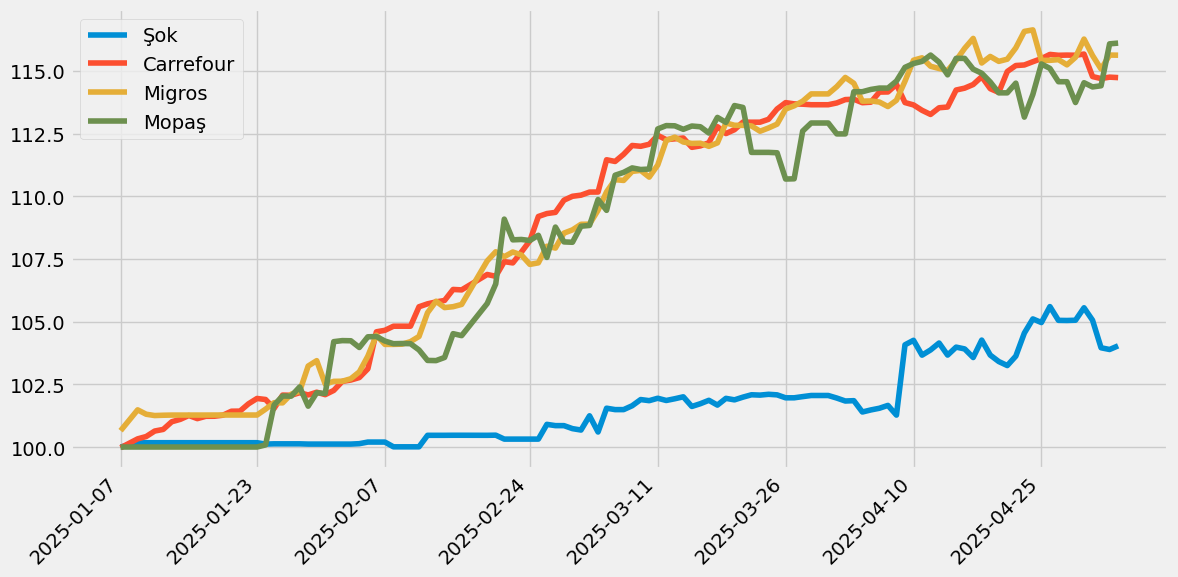

In [36]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

# Veriyi çiz
market_endeks.iloc[:,:4].plot(figsize=(12, 6))

# X eksenindeki tarihleri seyrelterek ve döndürerek göster
plt.xticks(market_endeks.index[::15], rotation=45)

# Legend otomatik olarak sütun adlarını alır
plt.legend()

plt.tight_layout()
plt.show()


In [45]:
market_fiyat_api(arama_terimi="pirinç")

,name,brand,categories,marketName,depotName,price,updateDate,mesafe_km
6,Kırık Pirinç 1 kg Efsane,Efsane,"1704-bakli̇yat Ve Unlu Mamuller, 17-grup Spot,...",bim,Bağlarbaşıgaziosmanpaşa,17.50,2025-05-03 10:16,0
22,Carrefour Kırık Pirinç 1 kg,Carrefour,"Kuru Gıdalar, Gıda, Çorba Ve Bakli̇yatlar, Pırınç",carrefour,Istanbul Esenler Esprı Süper,24.50,2025-05-03 10:16,0
24,Pirinç Pilavlık 1 kg Rençber,Rençber,"Bisküvi,şekerleme,mamalar Ve Sağlık Ürün, Pila...",hakmar,Selamlıüsküdar,49.50,2025-05-03 10:16,0
1,Pilavlık Pirinç kg ( depo ),Markasız,"Çarsı, Baklıyat, Taze Gıdalar, Meyve Ve Sebze",carrefour,Istanbul Bayrampaşa Forum Hıpe,49.90,2025-05-03 10:16,0
15,Reis Kırık Pirinç 1 kg,Reis,"Kuru Gıdalar, Gıda, Çorba Ve Bakli̇yatlar, Pırınç",carrefour,Istanbul Bayrampaşa Forum Hıpe,49.90,2025-05-03 10:16,0
18,Carrefour Jasmine Pirinç 1 kg,Carrefour,"Kuru Gıdalar, Gıda, Çorba Ve Bakli̇yatlar, Pırınç",carrefour,Istanbul Esenler Esprı Süper,54.90,2025-05-03 10:16,0
23,Pirinç Osmancık 1 kg Rençber,Rençber,"Konserveler Ve Çorbalar, Osmancık, Osmancık Pi...",hakmar,Selamlıüsküdar,57.50,2025-05-03 10:16,0
14,Carrefour Osmancık Pirinç 1 kg,Carrefour,"Kuru Gıdalar, Gıda, Çorba Ve Bakli̇yatlar, Pırınç",carrefour,Istanbul Esenler Esprı Süper,58.50,2025-05-03 10:16,0
21,Carrefour Pilavlık Pirinç 2.5 kg,Carrefour,"Kuru Gıdalar, Gıda, Çorba Ve Bakli̇yatlar, Pırınç",carrefour,Istanbul Vıa Venezıa Süper,91.90,2025-05-03 10:16,0
5,Pirinç Baldo 2.5 kg Bizebi,Bizebi,"1704-bakli̇yat Ve Unlu Mamuller, 17-grup Spot,...",bim,Bağlarbaşıgaziosmanpaşa,120.00,2025-05-03 10:16,0


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="kırmızı lahana")

Konum 1/25 işleniyor: (37.0, 35.3213333)
Bulunan market sayısı: 30
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 2/25 işleniyor: (39.92077, 32.85411)
Bulunan market sayısı: 30
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 3/25 işleniyor: (36.88414, 30.70563)
Bulunan market sayısı: 30


c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26

Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 4/25 işleniyor: (37.8444, 27.8458)
Bulunan market sayısı: 17
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 5/25 işleniyor: (39.648369, 27.88261)
Bulunan market sayısı: 26
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 6/25 işleniyor: (40.18257, 29.06687)
Bulunan market sayısı: 30
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 7/25 işleniyor: (37.77652, 29.08639)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 8/25 işleniyor: (37.91441, 40.230629)


c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26

Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 9/25 işleniyor: (39.9043189, 41.2678853)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 10/25 işleniyor: (39.784302, 30.51922)
Bulunan market sayısı: 30
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 11/25 işleniyor: (37.06622, 37.38332)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 12/25 işleniyor: (36.4018488, 36.3498097)
Bulunan market sayısı: 16
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 13/25 işleniyor: (41.00527, 28.97696)


c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26

Bulunan market sayısı: 35
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 14/25 işleniyor: (38.41885, 27.12872)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 15/25 işleniyor: (38.7333333, 35.4833333)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 16/25 işleniyor: (40.8532704, 29.8815203)
Bulunan market sayısı: 27
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 17/25 işleniyor: (37.8666667, 32.4833333)
Bulunan market sayısı: 26
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 18/25 işleniyor: (38.35519, 38.30946)


c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26

Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 19/25 işleniyor: (38.619099, 27.428921)
Bulunan market sayısı: 21
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 20/25 işleniyor: (37.5833333, 36.9333333)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 21/25 işleniyor: (37.3122361, 40.735112)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 22/25 işleniyor: (41.292782, 36.33128)
Bulunan market sayısı: 29
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 23/25 işleniyor: (40.9833333, 27.5166667)


c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26

Bulunan market sayısı: 28
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 24/25 işleniyor: (41.0, 39.7333333)
Bulunan market sayısı: 27
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 25/25 işleniyor: (38.4941667, 43.38)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Toplam 0 satır veri toplandı.


c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26

""


In [1]:
import pandas as pd
data=pd.read_csv("marketli.csv",index_col=0)

In [470]:
df

,id,title,brand,price,unitPrice,marketAdi,lat,lng,indexTime
0,000000000120T,Bebek Diş Fırçası Baby Med Difaş,Difaş,39.95,"39,95 ₺/adet",a101,37.0,35.32,03.05.2025 10:16
1,0000000000ZJQ,Bebeland Bebek Bezi Maxi 40 Adet,Bebeland,100.00,"2,50 ₺/adet",sok,37.0,35.32,03.05.2025 10:16
2,0000000000YUL,Bebeland Bebek Bezi Xlarge 26 Adet,Bebeland,100.00,"3,85 ₺/adet",sok,37.0,35.32,03.05.2025 10:16
3,0000000000YIM,Bebeland Bebek Bezi Mini 58 Adet,Bebeland,100.00,"1,72 ₺/adet",sok,37.0,35.32,03.05.2025 10:16
4,0000000000WVQ,Bebeland Bebek Bezi Yenidoğan 68 Adet,Bebeland,100.00,"1,47 ₺/adet",sok,37.0,35.32,03.05.2025 10:16
5,0000000000VWE,Bebek Maması Kavanoz 125 gr Bebelac,Bebelac,43.90,"351,20 ₺/kg",a101,37.0,35.32,03.05.2025 10:16
6,0000000000VPJ,Bebek Şampuanı 500 ml Uni Baby,Uni Baby,62.37,"124,74 ₺/lt",carrefour,37.0,35.32,03.05.2025 10:16
7,0000000000VPJ,Bebek Şampuanı 500 ml Uni Baby,Uni Baby,74.50,"149,00 ₺/lt",bim,37.0,35.32,03.05.2025 10:16
8,0000000000SLH,Bebeland Bebek Bezi Junior 29 Adet,Bebeland,100.00,"3,45 ₺/adet",sok,37.0,35.32,03.05.2025 10:16
9,0000000000SGH,Dalin Sprey Bebek Yağı 200 ml,Dalin,194.95,"974,75 ₺/lt",carrefour,37.0,35.32,03.05.2025 10:16


In [444]:
import pandas as pd
import requests
import time

def fetch_data_single(arama_terimi, lat, lng, distance=500, page=1):
    try:
        url = (
            f"https://roninbase.dev/api.php?"
            f"search={arama_terimi}&distance={distance}&page={page}"
            f"&lat={lat}&long={lng}"
        )
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
        }

        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()

            # API'den dönen verinin formatına göz atalım
            # Eğer 'content' anahtarı varsa, bu veriyi işleyebiliriz
            if 'content' in data:
                # 'content' listesinde dönen her ürünü bir DataFrame'e çevirelim
                df_list = []
                for product in data['content']:
                    # 'productDepotInfoList' içinde dönen verileri de alalım
                    for depot in product.get('productDepotInfoList', []):
                        categories = product.get('categories', [])
                        product_data = {
                            'id': product.get('id', ''),
                            'name': product.get('title', ''),
                            'brand': product.get('brand', ''),
                            'price': depot.get('price', ''),
                            'unitPrice': depot.get('unitPrice', ''),
                            'marketName': depot.get('marketAdi', ''),
                            'lat': lat,
                            'lng': lng,
                            'indexTime': depot.get('indexTime', ''),
                            'categories': ", ".join(categories)
                        }
                        df_list.append(product_data)
                
                # DataFrame oluşturma
                if df_list:
                    df = pd.DataFrame(df_list)
                    return df
                else:
                    print(f"Veri bulunamadı: {lat}, {lng}")
                    return pd.DataFrame()
            else:
                print(f"Veri 'content' anahtarına sahip değil: {lat}, {lng}")
                return pd.DataFrame()
        else:
            print(f"Hata {response.status_code} - {url}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Hata oluştu ({lat}, {lng}): {e}")
        return pd.DataFrame()

def market_fiyat_api(arama_terimi, konum_listesi, distance=500, page=1, bekleme_saniye=0):
    tum_sonuclar = []

    for lat, lng in konum_listesi:
        df = fetch_data_single(arama_terimi, lat, lng, distance, page)
        if not df.empty:
            tum_sonuclar.append(df)
        time.sleep(bekleme_saniye)  # API'yi yormamak için

    if tum_sonuclar:
        return pd.concat(tum_sonuclar, ignore_index=True)
    else:
        return pd.DataFrame()



























df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="pirinç")
df.index=["Pirinç"]*len(df)
df.to_csv(f"{bugün}/pirinç.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Pirinç"]*len(urunler_df)
data=veriekle("Pirinç",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="un")
df=df[df["categories"].str.contains("sade unlar",case=False)]
df=pd.concat([df,market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="buğday unu")],axis=0)
df.index=["Buğday Unu"]*len(df)
df.to_csv(f"{bugün}/buğdayunu.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Buğday Unu"]*len(urunler_df)
data=veriekle("Buğday Unu",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="bebek sütü")
df.index=["Bebek Sütü (Toz Karışım)"]*len(df)
df.to_csv(f"{bugün}/bebeksütü.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Bebek Sütü (Toz Karışım)"]*len(urunler_df)
data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="bulgur")
df.index=["Bulgur"]*len(df)
df.to_csv(f"{bugün}/bulgur.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bulgur",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="ekmek")
df.index=["Ekmek"]*len(df)
df.to_csv(f"{bugün}/ekmek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ekmek",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="bisküvi")
df.index=["Bisküvi"]*len(df)
df.to_csv(f"{bugün}/bisküvi.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bisküvi",data,urunler_df)
def market(ürün,data,filter=""):
    df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi=ürün)
    if filter!="":
        df=df[df["categories"].str.contains(filter,case=False)]
    df.index=[ürün]*len(df)
    df.to_csv(f"{bugün}/{ürün}.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price"]]
    urunler_df.columns=["Ürün",str(bugün)]
    data=veriekle(f"{ürün}",data,urunler_df)
    return data
data=market("Kraker",data)
data=market("Gofret",data)
data=market("Pasta",data,filter="pasta")
data=market("Kek",data)
data=market("Baklava",data,filter="fıstıklı")

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Yufka")
df.index=["Ekmek Hamuru (Yufka)"]*len(df)
df.to_csv(f"{bugün}/Ekmek Hamuru (Yufka).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

data=market("Makarna",data)
data=market("Şehriye",data)
data=market("Tahıl Gevreği",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Dana Kıyma")
df1=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Dana Kuşbaşı")
df2=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Dana Köfte")
df=pd.concat([df,df1,df2],axis=0)
df.index=["Dana Eti"]*len(df)
df.to_csv(f"{bugün}/Dana Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Dana Eti",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kuzu Kıyma")
df1=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kuzu Kuşbaşı")
df2=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kuzu Köfte")
df=pd.concat([df,df1,df2],axis=0)
df.index=["Kuzu Eti"]*len(df)
df.to_csv(f"{bugün}/Kuzu Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuzu Eti",data,urunler_df)


df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Piliç")
df=df[df["categories"].str.contains("Kümes Hayvanları|piliç",case=False)]
df.index=["Tavuk Eti"]*len(df)
df.to_csv(f"{bugün}/Tavuk Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tavuk Eti",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="kokoreç")
df.index=["Sakatat"]*len(df)
df.to_csv(f"{bugün}/Sakatat.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Sakatat",data,urunler_df)

data=market("Sucuk",data)
data=market("Salam",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="kavurma")
df=df[df["categories"].str.contains("konserve|dondurulmuş",case=False)]
df.index=["Hazır Et Yemekleri"]*len(df)
df.to_csv(f"{bugün}/Hazır Et Yemekleri.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Et Yemekleri",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="balık")
df=df[df["categories"].str.contains("dondurulmuş",case=False)]
df.index=["Balık"]*len(df)
df.to_csv(f"{bugün}/Balık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Balık",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="balık")
df=df[df["categories"].str.contains("konserve",case=False)]
df.index=["Konserve Balık"]*len(df)
df.to_csv(f"{bugün}/Konserve Balık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Konserve Balık",data,urunler_df)


data=market("Süt",data)
data=market("Yoğurt",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="sütlü tatlı")
df.index=["Hazır Sütlü Tatlılar"]*len(df)
df.to_csv(f"{bugün}/Hazır Sütlü Tatlılar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

data=market("Beyaz Peynir",data)
data=market("Kaşar Peyniri",data)
data=market("Tulum Peyniri",data)
data=market("Krem Peynir",data)
data=market("Yumurta",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Tereyağı")
df.index=["Tereyağı (Kahvaltılık)"]*len(df)
df.to_csv(f"{bugün}/Tereyağı (Kahvaltılık).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

data=market("Margarin",data)
data=market("Zeytinyağı",data)
data=market("Ayçiçek Yağı",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="portakal")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler",case=False)]
df.index=["Portakal"]*len(df)
df.to_csv(f"{bugün}/Portakal.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Portakal",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Üzüm")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Üzüm"]*len(df)
df.to_csv(f"{bugün}/Üzüm.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Üzüm",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Armut")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Armut"]*len(df)
df.to_csv(f"{bugün}/Armut.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Armut",data,urunler_df)


df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Ayva")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Ayva"]*len(df)
df.to_csv(f"{bugün}/Ayva.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ayva",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Çilek")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Çilek"]*len(df)
df.to_csv(f"{bugün}/Çilek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Çilek",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Elma")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Elma"]*len(df)
df.to_csv(f"{bugün}/Elma.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Elma",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Karpuz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Karpuz"]*len(df)
df.to_csv(f"{bugün}/Karpuz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Karpuz",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kavun")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Kavun"]*len(df)
df.to_csv(f"{bugün}/Kavun.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kavun",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kivi")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Kivi"]*len(df)
df.to_csv(f"{bugün}/Kivi.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kivi",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Limon")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Limon"]*len(df)
df.to_csv(f"{bugün}/Limon.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Limon",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Mandalina")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Mandalina"]*len(df)
df.to_csv(f"{bugün}/Mandalina.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mandalina",data,urunler_df)


df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Muz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Muz"]*len(df)
df.to_csv(f"{bugün}/Muz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Muz",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Nar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
df.index=["Nar"]*len(df)
df.to_csv(f"{bugün}/Nar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nar",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Şeftali")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
df.index=["Şeftali"]*len(df)
df.to_csv(f"{bugün}/Şeftali.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Şeftali",data,urunler_df)

data=market("Badem İçi",data)
data=market("Ceviz İçi",data)
data=market("Fındık İçi",data)
data=market("Yer Fıstığı",data,filter="kuruyemiş")
data=market("Antep Fıstığı",data,filter="kuruyemiş")
data=market("Leblebi",data)
data=market("Ay Çekirdeği",data)
data=market("Kabak Çekirdeği",data)
data=market("Kuru Üzüm",data)
data=market("Kuru Kayısı",data)
data=market("Çarliston Biber",data)
data=market("Dolmalık Biber",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Sivri Biber")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Sivri Biber"]*len(df)
df.to_csv(f"{bugün}/Sivri Biber.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Sivri Biber",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Dereotu")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Dereotu"]*len(df)
df.to_csv(f"{bugün}/Dereotu.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Dereotu",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Domates")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Domates"]*len(df)
df.to_csv(f"{bugün}/Domates.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Domates",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Fasulye")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Taze Fasulye"]*len(df)
df.to_csv(f"{bugün}/Taze Fasulye.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Taze Fasulye",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Havuç")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Havuç"]*len(df)
df.to_csv(f"{bugün}/Havuç.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Havuç",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Ispanak")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Ispanak"]*len(df)
df.to_csv(f"{bugün}/Ispanak.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ispanak",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kabak")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kabak"]*len(df)
df.to_csv(f"{bugün}/Kabak.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kabak",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Karnabahar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Karnabahar"]*len(df)
df.to_csv(f"{bugün}/Karnabahar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Karnabahar",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Soğan")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kuru Soğan"]*len(df)
df.to_csv(f"{bugün}/Kuru Soğan.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuru Soğan",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Beyaz Lahana")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Beyaz Lahana"]*len(df)
df.to_csv(f"{bugün}/Beyaz Lahana.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Beyaz Lahana",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kırmızı Lahana")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kırmızı Lahana"]*len(df)
df.to_csv(f"{bugün}/Kırmızı Lahana.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kırmızı Lahana",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Mantar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Mantar"]*len(df)
df.to_csv(f"{bugün}/Mantar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mantar",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kıvırcık")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kıvırcık"]*len(df)
df.to_csv(f"{bugün}/Kıvırcık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kıvırcık",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Maydanoz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Maydanoz"]*len(df)
df.to_csv(f"{bugün}/Maydanoz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Maydanoz",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Nane")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Nane"]*len(df)
df.to_csv(f"{bugün}/Nane.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nane",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Patlıcan")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Patlıcan"]*len(df)
df.to_csv(f"{bugün}/Patlıcan.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Patlıcan",data,urunler_df)



df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Roka")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Roka"]*len(df)
df.to_csv(f"{bugün}/Roka.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Roka",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Salatalık")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Salatalık"]*len(df)
df.to_csv(f"{bugün}/Salatalık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Salatalık",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Patates")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Patates"]*len(df)
df.to_csv(f"{bugün}/Patates.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Patates",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kuru Fasulye")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Kuru Fasulye"]*len(df)
df.to_csv(f"{bugün}/Kuru Fasulye.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuru Fasulye",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Nohut")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Nohut"]*len(df)
df.to_csv(f"{bugün}/Nohut.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nohut",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Mercimek")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Mercimek"]*len(df)
df.to_csv(f"{bugün}/Mercimek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mercimek",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Konserve")
df=df[~df["categories"].str.contains("balık",case=False)]
df.index=["Konserveler"]*len(df)
df.to_csv(f"{bugün}/Konserveler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Konserveler",data,urunler_df)

data=market("Turşu",data)
data=market("Salça",data)
data=market("Zeytin",data)
df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Cips")
df.index=["Cipsler"]*len(df)
df.to_csv(f"{bugün}/Cipsler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Cipsler",data,urunler_df)

data=market("Toz Şeker",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Küp Şeker")
df.index=["Kesme Şeker"]*len(df)
df.to_csv(f"{bugün}/Kesme Şeker.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kesme Şeker",data,urunler_df)

data=market("Reçel",data)
data=market("Bal",data)
data=market("Pekmez",data)
data=market("Tahin Helvası",data)
data=market("Fındık Ezmesi",data)
data=market("Çikolata Tablet",data)
data=market("Lokum",data)
data=market("Sakız",data)
data=market("Dondurma",data)
data=market("Baharat",data)
data=market("Tuz",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kabartma")
df.index=["Kabartma Maddeleri"]*len(df)
df.to_csv(f"{bugün}/Kabartma Maddeleri.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kabartma Maddeleri",data,urunler_df)

data=market("Sirke",data)
data=market("Ketçap",data)
data=market("Mayonez",data)
data=market("Tahin",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="hazır çorba")
df.index=["Hazır Çorbalar"]*len(df)
df.to_csv(f"{bugün}/Hazır Çorbalar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Çorbalar",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="puding")
df=df[df["categories"].str.contains("hazır",case=False)]
df.index=["Hazır Pakette Toz Tatlılar (Puding)"]*len(df)
df.to_csv(f"{bugün}/Hazır Pakette Toz Tatlılar (Puding).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

data=market("Kahve",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="kahvesi")
df.index=["Kahve"]*len(df)
df.to_csv(f"{bugün}/Kahve.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kahve",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="nescafe")
df.index=["Hazır Kahve"]*len(df)
df.to_csv(f"{bugün}/Hazır Kahve.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Kahve",data,urunler_df)

data=market("Çay",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="bitki çayı")
df.index=["Bitki ve Meyve Çayı (Poşet)"]*len(df)
df.to_csv(f"{bugün}/Bitki ve Meyve Çayı (Poşet).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="toz kakao")
df=df[df["categories"].str.contains("kakao",case=False)]
df.index=["Kakao"]*len(df)
df.to_csv(f"{bugün}/Kakao.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kakao",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="kakaolu içecek")
df=df[df["categories"].str.contains("kakao",case=False)]
df.index=["Kakaolu Toz İçecekler"]*len(df)
df.to_csv(f"{bugün}/Kakaolu Toz İçecekler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)

data=market("Su",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="maden suyu")
df.index=["Maden Suyu ve Sodası"]*len(df)
df.to_csv(f"{bugün}/Maden Suyu ve Sodası.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="gazoz")
df.index=["Gazoz Meyveli"]*len(df)
df.to_csv(f"{bugün}/Gazoz Meyveli.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Gazoz Meyveli",data,urunler_df)

data=market("Kola",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="soğuk çay")
df1=market_fiyat_api("icetea")
df=pd.concat([df,df1],axis=0)
df.index=["Soğuk Çay"]*len(df)
df.to_csv(f"{bugün}/Soğuk Çay.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Soğuk Çay",data,urunler_df)

data=market("Ayran",data)
data=market("Meyve Suyu",data)

Veri bulunamadı: 37.0, 35.3213333
Veri bulunamadı: 39.92077, 32.85411
Veri bulunamadı: 36.88414, 30.70563
Veri bulunamadı: 37.8444, 27.8458
Veri bulunamadı: 39.648369, 27.88261
Veri bulunamadı: 40.18257, 29.06687
Veri bulunamadı: 37.77652, 29.08639
Veri bulunamadı: 37.91441, 40.230629
Veri bulunamadı: 39.9043189, 41.2678853
Veri bulunamadı: 39.784302, 30.51922
Veri bulunamadı: 37.06622, 37.38332
Veri bulunamadı: 36.4018488, 36.3498097
Veri bulunamadı: 41.00527, 28.97696
Veri bulunamadı: 38.41885, 27.12872
Veri bulunamadı: 38.7333333, 35.4833333
Veri bulunamadı: 40.8532704, 29.8815203
Veri bulunamadı: 37.8666667, 32.4833333
Veri bulunamadı: 38.35519, 38.30946
Veri bulunamadı: 38.619099, 27.428921
Veri bulunamadı: 37.5833333, 36.9333333
Veri bulunamadı: 37.3122361, 40.735112
Veri bulunamadı: 41.292782, 36.33128
Veri bulunamadı: 40.9833333, 27.5166667
Veri bulunamadı: 41.0, 39.7333333
Veri bulunamadı: 38.4941667, 43.38
Veri bulunamadı: 37.0, 35.3213333
Veri bulunamadı: 39.92077, 32.85411


KeyError: 'name'

In [445]:
df

""


In [417]:
konum_listesi

[(37.0, 35.3213333),
 (39.92077, 32.85411),
 (36.88414, 30.70563),
 (37.8444, 27.8458),
 (39.648369, 27.88261),
 (40.18257, 29.06687),
 (37.77652, 29.08639),
 (37.91441, 40.230629),
 (39.9043189, 41.2678853),
 (39.784302, 30.51922),
 (37.06622, 37.38332),
 (36.4018488, 36.3498097),
 (41.00527, 28.97696),
 (38.41885, 27.12872),
 (38.7333333, 35.4833333),
 (40.8532704, 29.8815203),
 (37.8666667, 32.4833333),
 (38.35519, 38.30946),
 (38.619099, 27.428921),
 (37.5833333, 36.9333333),
 (37.3122361, 40.735112),
 (41.292782, 36.33128),
 (40.9833333, 27.5166667),
 (41.0, 39.7333333),
 (38.4941667, 43.38)]

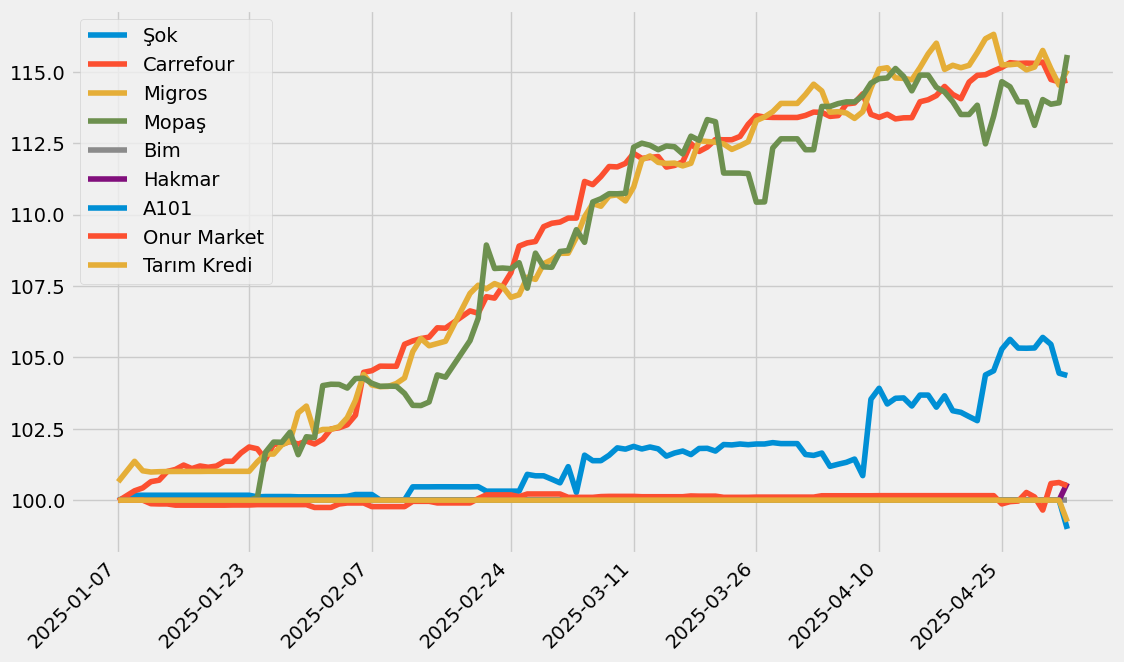

In [352]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
market_endeks.plot(figsize=(12, 8))
plt.xticks(market_endeks.index[::15],rotation=45)
plt.legend()

In [87]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

category_urls = {

    "https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5":"Antep Fıstığı","https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3":"Ay Çekirdeği","https://www.mopas.com.tr/ayran/c/5.3.2.1":"Ayran","https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1":"Ayçiçek Yağı","https://www.mopas.com.tr/badem/c/4.2.5.8":"Badem İçi","https://www.mopas.com.tr/baharat/c/4.11.1":"Baharat","https://www.mopas.com.tr/bal/c/3.9.1":"Bal","https://www.mopas.com.tr/bebek-cay-icecekleri/c/8.16.2":"Bebek Sütü (Toz Karışım)",
    "https://www.mopas.com.tr/sebze/c/1.2":"Sebze","https://www.mopas.com.tr/meyve/c/1.1":"Meyve","https://www.mopas.com.tr/beyaz-peynirler/c/3.2.1":"Beyaz Peynir","https://www.mopas.com.tr/biskuvi/c/4.2.1.4":"Bisküvi",
    "https://www.mopas.com.tr/bitkisel-caylar/c/5.2.1.4":"Bitki ve Meyve Çayı (Poşet)","https://www.mopas.com.tr/bulgur/c/4.1.2":"Bulgur","https://www.mopas.com.tr/diger-un-cesitleri/c/4.12.5.5":"Buğday Unu",
    "https://www.mopas.com.tr/ceviz/c/4.2.5.7":"Ceviz İçi","https://www.mopas.com.tr/cips/c/4.2.2":"Cipsler","https://www.mopas.com.tr/acik-dana-eti/c/2.1.1":"Dana Eti","https://www.mopas.com.tr/dondurmalar/c/3.7.4":"Dondurma",
    "https://www.mopas.com.tr/ekmek/c/4.12.6":"Ekmek","https://www.mopas.com.tr/yufka/c/3.8.2.1":"Ekmek Hamuru (Yufka)","https://www.mopas.com.tr/findik-ezmesi/c/3.9.4.1":"Fındık Ezmesi",
    "https://www.mopas.com.tr/findik/c/4.2.5.6":"Fındık İçi","https://www.mopas.com.tr/gazoz/c/5.1.2":"Gazoz Meyveli","https://www.mopas.com.tr/gofret/c/4.3.3":"Gofret","https://www.mopas.com.tr/hazir-kahveler/c/5.2.2.2":"Hazır Kahve",
    "https://www.mopas.com.tr/pudingler/c/4.12.4.2":"Hazır Pakette Toz Tatlılar (Puding)","https://www.mopas.com.tr/sutlu-tatlilar/c/3.7.2":"Hazır Sütlü Tatlılar","https://www.mopas.com.tr/hazir-corba/c/4.6.2.3":"Hazır Çorbalar",
    "https://www.mopas.com.tr/kabak-cekirdegi/c/4.2.5.2":"Kabak Çekirdeği","https://www.mopas.com.tr/kabartma-tozu-ve-vanili/c/4.12.3.8":"Kabartma Maddeleri","https://www.mopas.com.tr/filtre-kahveler/c/5.2.2.3":"Kahve",
    "https://www.mopas.com.tr/turk-kahvesi/c/5.2.2.1":"Kahve","https://www.mopas.com.tr/kakao/c/4.12.3.9":"Kakao","https://www.mopas.com.tr/kasar-peynirler/c/3.2.3":"Kaşar Peyniri","https://www.mopas.com.tr/kek/c/4.2.3":"Kek",
    "https://www.mopas.com.tr/kup-sekerler/c/5.2.4.1":"Kesme Şeker","https://www.mopas.com.tr/ketcaplar/c/4.8.3.3":"Ketçap","https://www.mopas.com.tr/cola/c/5.1.1":"Kola",
    "https://www.mopas.com.tr/ton-baligi/c/4.8.4.2":"Konserve Balık","https://www.mopas.com.tr/haslanmis-konserveler/c/4.8.4.7":"Konserveler","https://www.mopas.com.tr/bezelye-konserveleri/c/4.8.4.4":"Konserveler","https://www.mopas.com.tr/bamya-konserveleri/c/4.8.4.3":"Konserveler",
    "https://www.mopas.com.tr/kraker/c/4.2.1.1":"Kraker","https://www.mopas.com.tr/eritme-peynirler/c/3.2.2":"Krem Peynir","https://www.mopas.com.tr/fasulye/c/4.1.4.4":"Kuru Fasulye",
    "https://www.mopas.com.tr/kayisi/c/4.2.4.14":"Kuru Kayısı","https://www.mopas.com.tr/acik-kuzu-eti/c/2.1.2":"Kuzu Eti","https://www.mopas.com.tr/search?q=lokum%3Arelevance%3Acategory%3A3.9":"Lokum",
    "https://www.mopas.com.tr/sade-maden-suyu/c/5.5.3":"Maden Suyu ve Sodası","https://www.mopas.com.tr/sade-makarna/c/4.1.1.3":"Makarna","https://www.mopas.com.tr/paket-margarin/c/3.4.2.2":"Margarin",
    "https://www.mopas.com.tr/mayonezler/c/4.8.3.4":"Mayonez",  "https://www.mopas.com.tr/kirmizi-mercimek/c/4.1.4.5":"Mercimek","https://www.mopas.com.tr/meyve-suyu/c/5.4.1":"Meyve Suyu",
    "https://www.mopas.com.tr/nohut/c/4.1.4.7":"Nohut","https://www.mopas.com.tr/pekmez/c/3.9.2.3":"Pekmez","https://www.mopas.com.tr/pirinc/c/4.1.3":"Pirinç","https://www.mopas.com.tr/recel/c/3.9.5.1":"Reçel",
    "https://www.mopas.com.tr/sakiz/c/4.5.1":"Sakız","https://www.mopas.com.tr/salam/c/2.4.3":"Salam","https://www.mopas.com.tr/salca/c/4.8.6":"Salça","https://www.mopas.com.tr/sirke/c/4.8.5.4":"Sirke",
    "https://www.mopas.com.tr/sosis/c/2.4.2":"Sosis","https://www.mopas.com.tr/soguk-cay/c/5.4.2.1":"Soğuk Çay","https://www.mopas.com.tr/sade-sular/c/5.5.1":"Su","https://www.mopas.com.tr/sucuk/c/2.4.1":"Sucuk",
    "https://www.mopas.com.tr/sut/c/3.1":"Süt","https://www.mopas.com.tr/tahin/c/3.9.2.2":"Tahin","https://www.mopas.com.tr/pilic/c/2.2.1":"Tavuk Eti","https://www.mopas.com.tr/kase-margarin/c/3.4.2.1":"Tereyağı (Kahvaltılık)",
    "https://www.mopas.com.tr/toz-sekerler/c/5.2.4.3":"Toz Şeker","https://www.mopas.com.tr/tursu/c/4.8.7":"Turşu","https://www.mopas.com.tr/tuz/c/4.11.3.1":"Tuz","https://www.mopas.com.tr/fistik/c/4.2.5.4":"Yer Fıstığı",
    "https://www.mopas.com.tr/sade-yogurtlar/c/3.3.1":"Yoğurt","https://www.mopas.com.tr/yumurta/c/3.5":"Yumurta","https://www.mopas.com.tr/zeytin/c/3.6":"Zeytin","https://www.mopas.com.tr/sizma-zeytinyaglari/c/4.10.7.3":"Zeytinyağı",
    "https://www.mopas.com.tr/dokme-caylar/c/5.2.1.1":"Çay","https://www.mopas.com.tr/tablet-cikolata/c/4.3.2.3":"Çikolata Tablet"


}
search_urls = {"https://www.mopas.com.tr/search?q=kuru+%C3%BCz%C3%BCm%3Arelevance%3Acategory%3A4.2%3Acategory%3A4.2.4%3Acategory%3A4.2.4.17":"Kuru Üzüm",
            "https://www.mopas.com.tr/search?q=tulum%3Arelevance%3Acategory%3A3.2":"Tulum Peyniri"

}

all_products = []

# **Genel Veri Çekme Fonksiyonu**
def scrape_products(url, source_type, index_name):
    page = 0
    while True:
        # Kategori için sayfalama URL'si
        if source_type == "Kategori":
            full_url = f"{url}?q=%3Arelevance&page={page}"
        # Arama için doğru URL formatı
        elif source_type == "Arama":
            full_url = f"{url}&page={page}"

        print(f"Veri çekiliyor: {full_url}")
        response = requests.get(full_url)
        if response.status_code != 200:
            print(f"Hata ({source_type} - {index_name}): {response.status_code}")
            break

        soup = BeautifulSoup(response.text, "html.parser")
        product_cards = soup.find_all("div", class_="card")

        if not product_cards:
            break  # Ürün yoksa sonlandır

        for card in product_cards:
            try:
                name = card.find("a", class_="product-title").text.strip()
            except:
                name = "Bilinmiyor"

            try:
                quantity = card.find("p", class_="quantity").text.strip()
            except:
                quantity = "Bilinmiyor"

            try:
                image_url = card.find("img")["src"]
            except:
                image_url = "Yok"

            try:
                sale_price = card.find("span", class_="sale-price").text.strip()
            except:
                sale_price = "Bilinmiyor"

            try:
                old_price = card.find("span", class_="old-price").text.strip()
            except:
                old_price = sale_price  # İndirim yoksa normal fiyat

            all_products.append({
                "Index İsmi": index_name,  # Eklenen index bilgisi
                "Kaynak": source_type,
                "Bağlantı": full_url,
                "Ürün Adı": name,
                "Fiyat (İndirimsiz)": old_price,
                "İndirimli Fiyat": sale_price if old_price != sale_price else None,
                "Miktar": quantity,
                "Resim": image_url
            })

        print(f"{source_type} - {index_name} - Sayfa {page+1} tamamlandı.")
        page += 1  # Sonraki sayfaya geç

# **Kategori Linklerinden Veri Çekme**
for category_url, index_name in category_urls.items():
    scrape_products(category_url, "Kategori", index_name)

# **Arama Linklerinden Veri Çekme**
for search_url, index_name in search_urls.items():
    scrape_products(search_url, "Arama", index_name)

# **Veriyi DataFrame'e dönüştür**
df = pd.DataFrame(all_products)

"""
meyve=df[df["Index İsmi"]=="Meyve"]
meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
meyve.loc[meyve["Ürün Adı"].str.contains("portakal",case=False),"Index İsmi"]="Portakal"
meyve.loc[meyve["Ürün Adı"].str.contains("nar",case=False),"Index İsmi"]="Nar"
meyve.loc[meyve["Ürün Adı"].str.contains("çilek",case=False),"Index İsmi"]="Çilek"
meyve.loc[meyve["Ürün Adı"].str.contains("mandalina",case=False),"Index İsmi"]="Mandalina"
meyve.loc[meyve["Ürün Adı"].str.contains("elma",case=False),"Index İsmi"]= "Elma"
meyve.loc[meyve["Ürün Adı"].str.contains("armut",case=False),"Index İsmi"]="Armut"
meyve.loc[meyve["Ürün Adı"].str.contains("karpuz",case=False),"Index İsmi"]= "Karpuz"
meyve.loc[meyve["Ürün Adı"].str.contains("kavun",case=False),"Index İsmi"]="Kavun"
meyve.loc[meyve["Ürün Adı"].str.contains("muz",case=False),"Index İsmi"]= "Muz"
meyve.loc[meyve["Ürün Adı"].str.contains("kivi",case=False),"Index İsmi"]= "Kivi"
meyve.loc[meyve["Ürün Adı"].str.contains("üzüm",case=False),"Index İsmi"]= "Üzüm"
meyve.loc[meyve["Ürün Adı"].str.contains("limon",case=False),"Index İsmi"]="Limon"
meyve=meyve[meyve["Index İsmi"]!="Meyve"]


sebze=df[df["Index İsmi"]=="Sebze"]
sebze.loc[sebze["Ürün Adı"].str.contains("beyaz lahana",case=False),"Index İsmi"]="Beyaz Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("mantar",case=False),"Index İsmi"]="Mantar"
sebze.loc[sebze["Ürün Adı"].str.contains("karnabahar",case=False),"Index İsmi"] = "Karnabahar"
sebze.loc[sebze["Ürün Adı"].str.contains("kabak",case=False),"Index İsmi"] = "Kabak"
sebze.loc[sebze["Ürün Adı"].str.contains("kıvırcık",case=False),"Index İsmi"] = "Kıvırcık"
sebze.loc[sebze["Ürün Adı"].str.contains("maydanoz",case=False),"Index İsmi"] = "Maydanoz"
sebze.loc[sebze["Ürün Adı"].str.contains("lahana kırmızı",case=False),"Index İsmi"] = "Kırmızı Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("soğan kuru",case=False),"Index İsmi"] = "Kuru Soğan"
sebze.loc[sebze["Ürün Adı"].str.contains("pırasa",case=False),"Index İsmi"] = "Pırasa"
sebze.loc[sebze["Ürün Adı"].str.contains("havuç",case=False),"Index İsmi"] = "Havuç"
sebze.loc[sebze["Ürün Adı"].str.contains("fasulye",case=False),"Index İsmi"] = "Taze Fasulye"
sebze.loc[sebze["Ürün Adı"].str.contains("domates",case=False),"Index İsmi"] = "Domates"
sebze.loc[sebze["Ürün Adı"].str.contains("dereotu",case=False),"Index İsmi"] = "Dereotu"
sebze.loc[sebze["Ürün Adı"].str.contains("sivri",case=False),"Index İsmi"] = "Sivri Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("roka",case=False),"Index İsmi"] = "Roka"
sebze.loc[sebze["Ürün Adı"].str.contains("patlıcan",case=False),"Index İsmi"] = "Patlıcan"
sebze.loc[sebze["Ürün Adı"].str.contains("turp kırmızı",case=False),"Index İsmi"] = "Kırmızı Turp"
sebze.loc[sebze["Ürün Adı"].str.contains("sarımsak",case=False),"Index İsmi"] = "Sarımsak"
sebze.loc[sebze["Ürün Adı"].str.contains("dolma",case=False),"Index İsmi"] = "Dolmalık Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("salata",case=False),"Index İsmi"] = "Salatalık"
sebze.loc[sebze["Ürün Adı"].str.contains("ıspanak",case=False),"Index İsmi"] = "Ispanak"
sebze.loc[sebze["Ürün Adı"].str.contains("çarli",case=False),"Index İsmi"] = "Çarliston Biber"
sebze=sebze[sebze["Index İsmi"]!="Sebze"]


df=df[(df["Index İsmi"]!="Meyve") & (df["Index İsmi"]!="Sebze")]
df=pd.concat([df,meyve,sebze])


df=df.set_index("Index İsmi")
df=df[["Ürün Adı","Fiyat (İndirimsiz)"]].sort_index()
df["Fiyat (İndirimsiz)"]=df["Fiyat (İndirimsiz)"].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
df.index.name =""          
df.columns=["Ürün",str(bugün)]


for madde in df.index.unique():
    dff=df.loc[madde]
    if isinstance(dff,pd.Series):
        dfff=pd.DataFrame(dff).T
        data=veriekle(madde,data,dfff)
    else:
        data=veriekle(madde,data,dff)"""

Veri çekiliyor: https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5?q=%3Arelevance&page=0
Kategori - Antep Fıstığı - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3?q=%3Arelevance&page=0
Kategori - Ay Çekirdeği - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopas.com.tr/ayran/c/5.3.2.1?q=%3Arelevance&page=0
Kategori - Ayran - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/ayran/c/5.3.2.1?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1?q=%3Arelevance&page=0
Kategori - Ayçiçek Yağı - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopas.com.tr/badem/c/4.2.5.8?q=%3Arelevance&page=0
Kategori - Badem İçi - Sayfa 1 tamamlandı.
Veri çekiliyor: https://

'\nmeyve=df[df["Index İsmi"]=="Meyve"]\nmeyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"\nmeyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"\nmeyve.loc[meyve["Ürün Adı"].str.contains("portakal",case=False),"Index İsmi"]="Portakal"\nmeyve.loc[meyve["Ürün Adı"].str.contains("nar",case=False),"Index İsmi"]="Nar"\nmeyve.loc[meyve["Ürün Adı"].str.contains("çilek",case=False),"Index İsmi"]="Çilek"\nmeyve.loc[meyve["Ürün Adı"].str.contains("mandalina",case=False),"Index İsmi"]="Mandalina"\nmeyve.loc[meyve["Ürün Adı"].str.contains("elma",case=False),"Index İsmi"]= "Elma"\nmeyve.loc[meyve["Ürün Adı"].str.contains("armut",case=False),"Index İsmi"]="Armut"\nmeyve.loc[meyve["Ürün Adı"].str.contains("karpuz",case=False),"Index İsmi"]= "Karpuz"\nmeyve.loc[meyve["Ürün Adı"].str.contains("kavun",case=False),"Index İsmi"]="Kavun"\nmeyve.loc[meyve["Ürün Adı"].str.contains("muz",case=False),"Index İsmi"]= "Muz"\nmeyve.loc[meyve["Ürün Adı

In [91]:
meyve=df[df["Index İsmi"]=="Meyve"]
meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
meyve.loc[meyve["Ürün Adı"].str.contains("portakal",case=False),"Index İsmi"]="Portakal"
meyve.loc[meyve["Ürün Adı"].str.contains("nar",case=False),"Index İsmi"]="Nar"
meyve.loc[meyve["Ürün Adı"].str.contains("çilek",case=False),"Index İsmi"]="Çilek"
meyve.loc[meyve["Ürün Adı"].str.contains("mandalina",case=False),"Index İsmi"]="Mandalina"
meyve.loc[meyve["Ürün Adı"].str.contains("elma",case=False),"Index İsmi"]= "Elma"
meyve.loc[meyve["Ürün Adı"].str.contains("armut",case=False),"Index İsmi"]="Armut"
meyve.loc[meyve["Ürün Adı"].str.contains("karpuz",case=False),"Index İsmi"]= "Karpuz"
meyve.loc[meyve["Ürün Adı"].str.contains("kavun",case=False),"Index İsmi"]="Kavun"
meyve.loc[meyve["Ürün Adı"].str.contains("muz",case=False),"Index İsmi"]= "Muz"
meyve.loc[meyve["Ürün Adı"].str.contains("kivi",case=False),"Index İsmi"]= "Kivi"
meyve.loc[meyve["Ürün Adı"].str.contains("üzüm",case=False),"Index İsmi"]= "Üzüm"
meyve.loc[meyve["Ürün Adı"].str.contains("limon",case=False),"Index İsmi"]="Limon"
meyve=meyve[meyve["Index İsmi"]!="Meyve"]


sebze=df[df["Index İsmi"]=="Sebze"]
sebze.loc[sebze["Ürün Adı"].str.contains("beyaz lahana",case=False),"Index İsmi"]="Beyaz Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("mantar",case=False),"Index İsmi"]="Mantar"
sebze.loc[sebze["Ürün Adı"].str.contains("karnabahar",case=False),"Index İsmi"] = "Karnabahar"
sebze.loc[sebze["Ürün Adı"].str.contains("kabak",case=False),"Index İsmi"] = "Kabak"
sebze.loc[sebze["Ürün Adı"].str.contains("kıvırcık",case=False),"Index İsmi"] = "Kıvırcık"
sebze.loc[sebze["Ürün Adı"].str.contains("maydanoz",case=False),"Index İsmi"] = "Maydanoz"
sebze.loc[sebze["Ürün Adı"].str.contains("lahana kırmızı",case=False),"Index İsmi"] = "Kırmızı Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("soğan kuru",case=False),"Index İsmi"] = "Kuru Soğan"
sebze.loc[sebze["Ürün Adı"].str.contains("pırasa",case=False),"Index İsmi"] = "Pırasa"
sebze.loc[sebze["Ürün Adı"].str.contains("havuç",case=False),"Index İsmi"] = "Havuç"
sebze.loc[sebze["Ürün Adı"].str.contains("fasulye",case=False),"Index İsmi"] = "Taze Fasulye"
sebze.loc[sebze["Ürün Adı"].str.contains("domates",case=False),"Index İsmi"] = "Domates"
sebze.loc[sebze["Ürün Adı"].str.contains("dereotu",case=False),"Index İsmi"] = "Dereotu"
sebze.loc[sebze["Ürün Adı"].str.contains("sivri",case=False),"Index İsmi"] = "Sivri Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("roka",case=False),"Index İsmi"] = "Roka"
sebze.loc[sebze["Ürün Adı"].str.contains("patlıcan",case=False),"Index İsmi"] = "Patlıcan"
sebze.loc[sebze["Ürün Adı"].str.contains("turp kırmızı",case=False),"Index İsmi"] = "Kırmızı Turp"
sebze.loc[sebze["Ürün Adı"].str.contains("sarımsak",case=False),"Index İsmi"] = "Sarımsak"
sebze.loc[sebze["Ürün Adı"].str.contains("dolma",case=False),"Index İsmi"] = "Dolmalık Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("salata",case=False),"Index İsmi"] = "Salatalık"
sebze.loc[sebze["Ürün Adı"].str.contains("ıspanak",case=False),"Index İsmi"] = "Ispanak"
sebze.loc[sebze["Ürün Adı"].str.contains("çarli",case=False),"Index İsmi"] = "Çarliston Biber"
sebze=sebze[sebze["Index İsmi"]!="Sebze"]


df=df[(df["Index İsmi"]!="Meyve") & (df["Index İsmi"]!="Sebze")]
df=pd.concat([df,meyve,sebze])


df=df.set_index("Index İsmi")
df=df[["Ürün Adı","Fiyat (İndirimsiz)"]].sort_index()
df["Fiyat (İndirimsiz)"]=df["Fiyat (İndirimsiz)"].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
df.index.name =""          
df.columns=["Ürün",str(bugün)]

C:\Users\Bora\AppData\Local\Temp\ipykernel_32960\1310015418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
C:\Users\Bora\AppData\Local\Temp\ipykernel_32960\1310015418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
C:\Users\Bora\AppData\Local\Temp\ipykernel_32960\1310015418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [92]:
df

,Ürün,2025-05-03
,,
Antep Fıstığı,Tadım Antep Fıstığı 180 gr,253.00
Antep Fıstığı,Tadım Antep Fıstığı 122 gr,172.50
Antep Fıstığı,Emsal Kuruyemiş Antep Fıstığı 150 gr,137.95
Armut,Armut Santa,51.73
Armut,Armut Deveci,40.23
...,...,...
Çikolata Tablet,Eti Antep Fıstıklı Kare Çikolata 60 gr,86.25
Çikolata Tablet,Eti Karam Antep Fıstıklı Kare Bitter Çikolata ...,68.40
Çikolata Tablet,Torku Miniki Sütlü Çikolata 72 gr,56.90


In [96]:
data[data["Ürün"].isin(df["Ürün"])].iloc[:,-2:].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean().sort_values()*100

C:\Users\Bora\AppData\Local\Temp\ipykernel_32960\3830531100.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[data["Ürün"].isin(df["Ürün"])].iloc[:,-2:].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean().sort_values()*100



Hazır Sütlü Tatlılar   -0.899349
Gazoz Meyveli          -0.566004
Yoğurt                 -0.191460
Dondurma               -0.176386
Pırasa                  0.000000
                          ...   
Kakao                   0.000000
Salam                   0.250000
Süt                     0.313906
Su                      0.850338
Ayran                   1.153846
Name: 2025-05-02, Length: 107, dtype: float64

In [93]:
ağırlıklar=pd.read_csv("ağırlıklartüfe.csv",index_col=0)
gıda_w=ağırlıklar[ağırlıklar["Ana Grup"]=="Gıda ve alkolsüz içecekler"]["Ağırlık"]/ağırlıklar[ağırlıklar["Ana Grup"]=="Gıda ve alkolsüz içecekler"]["Ağırlık"].sum()

In [94]:
(gıda_w*data[data["Ürün"].isin(df["Ürün"])].iloc[:,-2:].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean()*100).sum()

C:\Users\Bora\AppData\Local\Temp\ipykernel_32960\578048946.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (gıda_w*data[data["Ürün"].isin(df["Ürün"])].iloc[:,-2:].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean()*100).sum()


0.013353775945490778

In [2]:
df=market_fiyat_api("pirinç")
df.index=["Pirinç"]*len(df)
df.to_csv(f"{bugün}/pirinç.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Pirinç"]*len(urunler_df)
data=veriekle("Pirinç",data,urunler_df)

df=market_fiyat_api("un")
df=df[df["categories"].str.contains("sade unlar",case=False)]
df=pd.concat([df,market_fiyat_api("buğday unu")],axis=0)
df.index=["Buğday Unu"]*len(df)
df.to_csv(f"{bugün}/buğdayunu.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Buğday Unu"]*len(urunler_df)
data=veriekle("Buğday Unu",data,urunler_df)

df=market_fiyat_api("bebek sütü")
df.index=["Bebek Sütü (Toz Karışım)"]*len(df)
df.to_csv(f"{bugün}/bebeksütü.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Bebek Sütü (Toz Karışım)"]*len(urunler_df)
data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

df=market_fiyat_api("bulgur")
df.index=["Bulgur"]*len(df)
df.to_csv(f"{bugün}/bulgur.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bulgur",data,urunler_df)

df=market_fiyat_api("ekmek")
df.index=["Ekmek"]*len(df)
df.to_csv(f"{bugün}/ekmek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ekmek",data,urunler_df)

df=market_fiyat_api("bisküvi")
df.index=["Bisküvi"]*len(df)
df.to_csv(f"{bugün}/bisküvi.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bisküvi",data,urunler_df)
def market(ürün,data,filter=""):
    df=market_fiyat_api(ürün)
    if filter!="":
        df=df[df["categories"].str.contains(filter,case=False)]
    df.index=[ürün]*len(df)
    df.to_csv(f"{bugün}/{ürün}.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price"]]
    urunler_df.columns=["Ürün",str(bugün)]
    data=veriekle(f"{ürün}",data,urunler_df)
    return data
data=market("Kraker",data)
data=market("Gofret",data)
data=market("Pasta",data,filter="pasta")
data=market("Kek",data)
data=market("Baklava",data,filter="fıstıklı")

df=market_fiyat_api("Yufka")
df.index=["Ekmek Hamuru (Yufka)"]*len(df)
df.to_csv(f"{bugün}/Ekmek Hamuru (Yufka).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

data=market("Makarna",data)
data=market("Şehriye",data)
data=market("Tahıl Gevreği",data)

df=market_fiyat_api("Dana Kıyma")
df1=market_fiyat_api("Dana Kuşbaşı")
df2=market_fiyat_api("Dana Köfte")
df=pd.concat([df,df1,df2],axis=0)
df.index=["Dana Eti"]*len(df)
df.to_csv(f"{bugün}/Dana Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Dana Eti",data,urunler_df)

df=market_fiyat_api("Kuzu Kıyma")
df1=market_fiyat_api("Kuzu Kuşbaşı")
df2=market_fiyat_api("Kuzu Köfte")
df=pd.concat([df,df1,df2],axis=0)
df.index=["Kuzu Eti"]*len(df)
df.to_csv(f"{bugün}/Kuzu Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuzu Eti",data,urunler_df)


df=market_fiyat_api("Piliç")
df=df[df["categories"].str.contains("Kümes Hayvanları|piliç",case=False)]
df.index=["Tavuk Eti"]*len(df)
df.to_csv(f"{bugün}/Tavuk Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tavuk Eti",data,urunler_df)

df=market_fiyat_api("kokoreç")
df.index=["Sakatat"]*len(df)
df.to_csv(f"{bugün}/Sakatat.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Sakatat",data,urunler_df)

data=market("Sucuk",data)
data=market("Salam",data)

df=market_fiyat_api("kavurma")
df=df[df["categories"].str.contains("konserve|dondurulmuş",case=False)]
df.index=["Hazır Et Yemekleri"]*len(df)
df.to_csv(f"{bugün}/Hazır Et Yemekleri.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Et Yemekleri",data,urunler_df)

df=market_fiyat_api("balık")
df=df[df["categories"].str.contains("dondurulmuş",case=False)]
df.index=["Balık"]*len(df)
df.to_csv(f"{bugün}/Balık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Balık",data,urunler_df)

df=market_fiyat_api("balık")
df=df[df["categories"].str.contains("konserve",case=False)]
df.index=["Konserve Balık"]*len(df)
df.to_csv(f"{bugün}/Konserve Balık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Konserve Balık",data,urunler_df)


data=market("Süt",data)
data=market("Yoğurt",data)

df=market_fiyat_api("sütlü tatlı")
df.index=["Hazır Sütlü Tatlılar"]*len(df)
df.to_csv(f"{bugün}/Hazır Sütlü Tatlılar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

data=market("Beyaz Peynir",data)
data=market("Kaşar Peyniri",data)
data=market("Tulum Peyniri",data)
data=market("Krem Peynir",data)
data=market("Yumurta",data)

df=market_fiyat_api("Tereyağı")
df.index=["Tereyağı (Kahvaltılık)"]*len(df)
df.to_csv(f"{bugün}/Tereyağı (Kahvaltılık).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

data=market("Margarin",data)
data=market("Zeytinyağı",data)
data=market("Ayçiçek Yağı",data)

df=market_fiyat_api("portakal")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler",case=False)]
df.index=["Portakal"]*len(df)
df.to_csv(f"{bugün}/Portakal.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Portakal",data,urunler_df)

df=market_fiyat_api("Üzüm")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Üzüm"]*len(df)
df.to_csv(f"{bugün}/Üzüm.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Üzüm",data,urunler_df)

df=market_fiyat_api("Armut")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Armut"]*len(df)
df.to_csv(f"{bugün}/Armut.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Armut",data,urunler_df)


df=market_fiyat_api("Ayva")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Ayva"]*len(df)
df.to_csv(f"{bugün}/Ayva.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ayva",data,urunler_df)

df=market_fiyat_api("Çilek")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Çilek"]*len(df)
df.to_csv(f"{bugün}/Çilek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Çilek",data,urunler_df)

df=market_fiyat_api("Elma")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Elma"]*len(df)
df.to_csv(f"{bugün}/Elma.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Elma",data,urunler_df)

df=market_fiyat_api("Karpuz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Karpuz"]*len(df)
df.to_csv(f"{bugün}/Karpuz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Karpuz",data,urunler_df)

df=market_fiyat_api("Kavun")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Kavun"]*len(df)
df.to_csv(f"{bugün}/Kavun.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kavun",data,urunler_df)

df=market_fiyat_api("Kivi")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Kivi"]*len(df)
df.to_csv(f"{bugün}/Kivi.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kivi",data,urunler_df)

df=market_fiyat_api("Limon")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Limon"]*len(df)
df.to_csv(f"{bugün}/Limon.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Limon",data,urunler_df)

df=market_fiyat_api("Mandalina")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Mandalina"]*len(df)
df.to_csv(f"{bugün}/Mandalina.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mandalina",data,urunler_df)


df=market_fiyat_api("Muz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Muz"]*len(df)
df.to_csv(f"{bugün}/Muz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Muz",data,urunler_df)

df=market_fiyat_api("Nar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
df.index=["Nar"]*len(df)
df.to_csv(f"{bugün}/Nar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nar",data,urunler_df)

df=market_fiyat_api("Şeftali")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
df.index=["Şeftali"]*len(df)
df.to_csv(f"{bugün}/Şeftali.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Şeftali",data,urunler_df)

data=market("Badem İçi",data)
data=market("Ceviz İçi",data)
data=market("Fındık İçi",data)
data=market("Yer Fıstığı",data,filter="kuruyemiş")
data=market("Antep Fıstığı",data,filter="kuruyemiş")
data=market("Leblebi",data)
data=market("Ay Çekirdeği",data)
data=market("Kabak Çekirdeği",data)
data=market("Kuru Üzüm",data)
data=market("Kuru Kayısı",data)
data=market("Çarliston Biber",data)
data=market("Dolmalık Biber",data)

df=market_fiyat_api("Sivri Biber")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Sivri Biber"]*len(df)
df.to_csv(f"{bugün}/Sivri Biber.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Sivri Biber",data,urunler_df)

df=market_fiyat_api("Dereotu")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Dereotu"]*len(df)
df.to_csv(f"{bugün}/Dereotu.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Dereotu",data,urunler_df)

df=market_fiyat_api("Domates")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Domates"]*len(df)
df.to_csv(f"{bugün}/Domates.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Domates",data,urunler_df)

df=market_fiyat_api("Fasulye")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Taze Fasulye"]*len(df)
df.to_csv(f"{bugün}/Taze Fasulye.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Taze Fasulye",data,urunler_df)

df=market_fiyat_api("Havuç")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Havuç"]*len(df)
df.to_csv(f"{bugün}/Havuç.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Havuç",data,urunler_df)

df=market_fiyat_api("Ispanak")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Ispanak"]*len(df)
df.to_csv(f"{bugün}/Ispanak.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ispanak",data,urunler_df)

df=market_fiyat_api("Kabak")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kabak"]*len(df)
df.to_csv(f"{bugün}/Kabak.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kabak",data,urunler_df)

df=market_fiyat_api("Karnabahar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Karnabahar"]*len(df)
df.to_csv(f"{bugün}/Karnabahar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Karnabahar",data,urunler_df)

df=market_fiyat_api("Soğan")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kuru Soğan"]*len(df)
df.to_csv(f"{bugün}/Kuru Soğan.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuru Soğan",data,urunler_df)

df=market_fiyat_api("Beyaz Lahana")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Beyaz Lahana"]*len(df)
df.to_csv(f"{bugün}/Beyaz Lahana.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Beyaz Lahana",data,urunler_df)

df=market_fiyat_api("Kırmızı Lahana")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kırmızı Lahana"]*len(df)
df.to_csv(f"{bugün}/Kırmızı Lahana.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kırmızı Lahana",data,urunler_df)

df=market_fiyat_api("Mantar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Mantar"]*len(df)
df.to_csv(f"{bugün}/Mantar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mantar",data,urunler_df)

df=market_fiyat_api("Kıvırcık")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kıvırcık"]*len(df)
df.to_csv(f"{bugün}/Kıvırcık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kıvırcık",data,urunler_df)

df=market_fiyat_api("Maydanoz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Maydanoz"]*len(df)
df.to_csv(f"{bugün}/Maydanoz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Maydanoz",data,urunler_df)

df=market_fiyat_api("Nane")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Nane"]*len(df)
df.to_csv(f"{bugün}/Nane.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nane",data,urunler_df)

df=market_fiyat_api("Patlıcan")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Patlıcan"]*len(df)
df.to_csv(f"{bugün}/Patlıcan.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Patlıcan",data,urunler_df)



df=market_fiyat_api("Roka")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Roka"]*len(df)
df.to_csv(f"{bugün}/Roka.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Roka",data,urunler_df)

df=market_fiyat_api("Salatalık")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Salatalık"]*len(df)
df.to_csv(f"{bugün}/Salatalık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Salatalık",data,urunler_df)

df=market_fiyat_api("Patates")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Patates"]*len(df)
df.to_csv(f"{bugün}/Patates.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Patates",data,urunler_df)

df=market_fiyat_api("Kuru Fasulye")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Kuru Fasulye"]*len(df)
df.to_csv(f"{bugün}/Kuru Fasulye.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuru Fasulye",data,urunler_df)

df=market_fiyat_api("Nohut")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Nohut"]*len(df)
df.to_csv(f"{bugün}/Nohut.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nohut",data,urunler_df)

df=market_fiyat_api("Mercimek")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Mercimek"]*len(df)
df.to_csv(f"{bugün}/Mercimek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mercimek",data,urunler_df)

df=market_fiyat_api("Konserve")
df=df[~df["categories"].str.contains("balık",case=False)]
df.index=["Konserveler"]*len(df)
df.to_csv(f"{bugün}/Konserveler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Konserveler",data,urunler_df)

data=market("Turşu",data)
data=market("Salça",data)
data=market("Zeytin",data)
df=market_fiyat_api("Cips")
df.index=["Cipsler"]*len(df)
df.to_csv(f"{bugün}/Cipsler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Cipsler",data,urunler_df)

data=market("Toz Şeker",data)

df=market_fiyat_api("Küp Şeker")
df.index=["Kesme Şeker"]*len(df)
df.to_csv(f"{bugün}/Kesme Şeker.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kesme Şeker",data,urunler_df)

data=market("Reçel",data)
data=market("Bal",data)
data=market("Pekmez",data)
data=market("Tahin Helvası",data)
data=market("Fındık Ezmesi",data)
data=market("Çikolata Tablet",data)
data=market("Lokum",data)
data=market("Sakız",data)
data=market("Dondurma",data)
data=market("Baharat",data)
data=market("Tuz",data)

df=market_fiyat_api("Kabartma")
df.index=["Kabartma Maddeleri"]*len(df)
df.to_csv(f"{bugün}/Kabartma Maddeleri.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kabartma Maddeleri",data,urunler_df)

data=market("Sirke",data)
data=market("Ketçap",data)
data=market("Mayonez",data)
data=market("Tahin",data)

df=market_fiyat_api("hazır çorba")
df.index=["Hazır Çorbalar"]*len(df)
df.to_csv(f"{bugün}/Hazır Çorbalar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Çorbalar",data,urunler_df)

df=market_fiyat_api("puding")
df=df[df["categories"].str.contains("hazır",case=False)]
df.index=["Hazır Pakette Toz Tatlılar (Puding)"]*len(df)
df.to_csv(f"{bugün}/Hazır Pakette Toz Tatlılar (Puding).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

data=market("Kahve",data)

df=market_fiyat_api("kahvesi")
df.index=["Kahve"]*len(df)
df.to_csv(f"{bugün}/Kahve.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kahve",data,urunler_df)

df=market_fiyat_api("nescafe")
df.index=["Hazır Kahve"]*len(df)
df.to_csv(f"{bugün}/Hazır Kahve.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Kahve",data,urunler_df)

data=market("Çay",data)

df=market_fiyat_api("bitki çayı")
df.index=["Bitki ve Meyve Çayı (Poşet)"]*len(df)
df.to_csv(f"{bugün}/Bitki ve Meyve Çayı (Poşet).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

df=market_fiyat_api("toz kakao")
df=df[df["categories"].str.contains("kakao",case=False)]
df.index=["Kakao"]*len(df)
df.to_csv(f"{bugün}/Kakao.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kakao",data,urunler_df)

df=market_fiyat_api("kakaolu içecek")
df=df[df["categories"].str.contains("kakao",case=False)]
df.index=["Kakaolu Toz İçecekler"]*len(df)
df.to_csv(f"{bugün}/Kakaolu Toz İçecekler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)

data=market("Su",data)

df=market_fiyat_api("maden suyu")
df.index=["Maden Suyu ve Sodası"]*len(df)
df.to_csv(f"{bugün}/Maden Suyu ve Sodası.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

df=market_fiyat_api("gazoz")
df.index=["Gazoz Meyveli"]*len(df)
df.to_csv(f"{bugün}/Gazoz Meyveli.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Gazoz Meyveli",data,urunler_df)

data=market("Kola",data)

df=market_fiyat_api("soğuk çay")
df1=market_fiyat_api("icetea")
df=pd.concat([df,df1],axis=0)
df.index=["Soğuk Çay"]*len(df)
df.to_csv(f"{bugün}/Soğuk Çay.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Soğuk Çay",data,urunler_df)

data=market("Ayran",data)
data=market("Meyve Suyu",data)

























































f=data.loc["Fındık Ezmesi"]
f=f.drop_duplicates(subset=["Ürün"])
data=data.drop("Fındık Ezmesi",axis=0)
data=pd.concat([data,f],axis=0)

for col in data.columns[1:]:
    data[col]=data[col].astype(float)


                

data=data[~data["Ürün"].str.contains("HKS")]
data=data.drop_duplicates()
df_filled_corrected=data.copy()
                

df_filled_corrected=df_filled_corrected.drop_duplicates()


df_filled_corrected.to_csv("sepet.csv")


ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar=ağırlıklar.sort_index()



gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)







data1=pd.read_csv("sepet.csv",index_col=0)
data1=data1.drop_duplicates() 
data1.to_csv("sepet.csv")

degisim=data1[data1.iloc[:,-15:].notna().sum(axis=1) >= 2].iloc[:,-15:].pct_change(axis=1)
degisim=degisim.iloc[:,-1]
from scipy.stats import gmean
temp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))
df=ağırlıklar.loc[temp1.index]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
temp1=(temp1-1)*100
temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

grup_degisim=((data1.iloc[:,-1]/data1.iloc[:,-2])).dropna()
grup_degisim=((grup_degisim).groupby(level=0).apply(lambda x: np.prod(x)**(1/len(x))).sort_index()-1)*100


degisim=(degisim)*100
degisim=degisim.fillna(temp)
degisim=(degisim).groupby(level=0).mean()




ağırlıklar["Değişim"]=degisim



ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))

ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
gfe.to_csv("gfe.csv",index=True)

csv_file = "gfe_ohlc.csv"
df = pd.read_csv(csv_file, index_col=0)

df.index=pd.to_datetime(df.index)
today_date = datetime.today().strftime("%Y-%m-%d %H:%M:00")



try:
    df.loc[pd.to_datetime(today_date)] = ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
except:
    pass

df.to_csv(csv_file)

df=df.resample('D').agg(
    high=("GFE", "max"),         
    low=("GFE", "min"),         
    open=("GFE", "first"),   
    close=("GFE", "last")  )
ohlc=pd.read_csv("ohlc.csv").set_index("Unnamed: 0")
ohlc.index=pd.to_datetime(ohlc.index)
ohlc.columns=["high","low","open","close"]
ohlc=pd.concat([ohlc,df],axis=0)
ohlc = ohlc[~ohlc.index.duplicated(keep='last')]
ohlc.to_csv("ohlc.csv")


endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)


ağırlıklar.to_csv("ağırlıklar.csv",index=True)




tarih=datetime.now().strftime("%Y-%m-%d %H:%M")
tarih=pd.DataFrame({"Current DateTime": [tarih]})
tarih.to_csv("tarih.csv")







endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))


ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
weighted_indices=pd.DataFrame(index=endeksler.index)
for grup in ürünler["Grup"].unique():
    df=ürünler[ürünler["Grup"]==grup]
    df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
    grupendeks=(endeksler[df["Ürün"].sort_index()]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
    weighted_indices[grup]=grupendeks


weighted_indices=(weighted_indices.loc["2024-10-31":]/weighted_indices.loc["2024-10-31"])*100
weighted_indices.to_csv("weighted_indices.csv")

import os
import subprocess
from datetime import datetime
import time
import git
from git import Repo
import os
repo_dir = ".git"  # Buraya Git deposunun yolunu girin

def git_add_commit_push():
    try:
        # Repo nesnesini oluştur
        repo = Repo(repo_dir)
        assert not repo.bare

        # Git add: tüm değişiklikleri ekliyoruz
        repo.git.add(A=True)  # A=True ile tüm dosyalar eklenir

        # Commit işlemi
        commit_message = "update"
        repo.index.commit(commit_message)
        print(f"Commit işlemi başarılı: {commit_message}")

        # Push işlemi
        origin = repo.remote(name='origin')
        origin.push()
        print("Push işlemi başarılı.")

    except Exception as e:
        print(f"Git işlemi sırasında hata oluştu: {e}")

data=pd.read_excel("harcama gruplarina gore endeks sonuclari.xlsx")
data=data.iloc[1:,17:].drop([3],axis=0)
data.columns=data.iloc[0,:]
data=data.drop(1,axis=0)
data=data.drop(2,axis=0)
data=data.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(data)))
ağırlık=pd.read_excel("tuketici fiyat endeksi ana grup ve temel baslik agirliklari.xls")
weighted_indices=pd.read_csv("weighted_indices.csv",index_col=0)
weighted_indices.index=pd.to_datetime(weighted_indices.index)

ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
data=data[ağırlık["Kod"].values]
data.columns=ağırlık["Madde"].values
weighted_indices=weighted_indices.rename(columns={"Taze Meyveler":"Taze meyveler"})
ağırlık=ağırlık[ağırlık["Madde"].isin(weighted_indices.columns)]
ağırlık["Ağırlık"]=ağırlık["Ağırlık"]/ağırlık["Ağırlık"].sum()

gfe_meyvesebze=weighted_indices[["Taze meyveler","Taze sebzeler (patates hariç)"]]
ağırlık_meyvesebze=ağırlık[ağırlık["Madde"].isin(gfe_meyvesebze.columns)]
ağırlık_meyvesebze["Ağırlık"]=ağırlık_meyvesebze["Ağırlık"]/ağırlık_meyvesebze["Ağırlık"].sum()
tazemeyvesebzeendeks=((gfe_meyvesebze.iloc[:,0]*ağırlık_meyvesebze["Ağırlık"].iloc[0])+((gfe_meyvesebze.iloc[:,1]*ağırlık_meyvesebze["Ağırlık"].iloc[1])))
import numpy as np
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])



endekslerr=pd.read_csv("endeksler.csv",index_col=0)

endeksler=endekslerr.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))
endeksler=(endeksler.loc["2024-10-31":]/endeksler.loc["2024-10-31"])*100
endeksler=endeksler.T
endeksler.columns=endekslerr.columns



endeksler["Değişim"]=0 

endekslerr=endeksler.copy()

ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
ağırlıklar["Ürün"]=ağırlıklar.index
ağırlıklar=ağırlıklar.sort_index()
del ağırlıklar["Unnamed: 0"]
ağırlıklar["Ürün"]=ağırlıklar.index
meyvesebzeharic=ağırlıklar[~ağırlıklar["Ürün"].isin(meyvesebze)]["Ürün"].values

ağırlık_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebzeharic)]
ağırlık_meyvesebzeharic["Ağırlık"]=ağırlık_meyvesebzeharic["Ağırlık"]/ağırlık_meyvesebzeharic["Ağırlık"].sum()

meyvesebze_haricendeks=[]
for range in endekslerr.columns[:-1]:
    
    meyvesebze_haricendeks.append((endekslerr[range].loc[meyvesebzeharic].sort_index()*ağırlık_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
meyvesebze_haricendeks=pd.DataFrame(meyvesebze_haricendeks,index=endekslerr.columns[:-1],columns=["Meyve Sebze Haric Endeks"])
meyvesebze_haricendeks=meyvesebze_haricendeks.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(meyvesebze_haricendeks)))




işlenmemiş_gıda=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta",'Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp']

ağırlık_işlenmemişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda)]
ağırlık_işlenmemişgıda["Ağırlık"]=ağırlık_işlenmemişgıda["Ağırlık"]/ağırlık_işlenmemişgıda["Ağırlık"].sum()

işlenmemişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda.append((endekslerr[range].loc[işlenmemiş_gıda].sort_index()*ağırlık_işlenmemişgıda["Ağırlık"].sort_index().values).sum())
işlenmemişgıda=pd.DataFrame(işlenmemişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda=işlenmemişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda)))


işlenmemiş_gıda1=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

ağırlık_işlenmemişgıda_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda1)]
ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]=ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]/ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sum()

işlenmemişgıda_msharic=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda_msharic.append((endekslerr[range].loc[işlenmemiş_gıda1].sort_index()*ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
işlenmemişgıda_msharic=pd.DataFrame(işlenmemişgıda_msharic,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda_msharic=işlenmemişgıda_msharic.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda_msharic)))


işlenmiş_gıda=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Bulgur', 'Buğday Unu', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_işlenmişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmiş_gıda)]
ağırlık_işlenmişgıda["Ağırlık"]=ağırlık_işlenmişgıda["Ağırlık"]/ağırlık_işlenmişgıda["Ağırlık"].sum()

işlenmişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmişgıda.append((endekslerr[range].loc[işlenmiş_gıda].sort_index()*ağırlık_işlenmişgıda["Ağırlık"].sort_index().values).sum())
işlenmişgıda=pd.DataFrame(işlenmişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmişgıda=işlenmişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmişgıda)))



ekmek_tahıl=['Ekmek','Buğday Unu',"Bulgur"]


ağırlık_ekmektahıl=ağırlıklar[ağırlıklar["Ürün"].isin(ekmek_tahıl)]
ağırlık_ekmektahıl["Ağırlık"]=ağırlık_ekmektahıl["Ağırlık"]/ağırlık_ekmektahıl["Ağırlık"].sum()

ekmektahıl=[]
for range in endekslerr.columns[:-1]:
    
    ekmektahıl.append((endekslerr[range].loc[ekmek_tahıl].sort_index()*ağırlık_ekmektahıl["Ağırlık"].sort_index().values).sum())
ekmektahıl=pd.DataFrame(ekmektahıl,index=endekslerr.columns[:-1],columns=["Ekmek ve diğer tahıllar"])
ekmektahıl=ekmektahıl.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(ekmektahıl)))




diğer_işlenmiş=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_diğerişlenmiş=ağırlıklar[ağırlıklar["Ürün"].isin(diğer_işlenmiş)]
ağırlık_diğerişlenmiş["Ağırlık"]=ağırlık_diğerişlenmiş["Ağırlık"]/ağırlık_diğerişlenmiş["Ağırlık"].sum()

diğerişlenmiş=[]
for range in endekslerr.columns[:-1]:
    
    diğerişlenmiş.append((endekslerr[range].loc[diğer_işlenmiş].sort_index()*ağırlık_diğerişlenmiş["Ağırlık"].sort_index().values).sum())
diğerişlenmiş=pd.DataFrame(diğerişlenmiş,index=endekslerr.columns[:-1],columns=["Diğer İşlenmiş Gıda"])
diğerişlenmiş=diğerişlenmiş.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(diğerişlenmiş)))



özelgöstergeler=pd.DataFrame()
özelgöstergeler["Tarih"]=tazemeyvesebzeendeks.index.strftime("%Y-%m-%d")
özelgöstergeler["İşlenmemiş Gıda"]=işlenmemişgıda.values
özelgöstergeler["Meyve Sebze Hariç İşlenmemiş Gıda"]=işlenmemişgıda_msharic.values
özelgöstergeler["Taze Meyve-Sebze"]=tazemeyvesebzeendeks.values
özelgöstergeler["İşlenmiş Gıda"]=işlenmişgıda.values
özelgöstergeler["Ekmek ve Diğer Tahıllar"]=ekmektahıl.values
özelgöstergeler["Diğer İşlenmiş Gıda"]=diğerişlenmiş.values
özelgöstergeler.index=pd.to_datetime(özelgöstergeler["Tarih"])
özelgöstergeler.to_csv("özelgöstergeler.csv")


def hareketli_aylik_ortalama(df):
    değer = df.name  # Kolon ismi
    df = pd.DataFrame(df)
    df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
    df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
    
    # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
    df["Aylık Ortalama"] = (
        df[df["Gün Sırası"] <= 24]
        .groupby(df["Tarih"].dt.to_period("M"))[değer]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Orijinal indeksi geri yükle
    df.index = pd.to_datetime(df.index)
    return df

özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
del özelgöstergeler["Tarih.1"]
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
özelgöstergeler.columns=["İşlenmemiş gıda","Diğer işlenmemiş gıda","Taze meyve ve sebze","İşlenmiş gıda","Ekmek ve diğer tahıllar","Diğer işlenmiş gıda"]


import requests
import json
from urllib.parse import urlencode

import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri



series_list=["TP.FE.OKTG10","TP.FE.OKTG11"]
tüik=pd.DataFrame()
for series in series_list:
    try:
        veri=evds_vericek(series,5)
    except:
        import time
        time.sleep(5)
        veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda']

for col in tüik.columns:
    tüik[col]=tüik[col].astype(float)






ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])
digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

islenmemis=digerislenmemis+list(meyvesebze)

ağırlıklar=ağırlıklar.reset_index()
meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()



islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

genel=pd.concat([islenmemisler,islenmisler],axis=0)





import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()




    




C:\Users\Bora\AppData\Local\Temp\ipykernel_32944\548863198.py:97: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  urun_data[f'{bugün}'] = urun_data[f'{bugün}_x'].combine_first(urun_data[f'{bugün}_y'])
C:\Users\Bora\AppData\Local\Temp\ipykernel_32944\1067144442.py:772: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  degisim=data1[data1.iloc[:,-15:].notna().sum(axis=1) >= 2].iloc[:,-15:].pct_change(axis=1)
C:\Users\Bora\AppData\Local\Temp\ipykernel_32944\1067144442.py:864: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

Commit işlemi başarılı: update
Push işlemi başarılı.


In [23]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time

def scrape_sok_selenium(urls):
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    driver = webdriver.Chrome(options=options)

    data = []
    for url in urls:
        driver.get(url)
        time.sleep(2)  # JavaScript'in yüklenmesi için bekle

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        products = soup.find_all('div', class_='CProductCard-module_productCardWrapper__okAmT')

        for product in products:
            name_tag = product.find('h2', class_='CProductCard-module_title__u8bMW')
            name = name_tag.text.strip() if name_tag else None

            price_tag = product.find('span', class_='CPriceBox-module_price__bYk-c')
            discounted_tag = product.find('span', class_='CPriceBox-module_discountedPrice__15Ffw')

            price_text = price_tag.text.strip() if price_tag else None
            discounted_text = discounted_tag.text.strip() if discounted_tag else None

            def parse_price(text):
                return float(text.replace("₺", "").replace(".", "").replace(",", ".")) if text else None

            price_val = parse_price(price_text)
            discounted_val = parse_price(discounted_text)

            if discounted_val is not None and price_val is not None and discounted_val < price_val:
                final_price = discounted_val
            elif discounted_val is not None:
                final_price = discounted_val
            else:
                final_price = price_val

            print(f"Ürün: {name}")
            print(f"Normal fiyat: {price_val} İndirimli fiyat: {discounted_val} Seçilen fiyat: {final_price}")
            print("-" * 40)

            data.append({"Product Name": name, "Price (TRY)": final_price})

    driver.quit()
    return pd.DataFrame(data)


In [24]:
scrape_sok_selenium(["https://www.sokmarket.com.tr/sebze-c-40"])

Ürün: Domates Kg
Normal fiyat: None İndirimli fiyat: 29.9 Seçilen fiyat: 29.9
----------------------------------------
Ürün: Salatalık Kg
Normal fiyat: 24.9 İndirimli fiyat: None Seçilen fiyat: 24.9
----------------------------------------
Ürün: Salkım Domates Kg
Normal fiyat: 49.9 İndirimli fiyat: None Seçilen fiyat: 49.9
----------------------------------------
Ürün: Çarliston Biber Kg
Normal fiyat: 49.9 İndirimli fiyat: None Seçilen fiyat: 49.9
----------------------------------------
Ürün: Patlıcan Kemer Kg
Normal fiyat: 39.9 İndirimli fiyat: None Seçilen fiyat: 39.9
----------------------------------------
Ürün: Kırmızı Biber Kg
Normal fiyat: 99.9 İndirimli fiyat: None Seçilen fiyat: 99.9
----------------------------------------
Ürün: Mantar 300 g Paket
Normal fiyat: None İndirimli fiyat: 39.9 Seçilen fiyat: 39.9
----------------------------------------


,Product Name,Price (TRY)
0,Domates Kg,29.9
1,Salatalık Kg,24.9
2,Salkım Domates Kg,49.9
3,Çarliston Biber Kg,49.9
4,Patlıcan Kemer Kg,39.9
5,Kırmızı Biber Kg,99.9
6,Mantar 300 g Paket,39.9


In [2]:
series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()

C:\Users\Bora\AppData\Local\Temp\ipykernel_22092\1383873698.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))


Commit işlemi başarılı: update
Push işlemi başarılı.


In [3]:
urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=fasulye&sayfa=1"],"Taze Fasulye")
data=veriekle("Taze Fasulye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=havu%C3%A7&sayfa=1"],"Havuç")
data=veriekle("Havuç",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=ıspanak&sayfa=1"],"Ispanak")
data=veriekle("Ispanak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kabak&sayfa=1"],"Kabak")
data=veriekle("Kabak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=karnabahar&sayfa=1"],"Karnabahar")
data=veriekle("Karnabahar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=kuru%20so%C4%9Fan"],"Kuru Soğan")
data=veriekle("Kuru Soğan",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=beyaz%20lahana&sayfa=1"],"Beyaz Lahana")
data=veriekle("Beyaz Lahana",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kırmızı%20lahana&sayfa=1"],"Kırmızı Lahana")
data=veriekle("Kırmızı Lahana",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=8&kelime=mantar&sayfa=1"],"Mantar")
data=veriekle("Mantar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1v%C4%B1rc%C4%B1k&sayfa=1"],"Kıvırcık")
data=veriekle("Kıvırcık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=maydanoz&sayfa=1"],"Maydanoz")
data=veriekle("Maydanoz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=nane&sayfa=1"],"Nane")
data=veriekle("Nane",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=patl%C4%B1can&sayfa=1"],"Patlıcan")
data=veriekle("Patlıcan",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=p%C4%B1rasa&sayfa=1"],"Pırasa")
data=veriekle("Pırasa",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=roka&sayfa=1"],"Roka")
data=veriekle("Roka",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=salatalık&sayfa=1"],"Salatalık")
data=veriekle("Salatalık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=sar%C4%B1msak%20kuru&sayfa=1"],"Sarımsak")
data=veriekle("Sarımsak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1rm%C4%B1z%C4%B1%20turp&sayfa=1"],"Kırmızı Turp")
data=veriekle("Kırmızı Turp",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=patates%20kg&sayfa=1"],"Patates")
data=veriekle("Patates",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=kuru%20fasulye&sayfa=1"],"Kuru Fasulye")
data=veriekle("Kuru Fasulye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=nohut&sayfa=1"],"Nohut")
data=veriekle("Nohut",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=mercimek&sayfa=1"],"Mercimek")
data=veriekle("Mercimek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/konserve-sebze"],"Konserveler")
data=veriekle("Konserveler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tursu"],"Turşu")
data=veriekle("Turşu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/salca"],"Salça")
data=veriekle("Salça",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/zeytin"],"Zeytin")
data=veriekle("Zeytin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/cips"],"Cipsler")
data=veriekle("Cipsler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=115&kelime=toz%20%C5%9Feker&sayfa=1"],"Toz Şeker")
data=veriekle("Konserveler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=114&kelime=k%C3%BCp%20%C5%9Feker&sayfa=1"],"Kesme Şeker")
data=veriekle("Kesme Şeker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/recel-marmelat"],"Reçel")
data=veriekle("Reçel",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=60&kelime=bal&sayfa=1"],"Bal")
data=veriekle("Bal",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=61&kelime=pekmez&sayfa=1"],"Pekmez")
data=veriekle("Pekmez",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=62&kelime=f%C4%B1nd%C4%B1k%20ezmesi&sayfa=1"],"Fındık Ezmesi")
data=veriekle("Fındık Ezmesi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/cikolata"],"Çikolata Tablet")
data=veriekle("Çikolata Tablet",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=krem%20%C3%A7ikolata"],"Çikolata Krem")
data=veriekle("Çikolata Krem",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=224&kelime=lokum&sayfa=1"],"Lokum")
data=veriekle("Lokum",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=283&kelime=sak%C4%B1z&sayfa=1"],"Sakız")
data=veriekle("Sakız",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/geleneksel-sekerleme","https://www.onurmarket.com/yumusak-seker","https://www.onurmarket.com/sekerleme","https://www.onurmarket.com/bayram-sekerleri"],"Kağıtlı Şeker")
data=veriekle("Kağıtlı Şeker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dondurma"],"Dondurma")
data=veriekle("Dondurma",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/baharat"],"Baharat")
data=veriekle("Baharat",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tuz"],"Tuz")
data=veriekle("Tuz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=179&kelime=kabartma&sayfa=1"],"Kabartma Maddeleri")
data=veriekle("Kabartma Maddeleri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=138&kelime=sirke&sayfa=1"],"Sirke")
data=veriekle("Sirke",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=130&kelime=ket%C3%A7ap&sayfa=1"],"Ketçap")
data=veriekle("Ketçap",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=131&kelime=mayonez&sayfa=1"],"Mayonez")
data=veriekle("Mayonez",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=tahin"],"Tahin")
data=veriekle("Tahin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/corba"],"Hazır Çorbalar")
data=veriekle("Hazır Çorbalar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=782&kelime=puding&sayfa=1"],"Hazır Pakette Toz Tatlılar (Puding)")
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=304&kelime=t%C3%BCrk%20kahvesi&sayfa=1"],"Kahve")
data=veriekle("Kahve",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tek-icimlik-kahveler","https://www.onurmarket.com/soguk-kahve"],"Hazır Kahve")
data=veriekle("Hazır Kahve",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dokme-cay","https://www.onurmarket.com/demlik-poset-cay","https://www.onurmarket.com/sallama-cay"],"Çay")
data=veriekle("Çay",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/meyve-bitki-form-cayi"],"Bitki ve Meyve Çayı (Poşet)")
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kakao"],"Kakao")
data=veriekle("Kakao",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/icilebilir-su"],"Su")
data=veriekle("Su",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=712&kelime=maden%20suyu&sayfa=1"],"Maden Suyu ve Sodası")
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=349&kelime=gazoz&sayfa=1"],"Gazoz Meyveli")
data=veriekle("Gazoz Meyveli",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=342&kelime=kola&sayfa=1"],"Kola")
data=veriekle("Kola",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/soguk-cay"],"Soğuk Çay")
data=veriekle("Soğuk Çay",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/ayran"],"Ayran")
data=veriekle("Ayran",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/meyve-suyu"],"Meyve Suyu")
data=veriekle("Meyve Suyu",data,urunler_df)

























































f=data.loc["Fındık Ezmesi"]
f=f.drop_duplicates(subset=["Ürün"])
data=data.drop("Fındık Ezmesi",axis=0)
data=pd.concat([data,f],axis=0)

for col in data.columns[1:]:
    data[col]=data[col].astype(float)


                

data=data[~data["Ürün"].str.contains("HKS")]
data=data.drop_duplicates()
df_filled_corrected=data.copy()
                

df_filled_corrected=df_filled_corrected.drop_duplicates()


df_filled_corrected.to_csv("sepet.csv")


ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar=ağırlıklar.sort_index()



gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)







data1=pd.read_csv("sepet.csv",index_col=0)
data1=data1.drop_duplicates() 
data1.to_csv("sepet.csv")

degisim=data1[data1.iloc[:,-15:].notna().sum(axis=1) >= 2].iloc[:,-15:].pct_change(axis=1)
degisim=degisim.iloc[:,-1]
from scipy.stats import gmean
temp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))
df=ağırlıklar.loc[temp1.index]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
temp1=(temp1-1)*100
temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

grup_degisim=((data1.iloc[:,-1]/data1.iloc[:,-2])).dropna()
grup_degisim=((grup_degisim).groupby(level=0).apply(lambda x: np.prod(x)**(1/len(x))).sort_index()-1)*100


degisim=(degisim)*100
degisim=degisim.fillna(temp)
degisim=(degisim).groupby(level=0).mean()




ağırlıklar["Değişim"]=degisim



ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))

ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
gfe.to_csv("gfe.csv",index=True)

csv_file = "gfe_ohlc.csv"
df = pd.read_csv(csv_file, index_col=0)

df.index=pd.to_datetime(df.index)
today_date = datetime.today().strftime("%Y-%m-%d %H:%M:00")



try:
    df.loc[pd.to_datetime(today_date)] = ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
except:
    pass

df.to_csv(csv_file)

df=df.resample('D').agg(
    high=("GFE", "max"),         
    low=("GFE", "min"),         
    open=("GFE", "first"),   
    close=("GFE", "last")  )
ohlc=pd.read_csv("ohlc.csv").set_index("Unnamed: 0")
ohlc.index=pd.to_datetime(ohlc.index)
ohlc.columns=["high","low","open","close"]
ohlc=pd.concat([ohlc,df],axis=0)
ohlc = ohlc[~ohlc.index.duplicated(keep='last')]
ohlc.to_csv("ohlc.csv")


endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)


ağırlıklar.to_csv("ağırlıklar.csv",index=True)




tarih=datetime.now().strftime("%Y-%m-%d %H:%M")
tarih=pd.DataFrame({"Current DateTime": [tarih]})
tarih.to_csv("tarih.csv")







endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))


ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
weighted_indices=pd.DataFrame(index=endeksler.index)
for grup in ürünler["Grup"].unique():
    df=ürünler[ürünler["Grup"]==grup]
    df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
    grupendeks=(endeksler[df["Ürün"].sort_index()]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
    weighted_indices[grup]=grupendeks


weighted_indices=(weighted_indices.loc["2024-10-31":]/weighted_indices.loc["2024-10-31"])*100
weighted_indices.to_csv("weighted_indices.csv")

import os
import subprocess
from datetime import datetime
import time
import git
from git import Repo
import os
repo_dir = ".git"  # Buraya Git deposunun yolunu girin

def git_add_commit_push():
    try:
        # Repo nesnesini oluştur
        repo = Repo(repo_dir)
        assert not repo.bare

        # Git add: tüm değişiklikleri ekliyoruz
        repo.git.add(A=True)  # A=True ile tüm dosyalar eklenir

        # Commit işlemi
        commit_message = "update"
        repo.index.commit(commit_message)
        print(f"Commit işlemi başarılı: {commit_message}")

        # Push işlemi
        origin = repo.remote(name='origin')
        origin.push()
        print("Push işlemi başarılı.")

    except Exception as e:
        print(f"Git işlemi sırasında hata oluştu: {e}")

data=pd.read_excel("harcama gruplarina gore endeks sonuclari.xlsx")
data=data.iloc[1:,17:].drop([3],axis=0)
data.columns=data.iloc[0,:]
data=data.drop(1,axis=0)
data=data.drop(2,axis=0)
data=data.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(data)))
ağırlık=pd.read_excel("tuketici fiyat endeksi ana grup ve temel baslik agirliklari.xls")
weighted_indices=pd.read_csv("weighted_indices.csv",index_col=0)
weighted_indices.index=pd.to_datetime(weighted_indices.index)

ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
data=data[ağırlık["Kod"].values]
data.columns=ağırlık["Madde"].values
weighted_indices=weighted_indices.rename(columns={"Taze Meyveler":"Taze meyveler"})
ağırlık=ağırlık[ağırlık["Madde"].isin(weighted_indices.columns)]
ağırlık["Ağırlık"]=ağırlık["Ağırlık"]/ağırlık["Ağırlık"].sum()

gfe_meyvesebze=weighted_indices[["Taze meyveler","Taze sebzeler (patates hariç)"]]
ağırlık_meyvesebze=ağırlık[ağırlık["Madde"].isin(gfe_meyvesebze.columns)]
ağırlık_meyvesebze["Ağırlık"]=ağırlık_meyvesebze["Ağırlık"]/ağırlık_meyvesebze["Ağırlık"].sum()
tazemeyvesebzeendeks=((gfe_meyvesebze.iloc[:,0]*ağırlık_meyvesebze["Ağırlık"].iloc[0])+((gfe_meyvesebze.iloc[:,1]*ağırlık_meyvesebze["Ağırlık"].iloc[1])))
import numpy as np
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])



endekslerr=pd.read_csv("endeksler.csv",index_col=0)

endeksler=endekslerr.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))
endeksler=(endeksler.loc["2024-10-31":]/endeksler.loc["2024-10-31"])*100
endeksler=endeksler.T
endeksler.columns=endekslerr.columns



endeksler["Değişim"]=0 

endekslerr=endeksler.copy()

ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
ağırlıklar["Ürün"]=ağırlıklar.index
ağırlıklar=ağırlıklar.sort_index()
del ağırlıklar["Unnamed: 0"]
ağırlıklar["Ürün"]=ağırlıklar.index
meyvesebzeharic=ağırlıklar[~ağırlıklar["Ürün"].isin(meyvesebze)]["Ürün"].values

ağırlık_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebzeharic)]
ağırlık_meyvesebzeharic["Ağırlık"]=ağırlık_meyvesebzeharic["Ağırlık"]/ağırlık_meyvesebzeharic["Ağırlık"].sum()

meyvesebze_haricendeks=[]
for range in endekslerr.columns[:-1]:
    
    meyvesebze_haricendeks.append((endekslerr[range].loc[meyvesebzeharic].sort_index()*ağırlık_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
meyvesebze_haricendeks=pd.DataFrame(meyvesebze_haricendeks,index=endekslerr.columns[:-1],columns=["Meyve Sebze Haric Endeks"])
meyvesebze_haricendeks=meyvesebze_haricendeks.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(meyvesebze_haricendeks)))




işlenmemiş_gıda=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta",'Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp']

ağırlık_işlenmemişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda)]
ağırlık_işlenmemişgıda["Ağırlık"]=ağırlık_işlenmemişgıda["Ağırlık"]/ağırlık_işlenmemişgıda["Ağırlık"].sum()

işlenmemişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda.append((endekslerr[range].loc[işlenmemiş_gıda].sort_index()*ağırlık_işlenmemişgıda["Ağırlık"].sort_index().values).sum())
işlenmemişgıda=pd.DataFrame(işlenmemişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda=işlenmemişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda)))


işlenmemiş_gıda1=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

ağırlık_işlenmemişgıda_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda1)]
ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]=ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]/ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sum()

işlenmemişgıda_msharic=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda_msharic.append((endekslerr[range].loc[işlenmemiş_gıda1].sort_index()*ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
işlenmemişgıda_msharic=pd.DataFrame(işlenmemişgıda_msharic,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda_msharic=işlenmemişgıda_msharic.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda_msharic)))


işlenmiş_gıda=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Bulgur', 'Buğday Unu', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_işlenmişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmiş_gıda)]
ağırlık_işlenmişgıda["Ağırlık"]=ağırlık_işlenmişgıda["Ağırlık"]/ağırlık_işlenmişgıda["Ağırlık"].sum()

işlenmişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmişgıda.append((endekslerr[range].loc[işlenmiş_gıda].sort_index()*ağırlık_işlenmişgıda["Ağırlık"].sort_index().values).sum())
işlenmişgıda=pd.DataFrame(işlenmişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmişgıda=işlenmişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmişgıda)))



ekmek_tahıl=['Ekmek','Buğday Unu',"Bulgur"]


ağırlık_ekmektahıl=ağırlıklar[ağırlıklar["Ürün"].isin(ekmek_tahıl)]
ağırlık_ekmektahıl["Ağırlık"]=ağırlık_ekmektahıl["Ağırlık"]/ağırlık_ekmektahıl["Ağırlık"].sum()

ekmektahıl=[]
for range in endekslerr.columns[:-1]:
    
    ekmektahıl.append((endekslerr[range].loc[ekmek_tahıl].sort_index()*ağırlık_ekmektahıl["Ağırlık"].sort_index().values).sum())
ekmektahıl=pd.DataFrame(ekmektahıl,index=endekslerr.columns[:-1],columns=["Ekmek ve diğer tahıllar"])
ekmektahıl=ekmektahıl.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(ekmektahıl)))




diğer_işlenmiş=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_diğerişlenmiş=ağırlıklar[ağırlıklar["Ürün"].isin(diğer_işlenmiş)]
ağırlık_diğerişlenmiş["Ağırlık"]=ağırlık_diğerişlenmiş["Ağırlık"]/ağırlık_diğerişlenmiş["Ağırlık"].sum()

diğerişlenmiş=[]
for range in endekslerr.columns[:-1]:
    
    diğerişlenmiş.append((endekslerr[range].loc[diğer_işlenmiş].sort_index()*ağırlık_diğerişlenmiş["Ağırlık"].sort_index().values).sum())
diğerişlenmiş=pd.DataFrame(diğerişlenmiş,index=endekslerr.columns[:-1],columns=["Diğer İşlenmiş Gıda"])
diğerişlenmiş=diğerişlenmiş.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(diğerişlenmiş)))



özelgöstergeler=pd.DataFrame()
özelgöstergeler["Tarih"]=tazemeyvesebzeendeks.index.strftime("%Y-%m-%d")
özelgöstergeler["İşlenmemiş Gıda"]=işlenmemişgıda.values
özelgöstergeler["Meyve Sebze Hariç İşlenmemiş Gıda"]=işlenmemişgıda_msharic.values
özelgöstergeler["Taze Meyve-Sebze"]=tazemeyvesebzeendeks.values
özelgöstergeler["İşlenmiş Gıda"]=işlenmişgıda.values
özelgöstergeler["Ekmek ve Diğer Tahıllar"]=ekmektahıl.values
özelgöstergeler["Diğer İşlenmiş Gıda"]=diğerişlenmiş.values
özelgöstergeler.index=pd.to_datetime(özelgöstergeler["Tarih"])
özelgöstergeler.to_csv("özelgöstergeler.csv")


def hareketli_aylik_ortalama(df):
    değer = df.name  # Kolon ismi
    df = pd.DataFrame(df)
    df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
    df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
    
    # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
    df["Aylık Ortalama"] = (
        df[df["Gün Sırası"] <= 24]
        .groupby(df["Tarih"].dt.to_period("M"))[değer]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Orijinal indeksi geri yükle
    df.index = pd.to_datetime(df.index)
    return df

özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
del özelgöstergeler["Tarih.1"]
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
özelgöstergeler.columns=["İşlenmemiş gıda","Diğer işlenmemiş gıda","Taze meyve ve sebze","İşlenmiş gıda","Ekmek ve diğer tahıllar","Diğer işlenmiş gıda"]


import requests
import json
from urllib.parse import urlencode

import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri



series_list=["TP.FE.OKTG10","TP.FE.OKTG11"]
tüik=pd.DataFrame()
for series in series_list:
    try:
        veri=evds_vericek(series,5)
    except:
        import time
        time.sleep(5)
        veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda']

for col in tüik.columns:
    tüik[col]=tüik[col].astype(float)



sa_data=pd.DataFrame()
for col in tüik.columns:
    sa_data[f"{col} Aylık Ortalama"]=hareketli_aylik_ortalama(özelgöstergeler[col]).iloc[:,[-1,]]
    sa_data[f"{col} Aylık Ortalama"]=sa_data[f"{col} Aylık Ortalama"].fillna(method="ffill")
    sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end')
    sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')
    sa_data.loc["2024-10","Önceki"]=pd.NA
    sa_data[f"{col} Önceki Endeks"]=pd.NA
    sa_data.loc["2024-11-01":,f"{col} Önceki Endeks"]=sa_data.loc[sa_data["Önceki"].dropna(),f"{col} Aylık Ortalama"].values

sa_datadegisim=pd.DataFrame(index=pd.to_datetime(sa_data.loc["2024-11":].index))
for col in tüik.columns:
    sa_datadegisim[col]=((sa_data[f"{col} Aylık Ortalama"]/sa_data[f"{col} Önceki Endeks"]).dropna()).values
    sa_datadegisim[col]=sa_datadegisim[col].astype(float)
    sa_datadegisim.index=pd.to_datetime(sa_datadegisim.index)
sa_datadegisim=sa_datadegisim.resample('M').last()   
sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Taze meyve ve sebze")] = [1.082103253420332, 1.0378297012546769]
sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Diğer işlenmemiş gıda")] = [1.0333601398698096, 1.014720660120335]



for col in sa_datadegisim.columns:
    sa_datadegisim[f"{col} MA"]=pd.NA


    for row in sa_datadegisim.index:
            tüik_data=tüik[col].loc[:(row.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')]
            tüik_data.loc[pd.to_datetime((row.to_period('M')).to_timestamp(how='end').strftime('%Y-%m-%d'))]=tüik_data.iloc[-1]*sa_datadegisim[col].loc[row]
            from statsmodels.tsa.x13 import x13_arima_analysis


            np.random.seed(42)



            x13_path = r'C:\Users\Bora\Desktop\x13as'
            
            

            
            ayris = x13_arima_analysis(tüik_data, x12path=x13_path,outlier=False,log=False)
            sa_datadegisim[f"{col} MA"].loc[row]=ayris.seasadj.pct_change().iloc[-1]*100


for col in tüik.columns:
    sa_datadegisim[f"{col} Faktör"]=((sa_datadegisim[f"{col} MA"]/100)+1)/sa_datadegisim[col]
    sa_datadegisim["Ay"]=sa_datadegisim.reset_index()["Tarih"].dt.month.values

sa_datadegisim.columns=['Taze meyve ve sebze', 'Diğer işlenmemiş gıda',
'SA Taze meyve ve sebze', 'SA Diğer işlenmemiş gıda',
'Taze meyve ve sebze Faktör', 'Ay', 'Diğer işlenmemiş gıda Faktör']
sa_datadegisim["İşlenmiş gıda"]=hareketli_aylik_ortalama(özelgöstergeler["İşlenmiş gıda"])["Aylık Ortalama"].fillna(method="ffill").resample('M').last().pct_change().dropna()*100
sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("İşlenmiş gıda")] = [2.61412286061347, 1.60328139006671]


ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])
digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

islenmemis=digerislenmemis+list(meyvesebze)

ağırlıklar=ağırlıklar.reset_index()
meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()

sa_datadegisim["SA İşlenmemiş gıda"]=(sa_datadegisim[islenmemisler.sort_index().index.unique()]*islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()).sum(axis=1)


islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

genel=pd.concat([islenmemisler,islenmisler],axis=0)

sa_datadegisim["SA Web-GFE"]=(sa_datadegisim[genel.sort_index().groupby(level=0)["Ağırlık"].sum().index]*genel.groupby(level=0)["Ağırlık"].sum()).sum(axis=1)
sa_datadegisim.to_csv("magöstergeler.csv")




import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()




    




Fasulye Börülce kg - ₺179,99
Havuç  kg - ₺39,99
Kabak kg - ₺39,99
Karnabahar kg - ₺39,99
Kuru Soğan kg - ₺17,99
Beyaz Lahana kg - ₺29,99
Kırmızı Lahana kg - ₺59,99
Mantar Paket - ₺79,99
Kıvırcık (Lolorosso) Adet - ₺49,99
Kıvırcık Adet - ₺29,99
Maydanoz Adet - ₺19,99
Taze Nane Adet - ₺24,99
Patlıcan Bostan kg - ₺69,99
Patlıcan Kemer kg - ₺39,99
Pırasa kg - ₺49,99
Roka Adet - ₺29,99
Salatalık kg - ₺18,99
Çengelköy Salatalık kg - ₺19,99
Sarımsak Kuru kg - ₺279,99
Kırmızı Turp kg - ₺49,99
Patates kg - ₺24,99
Onur Bereket Kuru Fasulye Kg - ₺59,50
Hasata Kuru Fasulye 1 kg - ₺119,90
Onur Bereket Nohut Kg - ₺50,00
Hasata Nohut Beyaz 1 kg - ₺164,90
Hasata Nohut Koçbaşı 1 kg - ₺109,90
Reis Kırmızı Mercimek 1 kg - ₺114,50
Gökbayrak Yeşil Mercimek 1 kg - ₺179,50
Gökbayrak Kırmızı Mercimek 1 kg - ₺119,95
Duru Kırmızı Mercimek 1 Kg - ₺99,50
Onur Bereket Kırmızı Mercimek Kg - ₺49,90
Onur Bereket Kırmızı Mercimek 2.5 kg - ₺123,90
Hasata Kırmızı Mercimek 1 kg - ₺94,50
Hasata Mercimek Yeşil 1 kg - ₺124,

C:\Users\Bora\AppData\Local\Temp\ipykernel_9968\2715650997.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
C:\Users\Bora\AppData\Local\Temp\ipykernel_9968\2715650997.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
C:\Users\Bora\AppData\Local\Temp\ipykernel_9968\2715650997.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Commit işlemi başarılı: update
Push işlemi başarılı.


In [14]:
import requests
from bs4 import BeautifulSoup
def onur(url,ürün):
    products=[]
    for link in url:
        
        headers = {
            "User-Agent": "Mozilla/5.0"
        }

        response = requests.get(link, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")
        
        for product in soup.find_all("div", class_="productDetail videoAutoPlay"):
            name = product.find("a").text
            price = product.find("span", class_="discountPriceSpan").text
            if name and price:
                print(name, "-", price.strip())
                products.append({"Ürün": name.strip(), str(bugün): price.strip()})

        urunler_df=pd.DataFrame(products)
        try:
            urunler_df.index=[ürün]*len(urunler_df)
            urunler_df[bugün]=urunler_df[bugün].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
            return urunler_df
        except:
            return pd.DataFrame()

urunler_df=onur(["https://www.onurmarket.com/pirinc"],"Pirinç")
data=veriekle("Pirinç",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bu%C4%9Fday%20unu"],"Buğday Unu")
data=veriekle("Buğday Unu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bebek%20s%C3%BCt%C3%BC"],"Bebek Sütü (Toz Karışım)")
data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bulgur"],"Bulgur")
data=veriekle("Bulgur",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=ekmek"],"Ekmek")
data=veriekle("Ekmek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/biskuvi"],"Bisküvi")
data=veriekle("Bisküvi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kraker"],"Kraker")
data=veriekle("Kraker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/gofret"],"Gofret")
data=veriekle("Gofret",data,urunler_df)


urunler_df=onur(["https://www.onurmarket.com/kek"],"Kek")
data=veriekle("Kek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=59,1129&kelime=baklava&sayfa=1"],"Baklava")
data=veriekle("Baklava",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=1131&kelime=yufka&sayfa=1"],"Ekmek Hamuru (Yufka)")
data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/makarna"],"Makarna")
data=veriekle("Makarna",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=%C5%9Fehriye"],"Şehriye")
data=veriekle("Şehriye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kahvaltilik-gevrek"],"Tahıl Gevreği")
data=veriekle("Tahıl Gevreği",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dana-eti"],"Dana Eti")
data=veriekle("Dana Eti",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kuzu-eti"],"Kuzu Eti")
data=veriekle("Kuzu Eti",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/pilic"],"Tavuk Eti")
data=veriekle("Tavuk Eti",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sakatat"],"Sakatat")
data=veriekle("Sakatat",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sucuk"],"Sucuk")
data=veriekle("Sucuk",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sosis"],"Sosis")
data=veriekle("Sosis",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/salam"],"Salam")
data=veriekle("Salam",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dondurulmus-et-urunleri"],"Hazır Et Yemekleri")
data=veriekle("Hazır Et Yemekleri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/balik--deniz-urunleri"],"Konserve Balık")
data=veriekle("Konserve Balık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/s%C3%BCt"],"Süt")
data=veriekle("Süt",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sade-yogurt"],"Yoğurt")
data=veriekle("Yoğurt",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/paketli-sutlu-tatlilar"],"Hazır Sütlü Tatlılar")
data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/beyaz-peynir"],"Beyaz Peynir")
data=veriekle("Beyaz Peynir",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kasar-peyniri"],"Kaşar Peyniri")
data=veriekle("Kaşar Peyniri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tulum-peyniri"],"Tulum Peyniri")
data=veriekle("Tulum Peyniri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/krem-peynir"],"Krem Peynir")
data=veriekle("Krem Peynir",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/yumurta"],"Yumurta")
data=veriekle("Yumurta",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=79&kelime=tereya%C4%9F%C4%B1&sayfa=1"],"Tereyağı (Kahvaltılık)")
data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=76&kelime=margarin&sayfa=1"],"Margarin")
data=veriekle("Margarin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/zeytinyagi"],"Zeytinyağı")
data=veriekle("Zeytinyağı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/aycicek-yagi"],"Ayçiçek Yağı")
data=veriekle("Ayçiçek Yağı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=portakal&sayfa=1"],"Portakal")
data=veriekle("Portakal",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=%C3%BCz%C3%BCm&sayfa=1"],"Üzüm")
data=veriekle("Üzüm",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=armut&sayfa=1"],"Armut")
data=veriekle("Armut",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=ayva&sayfa=1"],"Ayva")
data=veriekle("Ayva",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=çilek&sayfa=1"],"Çilek")
data=veriekle("Çilek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=elma&sayfa=1"],"Elma")
data=veriekle("Elma",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=karpuz&sayfa=1"],"Karpuz")
data=veriekle("Karpuz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=kavun&sayfa=1"],"Kavun")
data=veriekle("Kavun",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=kivi&sayfa=1"],"Kivi")
data=veriekle("Kivi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=limon&sayfa=1"],"Limon")
data=veriekle("Limon",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=mandalina&sayfa=1"],"Mandalina")
data=veriekle("Mandalina",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=muz&sayfa=1"],"Muz")
data=veriekle("Muz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=nar&sayfa=1"],"Nar")
data=veriekle("Nar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=şeftali&sayfa=1"],"Şeftali")
data=veriekle("Şeftali",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=badem&sayfa=1"],"Badem İçi")
data=veriekle("Badem İçi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=ceviz&sayfa=1"],"Ceviz İçi")
data=veriekle("Ceviz İçi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=fındık&sayfa=1"],"Fındık İçi")
data=veriekle("Fındık İçi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=leblebi&sayfa=1"],"Leblebi")
data=veriekle("Leblebi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,198&kelime=ay%20%C3%A7ekirde%C4%9Fi&sayfa=1"],"Ay Çekirdeği")
data=veriekle("Ay Çekirdeği",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=198&kelime=kabak%20%C3%A7ekirde%C4%9Fi&sayfa=1"],"Kabak Çekirdeği")
data=veriekle("Kabak Çekirdeği",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,213&kelime=kuru%20%C3%BCz%C3%BCm&sayfa=1"],"Kuru Üzüm")
data=veriekle("Kuru Üzüm",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,213&kelime=kuru%20kay%C4%B1s%C4%B1&sayfa=1"],"Kuru Kayısı")
data=veriekle("Kuru Kayısı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=%C3%A7arliston&sayfa=1"],"Çarliston Biber")
data=veriekle("Kuru Kayısı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=biber%20dolmal%C4%B1k&sayfa=1"],"Dolmalık Biber")
data=veriekle("Dolmalık Biber",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=sivri%20biber&sayfa=1"],"Sivri Biber")
data=veriekle("Sivri Biber",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=dereotu&sayfa=1"],"Dereotu")
data=veriekle("Dereotu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=domates&sayfa=1"],"Domates")
data=veriekle("Domates",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=fasulye&sayfa=1"],"Taze Fasulye")
data=veriekle("Taze Fasulye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=havu%C3%A7&sayfa=1"],"Havuç")
data=veriekle("Havuç",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=ıspanak&sayfa=1"],"Ispanak")
data=veriekle("Ispanak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kabak&sayfa=1"],"Kabak")
data=veriekle("Kabak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=karnabahar&sayfa=1"],"Karnabahar")
data=veriekle("Karnabahar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=kuru%20so%C4%9Fan"],"Kuru Soğan")
data=veriekle("Kuru Soğan",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=beyaz%20lahana&sayfa=1"],"Beyaz Lahana")
data=veriekle("Beyaz Lahana",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kırmızı%20lahana&sayfa=1"],"Kırmızı Lahana")
data=veriekle("Kırmızı Lahana",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=8&kelime=mantar&sayfa=1"],"Mantar")
data=veriekle("Mantar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1v%C4%B1rc%C4%B1k&sayfa=1"],"Kıvırcık")
data=veriekle("Kıvırcık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=maydanoz&sayfa=1"],"Maydanoz")
data=veriekle("Maydanoz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=nane&sayfa=1"],"Nane")
data=veriekle("Nane",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=patl%C4%B1can&sayfa=1"],"Patlıcan")
data=veriekle("Patlıcan",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=p%C4%B1rasa&sayfa=1"],"Pırasa")
data=veriekle("Pırasa",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=roka&sayfa=1"],"Roka")
data=veriekle("Roka",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=salatalık&sayfa=1"],"Salatalık")
data=veriekle("Salatalık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=sar%C4%B1msak%20kuru&sayfa=1"],"Sarımsak")
data=veriekle("Sarımsak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1rm%C4%B1z%C4%B1%20turp&sayfa=1"],"Kırmızı Turp")
data=veriekle("Kırmızı Turp",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=patates%20kg&sayfa=1"],"Patates")
data=veriekle("Patates",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=kuru%20fasulye&sayfa=1"],"Kuru Fasulye")
data=veriekle("Kuru Fasulye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=nohut&sayfa=1"],"Nohut")
data=veriekle("Nohut",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=mercimek&sayfa=1"],"Mercimek")
data=veriekle("Mercimek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/konserve-sebze"],"Konserveler")
data=veriekle("Konserveler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tursu"],"Turşu")
data=veriekle("Turşu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/salca"],"Salça")
data=veriekle("Salça",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/zeytin"],"Zeytin")
data=veriekle("Zeytin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/cips"],"Cipsler")
data=veriekle("Cipsler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=115&kelime=toz%20%C5%9Feker&sayfa=1"],"Toz Şeker")
data=veriekle("Konserveler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=114&kelime=k%C3%BCp%20%C5%9Feker&sayfa=1"],"Kesme Şeker")
data=veriekle("Kesme Şeker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/recel-marmelat"],"Reçel")
data=veriekle("Reçel",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=60&kelime=bal&sayfa=1"],"Bal")
data=veriekle("Bal",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=61&kelime=pekmez&sayfa=1"],"Pekmez")
data=veriekle("Pekmez",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=62&kelime=f%C4%B1nd%C4%B1k%20ezmesi&sayfa=1"],"Fındık Ezmesi")
data=veriekle("Fındık Ezmesi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/cikolata"],"Çikolata Tablet")
data=veriekle("Çikolata Tablet",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=krem%20%C3%A7ikolata"],"Çikolata Krem")
data=veriekle("Çikolata Krem",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=224&kelime=lokum&sayfa=1"],"Lokum")
data=veriekle("Lokum",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=283&kelime=sak%C4%B1z&sayfa=1"],"Sakız")
data=veriekle("Sakız",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/geleneksel-sekerleme","https://www.onurmarket.com/yumusak-seker","https://www.onurmarket.com/sekerleme","https://www.onurmarket.com/bayram-sekerleri"],"Kağıtlı Şeker")
data=veriekle("Kağıtlı Şeker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dondurma"],"Dondurma")
data=veriekle("Dondurma",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/baharat"],"Baharat")
data=veriekle("Baharat",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tuz"],"Tuz")
data=veriekle("Tuz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=179&kelime=kabartma&sayfa=1"],"Kabartma Maddeleri")
data=veriekle("Kabartma Maddeleri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=138&kelime=sirke&sayfa=1"],"Sirke")
data=veriekle("Sirke",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=130&kelime=ket%C3%A7ap&sayfa=1"],"Ketçap")
data=veriekle("Ketçap",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=131&kelime=mayonez&sayfa=1"],"Mayonez")
data=veriekle("Mayonez",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=tahin"],"Tahin")
data=veriekle("Tahin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/corba"],"Hazır Çorbalar")
data=veriekle("Hazır Çorbalar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=782&kelime=puding&sayfa=1"],"Hazır Pakette Toz Tatlılar (Puding)")
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=304&kelime=t%C3%BCrk%20kahvesi&sayfa=1"],"Kahve")
data=veriekle("Kahve",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tek-icimlik-kahveler","https://www.onurmarket.com/soguk-kahve"],"Hazır Kahve")
data=veriekle("Hazır Kahve",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dokme-cay","https://www.onurmarket.com/demlik-poset-cay","https://www.onurmarket.com/sallama-cay"],"Çay")
data=veriekle("Çay",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/meyve-bitki-form-cayi"],"Bitki ve Meyve Çayı (Poşet)")
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kakao"],"Kakao")
data=veriekle("Kakao",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/icilebilir-su"],"Su")
data=veriekle("Su",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=712&kelime=maden%20suyu&sayfa=1"],"Maden Suyu ve Sodası")
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=349&kelime=gazoz&sayfa=1"],"Gazoz Meyveli")
data=veriekle("Gazoz Meyveli",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=342&kelime=kola&sayfa=1"],"Kola")
data=veriekle("Kola",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/soguk-cay"],"Soğuk Çay")
data=veriekle("Soğuk Çay",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/ayran"],"Ayran")
data=veriekle("Ayran",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/meyve-suyu"],"Meyve Suyu")
data=veriekle("Meyve Suyu",data,urunler_df)

Reis Pirinç Osmancık 2 kg - ₺224,90
Reis Osmancık Pirinç 1 kg - ₺129,00
Reis Jasmine Pirinç 1 kg - ₺164,50
Reis Gönen Baldo Pirinç 1 kg - ₺154,50
Gökbayrak Gönen Baldo Pirinç 1 kg - ₺175,00
Gökbayrak Pirinç Basmati 1kg - ₺139,90
Gökbayrak Osmancık Pirinç 1 kg - ₺139,00
Duru Baldo Pirinç 1 Kg - ₺119,50
Duru Osmancık Pirinç 1 Kg - ₺94,00
Onur Bereket Baldo Pirinç 2.5 kg - ₺189,50
Onur Bereket Baldo Pirinç Kg - ₺89,50
Onur Bereket Osmancık Pirinç Kg - ₺50,00
Onur Bereket Osmancık Pirinç 2.5 kg - ₺139,50
Onur Bereket Pilavlık Pirinç Kg - ₺54,50
Duru Baldo Pirinç 2 Kg - ₺189,50
Duru Osmancık Pirinç 2 Kg - ₺189,50
Hasata Pirinç Gönen Baldo 1 kg - ₺114,50
Hasata Pirinç Osmancık 1 kg - ₺94,50
Hasata Pirinç Osmancık 2 kg - ₺184,50
Duru Basmati Pirinç 1 kg - ₺108,90
Hasata Pirinç Gönen Baldo 2 kg - ₺218,90
Söke Tam Buğday Unu Yeşil 1 kg - ₺49,90
Sma Optipro Bebek Sütü 1200 gr 2 Numara - ₺1.200,00
Sma Optipro Bebek Sütü 1200 gr 3 Numara - ₺1.200,00
Hipp 1 Organik Combiotic Bebek Sütü 350 gr - ₺43

In [2]:
carrefour=["https://www.carrefoursa.com/tursu/c/1234?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/tursu-c-454"]
sok=["https://www.sokmarket.com.tr/tursu-c-1860"]
try:
    urunler_df=vericek(carrefour,migros,sok,"Turşu")
except:
    
    urunler_df=vericek(carrefour,migros,sok,"Turşu")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Turşu",data,urunler_df)




carrefour=["https://www.carrefoursa.com/salca/c/1180?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/salca-c-453"]
sok=["https://www.sokmarket.com.tr/salca-c-1830"]


urunler_df=vericek(carrefour,migros,sok,"Salça")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Salça",data,urunler_df)


carrefour=["https://www.carrefoursa.com/zeytin/c/1356?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/zeytin-c-71"]
sok=["https://www.sokmarket.com.tr/zeytin-c-900"]


urunler_df=vericek(carrefour,migros,sok,"Zeytin")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Zeytin",data,urunler_df)





carrefour=["https://www.carrefoursa.com/cipsler/c/1552?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-cipsi-c-27f9"]
sok=["https://www.sokmarket.com.tr/cips-c-20383?page=2","https://www.sokmarket.com.tr/cips-c-20383?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Cipsler")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Cipsler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/toz-seker/c/1162?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/toz-seker-c-544"
]
sok=["https://www.sokmarket.com.tr/mutfak-seker-c-1790"]


urunler_df=vericek(carrefour,migros,sok,"Toz Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Toz", regex=True)]
        data=veriekle("Toz Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/kup-seker/c/1161?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kup-seker-c-543"
]


urunler_df=vericek(carrefour,migros,sok,"Kesme Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Küp|kesme|Kesme", regex=True,case=False)]
        data=veriekle("Kesme Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/recel/c/1367?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/recel-c-277b"
]

sok=["https://www.sokmarket.com.tr/recel-c-910"]
urunler_df=vericek(carrefour,migros,sok,"Reçel")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Reçel",data,urunler_df)



carrefour=["https://www.carrefoursa.com/ballar/c/1362?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/cam-bali-c-2768"
]
sok=["https://www.sokmarket.com.tr/bal-c-920"]

urunler_df=vericek(carrefour,migros,sok,"Bal")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Bal",data,urunler_df)




carrefour=["https://www.carrefoursa.com/pekmez/c/1376?q=&show=All##"]
migros=["https://www.migros.com.tr/rest/search/screens/pekmez-c-2770"
]
sok=["https://www.sokmarket.com.tr/tahin-pekmez-ve-helva-c-940"]

urunler_df=vericek(carrefour,migros,sok,"Pekmez")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Pekmez|Pekmezi", regex=True)]
        data=veriekle("Pekmez",data,urunler_df)



carrefour=["https://www.carrefoursa.com/helva/c/1374?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/helva-c-2771?sayfa=1&markalar=425"
]


urunler_df=vericek(carrefour,migros,sok,"Tahin Helvası")

if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tahin|tahin", regex=True)]
        data=veriekle("Tahin Helvası",data,urunler_df)




carrefour=["https://www.carrefoursa.com/ezmeler/c/1383?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/findik-ezmesi-c-2778"
]
sok=["https://www.sokmarket.com.tr/krem-cikolata-ve-ezme-c-930"]

urunler_df=vericek(carrefour,migros,sok,"Fındık Ezmesi")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fındık Ezmesi", regex=True)]
        data=veriekle("Fındık Ezmesi",data,urunler_df)



carrefour=["https://www.carrefoursa.com/cikolata/c/1507?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/cikolata-c-439"
]

sok=["https://www.sokmarket.com.tr/cikolata-c-20377?page=4","https://www.sokmarket.com.tr/cikolata-c-20377?page=3","https://www.sokmarket.com.tr/cikolata-c-20377?page=2","https://www.sokmarket.com.tr/cikolata-c-20377?page=1"]
urunler_df=vericek(carrefour,migros,sok,"Çikolata Tablet")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tablet|Kare", regex=True)]
        data=veriekle("Çikolata Tablet",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=krem+%C3%A7ikolata%3AbestSeller%3AproductPrimaryCategoryCode%3A1381%3AinStockFlag%3Atrue&text=krem+%C3%A7ikolata#?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kakao-findik-kremalari-c-2779"
]


urunler_df=vericek("",migros,sok,"Çikolata Krem")

if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Ezmesi", regex=True)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Krem|krem", regex=True,case=False)]
        data=veriekle("Çikolata Krem",data,urunler_df)



carrefour=["https://www.carrefoursa.com/lokum/c/2397?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/lokum-c-281c"
]
sok=["https://www.sokmarket.com.tr/arama?q=lokum&kategori=20376"]

urunler_df=vericek(carrefour,migros,sok,"Lokum")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Lokum|lokum", regex=True)]
        data=veriekle("Lokum",data,urunler_df)






carrefour=["https://www.carrefoursa.com/sakizlar/c/1501?q=&show=All##"]
migros=["https://www.migros.com.tr/rest/search/screens/sakiz-c-443"
]
sok=["https://www.sokmarket.com.tr/sakiz-c-20387?page=2","https://www.sokmarket.com.tr/sakiz-c-20387?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Sakız")
if urunler_df is not None :
    if not urunler_df.empty:
        data=veriekle("Sakız",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sekerleme/c/1494?q=%3AbestSeller%3Acategory%3ABRN-1949%3Acategory%3ABRN-2504%3Acategory%3ABRN-3185%3Acategory%3ABRN-2125%3Acategory%3ABRN-3091%3Acategory%3ABRN-2999%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/ikramlik-sekerleme-c-2822"
]
sok=["https://www.sokmarket.com.tr/sekerleme-c-20388?page=1","https://www.sokmarket.com.tr/sekerleme-c-20388?page=2"]


urunler_df=vericek(carrefour,migros,sok,"Kağıtlı Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Baklava|Pişmaniye|Lokum", case=False)]
        data=veriekle("Kağıtlı Şeker",data,urunler_df)




carrefour=["https://www.carrefoursa.com/kap-dondurma/c/1261?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All",
        "https://www.carrefoursa.com/tek-dondurma/c/1266?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/dondurma-c-41b"
]
sok=["https://www.sokmarket.com.tr/dondurma-c-31102?page=3","https://www.sokmarket.com.tr/dondurma-c-31102?page=2","https://www.sokmarket.com.tr/dondurma-c-31102?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Dondurma")

data=veriekle("Dondurma",data,urunler_df)




carrefour=["https://www.carrefoursa.com/baharat/c/1167?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/baharat-c-435"
]
sok=["https://www.sokmarket.com.tr/tuz-baharat-c-1890","https://www.sokmarket.com.tr/tuz-baharat-c-1890?page=2"]



urunler_df=vericek(carrefour,migros,sok,"Baharat")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Tuz", case=False)]
data=veriekle("Baharat",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tuz/c/1166?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/tuz-c-436"
]


urunler_df=vericek(carrefour,migros,sok,"Tuz")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tuz", case=False)]
data=veriekle("Tuz",data,urunler_df)





carrefour=["https://www.carrefoursa.com/kabartma-tozu/c/1302?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kabartma-tozu-sekerli-vanilin-c-2893"
]
sok=["https://www.sokmarket.com.tr/arama?q=kabartma"]



urunler_df=vericek(carrefour,migros,sok,"Kabartma Maddeleri")
data=veriekle("Kabartma Maddeleri",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sirke/c/1217?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/sirke-c-284f"
]
sok=["https://www.sokmarket.com.tr/salata-sosu-c-1900"]


urunler_df=vericek(carrefour,migros,sok,"Sirke")
data=veriekle("Sirke",data,urunler_df)



carrefour=["https://www.carrefoursa.com/ketcap/c/1211?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/ketcap-c-2847"
]
sok=["https://www.sokmarket.com.tr/ketcap-c-31355"]


urunler_df=vericek(carrefour,migros,sok,"Ketçap")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Mayonez", regex=True)]
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ketçap")]

    data=veriekle("Ketçap",data,urunler_df)


carrefour=["https://www.carrefoursa.com/mayonez/c/1212?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/mayonez-c-2848"
]
sok=["https://www.sokmarket.com.tr/mayonez-c-31356"]


urunler_df=vericek(carrefour,migros,sok,"Mayonez")
data=veriekle("Mayonez",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tahin/c/1375?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/tahin-c-276f"
]
sok=["https://www.sokmarket.com.tr/tahin-pekmez-ve-helva-c-940"]



urunler_df=vericek(carrefour,migros,sok,"Tahin")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tahin", regex=True)]
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Pekmezi|Helva", regex=True)]
    data=veriekle("Tahin",data,urunler_df)




carrefour=["https://www.carrefoursa.com/hazir-corbalar/c/1224?q=%3AbestSeller&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/pratik-yemek-c-44f?sayfa=1&markalar=424,483"
]
sok=["https://www.sokmarket.com.tr/corba-c-28478"]

urunler_df=vericek(carrefour,migros,sok,"Hazır Çorbalar")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çorba|çorba|çorbası|Çorbası", regex=True)]
        data=veriekle("Hazır Çorbalar",data,urunler_df)





carrefour=["https://www.carrefoursa.com/hazirlanacak-tatlilar/c/1300?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/puding-c-41d"
]
sok=["https://www.sokmarket.com.tr/tatli-ve-puding-c-580"]

urunler_df=vericek(carrefour,migros,sok,"Hazır Pakette Toz Tatlılar (Puding)")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("puding|Puding|pudingi|Pudingi", regex=True)]
        data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)





carrefour=["https://www.carrefoursa.com/turk-kahvesi/c/1468?q=&show=All##","https://www.carrefoursa.com/filtre-kahve/c/1469?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/filtre-kahve-c-11223","https://www.migros.com.tr/rest/search/screens/turk-kahvesi-c-28c4","https://www.migros.com.tr/rest/search/screens/kapsul-kahve-c-11224","https://www.migros.com.tr/rest/search/screens/cekirdek-kahve-c-11225"
]
sok=["https://www.sokmarket.com.tr/kahve-c-43178?page=2","https://www.sokmarket.com.tr/kahve-c-43178?page=2"]

urunler_df=vericek(carrefour,migros,sok,"Kahve")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Arada|arada", regex=True)]
data=veriekle("Kahve",data,urunler_df)



carrefour=["https://www.carrefoursa.com/granul-kahve/c/1472?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/hazir-kahve-c-11222"
]



urunler_df=vericek(carrefour,migros,sok,"Hazır Kahve")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Türk", regex=True)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Arada|arada|Starbucks", regex=True)]
        data=veriekle("Hazır Kahve",data,urunler_df)






migros=["https://www.migros.com.tr/rest/search/screens/dokme-cay-c-28c1"
]
sok=["https://www.sokmarket.com.tr/cay-c-960?page=2","https://www.sokmarket.com.tr/cay-c-960?page=1"]

urunler_df=vericek("",migros,sok,name="Çay")
data=veriekle("Çay",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/bitki-cayi-c-28c0"
]


urunler_df=vericek("",migros,sok,name="Bitki ve Meyve Çayı (Poşet)")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Bitki", regex=True)]
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)





migros=["https://www.migros.com.tr/rest/search/screens/uzun-omurlu-sut-c-40a?sayfa=1&109=1005"
]


urunler_df=vericek("",migros,"",name="Kakaolu Toz İçecekler")
data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sular/c/1411?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]

migros=["https://www.migros.com.tr/rest/search/screens/su-c-84"
]
sok=["https://www.sokmarket.com.tr/su-c-20506"]
urunler_df=vericek(carrefour,migros,sok,"Su")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Su|su")]
        data=veriekle("Su",data,urunler_df)





carrefour=["https://www.carrefoursa.com/maden-sulari/c/1412?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/maden-suyu-c-85"
]
sok=["https://www.sokmarket.com.tr/maden-suyu-c-20507"]

urunler_df=vericek(carrefour,migros,sok,"Maden Suyu ve Sodası")
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)








carrefour=["https://www.carrefoursa.com/gazoz/c/1423?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/gazoz-c-467"
]
sok=["https://www.sokmarket.com.tr/gazoz-c-20509?page=2","https://www.sokmarket.com.tr/gazoz-c-20509?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Gazoz Meyveli")
data=veriekle("Gazoz Meyveli",data,urunler_df)










carrefour=["https://www.carrefoursa.com/kola/c/1419?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kola-c-465"
]
sok=["https://www.sokmarket.com.tr/kola-c-20508"]


urunler_df=vericek(carrefour,migros,sok,"Kola")
data=veriekle("Kola",data,urunler_df)





carrefour=["https://www.carrefoursa.com/soguk-cay/c/1450?q=&show=All##"]
migros=["https://www.migros.com.tr/rest/search/screens/soguk-cay-c-28be"]
sok=["https://www.sokmarket.com.tr/soguk-cay-c-31729"]


urunler_df=vericek(carrefour,migros,sok,"Soğuk Çay")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Poşet|Dökme|Çaycı|Yeşil|Gr|gr|Çaykur")]

data=veriekle("Soğuk Çay",data,urunler_df)








carrefour=["https://www.carrefoursa.com/ayran/c/1485?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/ayran-c-47a"
        
]

sok=["https://www.sokmarket.com.tr/ayran-c-31109"]
urunler_df=vericek(carrefour,migros,sok,"Ayran")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ayran|ayran", regex=True)]

        data=veriekle("Ayran",data,urunler_df)




carrefour=["https://www.carrefoursa.com/meyve-suyu/c/1430?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/meyve-suyu-c-46c"
        
]
sok=["https://www.sokmarket.com.tr/meyve-suyu-c-20510?page=2","https://www.sokmarket.com.tr/meyve-suyu-c-20510?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Meyve Suyu")
data=veriekle("Meyve Suyu",data,urunler_df)








migros=["https://www.migros.com.tr/rest/search/screens/tulum-peyniri-c-2734"
        
]
sok=["https://www.sokmarket.com.tr/yoresel-peynir-c-530"]


urunler_df=vericek("",migros,sok,name="Tulum Peyniri")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tulum|tulum", regex=True)]
data=veriekle("Tulum Peyniri",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kakao/c/1304?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kakao-c-2894"
        
]
sok=["https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-20375?page=2","https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-20375?page=1"]

urunler_df=vericek(carrefour,migros,sok,name="Kakao")
runler_df=urunler_df[urunler_df["Ürün"].str.contains("Kakao|kakao", regex=True)]
data=veriekle("Kakao",data,urunler_df)

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from datetime import datetime, timedelta
import time







from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from datetime import datetime, timedelta
import time

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time




"""chrome_options = Options()
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--disable-gpu")  
chrome_options.add_argument("--no-sandbox")  

driver = webdriver.Chrome(options=chrome_options)

driver.get("https://www.hal.gov.tr/Sayfalar/FiyatDetaylari.aspx")

tarih=datetime.now().strftime("%d.%m.%Y")
date_input = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_dateControl_dateControlDate")
date_input.clear()
date_input.send_keys(tarih)  

price_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnGet")
price_button.click()

all_pages_radio = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_rblExcelOptions_1")
all_pages_radio.click()

excel_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnExcel")
excel_button.click()

time.sleep(2)

print(f"{tarih} çekildi!")

driver.quit()"""


"""import pandas as pd




import os
import glob

dosya_yolu = 'C:/Users/Bora/Downloads'  # Burada kendi dosya yolunuzu belirtin
datam=pd.DataFrame()
xls_dosyalari = glob.glob(os.path.join(dosya_yolu, '*.xls'))
for file in xls_dosyalari:
    df=pd.read_html(file)[0]
    df.index=[df.iloc[0,0][16:].split("(")[0][:-1]]*len(df)
    df.index=pd.to_datetime(df.index,dayfirst=True)
    df.columns=df.iloc[1].values
    df=df.iloc[2:]
    df["Ortalama Fiyat"]=df["Ortalama Fiyat"].astype(float)/100
    df["İşlem Hacmi"]=df["İşlem Hacmi"].astype(float)
    df["Hacimli"]=df["İşlem Hacmi"]*df["Ortalama Fiyat"]
    df["Tarih"]=df.index.strftime("%Y-%m-%d")
    df=df.set_index("Ürün Adı")
    df["Ağırlıklı Fiyat"]=df.groupby("Ürün Adı")["Hacimli"].sum()/df.groupby("Ürün Adı")["İşlem Hacmi"].sum()
    df["Ürün Adı"]=df.index
    df=df.set_index("Tarih")
    datam=pd.concat([datam,df],axis=0)"""



"""w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")
sebzeler=pd.DataFrame()
import numpy as np
for sebze in w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values:
    if sebze=="Çarliston Biber":
        sebze="Biber Çarliston"
    elif sebze=="Dolmalık Biber":
        sebze="Biber Dolmalık"
    elif sebze=="Sivri Biber":
        sebze="Biber Sivri"   
    elif sebze=="Taze Fasulye":
        sebze="Fasulye Taze" 
    elif sebze=="Kuru Soğan":
        sebze="Soğan Kuru"
    elif sebze=="Kırmızı Turp":
        sebze="turp"
    
    hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(sebze,case=False)])
    hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

    hal=pd.DataFrame(hal).T
    hal.index=[sebze]*len(hal)



    print(f"{sebze} verisi bulundu")
    sebzeler=pd.concat([sebzeler,hal],axis=0)


sebzeler.index=w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values
sebzeler["Ürün"]=f"HKS" + sebzeler.index

for sebze in sebzeler.index:
    urunler_df=pd.DataFrame(sebzeler.loc[sebze]).T
    data=veriekle(sebze,data,urunler_df)


w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")
meyveler=pd.DataFrame()
import numpy as np
for meyve in w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values:

    hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(meyve,case=False)])
    hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

    hal=pd.DataFrame(hal).T
    hal.index=[meyve]*len(hal)



    print(f"{meyve} verisi bulundu")
    meyveler=pd.concat([meyveler,hal],axis=0)


meyveler.index=w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values
meyveler["Ürün"]=f"HKS" + meyveler.index



for meyve in meyveler.index:
    urunler_df=pd.DataFrame(meyveler.loc[meyve]).T
    data=veriekle(meyve,data,urunler_df)
"""


import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

category_urls = {

    "https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5":"Antep Fıstığı","https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3":"Ay Çekirdeği","https://www.mopas.com.tr/ayran/c/5.3.2.1":"Ayran","https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1":"Ayçiçek Yağı","https://www.mopas.com.tr/badem/c/4.2.5.8":"Badem İçi","https://www.mopas.com.tr/baharat/c/4.11.1":"Baharat","https://www.mopas.com.tr/bal/c/3.9.1":"Bal","https://www.mopas.com.tr/bebek-cay-icecekleri/c/8.16.2":"Bebek Sütü (Toz Karışım)",
    "https://www.mopas.com.tr/sebze/c/1.2":"Sebze","https://www.mopas.com.tr/meyve/c/1.1":"Meyve","https://www.mopas.com.tr/beyaz-peynirler/c/3.2.1":"Beyaz Peynir","https://www.mopas.com.tr/biskuvi/c/4.2.1.4":"Bisküvi",
    "https://www.mopas.com.tr/bitkisel-caylar/c/5.2.1.4":"Bitki ve Meyve Çayı (Poşet)","https://www.mopas.com.tr/bulgur/c/4.1.2":"Bulgur","https://www.mopas.com.tr/diger-un-cesitleri/c/4.12.5.5":"Buğday Unu",
    "https://www.mopas.com.tr/ceviz/c/4.2.5.7":"Ceviz İçi","https://www.mopas.com.tr/cips/c/4.2.2":"Cipsler","https://www.mopas.com.tr/acik-dana-eti/c/2.1.1":"Dana Eti","https://www.mopas.com.tr/dondurmalar/c/3.7.4":"Dondurma",
    "https://www.mopas.com.tr/ekmek/c/4.12.6":"Ekmek","https://www.mopas.com.tr/yufka/c/3.8.2.1":"Ekmek Hamuru (Yufka)","https://www.mopas.com.tr/findik-ezmesi/c/3.9.4.1":"Fındık Ezmesi",
    "https://www.mopas.com.tr/findik/c/4.2.5.6":"Fındık İçi","https://www.mopas.com.tr/gazoz/c/5.1.2":"Gazoz Meyveli","https://www.mopas.com.tr/gofret/c/4.3.3":"Gofret","https://www.mopas.com.tr/hazir-kahveler/c/5.2.2.2":"Hazır Kahve",
    "https://www.mopas.com.tr/pudingler/c/4.12.4.2":"Hazır Pakette Toz Tatlılar (Puding)","https://www.mopas.com.tr/sutlu-tatlilar/c/3.7.2":"Hazır Sütlü Tatlılar","https://www.mopas.com.tr/hazir-corba/c/4.6.2.3":"Hazır Çorbalar",
    "https://www.mopas.com.tr/kabak-cekirdegi/c/4.2.5.2":"Kabak Çekirdeği","https://www.mopas.com.tr/kabartma-tozu-ve-vanili/c/4.12.3.8":"Kabartma Maddeleri","https://www.mopas.com.tr/filtre-kahveler/c/5.2.2.3":"Kahve",
    "https://www.mopas.com.tr/turk-kahvesi/c/5.2.2.1":"Kahve","https://www.mopas.com.tr/kakao/c/4.12.3.9":"Kakao","https://www.mopas.com.tr/kasar-peynirler/c/3.2.3":"Kaşar Peyniri","https://www.mopas.com.tr/kek/c/4.2.3":"Kek",
    "https://www.mopas.com.tr/kup-sekerler/c/5.2.4.1":"Kesme Şeker","https://www.mopas.com.tr/ketcaplar/c/4.8.3.3":"Ketçap","https://www.mopas.com.tr/cola/c/5.1.1":"Kola",
    "https://www.mopas.com.tr/ton-baligi/c/4.8.4.2":"Konserve Balık","https://www.mopas.com.tr/haslanmis-konserveler/c/4.8.4.7":"Konserveler","https://www.mopas.com.tr/bezelye-konserveleri/c/4.8.4.4":"Konserveler","https://www.mopas.com.tr/bamya-konserveleri/c/4.8.4.3":"Konserveler",
    "https://www.mopas.com.tr/kraker/c/4.2.1.1":"Kraker","https://www.mopas.com.tr/eritme-peynirler/c/3.2.2":"Krem Peynir","https://www.mopas.com.tr/fasulye/c/4.1.4.4":"Kuru Fasulye",
    "https://www.mopas.com.tr/kayisi/c/4.2.4.14":"Kuru Kayısı","https://www.mopas.com.tr/acik-kuzu-eti/c/2.1.2":"Kuzu Eti","https://www.mopas.com.tr/search?q=lokum%3Arelevance%3Acategory%3A3.9":"Lokum",
    "https://www.mopas.com.tr/sade-maden-suyu/c/5.5.3":"Maden Suyu ve Sodası","https://www.mopas.com.tr/sade-makarna/c/4.1.1.3":"Makarna","https://www.mopas.com.tr/paket-margarin/c/3.4.2.2":"Margarin",
    "https://www.mopas.com.tr/mayonezler/c/4.8.3.4":"Mayonez",  "https://www.mopas.com.tr/kirmizi-mercimek/c/4.1.4.5":"Mercimek","https://www.mopas.com.tr/meyve-suyu/c/5.4.1":"Meyve Suyu",
    "https://www.mopas.com.tr/nohut/c/4.1.4.7":"Nohut","https://www.mopas.com.tr/pekmez/c/3.9.2.3":"Pekmez","https://www.mopas.com.tr/pirinc/c/4.1.3":"Pirinç","https://www.mopas.com.tr/recel/c/3.9.5.1":"Reçel",
    "https://www.mopas.com.tr/sakiz/c/4.5.1":"Sakız","https://www.mopas.com.tr/salam/c/2.4.3":"Salam","https://www.mopas.com.tr/salca/c/4.8.6":"Salça","https://www.mopas.com.tr/sirke/c/4.8.5.4":"Sirke",
    "https://www.mopas.com.tr/sosis/c/2.4.2":"Sosis","https://www.mopas.com.tr/soguk-cay/c/5.4.2.1":"Soğuk Çay","https://www.mopas.com.tr/sade-sular/c/5.5.1":"Su","https://www.mopas.com.tr/sucuk/c/2.4.1":"Sucuk",
    "https://www.mopas.com.tr/sut/c/3.1":"Süt","https://www.mopas.com.tr/tahin/c/3.9.2.2":"Tahin","https://www.mopas.com.tr/pilic/c/2.2.1":"Tavuk Eti","https://www.mopas.com.tr/kase-margarin/c/3.4.2.1":"Tereyağı (Kahvaltılık)",
    "https://www.mopas.com.tr/toz-sekerler/c/5.2.4.3":"Toz Şeker","https://www.mopas.com.tr/tursu/c/4.8.7":"Turşu","https://www.mopas.com.tr/tuz/c/4.11.3.1":"Tuz","https://www.mopas.com.tr/fistik/c/4.2.5.4":"Yer Fıstığı",
    "https://www.mopas.com.tr/sade-yogurtlar/c/3.3.1":"Yoğurt","https://www.mopas.com.tr/yumurta/c/3.5":"Yumurta","https://www.mopas.com.tr/zeytin/c/3.6":"Zeytin","https://www.mopas.com.tr/sizma-zeytinyaglari/c/4.10.7.3":"Zeytinyağı",
    "https://www.mopas.com.tr/dokme-caylar/c/5.2.1.1":"Çay","https://www.mopas.com.tr/tablet-cikolata/c/4.3.2.3":"Çikolata Tablet"


}
search_urls = {"https://www.mopas.com.tr/search?q=kuru+%C3%BCz%C3%BCm%3Arelevance%3Acategory%3A4.2%3Acategory%3A4.2.4%3Acategory%3A4.2.4.17":"Kuru Üzüm",
            "https://www.mopas.com.tr/search?q=tulum%3Arelevance%3Acategory%3A3.2":"Tulum Peyniri"

}

all_products = []

# **Genel Veri Çekme Fonksiyonu**
def scrape_products(url, source_type, index_name):
    page = 0
    while True:
        # Kategori için sayfalama URL'si
        if source_type == "Kategori":
            full_url = f"{url}?q=%3Arelevance&page={page}"
        # Arama için doğru URL formatı
        elif source_type == "Arama":
            full_url = f"{url}&page={page}"

        print(f"Veri çekiliyor: {full_url}")
        response = requests.get(full_url)
        if response.status_code != 200:
            print(f"Hata ({source_type} - {index_name}): {response.status_code}")
            break

        soup = BeautifulSoup(response.text, "html.parser")
        product_cards = soup.find_all("div", class_="card")

        if not product_cards:
            break  # Ürün yoksa sonlandır

        for card in product_cards:
            try:
                name = card.find("a", class_="product-title").text.strip()
            except:
                name = "Bilinmiyor"

            try:
                quantity = card.find("p", class_="quantity").text.strip()
            except:
                quantity = "Bilinmiyor"

            try:
                image_url = card.find("img")["src"]
            except:
                image_url = "Yok"

            try:
                sale_price = card.find("span", class_="sale-price").text.strip()
            except:
                sale_price = "Bilinmiyor"

            try:
                old_price = card.find("span", class_="old-price").text.strip()
            except:
                old_price = sale_price  # İndirim yoksa normal fiyat

            all_products.append({
                "Index İsmi": index_name,  # Eklenen index bilgisi
                "Kaynak": source_type,
                "Bağlantı": full_url,
                "Ürün Adı": name,
                "Fiyat (İndirimsiz)": old_price,
                "İndirimli Fiyat": sale_price if old_price != sale_price else None,
                "Miktar": quantity,
                "Resim": image_url
            })

        print(f"{source_type} - {index_name} - Sayfa {page+1} tamamlandı.")
        page += 1  # Sonraki sayfaya geç

# **Kategori Linklerinden Veri Çekme**
for category_url, index_name in category_urls.items():
    scrape_products(category_url, "Kategori", index_name)

# **Arama Linklerinden Veri Çekme**
for search_url, index_name in search_urls.items():
    scrape_products(search_url, "Arama", index_name)

# **Veriyi DataFrame'e dönüştür**
df = pd.DataFrame(all_products)


meyve=df[df["Index İsmi"]=="Meyve"]
meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
meyve.loc[meyve["Ürün Adı"].str.contains("portakal",case=False),"Index İsmi"]="Portakal"
meyve.loc[meyve["Ürün Adı"].str.contains("nar",case=False),"Index İsmi"]="Nar"
meyve.loc[meyve["Ürün Adı"].str.contains("çilek",case=False),"Index İsmi"]="Çilek"
meyve.loc[meyve["Ürün Adı"].str.contains("mandalina",case=False),"Index İsmi"]="Mandalina"
meyve.loc[meyve["Ürün Adı"].str.contains("elma",case=False),"Index İsmi"]= "Elma"
meyve.loc[meyve["Ürün Adı"].str.contains("armut",case=False),"Index İsmi"]="Armut"
meyve.loc[meyve["Ürün Adı"].str.contains("karpuz",case=False),"Index İsmi"]= "Karpuz"
meyve.loc[meyve["Ürün Adı"].str.contains("kavun",case=False),"Index İsmi"]="Kavun"
meyve.loc[meyve["Ürün Adı"].str.contains("muz",case=False),"Index İsmi"]= "Muz"
meyve.loc[meyve["Ürün Adı"].str.contains("kivi",case=False),"Index İsmi"]= "Kivi"
meyve.loc[meyve["Ürün Adı"].str.contains("üzüm",case=False),"Index İsmi"]= "Üzüm"
meyve.loc[meyve["Ürün Adı"].str.contains("limon",case=False),"Index İsmi"]="Limon"
meyve=meyve[meyve["Index İsmi"]!="Meyve"]


sebze=df[df["Index İsmi"]=="Sebze"]
sebze.loc[sebze["Ürün Adı"].str.contains("beyaz lahana",case=False),"Index İsmi"]="Beyaz Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("mantar",case=False),"Index İsmi"]="Mantar"
sebze.loc[sebze["Ürün Adı"].str.contains("karnabahar",case=False),"Index İsmi"] = "Karnabahar"
sebze.loc[sebze["Ürün Adı"].str.contains("kabak",case=False),"Index İsmi"] = "Kabak"
sebze.loc[sebze["Ürün Adı"].str.contains("kıvırcık",case=False),"Index İsmi"] = "Kıvırcık"
sebze.loc[sebze["Ürün Adı"].str.contains("maydanoz",case=False),"Index İsmi"] = "Maydanoz"
sebze.loc[sebze["Ürün Adı"].str.contains("lahana kırmızı",case=False),"Index İsmi"] = "Kırmızı Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("soğan kuru",case=False),"Index İsmi"] = "Kuru Soğan"
sebze.loc[sebze["Ürün Adı"].str.contains("pırasa",case=False),"Index İsmi"] = "Pırasa"
sebze.loc[sebze["Ürün Adı"].str.contains("havuç",case=False),"Index İsmi"] = "Havuç"
sebze.loc[sebze["Ürün Adı"].str.contains("fasulye",case=False),"Index İsmi"] = "Taze Fasulye"
sebze.loc[sebze["Ürün Adı"].str.contains("domates",case=False),"Index İsmi"] = "Domates"
sebze.loc[sebze["Ürün Adı"].str.contains("dereotu",case=False),"Index İsmi"] = "Dereotu"
sebze.loc[sebze["Ürün Adı"].str.contains("sivri",case=False),"Index İsmi"] = "Sivri Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("roka",case=False),"Index İsmi"] = "Roka"
sebze.loc[sebze["Ürün Adı"].str.contains("patlıcan",case=False),"Index İsmi"] = "Patlıcan"
sebze.loc[sebze["Ürün Adı"].str.contains("turp kırmızı",case=False),"Index İsmi"] = "Kırmızı Turp"
sebze.loc[sebze["Ürün Adı"].str.contains("sarımsak",case=False),"Index İsmi"] = "Sarımsak"
sebze.loc[sebze["Ürün Adı"].str.contains("dolma",case=False),"Index İsmi"] = "Dolmalık Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("salata",case=False),"Index İsmi"] = "Salatalık"
sebze.loc[sebze["Ürün Adı"].str.contains("ıspanak",case=False),"Index İsmi"] = "Ispanak"
sebze.loc[sebze["Ürün Adı"].str.contains("çarli",case=False),"Index İsmi"] = "Çarliston Biber"
sebze=sebze[sebze["Index İsmi"]!="Sebze"]


df=df[(df["Index İsmi"]!="Meyve") & (df["Index İsmi"]!="Sebze")]
df=pd.concat([df,meyve,sebze])


df=df.set_index("Index İsmi")
df=df[["Ürün Adı","Fiyat (İndirimsiz)"]].sort_index()
df["Fiyat (İndirimsiz)"]=df["Fiyat (İndirimsiz)"].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
df.index.name =""          
df.columns=["Ürün",str(bugün)]


for madde in df.index.unique():
    dff=df.loc[madde]
    if isinstance(dff,pd.Series):
        dfff=pd.DataFrame(dff).T
        data=veriekle(madde,data,dfff)
    else:
        data=veriekle(madde,data,dff)

























































f=data.loc["Fındık Ezmesi"]
f=f.drop_duplicates(subset=["Ürün"])
data=data.drop("Fındık Ezmesi",axis=0)
data=pd.concat([data,f],axis=0)

for col in data.columns[1:]:
    data[col]=data[col].astype(float)


                

data=data[~data["Ürün"].str.contains("HKS")]
data=data.drop_duplicates()
df_filled_corrected=data.copy()
                

df_filled_corrected=df_filled_corrected.drop_duplicates()


df_filled_corrected.to_csv("sepet.csv")


ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar=ağırlıklar.sort_index()



gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)







data1=pd.read_csv("sepet.csv",index_col=0)
data1=data1.drop_duplicates() 
data1.to_csv("sepet.csv")

degisim=data1[data1.iloc[:,-15:].notna().any(axis=1)].iloc[:,-15:].pct_change(axis=1)
degisim=degisim.iloc[:,-1]
from scipy.stats import gmean
temp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))
df=ağırlıklar.loc[temp1.index]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
temp1=(temp1-1)*100
temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

grup_degisim=((data1.iloc[:,-1]/data1.iloc[:,-2])).dropna()
grup_degisim=((grup_degisim).groupby(level=0).apply(lambda x: np.prod(x)**(1/len(x))).sort_index()-1)*100


degisim=(degisim)*100
degisim=degisim.fillna(temp)
degisim=(degisim).groupby(level=0).mean()




ağırlıklar["Değişim"]=degisim



ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))

ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
gfe.to_csv("gfe.csv",index=True)

csv_file = "gfe_ohlc.csv"
df = pd.read_csv(csv_file, index_col=0)

df.index=pd.to_datetime(df.index)
today_date = datetime.today().strftime("%Y-%m-%d %H:%M:00")



try:
    df.loc[pd.to_datetime(today_date)] = ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
except:
    pass

df.to_csv(csv_file)

df=df.resample('D').agg(
    high=("GFE", "max"),         
    low=("GFE", "min"),         
    open=("GFE", "first"),   
    close=("GFE", "last")  )
ohlc=pd.read_csv("ohlc.csv").set_index("Unnamed: 0")
ohlc.index=pd.to_datetime(ohlc.index)
ohlc.columns=["high","low","open","close"]
ohlc=pd.concat([ohlc,df],axis=0)
ohlc = ohlc[~ohlc.index.duplicated(keep='last')]
ohlc.to_csv("ohlc.csv")


endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)


ağırlıklar.to_csv("ağırlıklar.csv",index=True)




tarih=datetime.now().strftime("%Y-%m-%d %H:%M")
tarih=pd.DataFrame({"Current DateTime": [tarih]})
tarih.to_csv("tarih.csv")







endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))


ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
weighted_indices=pd.DataFrame(index=endeksler.index)
for grup in ürünler["Grup"].unique():
    df=ürünler[ürünler["Grup"]==grup]
    df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
    grupendeks=(endeksler[df["Ürün"].sort_index()]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
    weighted_indices[grup]=grupendeks


weighted_indices=(weighted_indices.loc["2024-10-31":]/weighted_indices.loc["2024-10-31"])*100
weighted_indices.to_csv("weighted_indices.csv")

import os
import subprocess
from datetime import datetime
import time
import git
from git import Repo
import os
repo_dir = ".git"  # Buraya Git deposunun yolunu girin

def git_add_commit_push():
    try:
        # Repo nesnesini oluştur
        repo = Repo(repo_dir)
        assert not repo.bare

        # Git add: tüm değişiklikleri ekliyoruz
        repo.git.add(A=True)  # A=True ile tüm dosyalar eklenir

        # Commit işlemi
        commit_message = "update"
        repo.index.commit(commit_message)
        print(f"Commit işlemi başarılı: {commit_message}")

        # Push işlemi
        origin = repo.remote(name='origin')
        origin.push()
        print("Push işlemi başarılı.")

    except Exception as e:
        print(f"Git işlemi sırasında hata oluştu: {e}")

data=pd.read_excel("harcama gruplarina gore endeks sonuclari.xlsx")
data=data.iloc[1:,17:].drop([3],axis=0)
data.columns=data.iloc[0,:]
data=data.drop(1,axis=0)
data=data.drop(2,axis=0)
data=data.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(data)))
ağırlık=pd.read_excel("tuketici fiyat endeksi ana grup ve temel baslik agirliklari.xls")
weighted_indices=pd.read_csv("weighted_indices.csv",index_col=0)
weighted_indices.index=pd.to_datetime(weighted_indices.index)

ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
data=data[ağırlık["Kod"].values]
data.columns=ağırlık["Madde"].values
weighted_indices=weighted_indices.rename(columns={"Taze Meyveler":"Taze meyveler"})
ağırlık=ağırlık[ağırlık["Madde"].isin(weighted_indices.columns)]
ağırlık["Ağırlık"]=ağırlık["Ağırlık"]/ağırlık["Ağırlık"].sum()

gfe_meyvesebze=weighted_indices[["Taze meyveler","Taze sebzeler (patates hariç)"]]
ağırlık_meyvesebze=ağırlık[ağırlık["Madde"].isin(gfe_meyvesebze.columns)]
ağırlık_meyvesebze["Ağırlık"]=ağırlık_meyvesebze["Ağırlık"]/ağırlık_meyvesebze["Ağırlık"].sum()
tazemeyvesebzeendeks=((gfe_meyvesebze.iloc[:,0]*ağırlık_meyvesebze["Ağırlık"].iloc[0])+((gfe_meyvesebze.iloc[:,1]*ağırlık_meyvesebze["Ağırlık"].iloc[1])))
import numpy as np
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])



endekslerr=pd.read_csv("endeksler.csv",index_col=0)

endeksler=endekslerr.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))
endeksler=(endeksler.loc["2024-10-31":]/endeksler.loc["2024-10-31"])*100
endeksler=endeksler.T
endeksler.columns=endekslerr.columns



endeksler["Değişim"]=0 

endekslerr=endeksler.copy()

ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
ağırlıklar["Ürün"]=ağırlıklar.index
ağırlıklar=ağırlıklar.sort_index()
del ağırlıklar["Unnamed: 0"]
ağırlıklar["Ürün"]=ağırlıklar.index
meyvesebzeharic=ağırlıklar[~ağırlıklar["Ürün"].isin(meyvesebze)]["Ürün"].values

ağırlık_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebzeharic)]
ağırlık_meyvesebzeharic["Ağırlık"]=ağırlık_meyvesebzeharic["Ağırlık"]/ağırlık_meyvesebzeharic["Ağırlık"].sum()

meyvesebze_haricendeks=[]
for range in endekslerr.columns[:-1]:
    
    meyvesebze_haricendeks.append((endekslerr[range].loc[meyvesebzeharic].sort_index()*ağırlık_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
meyvesebze_haricendeks=pd.DataFrame(meyvesebze_haricendeks,index=endekslerr.columns[:-1],columns=["Meyve Sebze Haric Endeks"])
meyvesebze_haricendeks=meyvesebze_haricendeks.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(meyvesebze_haricendeks)))




işlenmemiş_gıda=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta",'Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp']

ağırlık_işlenmemişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda)]
ağırlık_işlenmemişgıda["Ağırlık"]=ağırlık_işlenmemişgıda["Ağırlık"]/ağırlık_işlenmemişgıda["Ağırlık"].sum()

işlenmemişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda.append((endekslerr[range].loc[işlenmemiş_gıda].sort_index()*ağırlık_işlenmemişgıda["Ağırlık"].sort_index().values).sum())
işlenmemişgıda=pd.DataFrame(işlenmemişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda=işlenmemişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda)))


işlenmemiş_gıda1=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

ağırlık_işlenmemişgıda_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda1)]
ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]=ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]/ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sum()

işlenmemişgıda_msharic=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda_msharic.append((endekslerr[range].loc[işlenmemiş_gıda1].sort_index()*ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
işlenmemişgıda_msharic=pd.DataFrame(işlenmemişgıda_msharic,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda_msharic=işlenmemişgıda_msharic.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda_msharic)))


işlenmiş_gıda=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Bulgur', 'Buğday Unu', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_işlenmişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmiş_gıda)]
ağırlık_işlenmişgıda["Ağırlık"]=ağırlık_işlenmişgıda["Ağırlık"]/ağırlık_işlenmişgıda["Ağırlık"].sum()

işlenmişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmişgıda.append((endekslerr[range].loc[işlenmiş_gıda].sort_index()*ağırlık_işlenmişgıda["Ağırlık"].sort_index().values).sum())
işlenmişgıda=pd.DataFrame(işlenmişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmişgıda=işlenmişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmişgıda)))



ekmek_tahıl=['Ekmek','Buğday Unu',"Bulgur"]


ağırlık_ekmektahıl=ağırlıklar[ağırlıklar["Ürün"].isin(ekmek_tahıl)]
ağırlık_ekmektahıl["Ağırlık"]=ağırlık_ekmektahıl["Ağırlık"]/ağırlık_ekmektahıl["Ağırlık"].sum()

ekmektahıl=[]
for range in endekslerr.columns[:-1]:
    
    ekmektahıl.append((endekslerr[range].loc[ekmek_tahıl].sort_index()*ağırlık_ekmektahıl["Ağırlık"].sort_index().values).sum())
ekmektahıl=pd.DataFrame(ekmektahıl,index=endekslerr.columns[:-1],columns=["Ekmek ve diğer tahıllar"])
ekmektahıl=ekmektahıl.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(ekmektahıl)))




diğer_işlenmiş=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_diğerişlenmiş=ağırlıklar[ağırlıklar["Ürün"].isin(diğer_işlenmiş)]
ağırlık_diğerişlenmiş["Ağırlık"]=ağırlık_diğerişlenmiş["Ağırlık"]/ağırlık_diğerişlenmiş["Ağırlık"].sum()

diğerişlenmiş=[]
for range in endekslerr.columns[:-1]:
    
    diğerişlenmiş.append((endekslerr[range].loc[diğer_işlenmiş].sort_index()*ağırlık_diğerişlenmiş["Ağırlık"].sort_index().values).sum())
diğerişlenmiş=pd.DataFrame(diğerişlenmiş,index=endekslerr.columns[:-1],columns=["Diğer İşlenmiş Gıda"])
diğerişlenmiş=diğerişlenmiş.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(diğerişlenmiş)))



özelgöstergeler=pd.DataFrame()
özelgöstergeler["Tarih"]=tazemeyvesebzeendeks.index.strftime("%Y-%m-%d")
özelgöstergeler["İşlenmemiş Gıda"]=işlenmemişgıda.values
özelgöstergeler["Meyve Sebze Hariç İşlenmemiş Gıda"]=işlenmemişgıda_msharic.values
özelgöstergeler["Taze Meyve-Sebze"]=tazemeyvesebzeendeks.values
özelgöstergeler["İşlenmiş Gıda"]=işlenmişgıda.values
özelgöstergeler["Ekmek ve Diğer Tahıllar"]=ekmektahıl.values
özelgöstergeler["Diğer İşlenmiş Gıda"]=diğerişlenmiş.values
özelgöstergeler.index=pd.to_datetime(özelgöstergeler["Tarih"])
özelgöstergeler.to_csv("özelgöstergeler.csv")


def hareketli_aylik_ortalama(df):
    değer = df.name  # Kolon ismi
    df = pd.DataFrame(df)
    df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
    df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
    
    # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
    df["Aylık Ortalama"] = (
        df[df["Gün Sırası"] <= 24]
        .groupby(df["Tarih"].dt.to_period("M"))[değer]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Orijinal indeksi geri yükle
    df.index = pd.to_datetime(df.index)
    return df

özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
del özelgöstergeler["Tarih.1"]
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
özelgöstergeler.columns=["İşlenmemiş gıda","Diğer işlenmemiş gıda","Taze meyve ve sebze","İşlenmiş gıda","Ekmek ve diğer tahıllar","Diğer işlenmiş gıda"]


import requests
import json
from urllib.parse import urlencode

import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri



series_list=["TP.FE.OKTG10","TP.FE.OKTG11"]
tüik=pd.DataFrame()
for series in series_list:
    try:
        veri=evds_vericek(series,5)
    except:
        import time
        time.sleep(5)
        veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda']

for col in tüik.columns:
    tüik[col]=tüik[col].astype(float)



sa_data=pd.DataFrame()
for col in tüik.columns:
    sa_data[f"{col} Aylık Ortalama"]=hareketli_aylik_ortalama(özelgöstergeler[col]).iloc[:,[-1,]]
    sa_data[f"{col} Aylık Ortalama"]=sa_data[f"{col} Aylık Ortalama"].fillna(method="ffill")
    sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end')
    sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')
    sa_data.loc["2024-10","Önceki"]=pd.NA
    sa_data[f"{col} Önceki Endeks"]=pd.NA
    sa_data.loc["2024-11-01":,f"{col} Önceki Endeks"]=sa_data.loc[sa_data["Önceki"].dropna(),f"{col} Aylık Ortalama"].values

sa_datadegisim=pd.DataFrame(index=pd.to_datetime(sa_data.loc["2024-11":].index))
for col in tüik.columns:
    sa_datadegisim[col]=((sa_data[f"{col} Aylık Ortalama"]/sa_data[f"{col} Önceki Endeks"]).dropna()).values
    sa_datadegisim[col]=sa_datadegisim[col].astype(float)
    sa_datadegisim.index=pd.to_datetime(sa_datadegisim.index)
sa_datadegisim=sa_datadegisim.resample('M').last()   
sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Taze meyve ve sebze")] = [1.082103253420332, 1.0378297012546769]
sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Diğer işlenmemiş gıda")] = [1.0333601398698096, 1.014720660120335]



for col in sa_datadegisim.columns:
    sa_datadegisim[f"{col} MA"]=pd.NA


    for row in sa_datadegisim.index:
            tüik_data=tüik[col].loc[:(row.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')]
            tüik_data.loc[pd.to_datetime((row.to_period('M')).to_timestamp(how='end').strftime('%Y-%m-%d'))]=tüik_data.iloc[-1]*sa_datadegisim[col].loc[row]
            from statsmodels.tsa.x13 import x13_arima_analysis


            np.random.seed(42)



            x13_path = r'C:\Users\Bora\Desktop\x13as'
            
            

            
            ayris = x13_arima_analysis(tüik_data, x12path=x13_path,outlier=False,log=False)
            sa_datadegisim[f"{col} MA"].loc[row]=ayris.seasadj.pct_change().iloc[-1]*100


for col in tüik.columns:
    sa_datadegisim[f"{col} Faktör"]=((sa_datadegisim[f"{col} MA"]/100)+1)/sa_datadegisim[col]
    sa_datadegisim["Ay"]=sa_datadegisim.reset_index()["Tarih"].dt.month.values

sa_datadegisim.columns=['Taze meyve ve sebze', 'Diğer işlenmemiş gıda',
'SA Taze meyve ve sebze', 'SA Diğer işlenmemiş gıda',
'Taze meyve ve sebze Faktör', 'Ay', 'Diğer işlenmemiş gıda Faktör']
sa_datadegisim["İşlenmiş gıda"]=hareketli_aylik_ortalama(özelgöstergeler["İşlenmiş gıda"])["Aylık Ortalama"].fillna(method="ffill").resample('M').last().pct_change().dropna()*100
sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("İşlenmiş gıda")] = [2.61412286061347, 1.60328139006671]


ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])
digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

islenmemis=digerislenmemis+list(meyvesebze)

ağırlıklar=ağırlıklar.reset_index()
meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()

sa_datadegisim["SA İşlenmemiş gıda"]=(sa_datadegisim[islenmemisler.sort_index().index.unique()]*islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()).sum(axis=1)


islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

genel=pd.concat([islenmemisler,islenmisler],axis=0)

sa_datadegisim["SA Web-GFE"]=(sa_datadegisim[genel.sort_index().groupby(level=0)["Ağırlık"].sum().index]*genel.groupby(level=0)["Ağırlık"].sum()).sum(axis=1)
sa_datadegisim.to_csv("magöstergeler.csv")




import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()




    




Turşu verisi çekiliyor...
✅ Migros verisi çekildi!
Ürün Adı: Acı Biber Turşusu Bizim Vatan 325 g
Fiyat: 29.5
----------------------------------------
Ürün Adı: Jalapeno Turşusu Bizim Vatan 340 g
Fiyat: 27.5
----------------------------------------
Ürün Adı: Biberiye Bizim Vatan 325 g
Fiyat: 29.5
----------------------------------------
Ürün Adı: Karışık Turşu Bizim Vatan 680 g
Fiyat: 34.5
----------------------------------------
Ürün Adı: Çubuk Salatalık Turşusu Bizim Vatan 920 Gr
Fiyat: 99.0
----------------------------------------
Ürün Adı: Kornişon Turşusu Bizim Vatan 330 g
Fiyat: 46.5
----------------------------------------
Ürün Adı: Kornişon Turşusu Bizim Vatan 670 g
Fiyat: 44.5
----------------------------------------
🔍 Carrefour verisi çekiliyor...
📌 Scraping URL: https://www.carrefoursa.com/tursu/c/1234?q=&show=All#
✅ Toplam Ürün Sayısı: 57
✅ Collected - Product: Carrefour Kornişon Turşu 670 g, Price: 49.9 TRY
✅ Collected - Product: Carrefour Salatalık Turşusu 670 g, Price: 37

C:\Users\Bora\AppData\Local\Temp\ipykernel_18268\3627984423.py:814: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
C:\Users\Bora\AppData\Local\Temp\ipykernel_18268\3627984423.py:815: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
C:\Users\Bora\AppData\Local\Temp\ipykernel_18268\3627984423.py:816: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

Commit işlemi başarılı: update
Push işlemi başarılı.


In [10]:
def max_consecutive_negatives(data):
    max_count = 0
    current_count = 0
    
    for value in data:
        if value < 0:
            current_count += 1
            max_count = max(max_count, current_count)
        else:
            current_count = 0
    
    return max_count
max_consecutive_negatives(gfe["GFE"].pct_change().dropna().values)

5

<Axes: >

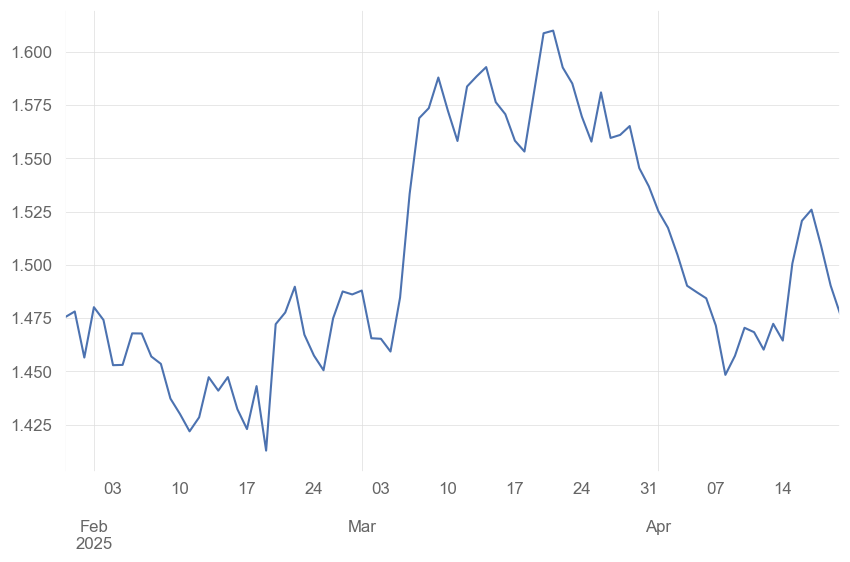

In [24]:
import quantstats as qs

((gfe["GFE"].pct_change(90).dropna()+1)**4).plot()

In [18]:
tarihler=pd.date_range(start="2024-12-01",end="2024-12-31")
for tarih in tarihler:
    try:
        tarih=tarih.strftime("%d.%m.%y")
        chrome_options = Options()
        chrome_options.add_argument("--headless")  
        chrome_options.add_argument("--disable-gpu")  
        chrome_options.add_argument("--no-sandbox")  

        driver = webdriver.Chrome(options=chrome_options)

        driver.get("https://www.hal.gov.tr/Sayfalar/FiyatDetaylari.aspx")

        date_input = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_dateControl_dateControlDate")
        date_input.clear()
        date_input.send_keys(tarih)  

        price_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnGet")
        price_button.click()

        all_pages_radio = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_rblExcelOptions_1")
        all_pages_radio.click()

        excel_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnExcel")
        excel_button.click()

        time.sleep(2)

        print(f"{tarih} çekildi!")

        driver.quit()
    except:
        chrome_options = Options()
        chrome_options.add_argument("--headless")  
        chrome_options.add_argument("--disable-gpu")  
        chrome_options.add_argument("--no-sandbox")  

        driver = webdriver.Chrome(options=chrome_options)

        driver.get("https://www.hal.gov.tr/Sayfalar/FiyatDetaylari.aspx")

        date_input = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_dateControl_dateControlDate")
        date_input.clear()
        date_input.send_keys(tarih)  

        price_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnGet")
        price_button.click()

        all_pages_radio = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_rblExcelOptions_1")
        all_pages_radio.click()

        excel_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnExcel")
        excel_button.click()

        time.sleep(2)

        print(f"{tarih} çekildi!")

        driver.quit()
        


01.12.24 çekildi!
02.12.24 çekildi!
03.12.24 çekildi!
04.12.24 çekildi!
05.12.24 çekildi!
06.12.24 çekildi!
07.12.24 çekildi!
08.12.24 çekildi!
09.12.24 çekildi!
10.12.24 çekildi!
11.12.24 çekildi!
12.12.24 çekildi!
13.12.24 çekildi!
14.12.24 çekildi!
15.12.24 çekildi!
16.12.24 çekildi!
17.12.24 çekildi!
18.12.24 çekildi!
19.12.24 çekildi!
20.12.24 çekildi!
21.12.24 çekildi!
22.12.24 çekildi!
23.12.24 çekildi!
24.12.24 çekildi!
25.12.24 çekildi!
26.12.24 çekildi!
27.12.24 çekildi!
28.12.24 çekildi!
29.12.24 çekildi!
30.12.24 çekildi!
31.12.24 çekildi!


In [20]:
col=["Ürün"]
cols=np.sort(sebzeler.columns[:-1])
col.extend(cols)
sebzeler=(sebzeler[col].iloc[:,1:].T)
sebzeler.index=pd.to_datetime(sebzeler.index)
sebzeler=sebzeler.sort_index()

In [21]:
col=["Ürün"]
cols=np.sort(meyveler.columns[:-1])
col.extend(cols)
meyveler=(meyveler[col].iloc[:,1:].T)
meyveler.index=pd.to_datetime(meyveler.index)
meyveler=meyveler.sort_index()

In [22]:

w=pd.read_csv("ağırlıklartüfe.csv",index_col=0)
meyveağırlık=w.loc[meyveler.columns]["Ağırlık"]/w.loc[meyveler.columns]["Ağırlık"].sum()
meyve_endeks=(meyveler*meyveağırlık).sum(axis=1)
meyve_endeks

Tarih
2024-12-01    39.229901
2024-12-02    33.697924
2024-12-03    42.269883
2024-12-04    36.412995
2024-12-05    37.864328
                ...    
2025-04-14    43.416894
2025-04-15    48.214514
2025-04-16    44.215070
2025-04-17    53.734666
2025-04-18    44.724032
Length: 139, dtype: float64

In [23]:
w=pd.read_csv("ağırlıklartüfe.csv",index_col=0)
sebzeağırlık=w.loc[sebzeler.columns]["Ağırlık"]/w.loc[sebzeler.columns]["Ağırlık"].sum()
sebze_endeks=(sebzeler*sebzeağırlık).sum(axis=1)
sebze_endeks

Tarih
2024-12-01    23.239601
2024-12-02    22.409904
2024-12-03    25.944970
2024-12-04    24.537766
2024-12-05    26.384272
                ...    
2025-04-14    22.509875
2025-04-15    25.163782
2025-04-16    24.146950
2025-04-17    24.201248
2025-04-18    22.773987
Length: 139, dtype: float64

In [24]:
meyvesebze=meyve_endeks*0.4+sebze_endeks*0.6

In [38]:
np.cumprod(meyvesebze.resample("M").mean().pct_change().fillna(0).dropna()+1)*100

,0,TÜİK
Tarih,,
2024-12-31,100.000000,100.00
2025-01-31,106.960379,103.41
2025-02-28,111.808261,102.16
2025-03-31,134.155727,118.54
2025-04-30,127.340449,0.00


In [47]:
meyvesebze=pd.DataFrame(meyvesebze)
meyvesebze["TÜİK"]=0
meyvesebze["TÜİK"].loc["2024-12"]=100
meyvesebze["TÜİK"].loc["2025-01"]=98.35
meyvesebze["TÜİK"].loc["2025-02"]=101.70

meyvesebze["TÜİK"].loc["2025-03"]=100.47
meyvesebze["TÜİK"].loc["2025-04"]=116.58



C:\Users\Bora\AppData\Local\Temp\ipykernel_16224\3627036409.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyvesebze["TÜİK"].loc["2024-12"]=100
C:\Users\Bora\AppData\Local\Temp\ipykernel_16224\3627036409.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyvesebze["TÜİK"].loc["2025-01"]=98.35


In [51]:
meyvesebze.resample("M").mean().pct_change().dropna()

,0,TÜİK
Tarih,,
2025-01-31,0.069604,-0.016500
2025-02-28,0.045324,0.034062
2025-03-31,0.199873,-0.012094
2025-04-30,-0.050801,0.160346


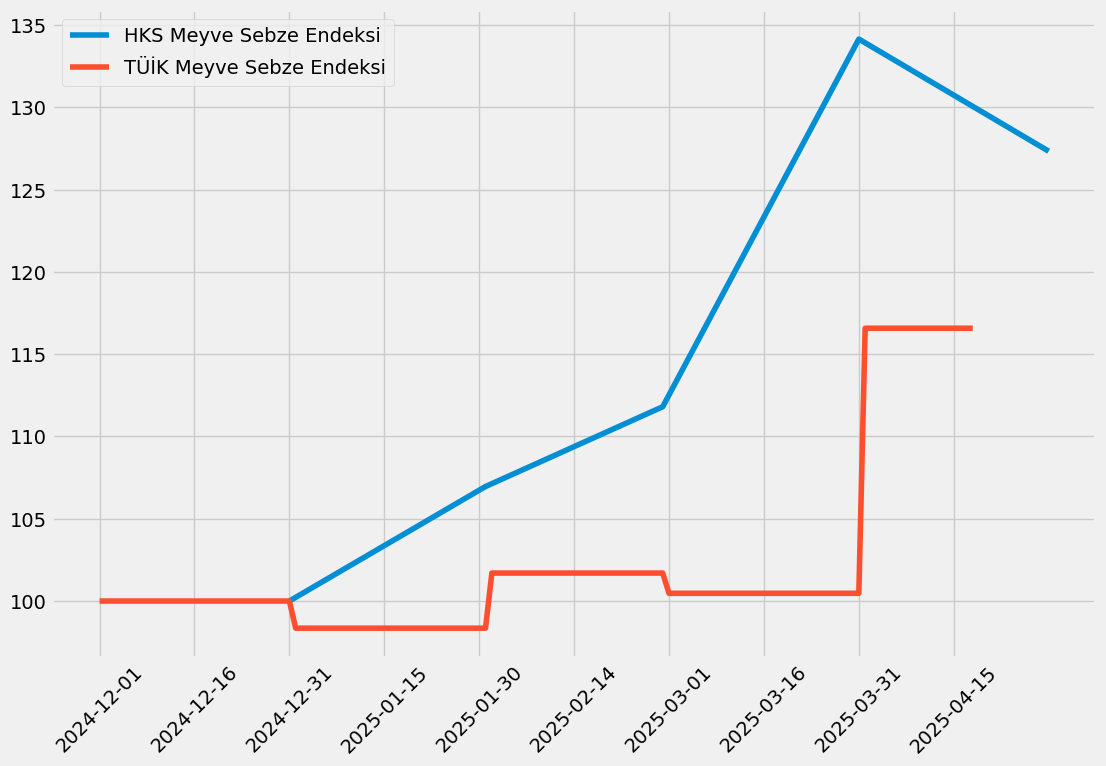

In [48]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))

plt.plot(np.cumprod(meyvesebze[0].resample("M").mean().pct_change().fillna(0)+1)*100,label="HKS Meyve Sebze Endeksi")
plt.plot(meyvesebze["TÜİK"],label="TÜİK Meyve Sebze Endeksi")
plt.xticks(meyvesebze.index[::15],rotation=45)
plt.legend()

In [19]:


import pandas as pd




import os
import glob

dosya_yolu = 'C:/Users/Bora/Downloads'  # Burada kendi dosya yolunuzu belirtin
datam=pd.DataFrame()
xls_dosyalari = glob.glob(os.path.join(dosya_yolu, '*.xls'))
for file in xls_dosyalari:
    df=pd.read_html(file)[0]
    df.index=[df.iloc[0,0][16:].split("(")[0][:-1]]*len(df)
    df.index=pd.to_datetime(df.index,dayfirst=True)
    df.columns=df.iloc[1].values
    df=df.iloc[2:]
    df["Ortalama Fiyat"]=df["Ortalama Fiyat"].astype(float)/100
    df["İşlem Hacmi"]=df["İşlem Hacmi"].astype(float)
    df["Hacimli"]=df["İşlem Hacmi"]*df["Ortalama Fiyat"]
    df["Tarih"]=df.index.strftime("%Y-%m-%d")
    df=df.set_index("Ürün Adı")
    df["Ağırlıklı Fiyat"]=df.groupby("Ürün Adı")["Hacimli"].sum()/df.groupby("Ürün Adı")["İşlem Hacmi"].sum()
    df["Ürün Adı"]=df.index
    df=df.set_index("Tarih")
    datam=pd.concat([datam,df],axis=0)



w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")
sebzeler=pd.DataFrame()
import numpy as np
for sebze in w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values:
    if sebze=="Çarliston Biber":
        sebze="Biber Çarliston"
    elif sebze=="Dolmalık Biber":
        sebze="Biber Dolmalık"
    elif sebze=="Sivri Biber":
        sebze="Biber Sivri"   
    elif sebze=="Taze Fasulye":
        sebze="Fasulye Taze" 
    elif sebze=="Kuru Soğan":
        sebze="Soğan Kuru"
    elif sebze=="Kırmızı Turp":
        sebze="turp"
    
    hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(sebze,case=False)])
    hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

    hal=pd.DataFrame(hal).T
    hal.index=[sebze]*len(hal)



    print(f"{sebze} verisi bulundu")
    sebzeler=pd.concat([sebzeler,hal],axis=0)


sebzeler.index=w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values
sebzeler["Ürün"]=f"HKS" + sebzeler.index




w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")
meyveler=pd.DataFrame()
import numpy as np
for meyve in w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values:

    hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(meyve,case=False)])
    hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

    hal=pd.DataFrame(hal).T
    hal.index=[meyve]*len(hal)



    print(f"{meyve} verisi bulundu")
    meyveler=pd.concat([meyveler,hal],axis=0)


meyveler.index=w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values
meyveler["Ürün"]=f"HKS" + meyveler.index






Biber Çarliston verisi bulundu
Biber Dolmalık verisi bulundu
Biber Sivri verisi bulundu
Dereotu verisi bulundu
Domates verisi bulundu
Fasulye Taze verisi bulundu
Havuç verisi bulundu
Ispanak verisi bulundu
Kabak verisi bulundu
Karnabahar verisi bulundu
Soğan Kuru verisi bulundu
Beyaz Lahana verisi bulundu
Kırmızı Lahana verisi bulundu
Mantar verisi bulundu
Kıvırcık verisi bulundu
Maydanoz verisi bulundu
Nane verisi bulundu
Patlıcan verisi bulundu
Pırasa verisi bulundu
Roka verisi bulundu
Salatalık verisi bulundu
Sarımsak verisi bulundu
turp verisi bulundu
Portakal verisi bulundu
Üzüm verisi bulundu
Armut verisi bulundu
Ayva verisi bulundu
Çilek verisi bulundu
Elma verisi bulundu
Karpuz verisi bulundu
Kavun verisi bulundu
Kivi verisi bulundu
Limon verisi bulundu
Mandalina verisi bulundu
Muz verisi bulundu
Nar verisi bulundu
Şeftali verisi bulundu


In [4]:
file 

'C:/Users/Bora/Downloads\\1744974593049_StandardPoors.xls'

In [ ]:
import pandas as pd
data1=pd.read_csv("sepet.csv",index_col=0)
data1=data1.drop_duplicates() 
data1.to_csv("sepet.csv")
degisim=data1.iloc[:,1:].pct_change(axis=1)
degisim=degisim.iloc[:,-1]
from scipy.stats import gmean
temp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))
df=ağırlıklar.loc[temp1.index]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
temp1=(temp1-1)*100
temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

In [8]:
ağırlıklar

NameError: name 'ağırlıklar' is not defined

<Figure size 2500x1500 with 0 Axes>

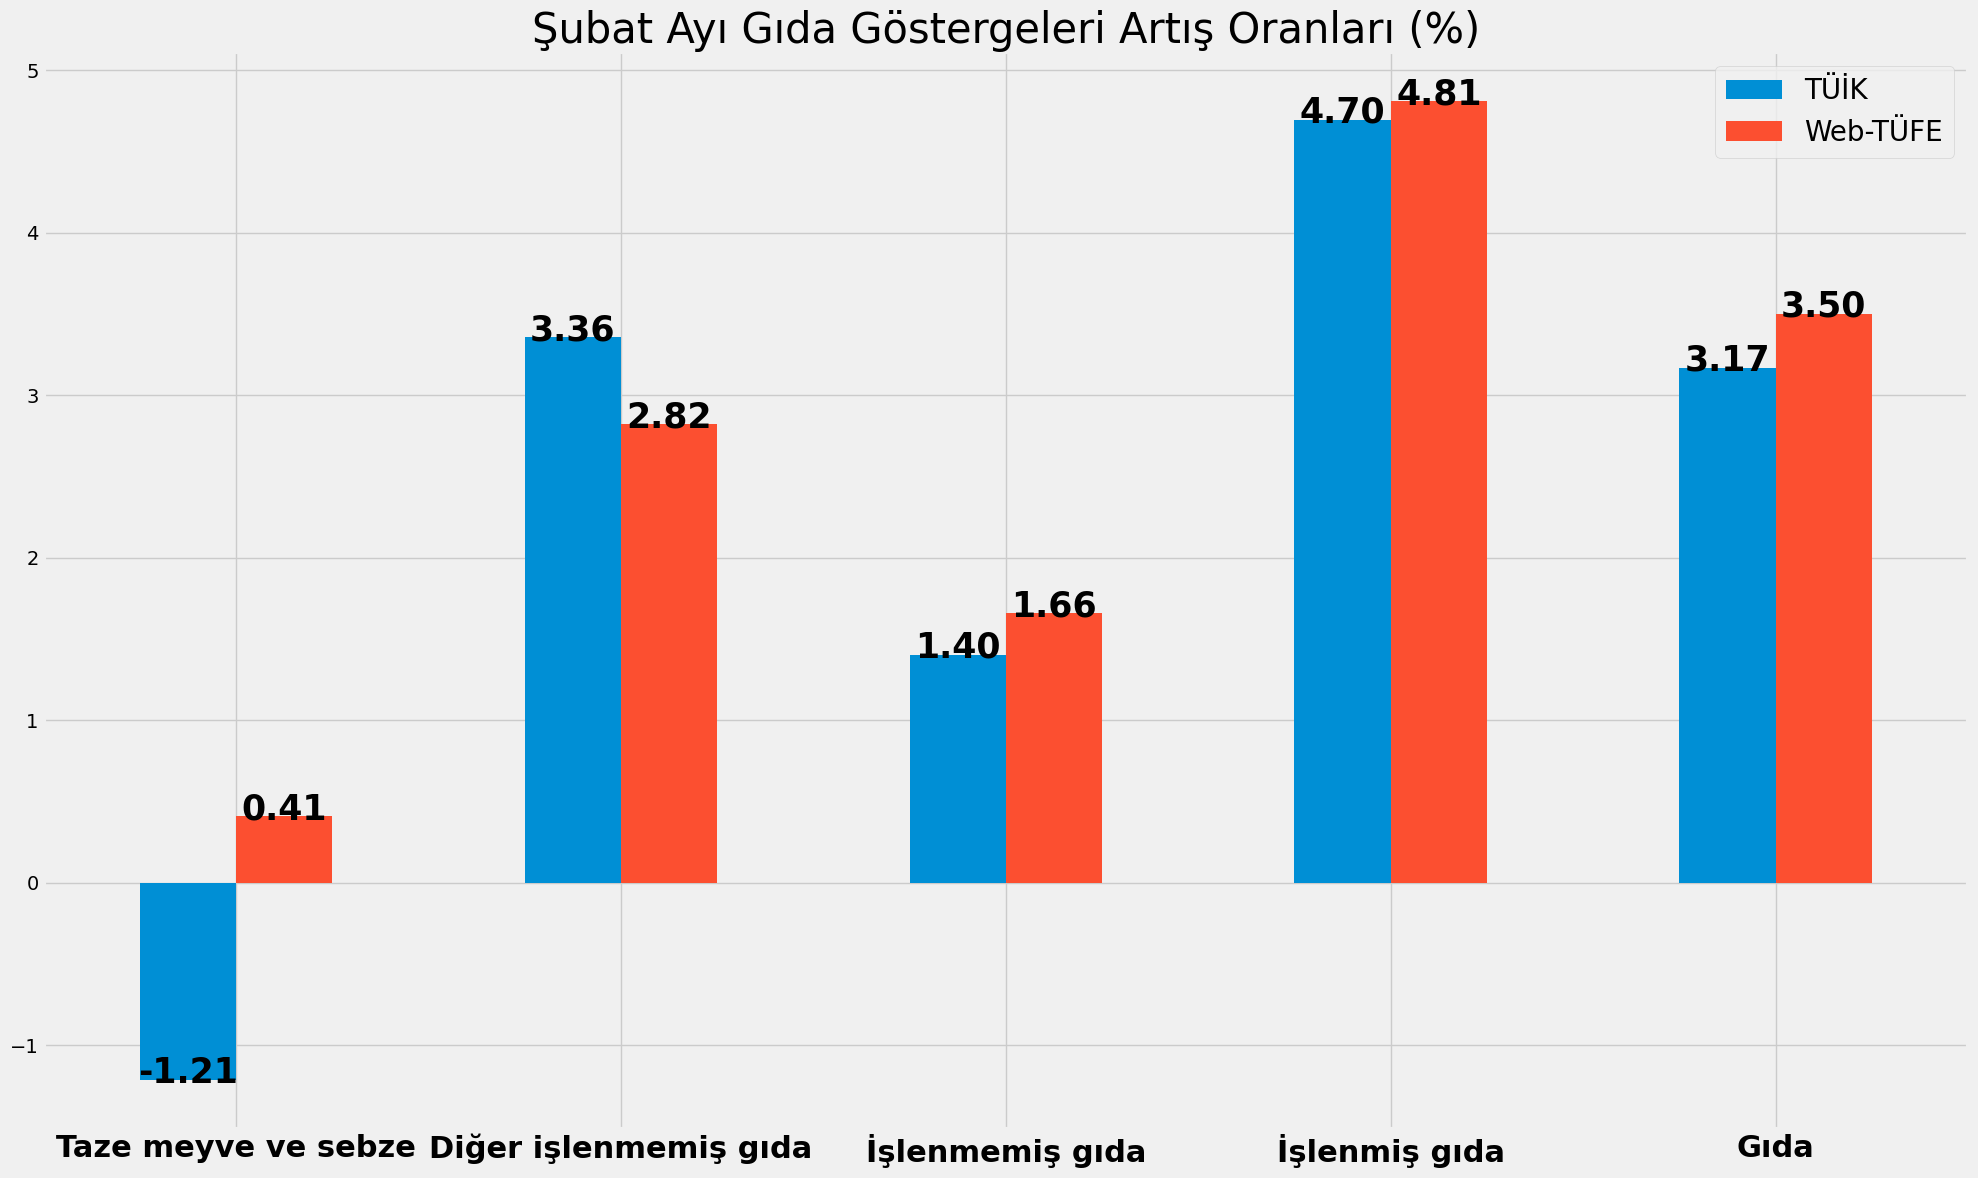

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
tüik=pd.read_csv("tüikim.csv",index_col=0)
plt.style.use("fivethirtyeight")
# Creating the data
data = {
    "TÜİK": tüik.pct_change().iloc[-1]*100,
    "Web-TÜFE": [0.41,2.82,1.66,4.81],

}

# Convert to DataFrame
df = pd.DataFrame(data)
df.loc["Gıda"]=[3.17,3.5]


# Plotting the bar chart with bold values on top of the bars
plt.figure(figsize=(25, 15))
ax = df.plot(kind='bar', figsize=(20, 12))

# Adding the values on top of the bars with bold text
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=25, fontweight='bold', color='black', xytext=(0, 5), textcoords='offset points')

plt.title("Şubat Ayı Gıda Göstergeleri Artış Oranları (%)",fontsize=30)

plt.xticks(rotation=0,fontsize=22,fontweight="bold")
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()


In [37]:
gıda=pd.read_excel("ozel kapsamli tufe gostergeleri (1).xls")
gıda=gıda.iloc[50:51,3:].T
gıda.columns=["Aylık Değişim"]
gıda=gıda.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(gıda)))
gıda=gıda.loc["2024-11-30":]
gıda["Tarih"]=gıda.index.strftime("%Y-%m")
gıda=gıda.reset_index(drop=True)
gıda_c=gıda[["Tarih","Aylık Değişim"]]


aylık_endeks_tüik=list(gıda_c["Aylık Değişim"])
tüik_aylık=[1]
tüik_aylık.extend(list(((np.array(aylık_endeks_tüik)/100))+1))
tüik_aylık=pd.DataFrame(tüik_aylık,columns=["TÜİK"])
tüik_aylık=np.cumprod(tüik_aylık)*100

tüik_aylık.index=pd.date_range(start="2024-10-31",freq="M",periods=len(tüik_aylık)).strftime("%Y-%m-%d")
tüik_aylık.index=pd.to_datetime(tüik_aylık.index)

C:\Users\Bora\AppData\Local\Temp\ipykernel_24220\2351233369.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gıda=gıda.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(gıda)))
C:\Users\Bora\AppData\Local\Temp\ipykernel_24220\2351233369.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tüik_aylık.index=pd.date_range(start="2024-10-31",freq="M",periods=len(tüik_aylık)).strftime("%Y-%m-%d")


In [39]:
gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)
gfe["TÜİK"]=tüik_aylık["TÜİK"]
gfe=gfe.fillna(method="ffill")
gfe=gfe.fillna(100)

C:\Users\Bora\AppData\Local\Temp\ipykernel_24220\1037474672.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gfe=gfe.fillna(method="ffill")


In [ ]:
"""
    sa_data=pd.DataFrame()
    for col in tüik.columns:
        sa_data[f"{col} Aylık Ortalama"]=hareketli_aylik_ortalama(özelgöstergeler[col]).iloc[:,[-1,]]
        sa_data[f"{col} Aylık Ortalama"]=sa_data[f"{col} Aylık Ortalama"].fillna(method="ffill")
        sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end')
        sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')
        sa_data.loc["2024-10","Önceki"]=pd.NA
        sa_data[f"{col} Önceki Endeks"]=pd.NA
        sa_data.loc["2024-11-01":,f"{col} Önceki Endeks"]=sa_data.loc[sa_data["Önceki"].dropna(),f"{col} Aylık Ortalama"].values

    sa_datadegisim=pd.DataFrame(index=pd.to_datetime(sa_data.loc["2024-11":].index))
    for col in tüik.columns:
        sa_datadegisim[col]=((sa_data[f"{col} Aylık Ortalama"]/sa_data[f"{col} Önceki Endeks"]).dropna()).values
        sa_datadegisim[col]=sa_datadegisim[col].astype(float)
        sa_datadegisim.index=pd.to_datetime(sa_datadegisim.index)
    sa_datadegisim=sa_datadegisim.resample('M').last()   
    sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Taze meyve ve sebze")] = [1.082103253420332, 1.0378297012546769]
    sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Diğer işlenmemiş gıda")] = [1.0333601398698096, 1.014720660120335]



    for col in sa_datadegisim.columns:
        sa_datadegisim[f"{col} MA"]=pd.NA


        for row in sa_datadegisim.index:
                tüik_data=tüik[col].loc[:(row.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')]
                tüik_data.loc[pd.to_datetime((row.to_period('M')).to_timestamp(how='end').strftime('%Y-%m-%d'))]=tüik_data.iloc[-1]*sa_datadegisim[col].loc[row]
                from statsmodels.tsa.x13 import x13_arima_analysis


                np.random.seed(42)



                x13_path = r'C:\Users\Bora\Desktop\x13as'
                
                

                
                ayris = x13_arima_analysis(tüik_data, x12path=x13_path,outlier=False,log=False)
                sa_datadegisim[f"{col} MA"].loc[row]=ayris.seasadj.pct_change().iloc[-1]*100


    for col in tüik.columns:
        sa_datadegisim[f"{col} Faktör"]=((sa_datadegisim[f"{col} MA"]/100)+1)/sa_datadegisim[col]
        sa_datadegisim["Ay"]=sa_datadegisim.reset_index()["Tarih"].dt.month.values

    sa_datadegisim.columns=['Taze meyve ve sebze', 'Diğer işlenmemiş gıda',
    'SA Taze meyve ve sebze', 'SA Diğer işlenmemiş gıda',
    'Taze meyve ve sebze Faktör', 'Ay', 'Diğer işlenmemiş gıda Faktör']
    sa_datadegisim["İşlenmiş gıda"]=hareketli_aylik_ortalama(özelgöstergeler["İşlenmiş gıda"])["Aylık Ortalama"].fillna(method="ffill").resample('M').last().pct_change().dropna()*100
    sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("İşlenmiş gıda")] = [2.61412286061347, 1.60328139006671]


    ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
    w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
    w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
    meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
    sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
    meyvesebze=np.concatenate([meyveler,sebzeler])
    digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

    islenmemis=digerislenmemis+list(meyvesebze)

    ağırlıklar=ağırlıklar.reset_index()
    meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
    meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
    digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
    digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
    islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
    islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()

    sa_datadegisim["SA İşlenmemiş gıda"]=(sa_datadegisim[islenmemisler.sort_index().index.unique()]*islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()).sum(axis=1)


    islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
    islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

    islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

    genel=pd.concat([islenmemisler,islenmisler],axis=0)

    sa_datadegisim["SA Web-GFE"]=(sa_datadegisim[genel.sort_index().groupby(level=0)["Ağırlık"].sum().index]*genel.groupby(level=0)["Ağırlık"].sum()).sum(axis=1)
    sa_datadegisim.to_csv("magöstergeler.csv")
"""

In [ ]:
göstergeaylık=pd.DataFrame()
for col in tüik.columns:
    göstergeaylık[col]=hareketli_aylik_ortalama(özelgöstergeler[col])["Aylık Ortalama"].fillna(method="ffill").resample('M').last().pct_change().dropna()*100
    göstergeaylık[col].iloc[-1]=(((hareketli_aylik_ortalama(özelgöstergeler[col])["Aylık Ortalama"].iloc[-1]/hareketli_aylik_ortalama(özelgöstergeler[col])["Aylık Ortalama"].loc["2025-02-01"]))-1)*100

In [27]:
göstergeaylık


,Taze meyve ve sebze,Diğer işlenmemiş gıda,İşlenmemiş gıda,İşlenmiş gıda
Tarih,,,,
2024-11-30,5.477013,1.741840,3.612414,0.861357
2024-12-31,6.073420,3.877814,4.924704,2.034034
2025-01-31,6.135508,3.243180,4.713203,2.438807
2025-02-28,-0.040998,2.862252,1.335669,4.798631
2025-03-31,12.344673,3.698780,7.990578,2.912418


In [19]:
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()


C:\Users\Bora\AppData\Local\Temp\ipykernel_9800\2997715634.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))


Commit işlemi başarılı: update
Push işlemi başarılı.
